# Statistical Analysis of Simplification Operations

## 1. Setup and Data Preparation


In [326]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp
from scikit_posthocs import posthoc_wilcoxon
from statsmodels.stats.multitest import multipletests
import pingouin as pg

from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt

from helper_functions import df_to_enhanced_latex

### Import Data

In [327]:
# one dataframe for sentence level aggregated data, and one for individual edits
df_sentences = pd.read_csv("../data/salsa_annotations/final_annotated/df_sentences.csv")
df_edits = pd.read_csv("../data/salsa_annotations/final_annotated/df_edits.csv")

# add numeric sentence ID
df_sentences['Sentence ID NUM'] = df_sentences['Sentence ID'].str.extract(r'_(.*)')
df_sentences['Sentence ID NUM'] = pd.to_numeric(df_sentences['Sentence ID NUM'])
df_edits['Sentence ID NUM'] = df_edits['Sentence ID'].str.extract(r'_(.*)')
df_edits['Sentence ID NUM'] = pd.to_numeric(df_edits['Sentence ID NUM'])

# add a mixed combined ID
df_sentences['Sentence ID MIX'] = df_sentences['Sentence ID'] + "_" + df_sentences['Dataset']
df_edits['Sentence ID MIX'] = df_edits['Sentence ID'] + "_" + df_edits['Dataset']

# add flag of language "DE" if dataset wikIDE; else "EN"
df_sentences['Language'] = np.where(df_sentences['Dataset'] == "wikIDE", "DE", "EN")
df_edits['Language'] = np.where(df_edits['Dataset'] == "wikIDE", "DE", "EN")

# add flag for LLM vs older methods
df_sentences['LLM_Flag'] = df_sentences['System'].apply(lambda s: 
        True if s in ['LLAMA', 'ChatGPT']
        else False
)
df_edits['LLM_Flag'] = df_edits['System'].apply(lambda s:
        True if s in ['LLAMA', 'ChatGPT']
        else False
)

# add flag of SpecialDomain (specialized if cochrane or scotus dataset, else general)
df_sentences['SpecialDomain'] = np.where(df_sentences['Dataset'].isin(["cochrane", "scotus"]), "Specialized", "General")
df_edits['SpecialDomain'] = np.where(df_edits['Dataset'].isin(["cochrane", "scotus"]), "Specialized", "General")

# set LENS_SALSA to np.NAN where dataset is wikiDE
df_sentences['LENS_SALSA'] = np.where(df_sentences['Dataset'] == "wikiDE", np.nan, df_sentences['LENS_SALSA'])

print(df_sentences.shape)
print(df_edits.shape)

display(df_sentences.head())
display(df_edits.head())

(750, 55)
(3954, 30)


Sentence ID                                             Source  \
0  ChatGPT_001  The N1 road also designated as RN1, is a road ...   
1  ChatGPT_002  Originating in the capital city of Bangui, the...   
2  ChatGPT_003  As a key component of the country's road netwo...   
3  ChatGPT_004  The N1 route commences in the heart of Bangui,...   
4  ChatGPT_005  The terrain along this stretch is characterize...   

                                              Target   System Dataset  \
0  The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
1  The road starts in Bangui and goes northwest t...  ChatGPT  wikiEN   
2  The N1 is an important part of the country's r...  ChatGPT  wikiEN   
3  The N1 route starts in the center of Bangui, t...  ChatGPT  wikiEN   
4  The land here is mostly flat or gently sloping...  ChatGPT  wikiEN   

   Total Edits  Substitution_count  Insertion_count  Split_count  \
0            4                   1                1            1   
1            7                   1                0            0   
2            5                   2                0            1   
3            4                   3                0            0   
4           10                   5                1            0   

   Structure_count  ...  Insertion (Neutral)  Reorder (Neutral)  \
0             1.00  ...                    0                  1   
1             1.00  ...                    0                  1   
2             1.00  ...                    0                  1   
3             0.00  ...                    0                  0   
4             2.00  ...                    0                  1   

   Split (Neutral)  Structure (Neutral)  Substitution (Neutral)  \
0                0                    1                       0   
1                0                    0                       2   
2                1                    0                       2   
3                0                    1                       2   
4                0                    0                       1   

   Sentence ID NUM     Sentence ID MIX  Language  LLM_Flag  SpecialDomain  
0                1  ChatGPT_001_wikiEN        EN      True        General  
1                2  ChatGPT_002_wikiEN        EN      True        General  
2                3  ChatGPT_003_wikiEN        EN      True        General  
3                4  ChatGPT_004_wikiEN        EN      True        General  
4                5  ChatGPT_005_wikiEN        EN      True        General  

[5 rows x 55 columns]

Sentence ID                                             Source  \
0  ChatGPT_001  The N1 road also designated as RN1, is a road ...   
1  ChatGPT_001  The N1 road also designated as RN1, is a road ...   
2  ChatGPT_001  The N1 road also designated as RN1, is a road ...   
3  ChatGPT_001  The N1 road also designated as RN1, is a road ...   
4  ChatGPT_002  Originating in the capital city of Bangui, the...   

                                              Target   System Dataset  \
0  The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
1  The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
2  The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
3  The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
4  The road starts in Bangui and goes northwest t...  ChatGPT  wikiEN   

       Family     Edit Type   Edit Sub-Type Edit Classification  \
0  Conceptual  substitution             NaN   Good Substitution   
1  Conceptual     insertion             NaN   Trivial Insertion   
2      Syntax         split  Sentence Split          Good Split   
3      Syntax     structure  Part of Speech   Trivial Structure   
4  Conceptual      deletion    Bad Deletion        Bad Deletion   

  Structure Sub-Type  ... Constituent Output Index       Input Text  \
0                NaN  ...                       []       designated   
1                NaN  ...                       []              NaN   
2                NaN  ...             [[[76, 78]]]              NaN   
3     Part of Speech  ...  [[[76, 78], [97, 101]]]              NaN   
4                NaN  ...                       []  capital city of   

  Output Text  has_specialized_terms contains_named_entity Sentence ID NUM  \
0      called                  False                 False               1   
1         the                  False                 False               1   
2         NaN                  False                 False               1   
3         NaN                  False                 False               1   
4         NaN                  False                  True               2   

      Sentence ID MIX  Language  LLM_Flag SpecialDomain  
0  ChatGPT_001_wikiEN        EN      True       General  
1  ChatGPT_001_wikiEN        EN      True       General  
2  ChatGPT_001_wikiEN        EN      True       General  
3  ChatGPT_001_wikiEN        EN      True       General  
4  ChatGPT_002_wikiEN        EN      True       General  

[5 rows x 30 columns]

In [328]:
df_edits

Sentence ID                                             Source  \
0     ChatGPT_001  The N1 road also designated as RN1, is a road ...   
1     ChatGPT_001  The N1 road also designated as RN1, is a road ...   
2     ChatGPT_001  The N1 road also designated as RN1, is a road ...   
3     ChatGPT_001  The N1 road also designated as RN1, is a road ...   
4     ChatGPT_002  Originating in the capital city of Bangui, the...   
...           ...                                                ...   
3949     MUSS_049  Auch in Bristol, das einige Tage zuvor Schaupl...   
3950     MUSS_049  Auch in Bristol, das einige Tage zuvor Schaupl...   
3951     MUSS_050  Als Reaktion auf die anhaltenden Unruhen veröf...   
3952     MUSS_050  Als Reaktion auf die anhaltenden Unruhen veröf...   
3953     MUSS_050  Als Reaktion auf die anhaltenden Unruhen veröf...   

                                                 Target   System Dataset  \
0     The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
1     The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
2     The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
3     The N1 road, also called RN1, is a road in the...  ChatGPT  wikiEN   
4     The road starts in Bangui and goes northwest t...  ChatGPT  wikiEN   
...                                                 ...      ...     ...   
3949  Am 7. August 2024 war Schauplatz gewalttätiger...     MUSS  wikiDE   
3950  Am 7. August 2024 war Schauplatz gewalttätiger...     MUSS  wikiDE   
3951  Am 5. August wurden Reisewarnungen für das Ver...     MUSS  wikiDE   
3952  Am 5. August wurden Reisewarnungen für das Ver...     MUSS  wikiDE   
3953  Am 5. August wurden Reisewarnungen für das Ver...     MUSS  wikiDE   

          Family     Edit Type   Edit Sub-Type Edit Classification  \
0     Conceptual  substitution             NaN   Good Substitution   
1     Conceptual     insertion             NaN   Trivial Insertion   
2         Syntax         split  Sentence Split          Good Split   
3         Syntax     structure  Part of Speech   Trivial Structure   
4     Conceptual      deletion    Bad Deletion        Bad Deletion   
...          ...           ...             ...                 ...   
3949  Conceptual      deletion    Bad Deletion        Bad Deletion   
3950  Conceptual      deletion    Bad Deletion        Bad Deletion   
3951  Conceptual      deletion    Bad Deletion        Bad Deletion   
3952      Syntax     structure           Voice   Trivial Structure   
3953  Conceptual      deletion             NaN       Good Deletion   

     Structure Sub-Type  ... Constituent Output Index  \
0                   NaN  ...                       []   
1                   NaN  ...                       []   
2                   NaN  ...             [[[76, 78]]]   
3        Part of Speech  ...  [[[76, 78], [97, 101]]]   
4                   NaN  ...                       []   
...                 ...  ...                      ...   
3949                NaN  ...                       []   
3950                NaN  ...                       []   
3951                NaN  ...                       []   
3952              Voice  ...   [[[13, 19], [65, 80]]]   
3953                NaN  ...                       []   

                                             Input Text Output Text  \
0                                            designated      called   
1                                                   NaN         the   
2                                                   NaN         NaN   
3                                                   NaN         NaN   
4                                       capital city of         NaN   
...                                                 ...         ...   
3949                     eine Gegendemonstration statt.         NaN   
3950                                               fand         NaN   
3951           Als Reaktion auf die anhaltenden Unruhen        

## Statistical Analysis - Function Definitions

In [329]:
all_test_results = []

def add_test_result(category, test_type, description, **kwargs):
    result = {
        'category': category,
        'test_type': test_type,
        'description': description,
        **kwargs
    }
    all_test_results.append(result)

In [330]:
# Function to routinely check if the result is significant at 0.05 level
def print_significance(p_value, alpha=0.05):
    if p_value <= alpha:
        print("\n*** The result is statistically significant. ***")
    else:
        print("\nThe result is not statistically significant.")

In [331]:
# Chi-square test with APA reporting
def run_chi2_test(input_contingency_table, scope='System', alpha=0.05, category=None, description=None):
    chi2, p_value, dof, expected = chi2_contingency(input_contingency_table)
    n = np.sum(input_contingency_table.values)
    cramer_v = np.sqrt(chi2 / (n * (min(input_contingency_table.shape) - 1)))

    print("--- Chi-square test results: ---")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p_value:.4f}")
    print(f"Cramer's V: {cramer_v:.4f}")
    print(f"Sample size: {n}")

    # ensure alpha is float
    alpha = float(alpha)

    # Format APA style output
    if p_value < 0.001:
        p_string = "p < .001"
    else:
        p_string = f"p = {p_value:.3f}"
    
    apa_format = f"χ²({dof}, N = {n}) = {chi2:.2f}, {p_string}"
    print(f"\nAPA Format: {apa_format}")

    print_significance(p_value, alpha)

    add_test_result(
        category=category,
        test_type='chi2',
        description=description,
        statistic=chi2,
        p_value=p_value,
        dof=dof,
        cramer_v=cramer_v,
        sample_size=n,
        apa_format=apa_format
    )

    if p_value <= alpha:
        print("\n      --- ATTENTION: Conducting Post-hoc analysis: ---")
        # check if only two groups are compared
        if len(input_contingency_table.index.get_level_values(scope).unique()) == 2:
            print("Only two groups are compared. No post-hoc analysis is needed.")
            return
        else: 
            post_hoc_chi_square(input_contingency_table, scope, alpha)

    return chi2, p_value, dof, cramer_v


def post_hoc_chi_square(input_contingency_table, scope='System', alpha=0.05, category=None, description=None):
    # Perform pairwise chi-square tests
    scope_list = input_contingency_table.index.get_level_values(scope).unique()
    num_comparisons = len(scope_list) * (len(scope_list) - 1) // 2

    print(f" Debug: Input contingency table: \n{input_contingency_table}")
    
    # Bonferroni correction
    adjusted_alpha = alpha / num_comparisons
    print(f"Bonferroni-adjusted significance level: {adjusted_alpha:.4f}")
    
    for i in range(len(scope_list)):
        for j in range(i+1, len(scope_list)):
            sys1, sys2 = scope_list[i], scope_list[j]
            # check none of the cells have 0 frequency
            if 0 in input_contingency_table.loc[[sys1, sys2]].values:
                print(f"Skipping {sys1} vs {sys2} comparison because of 0 frequency in one of the cells.")
                continue

            chi2, p_value, _, _ = chi2_contingency(input_contingency_table.loc[[sys1, sys2]])
            print(f"{sys1} vs {sys2}: chi2 = {chi2:.4f}, p-value = {p_value:.4f}")
            print_significance(p_value, adjusted_alpha)

            add_test_result(
                category=category,
                test_type='chi2_post_hoc',
                description=description,
                comparison=f"{sys1} vs {sys2}",
                statistic=chi2,
                p_value=p_value,
                adjusted_alpha=adjusted_alpha
            )


In [332]:
# Assumption test helpers

def run_shapiro_normality_test(data):
    # drop NaNs
    data = data.dropna()

    try:
        _, p_value = stats.shapiro(data)
        print(f"Shapiro-Wilk test p-value: {p_value}")
    except ValueError:
        print("Not enough data to perform Shapiro-Wilk test")
        p_value = None
    return p_value

def run_levene_test(dataframe, groupby_col, target_col):
    # drop NaNs
    dataframe = dataframe.dropna(subset=[target_col])
    
    groups = [group[target_col] for _, group in dataframe.groupby(groupby_col)]
    if len(groups) >= 2:
        _, levene_p_value = stats.levene(*groups) # * unpacks the list
        print(f"Levene's test p-value: {levene_p_value:.4f}")
        return levene_p_value
    else:
        print("Not enough groups to perform Levene's test")
        return None

In [333]:
# Comprehensive ANOVA function
def run_comprehensive_anova(dataframe, groupby_col, target_col, alpha=0.05, category=None, description=None):
    results = {
        'category': category,
        'description': description,
        'groupby': groupby_col,
        'target': target_col,
        'test_type': None,
        'statistic': None,
        'p_value': None,
        'normality_results': {},
        'levene_p_value': None
    }
    
    print(f"\nANOVA: Analyzing {target_col} grouped by {groupby_col}")
    print("=" * 10)

    # drop NaNs
    dataframe = dataframe.dropna(subset=[groupby_col, target_col])

    ### Assumption tests
    # Shapiro-Wilk test for each group
    print("--- Running Shapiro-Wilk normality test for each group:")
    groups = dataframe.groupby(groupby_col)
    normality_results = {}
    for name, group in groups:
        p_val = run_shapiro_normality_test(group[target_col])
        if p_val is not None:
            normality_results[name] = p_val > alpha
        results['normality_results'][name] = p_val
        print(f"Group {name}: {'Normal' if normality_results[name] else 'Not normal'}")
     
    # Levene's test
    print("\n--- Running Levene's test for homogeneity of variances:")
    levene_p_value = run_levene_test(dataframe, groupby_col, target_col)
    results['levene_p_value'] = levene_p_value


    # Check if all groups are normal and variances are homogeneous
    all_normal = all(normality_results.values())
    variances_equal = levene_p_value is not None and levene_p_value > alpha

    if all_normal and variances_equal:
        print("\nAssumptions for ANOVA are met. Proceeding with one-way ANOVA.")

        # Perform one-way ANOVA
        f_statistic, p_value = stats.f_oneway(*[group[target_col] for name, group in groups])
        results['test_type'] = 'one_way_anova'
        results['statistic'] = f_statistic
        results['p_value'] = p_value
        print(f"\n--- One-way ANOVA results: ---")
        print(f"F-statistic: {f_statistic:.4f}")
        print(f"p-value: {p_value:.4f}")

        print_significance(p_value)

    else:
        print("\nAssumptions for ANOVA are not met. Proceeding with Kruskal-Wallis H-test.")
        
        #Perform Kruskal-Wallis H-test
        groups = [group[target_col] for name, group in dataframe.groupby(groupby_col)]
        h_statistic, p_value = stats.kruskal(*groups)
        results['test_type'] = 'kruskal_wallis'
        results['statistic'] = h_statistic
        results['p_value'] = p_value

        print(f"\n--- Kruskal-Wallis H-test results: ---")
        print(f"H-statistic: {h_statistic:.4f}")
        print(f"p-value: {p_value:.4f}")


        if p_value <= alpha:
            print("\n*** The result of the  Kruskal-Wallis H-test is statistically significant. ***")
            print(f"There is a significant difference in {target_col} across {groupby_col}.")

            # Perform Dunn's test
            print("\n--- Dunn's post-hoc test results: ---")
            dunn_results = sp.posthoc_dunn(dataframe, val_col=target_col, group_col=groupby_col, p_adjust='bonferroni')
            results['post_hoc'] = dunn_results.to_dict()

            # Add significance indicators
            def get_significance_symbol(p_val):
                if p_val > alpha:
                    return "ns"
                elif p_val <= 0.001:
                    return "***"
                elif p_val <= 0.01:
                    return "**"
                else:
                    return "*"
            
            # Create formatted output
            print("\nPairwise Comparisons:")
            print("-" * 50)
            for idx in dunn_results.index:
                for col in dunn_results.columns:
                    if idx < col: 
                        p_val = dunn_results.loc[idx, col]
                        sig = get_significance_symbol(p_val)
                        print(f"{idx} vs {col}: p = {p_val:.4f} {sig}")
                        
            print("\nSignificance levels:")
            print("ns : p > 0.05")
            print("*  : p ≤ 0.05")
            print("** : p ≤ 0.01")
            print("***: p ≤ 0.001")

            # Add descriptive statistics
            print("\nDescriptive Statistics:")
            print(dataframe.groupby(groupby_col)[target_col].describe())

        else:
            print("\nThe result of the  Kruskal-Wallis H-test is not statistically significant.")
            print(f"There is no significant difference in {target_col} across {groupby_col}.")

    return results

In [334]:
from scipy.stats import friedmanchisquare
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

def run_comprehensive_RM_anova(dataframe, groupby_col, target_col, subject_col='Sentence ID', alpha=0.05, category=None, description=None,
    identifier_posthoc = "SubjectID"
):
    results = {
        'category': category,
        'description': description,
        'groupby': groupby_col,
        'target': target_col,
        'subject': subject_col,
        'test_type': None,
        'statistic': None,
        'p_value': None,
        'df1': None,
        'df2': None,
        'effect_size': None,
        'effect_size_type': None,
        'normality_results': {},
        'sphericity_statistic': None,
        'sphericity_p': None,
        'sphericity_ok': None,
        'correction': None,
        'apa_format': None
    }
    
    print(f"\nRepeated Measures ANOVA: Analyzing {target_col} grouped by {groupby_col}, repeated across {subject_col}")
    print("=" * 10)
    
    ### Assumption tests
    # Shapiro-Wilk test for each group
    print("--- Running Shapiro-Wilk normality test for each group:")
    groups = dataframe.groupby(groupby_col)
    normality_results = {}
    for name, group in groups:
        p_val = run_shapiro_normality_test(group[target_col])
        if p_val is not None:
            normality_results[name] = p_val > alpha
        try:
            results['normality_results'][name] = p_val
            print(f"Group {name}: {'Normal' if normality_results[name] else 'Not normal'} (p = {p_val:.4f})")
        except Exception as e:
            print(f"Error in normality test for group {name}: {e}")
    
    # Test Sphericity using Mauchly's test (via Pingouin)
    print("\n--- Testing for sphericity ---")
    try:
        # Pivot data to wide format: each subject's repeated measures become separate columns
        print(f"DEBUG: running pivot with index SubjectID, columns {groupby_col}, values {target_col}")
        dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
        data_pivot = dataframe.pivot(index="SubjectID", columns=groupby_col, values=target_col)
        data_pivot = data_pivot.dropna()
        
        # Run Mauchly's test using Pingouin
        spher_results = pg.sphericity(data_pivot)
        results['sphericity_statistic'] = spher_results.chi2
        results['sphericity_p'] = spher_results.pval
        results['sphericity_ok'] = spher_results.pval > alpha
        print(f"Mauchly's test: W = {spher_results.W:.4f}, chi2 = {spher_results.chi2:.4f}, dof = {spher_results.dof}, p-value = {spher_results.pval:.4f}")
        if results['sphericity_ok']:
            print("Sphericity assumption is met.")
        else:
            print("Sphericity assumption is violated. A correction (Greenhouse-Geisser) will be applied (if normality is still given).")
    except Exception as e:
        print("Error during sphericity test:", str(e))
        results['sphericity_statistic'] = None
        results['sphericity_p'] = None
        results['sphericity_ok'] = False

    # Check if all groups are normal
    all_normal = all(normality_results.values())
    
    if all_normal:
        print("\nAll groups are normally distributed.")
        # Decide which ANOVA method to use based on sphericity
        try:
            if results['sphericity_ok']:
                print("\nProceeding with standard repeated measures ANOVA (sphericity assumed).")
                rm_anova = AnovaRM(dataframe, depvar=target_col, subject=subject_col, within=[groupby_col])
                anova_results = rm_anova.fit()
                
                # Extract needed statistics
                f_statistic = anova_results.summary().tables[0]['F Value'][0]
                p_value = anova_results.summary().tables[0]['Pr > F'][0]
                df1 = anova_results.summary().tables[0]['Num DF'][0]
                df2 = anova_results.summary().tables[0]['Den DF'][0]
                
                # Calculate partial eta squared
                ss_effect = anova_results.summary().tables[0]['Sum Sq'][0]
                ss_error = anova_results.summary().tables[0]['Sum Sq'][1]
                eta_p_squared = ss_effect / (ss_effect + ss_error)
                
                results['test_type'] = 'repeated_measures_anova'
                results['statistic'] = f_statistic
                results['p_value'] = p_value
                results['df1'] = df1
                results['df2'] = df2
                results['effect_size'] = eta_p_squared
                results['effect_size_type'] = 'partial eta squared'
                results['correction'] = 'None'
                
                # Format APA style result
                apa_format = f"F({int(df1)}, {int(df2)}) = {f_statistic:.2f}, p = {p_value:.3f}, ηp² = {eta_p_squared:.3f}"
                results['apa_format'] = apa_format
                
                print(f"F-statistic: {f_statistic:.4f}")
                print(f"p-value: {p_value:.4f}")
                print(f"Degrees of freedom: {df1}, {df2}")
                print(f"Effect size (partial eta squared): {eta_p_squared:.4f}")
                print(f"APA format: {apa_format}")
                
            else:
                print("\nSphericity violated. Proceeding with Greenhouse-Geisser corrected repeated measures ANOVA using Pingouin.")
                anova_results = pg.rm_anova(data=dataframe, dv=target_col, within=groupby_col, subject=subject_col, detailed=True)
                
                # Extract statistics
                f_statistic = anova_results.loc[0, 'F']
                p_value = anova_results.loc[0, 'p-GG']
                df1 = anova_results.loc[0, 'ddof1']
                df2 = anova_results.loc[0, 'ddof2']
                eta_p_squared = anova_results.loc[0, 'np2']
                gg_epsilon = anova_results.loc[0, 'GG']
                
                # Adjust df for GG correction
                adj_df1 = df1 * gg_epsilon
                adj_df2 = df2 * gg_epsilon
                
                results['test_type'] = 'repeated_measures_anova (Greenhouse-Geisser corrected)'
                results['statistic'] = f_statistic
                results['p_value'] = p_value
                results['df1'] = adj_df1
                results['df2'] = adj_df2
                results['effect_size'] = eta_p_squared
                results['effect_size_type'] = 'partial eta squared'
                results['correction'] = 'Greenhouse-Geisser'
                
                # Format APA style result
                apa_format = f"F({adj_df1:.2f}, {adj_df2:.2f}) = {f_statistic:.2f}, p = {p_value:.3f}, ηp² = {eta_p_squared:.3f}"
                results['apa_format'] = apa_format
                
                print(f"F-statistic: {f_statistic:.4f}")
                print(f"p-value (GG corrected): {p_value:.4f}")
                print(f"Adjusted degrees of freedom (GG ε = {gg_epsilon:.2f}): {adj_df1:.2f}, {adj_df2:.2f}")
                print(f"Effect size (partial eta squared): {eta_p_squared:.4f}")
                print(f"APA format: {apa_format}")
                
        except Exception as e:
            print("\nError performing repeated measures ANOVA:", str(e))
    else:
        print("\nNormality assumptions are not met. Proceeding with the Friedman test.")
        # Pivot the data for the Friedman test
        if groupby_col == 'System':
            data_pivot = dataframe.pivot(index=['Sentence ID NUM', 'Dataset'], columns='System', values=target_col)
        else: 
            data_pivot = dataframe.pivot(index=['Sentence ID NUM', 'System'], columns='Dataset', values=target_col)
        
        data_pivot_T = data_pivot.T
# drop NA values
        print(f"DEBUG: running pivot with index {groupby_col}, columns {target_col}, values {identifier_posthoc}")
        print(f"DEBUG: data_pivot_T BEFORE drop: \n{data_pivot_T}")
        if target_col == "LENS_SALSA":
            data_pivot_T = data_pivot_T.dropna(axis=1)
        else:
            data_pivot_T = data_pivot_T.dropna() # ==> WikiDE & DisSim Combination.
        #print(f"DEBUG: data_pivot_T AFTER drop: \n{data_pivot_T}")        
        try:
            #print(f"DEBUG: running Friedman test on data pivot: \n{data_pivot_T}")
            friedman_stat, p_value = friedmanchisquare(*data_pivot_T.values)
            
            # Calculate df for Friedman test
            k = len(data_pivot_T.index)  # number of conditions
            n = data_pivot_T.shape[1]    # number of subjects
            df1 = k - 1
            
            # Calculate Kendall's W as effect size
            w = friedman_stat / (n * k * (k - 1))
            
            results['test_type'] = 'friedman_test'
            results['statistic'] = friedman_stat
            results['p_value'] = p_value
            results['df1'] = df1
            results['df2'] = n  # For completeness, though not used in reporting
            results['effect_size'] = w
            results['effect_size_type'] = "Kendall's W"
            
            # Format APA style result
            apa_format = f"χ²({df1}) = {friedman_stat:.2f}, p = {p_value:.3f}"
            results['apa_format'] = apa_format
            
            print(f"Friedman chi-square statistic: {friedman_stat:.4f}")
            print(f"p-value: {p_value:.4f}")
            print(f"Degrees of freedom: {df1}")
            print(f"Effect size (Kendall's W): {w:.4f}")
            print(f"APA format: {apa_format}")
            
            if p_value <= alpha:
                print("\n*** The Friedman test is statistically significant. ***")
                print(f"Significant difference in {target_col} across {groupby_col}.")

                print("\n--- Conducting Post-hoc analysis with Wilcoxon tests (Pingouin) ---")
                pval_matrix = pairwise_wilcoxon(
                    data=dataframe,
                    subject_col=identifier_posthoc,
                    group_col=groupby_col,    
                    value_col=target_col,
                    padjust='bonferroni'
                )
                print("\n--- Raw Post-hoc p-value matrix: ---")
                print(pval_matrix)
                # Convert NxN matrix to long format
                ph_results_long = add_significance(pval_matrix, alpha=alpha)
                results['post_hoc'] = ph_results_long

            else:
                print("\nFriedman test did not reach statistical significance.")

        except Exception as e:
            print("\nError performing Friedman test:", str(e))
    
    # Print proper APA format summary
    print("\n--- APA Format Results Summary ---")
    if 'apa_format' in results and results['apa_format']:
        print(results['apa_format'])
    else:
        print("Complete statistics not available for APA format.")
    
    return results


def add_significance(ph_df, alpha):
    """
    Convert symmetric p-value DataFrame from posthoc_wilcoxon into long format with significance info.
    """
    long_df = ph_df.stack().reset_index()
    long_df.columns = ['group1', 'group2', 'p_value']
    long_df = long_df[long_df['group1'] < long_df['group2']]
    
    def sig_symbol(p):
        if p <= 0.001:
            return '***'
        elif p <= 0.01:
            return '**'
        elif p <= alpha:
            return '*'
        else:
            return 'ns'
    
    long_df['significant'] = long_df['p_value'] < alpha
    long_df['significance'] = long_df['p_value'].apply(sig_symbol)
    long_df['statistic'] = np.nan  # No test statistic available from this function
    return long_df

In [335]:
def pairwise_wilcoxon(
    data: pd.DataFrame,
    subject_col: str,
    group_col: str,
    value_col: str,
    alternative: str = 'two-sided',
    padjust: str = 'bonferroni',
    verbose: bool = True
) -> pd.DataFrame:

    # 1) Identify the unique groups
    groups = data[group_col].unique()
    groups = sorted(groups)  # for consistent ordering
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"Pairwise Wilcoxon Signed-Rank Tests: {value_col} across {group_col}")
        print(f"{'='*80}")
        print(f"Number of groups: {len(groups)}")
        print(f"Groups: {', '.join(str(g) for g in groups)}")
        print(f"Multiple comparison correction: {padjust}")
        print(f"Alternative hypothesis: {alternative}")
        print(f"{'='*80}\n")

    # 2) Prepare empty arrays to store results for each pair
    all_pairs = list(combinations(groups, 2))
    raw_pvals = []
    pair_labels = []
    test_results = []  # Store detailed results for later reporting

    group_stats = {}
    for group in groups:
        group_data = data[data[group_col] == group][value_col].dropna()
        group_stats[group] = {
            'mean': np.mean(group_data),
            'median': np.median(group_data),
            'std': np.std(group_data, ddof=1)
        }

    # 3) For each pair of groups, gather matched data and run Wilcoxon
    for (g1, g2) in all_pairs:
        print(f" DEBUG: looking at pair {g1} vs {g2}")
        # Subset data for each group, dropping rows missing the measure
        df_g1 = data[data[group_col] == g1].dropna(subset=[value_col])
        df_g2 = data[data[group_col] == g2].dropna(subset=[value_col])
        print(f": Length df_g1: {len(df_g1)}, Length df_g2: {len(df_g2)}")
        
        # Merge on subject_col to align each subject's measurement
        merged = pd.merge(
            df_g1[[subject_col, value_col]],
            df_g2[[subject_col, value_col]],
            on=subject_col, suffixes=(f"_{g1}", f"_{g2}")
        )
        
        # Get the paired measurements
        x = merged[f"{value_col}_{g1}"].values
        y = merged[f"{value_col}_{g2}"].values

        # Calculate descriptive statistics 
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        std_x = np.std(x, ddof=1)
        std_y = np.std(y, ddof=1)
        # Add medians
        median_x = np.median(x)
        median_y = np.median(y)
        n_pairs = len(x)
        
        # If there's not enough data to run, skip or return NaN
        if len(x) < 2 or len(y) < 2:
            raw_pvals.append(np.nan)
            pair_labels.append((g1, g2))
            
            if verbose:
                print(f"Comparison: {g1} vs {g2} - SKIPPED (insufficient data)")
                
            continue
        
        # 4) Run Pingouin Wilcoxon
        result = pg.wilcoxon(x, y, alternative=alternative, correction=False)  
        pval = result['p-val'].values[0]  # get the single p-value
        w_val = result['W-val'].values[0]  # get the test statistic
        
        # Calculate effect size (r = Z/√N)
        # In pingouin: get RBC (rank-biserial correlation)
        effect_size = result['RBC'].values[0]
        
        raw_pvals.append(pval)
        pair_labels.append((g1, g2))
        
        # Store detailed results including median values
        test_results.append({
            'Group 1': g1,
            'Group 2': g2,
            'n_pairs': n_pairs,
            'mean_1': mean_x,
            'mean_2': mean_y,
            'median_1': median_x,
            'median_2': median_y,
            'std_1': std_x,
            'std_2': std_y,
            'W': w_val,
            'raw_p': pval,
            'effect_size': effect_size
        })
    
    # 5) Multiple comparison correction
    reject, corrected_pvals, alphacSidak, alphacBonf = multipletests(
        raw_pvals, method=padjust
    )
    
    # Update test results with corrected p-values
    for i, result in enumerate(test_results):
        result['corrected_p'] = corrected_pvals[i]
        result['significant'] = reject[i]
    
    # 6) Build a square p-value matrix
    n = len(groups)
    p_matrix = np.full((n, n), np.nan)  # fill with NaN
    for (i, (g1, g2)) in enumerate(pair_labels):
        # find row/col indexes
        i1 = groups.index(g1)
        i2 = groups.index(g2)
        p_matrix[i1, i2] = corrected_pvals[i]
        p_matrix[i2, i1] = corrected_pvals[i]  # symmetrical

    # 7) Convert to a DataFrame with group labels
    pval_df = pd.DataFrame(data=p_matrix, index=groups, columns=groups)
    
    # 8) Print detailed results if verbose
    if verbose:
        print("\nDetailed Comparison Results:")
        print("-" * 100)
        print(f"{'Group 1':<10} {'Group 2':<10} {'n':<5} {'Mean 1':<8} {'Mean 2':<8} {'SD 1':<8} {'SD 2':<8} {'W':<8} {'p-raw':<8} {'p-adj':<8} {'Sig.':<5} {'Effect':<8}")
        print("-" * 100)
        
        for result in test_results:
            g1, g2 = result['Group 1'], result['Group 2']
            sig_marker = "***" if result['corrected_p'] < 0.001 else "**" if result['corrected_p'] < 0.01 else "*" if result['corrected_p'] < 0.05 else "ns"
            
            print(f"{g1:<10} {g2:<10} {result['n_pairs']:<5} "
                  f"{result['mean_1']:<8.3f} {result['mean_2']:<8.3f} "
                  f"{result['std_1']:<8.3f} {result['std_2']:<8.3f} "
                  f"{result['W']:<8.2f} "
                  f"{result['raw_p']:<8.4f} {result['corrected_p']:<8.4f} "
                  f"{sig_marker:<5} {result['effect_size']:<8.3f}")
        
        print("-" * 100)
        print("Significance codes: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05")
        print(f"\nP-value adjustment method: {padjust}")
        
        # Summary of significant findings
        sig_comparisons = [f"{r['Group 1']} vs {r['Group 2']}" for r in test_results if r['significant']]
        if sig_comparisons:
            print(f"\nSignificant differences ({len(sig_comparisons)}/{len(test_results)}):")
            print(", ".join(sig_comparisons))
        else:
            print("\nNo significant differences found.")
        
        print(f"\nP-value matrix (adjusted p-values):")
        print(pval_df.round(4))


        # Add APA-formatted text output for journal paper
        print("\n--- Wilcoxon Post-Hoc: APA-Style Text Output for Journal Paper ---")
        
        # Get only significant results
        sig_results = [r for r in test_results if r['significant']]
        
        if sig_results:
            print("\nWilcoxon signed-rank tests with Bonferroni correction revealed:")
            
            for i, result in enumerate(sig_results):
                g1, g2 = result['Group 1'], result['Group 2']
                
                # Format p-value according to APA guidelines
                if result['corrected_p'] < 0.001:
                    p_formatted = "p < .001"
                else:
                    p_formatted = f"p = {result['corrected_p']:.3f}"
                
                # Format effect size with interpretation
                effect = abs(result['effect_size'])
                if effect < 0.3:
                    effect_interp = "small effect"
                elif effect < 0.5:
                    effect_interp = "medium effect"
                else:
                    effect_interp = "large effect"
                
                # Direction of the difference based on means
                if result['mean_1'] < result['mean_2']:
                    direction = "lower"
                else:
                    direction = "higher"
                
                # Full APA-style output with both mean and median
                print(f"{g1} showed significantly {direction} {value_col} (M = {result['mean_1']:.2f}, Mdn = {result['median_1']:.2f}) "
                      f"than {g2} (M = {result['mean_2']:.2f}, Mdn = {result['median_2']:.2f}; "
                      f"Wilcoxon signed-rank test: W = {result['W']:.1f}, {p_formatted}, n = {result['n_pairs']}). "
                      f"The effect size r = {abs(result['effect_size']):.2f} represents a {effect_interp} according to Cohen (1992).")
                
                # Add a blank line between results for readability
                if i < len(sig_results) - 1:
                    print("")
        else:
            print("No significant differences were found between any of the conditions.")
    
    return pval_df

In [336]:
def analyze_correlation(df, var1, var2, alpha=0.05, category=None, description=None):
    """
    Performs comprehensive correlation analysis between two variables.
    
    Args:
        df (pd.DataFrame): Input dataframe
        var1 (str): Name of first variable
        var2 (str): Name of second variable
        alpha (float): Significance level
        category (str, optional): Category for test results tracking
        description (str, optional): Description for test results tracking
    """
    print(f"\nCorrelation Analysis: {var1} vs {var2}")
    print("=" * 50)
    
    # Remove any rows where either variable is null
    data = df[[var1, var2]].dropna()
    
    # Check normality for both variables using Shapiro-Wilk test
    print("\nNormality Tests (Shapiro-Wilk):")
    _, p_val1 = stats.shapiro(data[var1])
    _, p_val2 = stats.shapiro(data[var2])
    
    print(f"{var1}: p-value = {p_val1:.4f} ({'Normal' if p_val1 > alpha else 'Non-normal'})")
    print(f"{var2}: p-value = {p_val2:.4f} ({'Normal' if p_val2 > alpha else 'Non-normal'})")
    
    # Perform both Pearson and Spearman correlations
    pearson_r, pearson_p = stats.pearsonr(data[var1], data[var2])
    spearman_r, spearman_p = stats.spearmanr(data[var1], data[var2])
    
    print("\nCorrelation Results:")
    print(f"Pearson correlation: r = {pearson_r:.4f}, p-value = {pearson_p:.4f}")
    print(f"Spearman correlation: ρ = {spearman_r:.4f}, p-value = {spearman_p:.4f}")
    
    # Determine which correlation to primarily use based on normality
    both_normal = p_val1 > alpha and p_val2 > alpha
    primary_r = pearson_r if both_normal else spearman_r
    primary_p = pearson_p if both_normal else spearman_p
    method = "Pearson" if both_normal else "Spearman"
    
    print(f"\nRecommended correlation method: {method}")
    print("(based on normality tests of the variables)")
    
    # Add APA formatted output
    print("\n--- Formatted APA Output ---")
    n = len(data)
    df_val = n - 2  # degrees of freedom for correlation tests (n-2)
    if method == "Pearson":
        if primary_p < 0.001:
            p_string = "p < .001"
        else:
            p_string = f"p = {primary_p:.3f}"
        apa_format = f"r_p({df_val}) = {primary_r:.2f}, {p_string}"
    else:  # Spearman
        if primary_p < 0.001:
            p_string = "p < .001"
        else:
            p_string = f"p = {primary_p:.3f}"
        apa_format = f"r_s({df_val}) = {primary_r:.2f}, {p_string}"
    print(f"APA Format: {apa_format}")
    
    # Effect size interpretation
    r_abs = abs(primary_r)
    if r_abs < 0.1:
        effect = "negligible"
    elif r_abs < 0.3:
        effect = "small"
    elif r_abs < 0.5:
        effect = "moderate"
    else:
        effect = "large"
    
    print(f"\nEffect size interpretation: {effect}")
    
    # Add test results to tracking
    add_test_result(
        category=category,
        test_type='correlation',
        description=description,
        variables=[var1, var2],
        correlation_method=method,
        correlation_coef=primary_r,
        p_value=primary_p,
        effect_size=effect,
        normality_p_values={'var1': p_val1, 'var2': p_val2},
        apa_format=apa_format
    )
    print(f"Appending test results for {var1} vs {var2}, p-value: {primary_p}")
    
    return {
        'correlation_coef': primary_r,
        'p_value': primary_p,
        'method': method,
        'effect_size': effect,
        'normality_tests': {
            var1: p_val1,
            var2: p_val2
        },
        'apa_format': apa_format
    }

In [337]:
# T-test analysis with APA reporting
def run_t_test_analysis(data1, data2, metric, alpha=0.05, var_names=None):
    """
    Performs a comprehensive t-test analysis with assumption checking and APA reporting.
    
    Args:
        data1, data2: Arrays of observations for comparison
        metric: Name of the metric being tested
        alpha: Significance level
        var_names: Tuple of (name1, name2) for the groups being compared
    
    Returns:
        dict: Detailed results of the analysis
    """
    results = {
        'metric': metric,
        'n1': len(data1),
        'n2': len(data2),
        'mean1': np.mean(data1),
        'median1': np.median(data1),
        'mean2': np.mean(data2),
        'median2': np.median(data2),
        'std1': np.std(data1),
        'IQR1': np.percentile(data1, 75) - np.percentile(data1, 25),
        'std2': np.std(data2),
        'IQR2': np.percentile(data2, 75) - np.percentile(data2, 25),
        'group1': var_names[0] if var_names else 'Group 1',
        'group2': var_names[1] if var_names else 'Group 2',
        'apa_format': None
    }
    
    # Normality Test (Shapiro-Wilk)
    _, p_norm1 = stats.shapiro(data1)
    _, p_norm2 = stats.shapiro(data2)
    results['normality_p1'] = p_norm1
    results['normality_p2'] = p_norm2
    results['normality_ok'] = (p_norm1 > alpha) and (p_norm2 > alpha)
    
    # Levene's test for homogeneity of variances
    _, p_var = stats.levene(data1, data2)
    results['variance_p'] = p_var
    results['equal_variance'] = p_var > alpha
    
    # Determine which t-test to use
    if results['normality_ok']:
        if results['equal_variance']:
            # Standard t-test
            t_stat, p_val = stats.ttest_ind(data1, data2)
            test_type = "Student's t-test"
            df = len(data1) + len(data2) - 2
        else:
            # Welch's t-test
            t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            test_type = "Welch's t-test"
            s1_sq = np.var(data1, ddof=1) 
            s2_sq = np.var(data2, ddof=1)
            n1 = len(data1)
            n2 = len(data2)
            df = ((s1_sq/n1 + s2_sq/n2)**2) / ((s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1))
    else:
        # Non-parametric test (Mann-Whitney U)
        u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        t_stat = u_stat  # Store U statistic in t_stat for consistency
        test_type = "Mann-Whitney U test"
        df = None  # No degrees of freedom for Mann-Whitney
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1) + 
                        (len(data2) - 1) * np.var(data2)) / 
                       (len(data1) + len(data2) - 2))
    cohens_d = abs(np.mean(data1) - np.mean(data2)) / pooled_std
    
    # Interpret effect size
    if cohens_d < 0.2:
        effect_size = "negligible"
    elif cohens_d < 0.5:
        effect_size = "small"
    elif cohens_d < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    # Format p-value for APA style
    if p_val < 0.001:
        p_string = "p < .001"
    else:
        p_string = f"p = {p_val:.3f}"
    
    # Create APA format string based on test type
    if test_type.startswith("Mann-Whitney"):
        apa_format = f"U = {u_stat:.2f}, {p_string}, d = {cohens_d:.2f}"
    else:
        apa_format = f"t({df:.1f}) = {t_stat:.2f}, {p_string}, d = {cohens_d:.2f}"
    
    # Add descriptive statistics to APA format
    comparison = "greater" if results['mean1'] > results['mean2'] else "less"
    descriptive_stats = (f"{results['group1']} (M = {results['mean1']:.2f}, SD = {results['std1']:.2f}) was {comparison} than "
                        f"{results['group2']} (M = {results['mean2']:.2f}, SD = {results['std2']:.2f})")
    
    full_apa = f"The analysis revealed a {'significant' if p_val < alpha else 'non-significant'} difference, {apa_format}, such that {descriptive_stats}."
    
    results.update({
        'test_type': test_type,
        't_statistic': t_stat,
        'p_value': p_val,
        'df': df,
        'cohens_d': cohens_d,
        'effect_size': effect_size,
        'significant': p_val < alpha,
        'apa_format': apa_format,
        'full_apa_report': full_apa
    })
    
    # Print APA format results
    print("\n--- T-test Results Summary ---")
    print(f"Test type: {test_type}")
    print(f"Test statistic: {t_stat:.4f}")
    print(f"Degrees of freedom: {df if df is not None else 'N/A'}")
    print(f"p-value: {p_val:.4f}")
    print(f"Effect size (Cohen's d): {cohens_d:.4f}")
    print(f"Interpretation: {effect_size} effect")
    
    print("\n--- APA Format Results ---")
    print(apa_format)
    
    print("\n--- Full APA Report ---")
    print(full_apa)
    
    return results

In [338]:
# visualize top 3 most significant correlations
def plot_topN_corr(significant, df_sentences, topN, var1_col='operation', var2_col='complexity_metric'):
    # Determine how many correlations we can actually plot
    n_available = len(significant)
    n_to_plot = min(topN, n_available)
    
    if n_to_plot == 0:
        print("No significant correlations to plot.")
        return
        
    for i in range(n_to_plot):
        var1 = str(significant.iloc[i][var1_col])
        var2 = str(significant.iloc[i][var2_col])
        primary_r = significant.iloc[i]['correlation']
        primary_p = significant.iloc[i]['p_value']

        plt.figure(figsize=(10, 6))

        # Scatter plot
        sns.scatterplot(data=df_sentences, x=var1, y=var2)

        # Add regression line
        sns.regplot(data=df_sentences, x=var1, y=var2, scatter=False, color='red')

        plt.title(f'Correlation between {var1} and {var2}\n' + 
                f'r = {primary_r:.4f}, p = {primary_p:.4f}')
        plt.tight_layout()
        plt.show()

In [339]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import FTestAnovaPower, GofChisquarePower
import matplotlib.pyplot as plt

def analyze_power_requirements(
    df, group_col, value_col, test_type=None,
    effect_sizes=None, alpha=0.05, power=0.8,
    max_sample_size=10000, correlation=0.5, n_conditions=None
    ):
    
    # Infer test type if not specified
    if test_type is None:
        test_type = 'chi2' if df[value_col].dtype.name in ['category', 'object'] else 'anova'
    
    # Set default effect sizes based on test type
    if effect_sizes is None:
        effect_sizes = [0.1, 0.25, 0.4] if test_type in ['anova', 'anovarm'] else [0.1, 0.3, 0.5]
    
    # Calculate basic parameters
    n_groups = df[group_col].nunique() if test_type != 'anovarm' else n_conditions

    print(f"Analysis Parameters:")
    print(f"Test type: {test_type.upper()}")
    print(f"Comparison: {group_col} vs {value_col}")
    print(f"Number of {group_col} categories: {n_groups}")

    if test_type == 'anova':
        # ANOVA-specific setup
        power_analysis = FTestAnovaPower()
        df_between = n_groups - 1
        print(f"Degrees of Freedom (between): {df_between}")

        def calculate_power(effect_size, n):
            return power_analysis.power(
                effect_size=effect_size,
                nobs=n,
                alpha=alpha,
                k_groups=n_groups
            )

        def solve_sample_size(effect_size):
            n = power_analysis.solve_power(
                effect_size=effect_size,
                nobs=None,
                alpha=alpha,
                power=power,
                k_groups=n_groups
            )
            n_per_group = int(np.ceil(n / n_groups))
            return {
                'effect_size': effect_size,
                'total_sample_size': n_per_group * n_groups,
                'per_group_size': n_per_group,
                'effect_size_interpretation': ('small' if effect_size <= 0.1 else
                                               'medium' if effect_size <= 0.25 else
                                               'large')
            }

    elif test_type.lower() == 'anovarm':
        if n_conditions is None:
            raise ValueError("n_conditions is required for repeated measures ANOVA.")
        power_analysis = FTestAnovaPower()

        def adjust_effect_size(f, r):
            # Adjust Cohen's f for correlation
            return f * np.sqrt(1 / (1 - r))

        def calculate_power(effect_size, n):
            adjusted_f = adjust_effect_size(effect_size, correlation)
            return power_analysis.power(
                effect_size=adjusted_f,
                nobs=n,
                alpha=alpha,
                k_groups=n_conditions
            )

        def solve_sample_size(effect_size):
            adjusted_f = adjust_effect_size(effect_size, correlation)
            n = power_analysis.solve_power(
                effect_size=adjusted_f,
                nobs=None,
                alpha=alpha,
                power=power,
                k_groups=n_conditions
            )
            n_per_condition = int(np.ceil(n / n_conditions))
            return {
                'effect_size': effect_size,
                'adjusted_effect_size': adjusted_f,
                'total_sample_size': n_per_condition * n_conditions,
                'per_condition_size': n_per_condition,
                'effect_size_interpretation': ('small' if effect_size <= 0.1 else
                                               'medium' if effect_size <= 0.25 else
                                               'large')
            }

    else:  # chi2
        # Chi-square specific setup
        power_analysis = GofChisquarePower()
        n_values = df[value_col].nunique()
        df_freedom = (n_groups - 1) * (n_values - 1)
        print(f"Number of {value_col} categories: {n_values}")
        print(f"Degrees of Freedom: {df_freedom}")

        def calculate_power(effect_size, n):
            return power_analysis.power(
                effect_size=effect_size,
                nobs=n,
                alpha=alpha,
                n_bins=n_values
            )

        def solve_sample_size(effect_size):
            n = power_analysis.solve_power(
                effect_size=effect_size,
                nobs=None,
                alpha=alpha,
                power=power,
                n_bins=n_values
            )
            return {
                'effect_size': effect_size,
                'sample_size': int(np.ceil(n)),
                'effect_size_interpretation': ('small' if effect_size <= 0.1 else
                                               'medium' if effect_size <= 0.3 else
                                               'large')
            }

    # Calculate required sample sizes
    results = [solve_sample_size(es) for es in effect_sizes]
    results_df = pd.DataFrame(results)

    # Plot power analysis curves
    plt.figure(figsize=(10, 6))
    for es in effect_sizes:
        sample_sizes = np.linspace(10, max_sample_size // n_groups, 100)
        power_curve = [calculate_power(es, n * n_groups) for n in sample_sizes] if test_type != 'chi2' else [
            calculate_power(es, n) for n in sample_sizes]

        plt.plot(
            sample_sizes * (n_conditions if test_type == 'anovarm' else n_groups),
            power_curve,
            label=f'Effect size = {es:.2f}'
        )

    plt.axhline(y=power, color='r', linestyle='--', label=f'Desired power ({power})')
    plt.xlabel('Total Sample Size')
    plt.ylabel('Statistical Power')
    plt.title(f'Power Analysis: {test_type.upper()}\n{group_col} vs {value_col}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare with actual sample size
    actual_n = len(df)
    actual_n_per_group = df.groupby(group_col).size()

    print("\nPower Analysis Results:")
    print(results_df.to_string(index=False))
    print(f"\nActual sample sizes:")
    print(f"Total: {actual_n}")
    print("\nPer group:")
    print(actual_n_per_group.to_string())

    # Calculate achieved power
    achieved_power = {es: calculate_power(es, actual_n) for es in effect_sizes}

    print("\nAchieved Power with Current Sample Size:")
    for es, power_val in achieved_power.items():
        print(f"Effect size {es:.2f}: {power_val:.3f}")

    return {
        'results': results_df,
        'actual_sample_size': actual_n,
        'actual_group_sizes': actual_n_per_group,
        'achieved_power': achieved_power,
        'parameters': {
            'test_type': test_type,
            'comparison': f"{group_col} vs {value_col}",
            'alpha': alpha,
            'desired_power': power,
            'n_groups': n_groups,
            'n_conditions': n_conditions if test_type == 'anovarm' else None
        }
    }

## Explorative Analysis of Results
### Dataset Overview

In [340]:
## Key Metrics for Introductory Results Paragraph

# Filter out "no_edit" 
df_edits_summary = df_edits[df_edits['Edit Type'] != 'no_edit']

# Number of unique sentences (4x50)
print(f"Number of unique sentences: 200")

# Number of total annotated sentences
n_sentences = len(df_sentences)
print(f"Number of sentences: {n_sentences}")

# Number of unique systems
n_systems = df_sentences['System'].nunique()
print(f"Number of unique systems: {n_systems}")

# Number of unique datasets
n_datasets = df_sentences['Dataset'].nunique()
print(f"Number of unique datasets: {n_datasets}")

# Number of edits (excludes constituent edits)
n_edits = len(df_edits_summary)
print(f"Number of edits: {n_edits}")

# Sum of counts per Quality type in df_edits
quality_counts = df_edits_summary['Quality'].value_counts()
print(f"Quality counts: {quality_counts.to_dict()}")
print(f"Sanity check: Sum of quality counts = {quality_counts.sum()}")

Number of unique sentences: 200
Number of sentences: 750
Number of unique systems: 4
Number of unique datasets: 4
Number of edits: 3938
Quality counts: {'No Error': 2044, 'Error': 1145, 'Trivial': 749}
Sanity check: Sum of quality counts = 3938


In [341]:
# Calculate n counts
dataset_counts = df_sentences['Dataset'].value_counts()
total_count = len(df_sentences)
n_counts = pd.concat([dataset_counts, pd.Series({'Overall': total_count})])

# Calculate main statistics
grouped = df_sentences.groupby(['Dataset'])

def calculate_stats(group):
    stats = group.agg({
        'Total Edits': ['mean', 'std'],
        'FKGL_Source': ['mean', 'std'],
        'FKGL_Target': ['mean', 'std'],
        'FKGL_Difference': ['mean', 'std'],
        'ARI_Source': ['mean', 'std'],
        'ARI_Target': ['mean', 'std'],
        'ARI_Difference': ['mean', 'std'],
        'Lexical_Diversity_Source': ['mean', 'std'],
        'Lexical_Diversity_Target': ['mean', 'std'],
        'Lexical_Diversity_Difference': ['mean', 'std'],
        'Syntactic_Complexity_Source': ['mean', 'std'],
        'Syntactic_Complexity_Target': ['mean', 'std'],
        'Syntactic_Complexity_Difference': ['mean', 'std'],
        'BERTScore_Precision': ['mean', 'std'],
        'BERTScore_Recall': ['mean', 'std'],
        'BERTScore_F1': ['mean', 'std'],
        'GLEU': ['mean', 'std'],
        'LENS_SALSA': ['mean', 'std'],
        #'Sentence_has_specialized_terms': ['sum', 'size'],
        #'Sentence_contains_named_entity': ['sum', 'size']
    })
    # Add n as first column
    stats.insert(0, ('n', ''), n_counts[stats.index])
    return stats

# Calculate dataset-wise and overall statistics
dataset_stats = calculate_stats(grouped)
overall_stats = calculate_stats(df_sentences.groupby(lambda x: 'Overall'))

# Combine all statistics
desc_stats = pd.concat([dataset_stats, overall_stats])

# Round results
desc_stats = desc_stats.round(2)

display(desc_stats.T)

#export table to latex
desc_stats_latex = desc_stats.round(2).to_latex(
    multicolumn=True,
    multicolumn_format='c',
    bold_rows=True,
    float_format="%.2f",
    caption='Descriptive Statistics by Dataset',
    label='tab:desc_stats',
    escape=False
)

# replace all "_" with " "
desc_stats_latex = desc_stats_latex.replace("_", " ")

# Print with proper string formatting
print(f"""
{desc_stats_latex}
""")

cochrane  scotus  wikiDE  wikiEN  \
n                                       200.00  200.00  150.00  200.00   
Total Edits                     mean      5.18    5.40    5.46    5.02   
                                std       3.55    3.32    3.26    2.70   
FKGL_Source                     mean     16.15   14.67   12.67   12.77   
                                std       7.18    7.64    5.19    5.09   
FKGL_Target                     mean      9.72    8.63    7.46    6.20   
                                std       5.09    5.32    3.61    3.83   
FKGL_Difference                 mean     -6.43   -6.04   -5.21   -6.57   
                                std       6.91    6.63    4.75    5.05   
ARI_Source                      mean     16.02   18.86   18.64   15.27   
                                std       5.50    7.29    5.83    5.53   
ARI_Target                      mean     12.63   12.07   13.42    9.10   
                                std       4.68    4.72    4.09    3.49   
ARI_Difference                  mean     -3.40   -6.79   -5.22   -6.17   
                                std       5.19    6.34    5.43    5.05   
Lexical_Diversity_Source        mean      0.93    0.90    0.95    0.89   
                                std       0.08    0.07    0.05    0.07   
Lexical_Diversity_Target        mean      0.91    0.90    0.96    0.89   
                                std       0.12    0.09    0.05    0.12   
Lexical_Diversity_Difference    mean     -0.01    0.00    0.02   -0.01   
                                std       0.11    0.08    0.05    0.11   
Syntactic_Complexity_Source     mean      1.94    3.68    1.98    1.98   
                                std       1.16    1.91    1.31    1.19   
Syntactic_Complexity_Target     mean      2.26    3.38    1.51    2.15   
                                std       1.40    1.93    1.14    1.17   
Syntactic_Complexity_Difference mean      0.32   -0.30   -0.47    0.17   
                                std       1.08    1.26    1.43    0.96   
BERTScore_Precision             mean      0.95    0.94    0.88    0.95   
                                std       0.03    0.03    0.07    0.02   
BERTScore_Recall                mean      0.93    0.93    0.84    0.95   
                                std       0.05    0.04    0.08    0.03   
BERTScore_F1                    mean      0.94    0.93    0.86    0.95   
                                std       0.04    0.03    0.07    0.02   
GLEU                            mean      0.40    0.37    0.35    0.42   
                                std       0.25    0.21    0.21    0.18   
LENS_SALSA                      mean     67.12   63.91     NaN   68.65   
                                std      10.85   14.06     NaN   10.57   

                                      Overall  
n                                      750.00  
Total Edits                     mean     5.25  
                                std      3.22  
FKGL_Source                     mean    14.16  
                                std      6.60  
FKGL_Target                     mean     8.04  
                                std      4.77  
FKGL_Difference                 mean    -6.12  
                                std      5.99  
ARI_Source                      mean    17.10  
                                std      6.29  
ARI_Target                      mean    11.70  
                                std      4.58  
ARI_Difference                  mean    -5.41  
                                std      5.68  
Lexical_Diversity_Source        mean     0.91  
                                std      0.07  
Lexical_Diversity_Target        mean     0.91  
                                std      0.11  
Lexical_Diversity_Difference    mean    -0.00  
                                std      0.09  
Syntactic_Complexity_Source     mean     2.42  
                                std      1.62  
Syntactic_Complexity_Target     mean     2.38  
                         


\begin{table}
\caption{Descriptive Statistics by Dataset}
\label{tab:desc stats}
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & n & \multicolumn{2}{c}{Total Edits} & \multicolumn{2}{c}{FKGL Source} & \multicolumn{2}{c}{FKGL Target} & \multicolumn{2}{c}{FKGL Difference} & \multicolumn{2}{c}{ARI Source} & \multicolumn{2}{c}{ARI Target} & \multicolumn{2}{c}{ARI Difference} & \multicolumn{2}{c}{Lexical Diversity Source} & \multicolumn{2}{c}{Lexical Diversity Target} & \multicolumn{2}{c}{Lexical Diversity Difference} & \multicolumn{2}{c}{Syntactic Complexity Source} & \multicolumn{2}{c}{Syntactic Complexity Target} & \multicolumn{2}{c}{Syntactic Complexity Difference} & \multicolumn{2}{c}{BERTScore Precision} & \multicolumn{2}{c}{BERTScore Recall} & \multicolumn{2}{c}{BERTScore F1} & \multicolumn{2}{c}{GLEU} & \multicolumn{2}{c}{LENS SALSA} \\
 &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean

In [342]:
# Function to combine mean and std columns into a single column
def combine_mean_std(df, metrics):
    """
    For each metric in metrics, if df has (metric, 'mean') and (metric, 'std'),
    create a new column (metric, 'mean (std)') with a string 'mean (std)' and drop the old columns.
    """
    for metric in metrics:
        mean_col = (metric, "mean")
        std_col = (metric, "std")
        combined_col = (metric, "mean (std)")
        
        # Check if both columns exist
        if mean_col in df.columns and std_col in df.columns:
            # Convert numeric to string with the desired formatting
            df[combined_col] = df[mean_col].astype(str) + " (" + df[std_col].astype(str) + ")"
            # Optionally drop the original mean/std columns
            df.drop([mean_col, std_col], axis=1, inplace=True)


metrics_to_combine = [
    'Total Edits',
    'FKGL_Source', 'FKGL_Target', 'FKGL_Difference',
    'ARI_Source', 'ARI_Target', 'ARI_Difference',
    'Lexical_Diversity_Source', 'Lexical_Diversity_Target', 'Lexical_Diversity_Difference',
    'Syntactic_Complexity_Source', 'Syntactic_Complexity_Target', 'Syntactic_Complexity_Difference',
    'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1',
    'GLEU', 'LENS_SALSA'
]

# Apply the combination
combine_mean_std(desc_stats, metrics_to_combine)

desc_stats = desc_stats.T

display(desc_stats)

# export to LaTeX
desc_stats_latex = desc_stats.to_latex(
    multicolumn=True,
    multicolumn_format='c',
    bold_rows=True,
    caption='Descriptive Statistics by Dataset',
    label='tab:desc_stats',
    escape=False
)

desc_stats_latex = desc_stats_latex.replace("_", " ")

print("Attention: Need to fix PCT by hand in Latex")
print(desc_stats_latex)

cochrane         scotus  \
n                                                     200            200   
Total Edits                     mean (std)    5.18 (3.55)     5.4 (3.32)   
FKGL_Source                     mean (std)   16.15 (7.18)   14.67 (7.64)   
FKGL_Target                     mean (std)    9.72 (5.09)    8.63 (5.32)   
FKGL_Difference                 mean (std)   -6.43 (6.91)   -6.04 (6.63)   
ARI_Source                      mean (std)    16.02 (5.5)   18.86 (7.29)   
ARI_Target                      mean (std)   12.63 (4.68)   12.07 (4.72)   
ARI_Difference                  mean (std)    -3.4 (5.19)   -6.79 (6.34)   
Lexical_Diversity_Source        mean (std)    0.93 (0.08)     0.9 (0.07)   
Lexical_Diversity_Target        mean (std)    0.91 (0.12)     0.9 (0.09)   
Lexical_Diversity_Difference    mean (std)   -0.01 (0.11)     0.0 (0.08)   
Syntactic_Complexity_Source     mean (std)    1.94 (1.16)    3.68 (1.91)   
Syntactic_Complexity_Target     mean (std)     2.26 (1.4)    3.38 (1.93)   
Syntactic_Complexity_Difference mean (std)    0.32 (1.08)    -0.3 (1.26)   
BERTScore_Precision             mean (std)    0.95 (0.03)    0.94 (0.03)   
BERTScore_Recall                mean (std)    0.93 (0.05)    0.93 (0.04)   
BERTScore_F1                    mean (std)    0.94 (0.04)    0.93 (0.03)   
GLEU                            mean (std)     0.4 (0.25)    0.37 (0.21)   
LENS_SALSA                      mean (std)  67.12 (10.85)  63.91 (14.06)   

                                                  wikiDE         wikiEN  \
n                                                    150            200   
Total Edits                     mean (std)   5.46 (3.26)     5.02 (2.7)   
FKGL_Source                     mean (std)  12.67 (5.19)   12.77 (5.09)   
FKGL_Target                     mean (std)   7.46 (3.61)     6.2 (3.83)   
FKGL_Difference                 mean (std)  -5.21 (4.75)   -6.57 (5.05)   
ARI_Source                      mean (std)  18.64 (5.83)   15.27 (5.53)   
ARI_Target                      mean (std)  13.42 (4.09)     9.1 (3.49)   
ARI_Difference                  mean (std)  -5.22 (5.43)   -6.17 (5.05)   
Lexical_Diversity_Source        mean (std)   0.95 (0.05)    0.89 (0.07)   
Lexical_Diversity_Target        mean (std)   0.96 (0.05)    0.89 (0.12)   
Lexical_Diversity_Difference    mean (std)   0.02 (0.05)   -0.01 (0.11)   
Syntactic_Complexity_Source     mean (std)   1.98 (1.31)    1.98 (1.19)   
Syntactic_Complexity_Target     mean (std)   1.51 (1.14)    2.15 (1.17)   
Syntactic_Complexity_Difference mean (std)  -0.47 (1.43)    0.17 (0.96)   
BERTScore_Precision             mean (std)   0.88 (0.07)    0.95 (0.02)   
BERTScore_Recall                mean (std)   0.84 (0.08)    0.95 (0.03)   
BERTScore_F1                    mean (std)   0.86 (0.07)    0.95 (0.02)   
GLEU                            mean (std)   0.35 (0.21)    0.42 (0.18)   
LENS_SALSA                      mean (std)     nan (nan)  68.65 (10.57)   

                                                  Overall  
n                                                     750  
Total Edits                     mean (std)    5.25 (3.22)  
FKGL_Source                     mean (std)    14.16 (6.6)  
FKGL_Target                     mean (std)    8.04 (4.77)  
FKGL_Difference                 mean (std)   -6.12 (5.99)  
ARI_Source                      mean (std)    17.1 (6.29)  
ARI_Target                      mean (std)    11.7 (4.58)  
ARI_Difference                  mean (std)   -5.41 (5.68)  
Lexical_Diversity_Source        mean (std)    0.91 (0.07)  
Lexical_Diversity_Target        mean (std)    0.91 (0.11)  
Lexical_Diversity_Difference    mean (std)    -0.0 (0.09)  
Syntactic_Complexity_Source     mean (std)    2.42 (1.62)  
Syntactic_Complexity_Target     mean (std)     2.38 (1.6)  
Syntactic_Complexity_Difference mean (std)   -0.04 (1.22)  
BERTScore_Precision             mean (std)    0.94 (0.05)  
BERTScore_Recall                mean (std)    0.92 (0.06)  
BERTSco

Attention: Need to fix PCT by hand in Latex
\begin{table}
\caption{Descriptive Statistics by Dataset}
\label{tab:desc stats}
\begin{tabular}{lllllll}
\toprule
 &  & cochrane & scotus & wikiDE & wikiEN & Overall \\
\midrule
\textbf{n} & \textbf{} & 200 & 200 & 150 & 200 & 750 \\
\cline{1-7}
\textbf{Total Edits} & \textbf{mean (std)} & 5.18 (3.55) & 5.4 (3.32) & 5.46 (3.26) & 5.02 (2.7) & 5.25 (3.22) \\
\cline{1-7}
\textbf{FKGL Source} & \textbf{mean (std)} & 16.15 (7.18) & 14.67 (7.64) & 12.67 (5.19) & 12.77 (5.09) & 14.16 (6.6) \\
\cline{1-7}
\textbf{FKGL Target} & \textbf{mean (std)} & 9.72 (5.09) & 8.63 (5.32) & 7.46 (3.61) & 6.2 (3.83) & 8.04 (4.77) \\
\cline{1-7}
\textbf{FKGL Difference} & \textbf{mean (std)} & -6.43 (6.91) & -6.04 (6.63) & -5.21 (4.75) & -6.57 (5.05) & -6.12 (5.99) \\
\cline{1-7}
\textbf{ARI Source} & \textbf{mean (std)} & 16.02 (5.5) & 18.86 (7.29) & 18.64 (5.83) & 15.27 (5.53) & 17.1 (6.29) \\
\cline{1-7}
\textbf{ARI Target} & \textbf{mean (std)} & 12.63 (4.68) 

In [343]:
# SAME per System

# Calculate n counts
system_counts = df_sentences['System'].value_counts()
total_count = len(df_sentences)
n_counts = pd.concat([system_counts, pd.Series({'Overall': total_count})])

# Calculate main statistics
grouped = df_sentences.groupby(['System'])

# Calculate dataset-wise and overall statistics
system_stats = calculate_stats(grouped)
overall_stats = calculate_stats(df_sentences.groupby(lambda x: 'Overall'))

# Combine all statistics
desc_stats = pd.concat([system_stats, overall_stats])

# Round results
desc_stats = desc_stats.round(2)
display(desc_stats.T)


# Apply the combination
combine_mean_std(desc_stats, metrics_to_combine)


desc_stats = desc_stats.T

display(desc_stats)

# Then export to LaTeX
desc_stats_latex = desc_stats.to_latex(
    multicolumn=True,
    multicolumn_format='c',
    bold_rows=True,
    caption='Descriptive Statistics by System',
    label='tab:desc_stats_bySystem',
    escape=False
)

desc_stats_latex = desc_stats_latex.replace("_", " ")

print("Attention: Need to fix PCT by hand in Latex")
print(desc_stats_latex)


ChatGPT  DisSim  LLAMA   MUSS  Overall
n                                      200.00  150.00 200.00 200.00   750.00
Total Edits                     mean     5.26    5.67   6.36   3.81     5.25
                                std      2.66    4.75   2.80   1.92     3.22
FKGL_Source                     mean    14.08   14.54  14.03  14.08    14.16
                                std      6.55    6.88   6.53   6.55     6.60
FKGL_Target                     mean     9.06    5.19   7.96   9.23     8.04
                                std      4.04    4.45   3.79   5.60     4.77
FKGL_Difference                 mean    -5.01   -9.36  -6.07  -4.85    -6.12
                                std      5.31    7.06   6.24   4.45     5.99
ARI_Source                      mean    17.20   16.72  17.20  17.20    17.10
                                std      6.28    6.36   6.28   6.28     6.29
ARI_Target                      mean    12.91    9.58  11.27  12.49    11.70
                                std      4.26    3.90   4.04   5.24     4.58
ARI_Difference                  mean    -4.29   -7.14  -5.92  -4.70    -5.41
                                std      5.52    5.65   6.44   4.60     5.68
Lexical_Diversity_Source        mean     0.92    0.91   0.92   0.92     0.91
                                std      0.07    0.08   0.07   0.07     0.07
Lexical_Diversity_Target        mean     0.94    0.79   0.97   0.93     0.91
                                std      0.06    0.14   0.05   0.07     0.11
Lexical_Diversity_Difference    mean     0.02   -0.11   0.05   0.01    -0.00
                                std      0.05    0.12   0.07   0.05     0.09
Syntactic_Complexity_Source     mean     2.40    2.53   2.40   2.40     2.42
                                std      1.61    1.67   1.61   1.61     1.62
Syntactic_Complexity_Target     mean     2.39    2.87   2.14   2.24     2.38
                                std      1.52    1.92   1.46   1.48     1.60
Syntactic_Complexity_Difference mean    -0.00    0.34  -0.26  -0.16    -0.04
                                std      1.21    0.85   1.48   1.10     1.22
BERTScore_Precision             mean     0.94    0.94   0.91   0.96     0.94
                                std      0.04    0.03   0.06   0.04     0.05
BERTScore_Recall                mean     0.92    0.96   0.87   0.93     0.92
                                std      0.05    0.02   0.07   0.06     0.06
BERTScore_F1                    mean     0.93    0.95   0.89   0.94     0.93
                                std      0.04    0.02   0.06   0.05     0.05
GLEU                            mean     0.36    0.54   0.18   0.52     0.39
                                std      0.16    0.17   0.13   0.17     0.21
LENS_SALSA                      mean    72.03   52.29  74.14  67.77    66.56
                                std      6.25   11.72   7.50   7.69    12.08

ChatGPT         DisSim  \
n                                                    200            150   
Total Edits                     mean (std)   5.26 (2.66)    5.67 (4.75)   
FKGL_Source                     mean (std)  14.08 (6.55)   14.54 (6.88)   
FKGL_Target                     mean (std)   9.06 (4.04)    5.19 (4.45)   
FKGL_Difference                 mean (std)  -5.01 (5.31)   -9.36 (7.06)   
ARI_Source                      mean (std)   17.2 (6.28)   16.72 (6.36)   
ARI_Target                      mean (std)  12.91 (4.26)     9.58 (3.9)   
ARI_Difference                  mean (std)  -4.29 (5.52)   -7.14 (5.65)   
Lexical_Diversity_Source        mean (std)   0.92 (0.07)    0.91 (0.08)   
Lexical_Diversity_Target        mean (std)   0.94 (0.06)    0.79 (0.14)   
Lexical_Diversity_Difference    mean (std)   0.02 (0.05)   -0.11 (0.12)   
Syntactic_Complexity_Source     mean (std)    2.4 (1.61)    2.53 (1.67)   
Syntactic_Complexity_Target     mean (std)   2.39 (1.52)    2.87 (1.92)   
Syntactic_Complexity_Difference mean (std)   -0.0 (1.21)    0.34 (0.85)   
BERTScore_Precision             mean (std)   0.94 (0.04)    0.94 (0.03)   
BERTScore_Recall                mean (std)   0.92 (0.05)    0.96 (0.02)   
BERTScore_F1                    mean (std)   0.93 (0.04)    0.95 (0.02)   
GLEU                            mean (std)   0.36 (0.16)    0.54 (0.17)   
LENS_SALSA                      mean (std)  72.03 (6.25)  52.29 (11.72)   

                                                   LLAMA          MUSS  \
n                                                    200           200   
Total Edits                     mean (std)    6.36 (2.8)   3.81 (1.92)   
FKGL_Source                     mean (std)  14.03 (6.53)  14.08 (6.55)   
FKGL_Target                     mean (std)   7.96 (3.79)    9.23 (5.6)   
FKGL_Difference                 mean (std)  -6.07 (6.24)  -4.85 (4.45)   
ARI_Source                      mean (std)   17.2 (6.28)   17.2 (6.28)   
ARI_Target                      mean (std)  11.27 (4.04)  12.49 (5.24)   
ARI_Difference                  mean (std)  -5.92 (6.44)    -4.7 (4.6)   
Lexical_Diversity_Source        mean (std)   0.92 (0.07)   0.92 (0.07)   
Lexical_Diversity_Target        mean (std)   0.97 (0.05)   0.93 (0.07)   
Lexical_Diversity_Difference    mean (std)   0.05 (0.07)   0.01 (0.05)   
Syntactic_Complexity_Source     mean (std)    2.4 (1.61)    2.4 (1.61)   
Syntactic_Complexity_Target     mean (std)   2.14 (1.46)   2.24 (1.48)   
Syntactic_Complexity_Difference mean (std)  -0.26 (1.48)   -0.16 (1.1)   
BERTScore_Precision             mean (std)   0.91 (0.06)   0.96 (0.04)   
BERTScore_Recall                mean (std)   0.87 (0.07)   0.93 (0.06)   
BERTScore_F1                    mean (std)   0.89 (0.06)   0.94 (0.05)   
GLEU                            mean (std)   0.18 (0.13)   0.52 (0.17)   
LENS_SALSA                      mean (std)   74.14 (7.5)  67.77 (7.69)   

                                                  Overall  
n                                                     750  
Total Edits                     mean (std)    5.25 (3.22)  
FKGL_Source                     mean (std)    14.16 (6.6)  
FKGL_Target                     mean (std)    8.04 (4.77)  
FKGL_Difference                 mean (std)   -6.12 (5.99)  
ARI_Source                      mean (std)    17.1 (6.29)  
ARI_Target                      mean (std)    11.7 (4.58)  
ARI_Difference                  mean (std)   -5.41 (5.68)  
Lexical_Diversity_Source        mean (std)    0.91 (0.07)  
Lexical_Diversity_Target        mean (std)    0.91 (0.11)  
Lexical_Diversity_Difference    mean (std)    -0.0 (0.09)  
Syntactic_Complexity_Source     mean (std)    2.42 (1.62)  
Syntactic_Complexity_Target     mean (std)     2.38 (1.6)  
Syntactic_Complexity_Difference mean (std)   -0.04 (1.22)  
BERTScore_Precision             mean (std)    0.94 (0.05)  
BERTScore_Recall                mean (std)    0.92 (0.06)  
BERTScore_F1                    mean (std)    0

Attention: Need to fix PCT by hand in Latex
\begin{table}
\caption{Descriptive Statistics by System}
\label{tab:desc stats bySystem}
\begin{tabular}{lllllll}
\toprule
 &  & ChatGPT & DisSim & LLAMA & MUSS & Overall \\
\midrule
\textbf{n} & \textbf{} & 200 & 150 & 200 & 200 & 750 \\
\cline{1-7}
\textbf{Total Edits} & \textbf{mean (std)} & 5.26 (2.66) & 5.67 (4.75) & 6.36 (2.8) & 3.81 (1.92) & 5.25 (3.22) \\
\cline{1-7}
\textbf{FKGL Source} & \textbf{mean (std)} & 14.08 (6.55) & 14.54 (6.88) & 14.03 (6.53) & 14.08 (6.55) & 14.16 (6.6) \\
\cline{1-7}
\textbf{FKGL Target} & \textbf{mean (std)} & 9.06 (4.04) & 5.19 (4.45) & 7.96 (3.79) & 9.23 (5.6) & 8.04 (4.77) \\
\cline{1-7}
\textbf{FKGL Difference} & \textbf{mean (std)} & -5.01 (5.31) & -9.36 (7.06) & -6.07 (6.24) & -4.85 (4.45) & -6.12 (5.99) \\
\cline{1-7}
\textbf{ARI Source} & \textbf{mean (std)} & 17.2 (6.28) & 16.72 (6.36) & 17.2 (6.28) & 17.2 (6.28) & 17.1 (6.29) \\
\cline{1-7}
\textbf{ARI Target} & \textbf{mean (std)} & 12.91 (4.2

### Initial Data Visualization

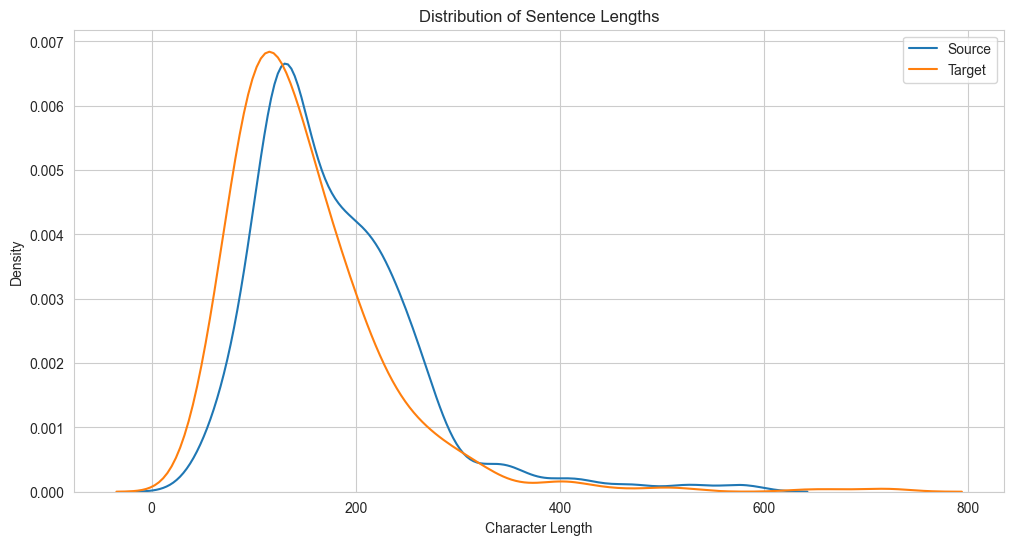

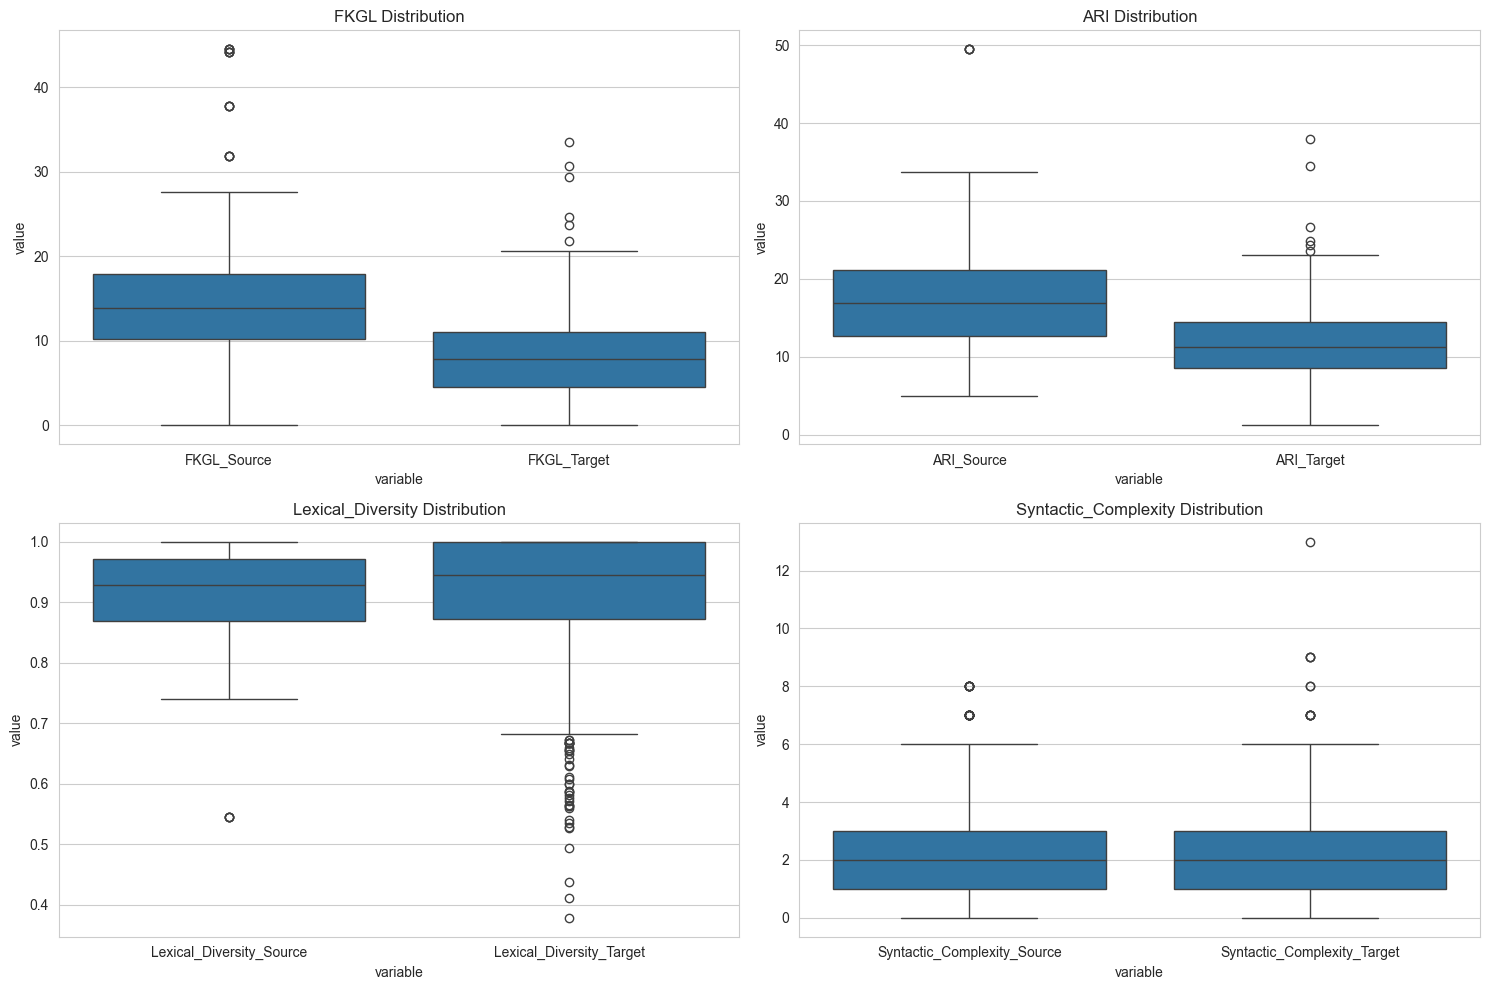

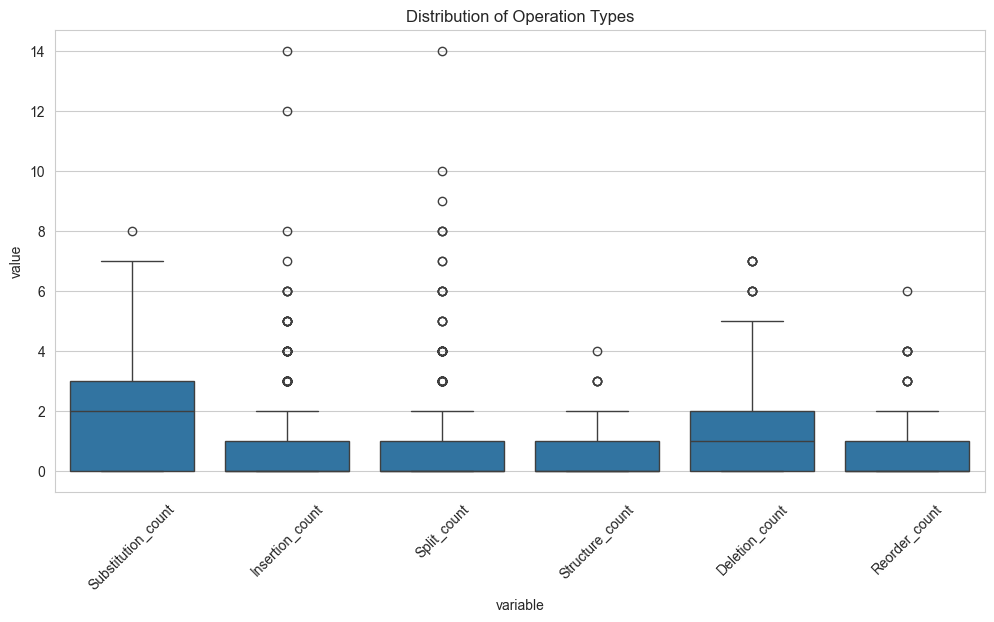

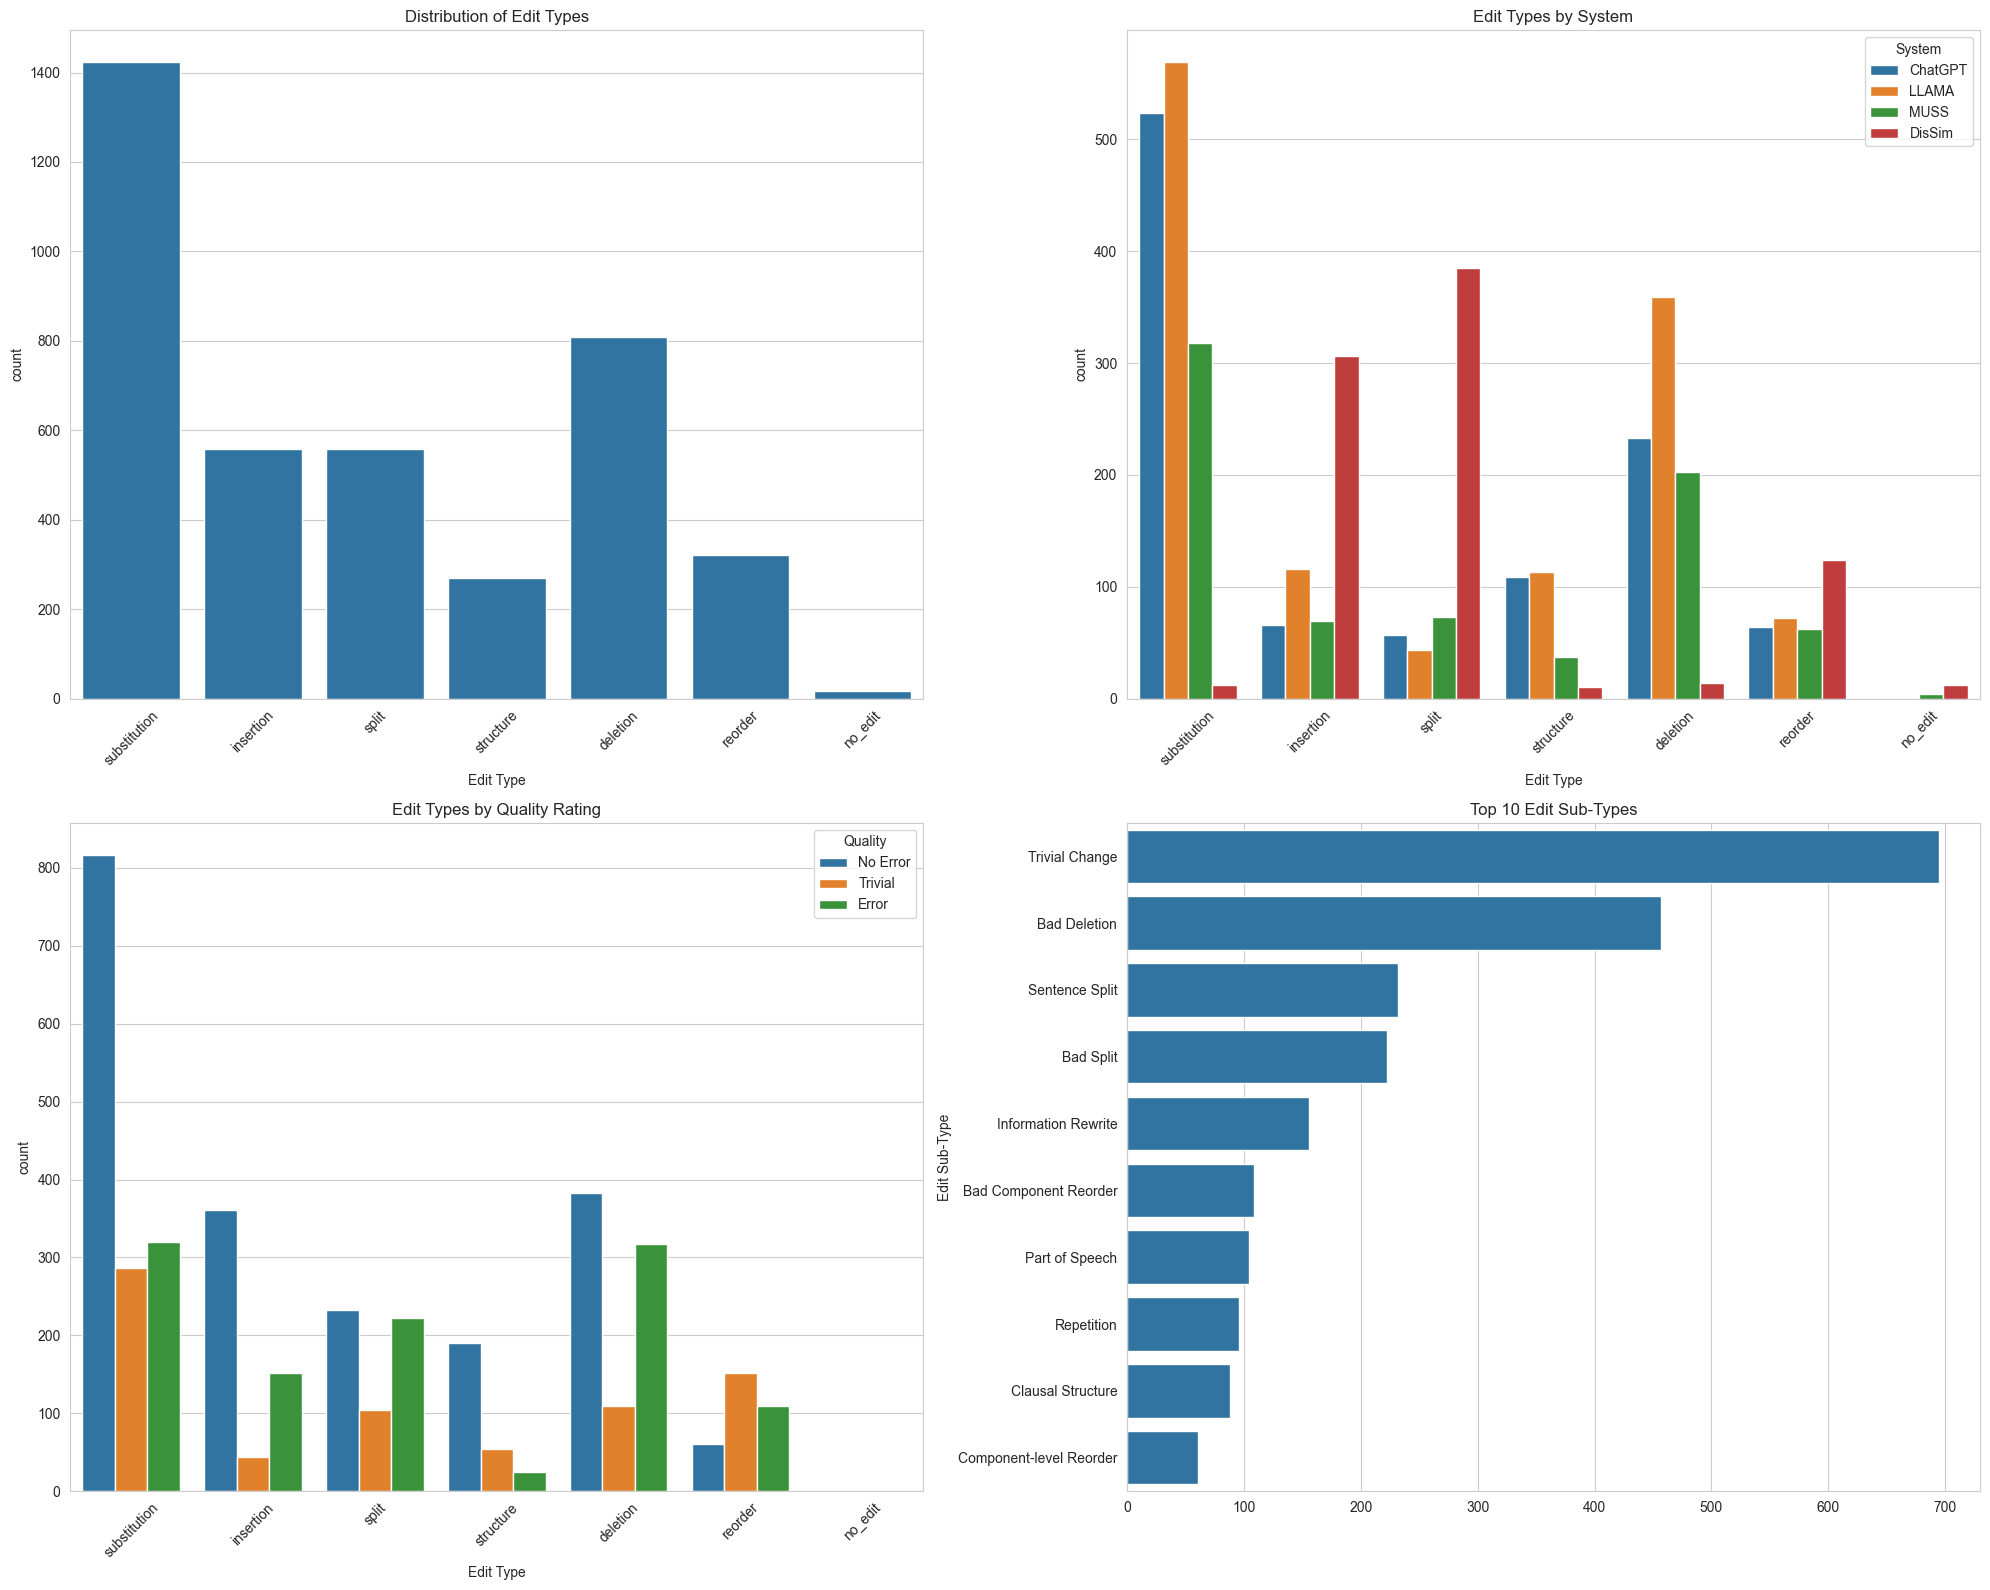

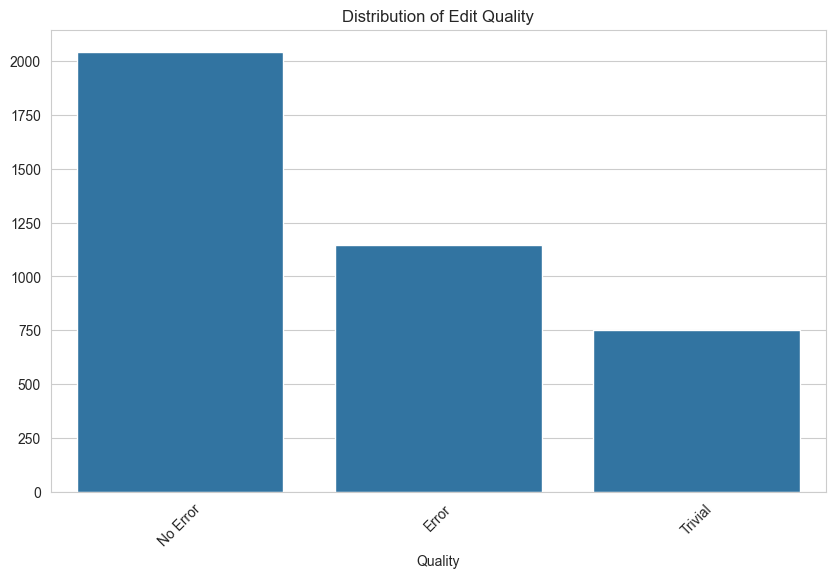

In [344]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

def plot_sentence_lengths(df_sentences):
    """Plot distribution of source vs target sentence lengths"""
    # Calculate lengths
    df_sentences['source_len'] = df_sentences['Source'].str.len()
    df_sentences['target_len'] = df_sentences['Target'].str.len()
    
    # Create distribution plot
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df_sentences, x='source_len', label='Source')
    sns.kdeplot(data=df_sentences, x='target_len', label='Target')
    plt.title('Distribution of Sentence Lengths')
    plt.xlabel('Character Length')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_complexity_metrics(df_sentences):
    """Plot distributions of complexity metrics"""
    metrics = ['FKGL', 'ARI', 'Lexical_Diversity', 'Syntactic_Complexity']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        source_col = f'{metric}_Source'
        target_col = f'{metric}_Target'
        
        sns.boxplot(data=pd.melt(df_sentences[[source_col, target_col]]), 
                   x='variable', y='value', ax=axes[idx])
        axes[idx].set_title(f'{metric} Distribution')
    plt.tight_layout()
    plt.show()

def plot_operation_distributions(df_sentences):
    """Plot distribution of operation types PER SENTENCE"""
    operations = ['Substitution_count', 'Insertion_count', 'Split_count',
                 'Structure_count', 'Deletion_count', 'Reorder_count']
    
    plt.figure(figsize=(12, 6))
    df_melted = pd.melt(df_sentences[operations])
    sns.boxplot(data=df_melted, x='variable', y='value')
    plt.xticks(rotation=45)
    plt.title('Distribution of Operation Types')
    plt.show()

def plot_edit_distributions(df_edits):
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Edit Types Distribution
    sns.countplot(data=df_edits, x='Edit Type', ax=ax1)
    ax1.set_title('Distribution of Edit Types')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Edit Types by System
    sns.countplot(data=df_edits, x='Edit Type', hue='System', ax=ax2)
    ax2.set_title('Edit Types by System')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Edit Types by Quality
    sns.countplot(data=df_edits, x='Edit Type', hue='Quality', ax=ax3)
    ax3.set_title('Edit Types by Quality Rating')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Edit Sub-Types Distribution
    top_subtypes = df_edits['Edit Sub-Type'].value_counts().head(10)
    sns.barplot(x=top_subtypes.values, y=top_subtypes.index, ax=ax4)
    ax4.set_title('Top 10 Edit Sub-Types')
    
    plt.tight_layout()
    plt.show()

def plot_quality_distributions(df_edits):
    """Plot distribution of quality scores"""
    plt.figure(figsize=(10, 6))
    quality_counts = df_edits['Quality'].value_counts()
    sns.barplot(x=quality_counts.index, y=quality_counts.values)
    plt.title('Distribution of Edit Quality')
    plt.xticks(rotation=45)
    plt.show()

# Execute all visualizations
def create_all_plots(df_sentences, df_edits):
    plot_sentence_lengths(df_sentences)
    plot_complexity_metrics(df_sentences)
    plot_operation_distributions(df_sentences)
    plot_edit_distributions(df_edits)
    plot_quality_distributions(df_edits)

# Usage
create_all_plots(df_sentences, df_edits)

### Basic Statistical Summaries

In [345]:
# datasets
datasets = df_sentences['Dataset'].unique()
print(datasets)

# systems
systems = df_sentences['System'].unique()
print(systems)

['wikiEN' 'cochrane' 'scotus' 'wikiDE']
['ChatGPT' 'LLAMA' 'MUSS' 'DisSim']



Number of edits per System-Dataset combination:
Dataset  cochrane  scotus  wikiDE  wikiEN
System                                   
ChatGPT    270.00  298.00  272.00  213.00
DisSim     288.00  281.00     NaN  294.00
LLAMA      302.00  299.00  393.00  278.00
MUSS       182.00  206.00  158.00  220.00


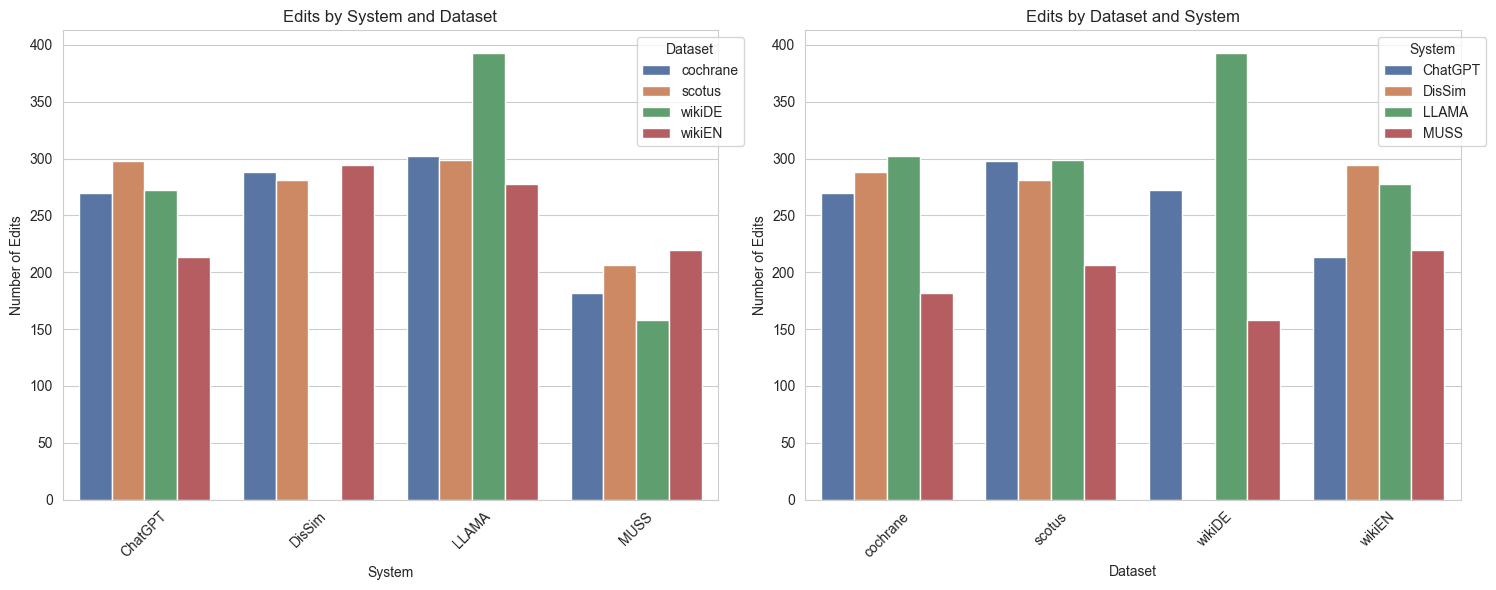

In [346]:
# 1. Overall counts per System-Dataset combination
sample_sizes = df_edits.groupby(['System', 'Dataset']).size().unstack()
print("\nNumber of edits per System-Dataset combination:")
print(sample_sizes)

# show the number of edits per system and dataset with seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Data preparation
counts_df = df_edits.groupby(['System', 'Dataset']).size().reset_index(name='count')

# Left subplot - Systems on x-axis
sns.barplot(
    data=counts_df,
    x='System',
    y='count',
    hue='Dataset',
    palette='deep',
    ax=ax1
)
ax1.set_title('Edits by System and Dataset')
ax1.set_xlabel('System')
ax1.set_ylabel('Number of Edits')
ax1.tick_params(axis='x', rotation=45)

# Right subplot - Datasets on x-axis
sns.barplot(
    data=counts_df,
    x='Dataset',
    y='count',
    hue='System',
    palette='deep',
    ax=ax2
)
ax2.set_title('Edits by Dataset and System')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Number of Edits')
ax2.tick_params(axis='x', rotation=45)

# Adjust legends and layout
ax1.legend(title='Dataset', bbox_to_anchor=(1.05, 1))
ax2.legend(title='System', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### Overview Table of Key Stats

In [347]:
# General descriptive statistics - no dataset subdivision
grouped = df_sentences.groupby(['System'])

desc_stats_02 = grouped.agg({
    'Total Edits': ['mean', 'std'],
    'FKGL_Difference': ['mean', 'std'],
    'ARI_Difference': ['mean', 'std'],
    'Lexical_Diversity_Difference': ['mean', 'std'],
    'Syntactic_Complexity_Difference': ['mean', 'std'],
    'BERTScore_Precision': ['mean', 'std'],
    'BERTScore_Recall': ['mean', 'std'],
    'BERTScore_F1': ['mean', 'std'],
    'GLEU': ['mean', 'std'],
    'LENS_SALSA': ['mean', 'std']

})

display(desc_stats_02)

Total Edits      FKGL_Difference      ARI_Difference       \
               mean  std            mean  std           mean  std   
System                                                              
ChatGPT        5.26 2.66           -5.01 5.31          -4.29 5.52   
DisSim         5.67 4.75           -9.36 7.06          -7.14 5.65   
LLAMA          6.36 2.80           -6.07 6.24          -5.92 6.44   
MUSS           3.81 1.92           -4.85 4.45          -4.70 4.60   

        Lexical_Diversity_Difference      Syntactic_Complexity_Difference  \
                                mean  std                            mean   
System                                                                      
ChatGPT                         0.02 0.05                           -0.01   
DisSim                         -0.11 0.12                            0.34   
LLAMA                           0.05 0.07                           -0.26   
MUSS                            0.01 0.05                           -0.16   

             BERTScore_Precision      BERTScore_Recall      BERTScore_F1       \
         std                mean  std             mean  std         mean  std   
System                                                                          
ChatGPT 1.21                0.94 0.04             0.92 0.05         0.93 0.04   
DisSim  0.85                0.94 0.03             0.96 0.02         0.95 0.02   
LLAMA   1.48                0.91 0.06             0.87 0.07         0.89 0.06   
MUSS    1.10                0.96 0.04             0.93 0.06         0.94 0.05   

        GLEU      LENS_SALSA        
        mean  std       mean   std  
System                              
ChatGPT 0.36 0.16      72.03  6.25  
DisSim  0.54 0.17      52.29 11.72  
LLAMA   0.18 0.13      74.14  7.50  
MUSS    0.52 0.17      67.77  7.69

In [348]:
# General descriptive statistics
grouped = df_sentences.groupby(['System', 'Dataset'])

desc_stats = grouped.agg({
    'Total Edits': ['mean', 'std'],
    'FKGL_Difference': ['mean', 'std'],
    'ARI_Difference': ['mean', 'std'],
    'Lexical_Diversity_Difference': ['mean', 'std'],
    'Syntactic_Complexity_Difference': ['mean', 'std'],
    'BERTScore_Precision': ['mean', 'std'],
    'BERTScore_Recall': ['mean', 'std'],
    'BERTScore_F1': ['mean', 'std'],
    'GLEU': ['mean', 'std'],
    'LENS_SALSA': ['mean', 'std']

})

print(desc_stats)

display(desc_stats.T)


                 Total Edits      FKGL_Difference      ARI_Difference       \
                        mean  std            mean  std           mean  std   
System  Dataset                                                              
ChatGPT cochrane        5.40 3.00           -5.78 6.76          -2.51 6.11   
        scotus          5.96 2.92           -4.92 4.96          -5.93 5.61   
        wikiDE          5.44 2.28           -4.57 4.32          -4.17 4.91   
        wikiEN          4.26 2.08           -4.78 4.98          -4.55 4.97   
DisSim  cochrane        5.62 5.54           -9.78 8.60          -5.02 3.98   
        scotus          5.54 4.85           -9.52 7.26          -8.82 6.97   
        wikiEN          5.86 3.80           -8.76 4.93          -7.58 5.01   
LLAMA   cochrane        6.04 2.44           -6.16 6.52          -3.52 6.13   
        scotus          5.98 2.34           -6.30 7.54          -7.91 7.32   
        wikiDE          7.86 3.25           -6.14 5.48          

System                                ChatGPT                        DisSim  \
Dataset                              cochrane scotus wikiDE wikiEN cochrane   
Total Edits                     mean     5.40   5.96   5.44   4.26     5.62   
                                std      3.00   2.92   2.28   2.08     5.54   
FKGL_Difference                 mean    -5.78  -4.92  -4.57  -4.78    -9.78   
                                std      6.76   4.96   4.32   4.98     8.60   
ARI_Difference                  mean    -2.51  -5.93  -4.17  -4.55    -5.02   
                                std      6.11   5.61   4.91   4.97     3.98   
Lexical_Diversity_Difference    mean     0.02   0.03   0.00   0.04    -0.13   
                                std      0.06   0.04   0.05   0.05     0.12   
Syntactic_Complexity_Difference mean     0.24  -0.32  -0.16   0.22     0.48   
                                std      1.19   1.02   1.43   1.09     0.91   
BERTScore_Precision             mean     0.95   0.95   0.90   0.97     0.95   
                                std      0.02   0.02   0.04   0.01     0.03   
BERTScore_Recall                mean     0.92   0.92   0.87   0.96     0.96   
                                std      0.05   0.03   0.05   0.02     0.02   
BERTScore_F1                    mean     0.94   0.94   0.88   0.97     0.95   
                                std      0.03   0.02   0.04   0.01     0.03   
GLEU                            mean     0.30   0.31   0.37   0.43     0.59   
                                std      0.17   0.14   0.13   0.15     0.21   
LENS_SALSA                      mean    71.54  70.88    NaN  73.68    55.25   
                                std      6.86   5.81    NaN   5.79     8.43   

System                                                LLAMA                \
Dataset                              scotus wikiEN cochrane scotus wikiDE   
Total Edits                     mean   5.54   5.86     6.04   5.98   7.86   
                                std    4.85   3.80     2.44   2.34   3.25   
FKGL_Difference                 mean  -9.52  -8.76    -6.16  -6.30  -6.14   
                                std    7.26   4.93     6.52   7.54   5.48   
ARI_Difference                  mean  -8.82  -7.58    -3.52  -7.91  -6.38   
                                std    6.97   5.01     6.13   7.32   6.09   
Lexical_Diversity_Difference    mean  -0.08  -0.14     0.04   0.06   0.03   
                                std    0.10   0.12     0.09   0.06   0.05   
Syntactic_Complexity_Difference mean   0.24   0.30     0.40  -0.86  -0.48   
                                std    0.92   0.71     1.37   1.73   1.47   
BERTScore_Precision             mean   0.93   0.94     0.93   0.93   0.82   
                                std    0.03   0.02     0.02   0.02   0.06   
BERTScore_Recall                mean   0.95   0.96     0.88   0.89   0.79   
                                std    0.02   0.01     0.05   0.04   0.06   
BERTScore_F1                    mean   0.94   0.95     0.91   0.91   0.80   
                                std    0.02   0.02     0.03   0.03   0.05   
GLEU                            mean   0.53   0.51     0.15   0.14   0.19   
                                std    0.16   0.14     0.12   0.10   0.13   
LENS_SALSA                      mean  46.10  55.52    75.19  73.26    NaN   
                                std   13.76   9.93     7.71   8.06    NaN   

System                                          MUSS                       
Dataset                              wikiEN cochrane scotus wikiDE wikiEN  
Total Edits                     mean   5.56     3.64   4.12   3.08   4.40  
                                std    2.56     1.41   2.19   2.21   1.53  
FKGL_Difference                 mean  -5.70    -4.01  -3.41  -4.92  -7.04  
                                std    5.34     3.75   4.83   4.31   4.10  
ARI_Difference                  mean  -5.89    -2.54  -4.51  -5.11  -6.65  
                                st

System_  Dataset_  Total Edits_mean  Total Edits_std  \
0   ChatGPT  cochrane              5.40             3.00   
1   ChatGPT    scotus              5.96             2.92   
2   ChatGPT    wikiDE              5.44             2.28   
3   ChatGPT    wikiEN              4.26             2.08   
4    DisSim  cochrane              5.62             5.54   
5    DisSim    scotus              5.54             4.85   
6    DisSim    wikiEN              5.86             3.80   
7     LLAMA  cochrane              6.04             2.44   
8     LLAMA    scotus              5.98             2.34   
9     LLAMA    wikiDE              7.86             3.25   
10    LLAMA    wikiEN              5.56             2.56   
11     MUSS  cochrane              3.64             1.41   
12     MUSS    scotus              4.12             2.19   
13     MUSS    wikiDE              3.08             2.21   
14     MUSS    wikiEN              4.40             1.53   

    FKGL_Difference_mean  FKGL_Difference_std  ARI_Difference_mean  \
0                  -5.78                 6.76                -2.51   
1                  -4.92                 4.96                -5.93   
2                  -4.57                 4.32                -4.17   
3                  -4.78                 4.98                -4.55   
4                  -9.78                 8.60                -5.02   
5                  -9.52                 7.26                -8.82   
6                  -8.76                 4.93                -7.58   
7                  -6.16                 6.52                -3.52   
8                  -6.30                 7.54                -7.91   
9                  -6.14                 5.48                -6.38   
10                 -5.70                 5.34                -5.89   
11                 -4.01                 3.75                -2.54   
12                 -3.41                 4.83                -4.51   
13                 -4.92                 4.31                -5.11   
14                 -7.04                 4.10                -6.65   

    ARI_Difference_std  Lexical_Diversity_Difference_mean  \
0                 6.11                               0.02   
1                 5.61                               0.03   
2                 4.91                               0.00   
3                 4.97                               0.04   
4                 3.98                              -0.13   
5                 6.97                              -0.08   
6                 5.01                              -0.14   
7                 6.13                               0.04   
8                 7.32                               0.06   
9                 6.09                               0.03   
10                5.48                               0.07   
11                3.80                               0.02   
12                4.22                              -0.00   
13                5.11                               0.02   
14                4.34                               0.01   

    Lexical_Diversity_Difference_std  ...  BERTScore_Precision_mean  \
0                               0.06  ...                      0.95   
1                               0.04  ...                      0.95   
2                               0.05  ...                      0.90   
3                               0.05  ...                      0.97   
4                               0.12  ...                      0.95   
5                               0.10  ...                      0.93   
6                               0.12  ...                      0.94   
7                               0.09  ...                      0.93   
8                               0.06  ...                      0.93   
9                               0.05  ...                      0.82   
10                              0.06  ...                      0.95   
11                              0.05  ...                      0.97   
12                    

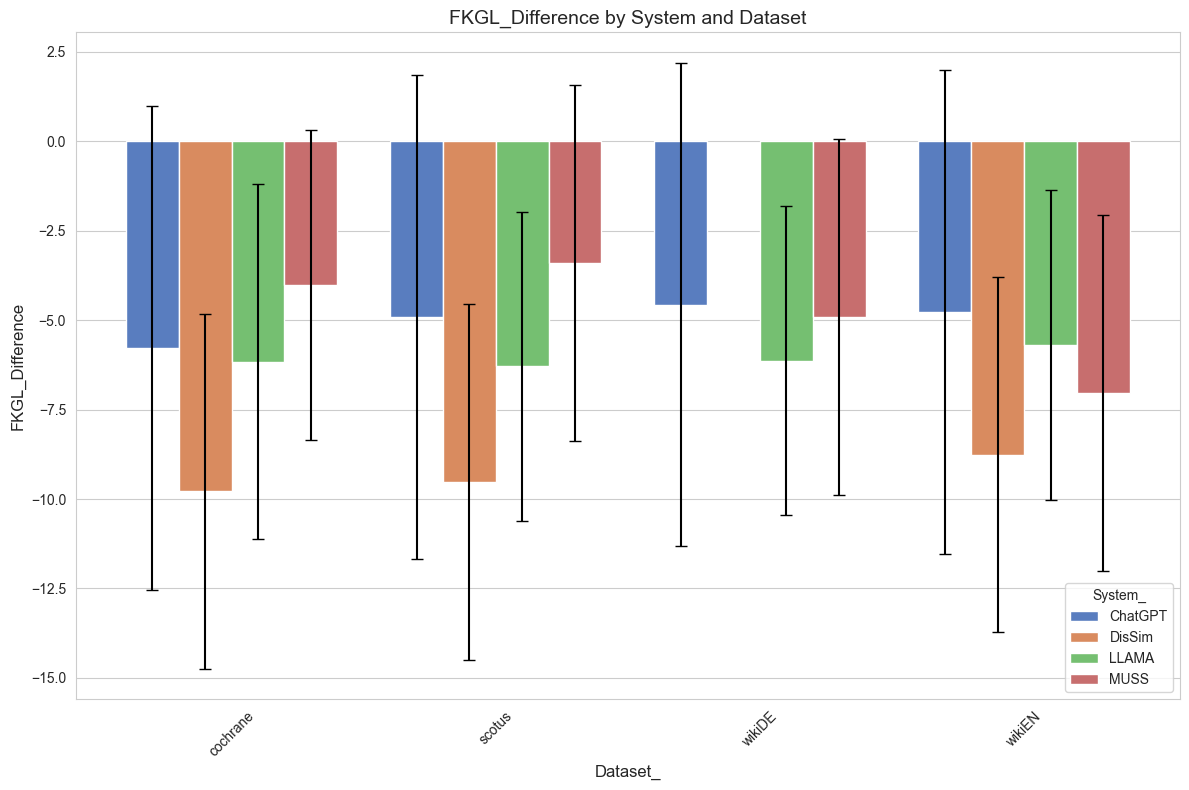

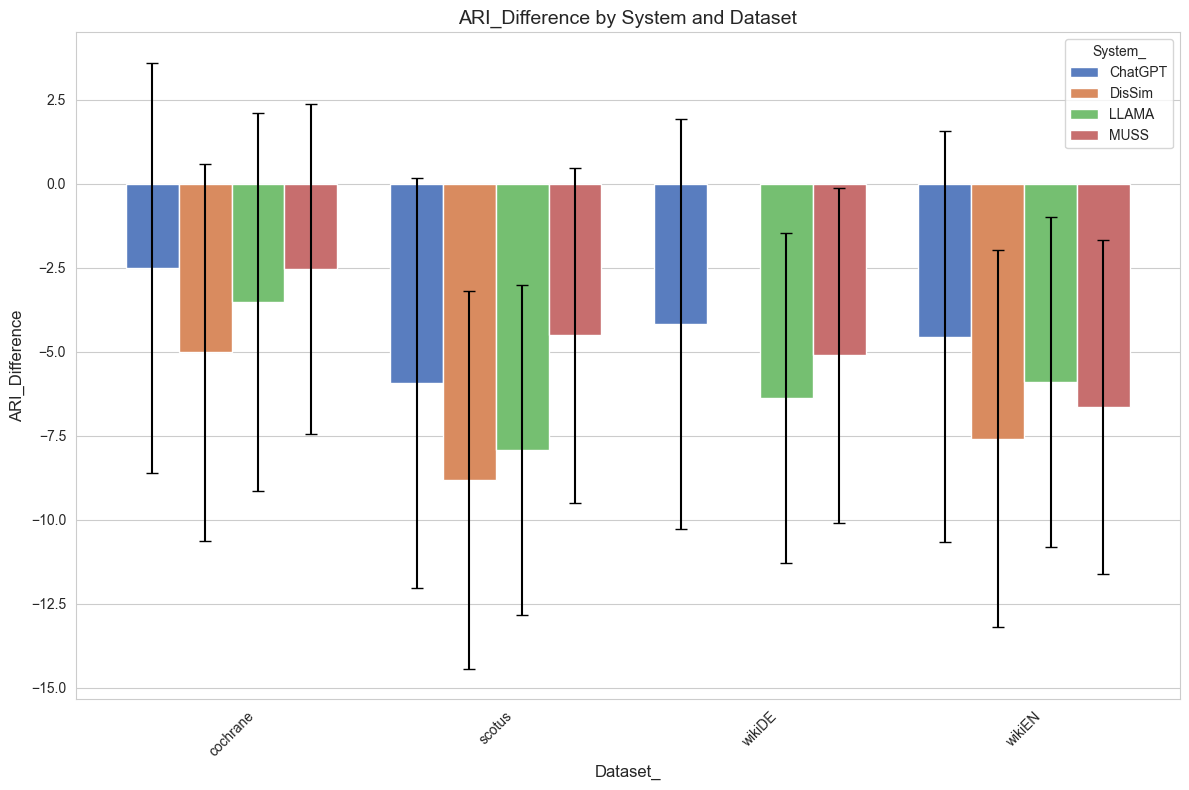

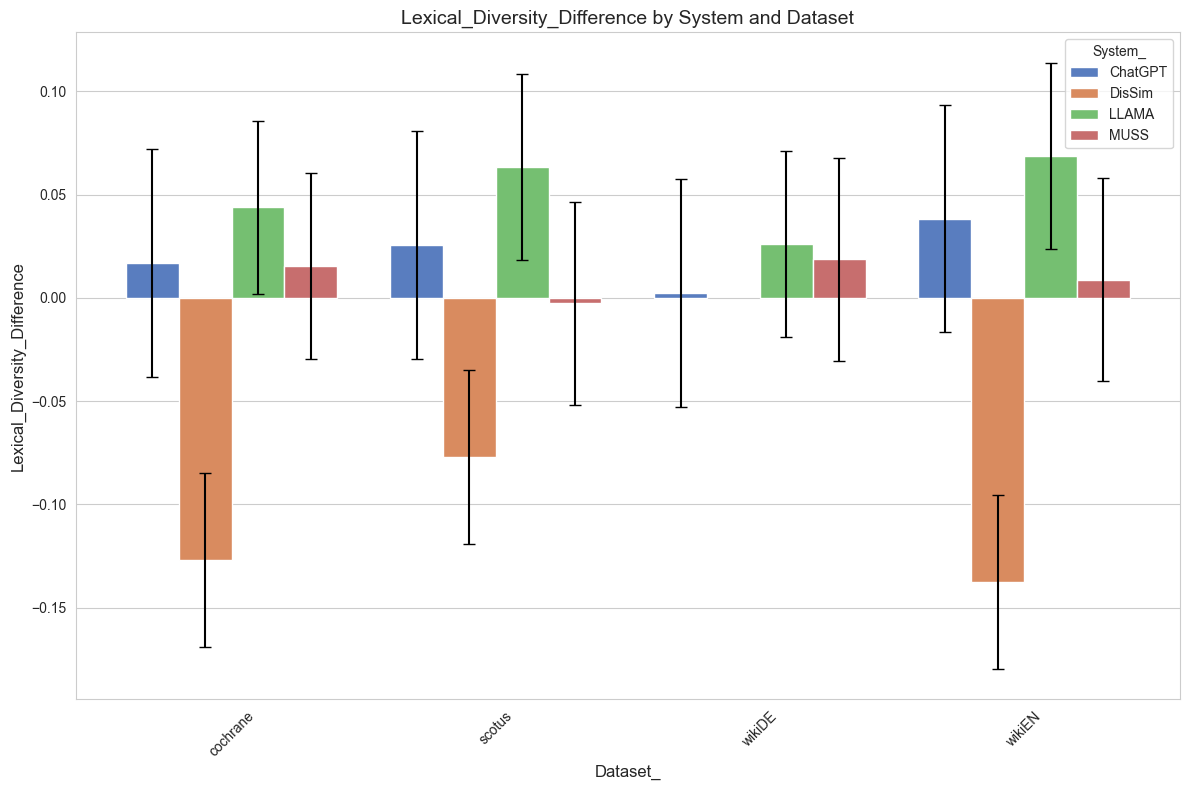

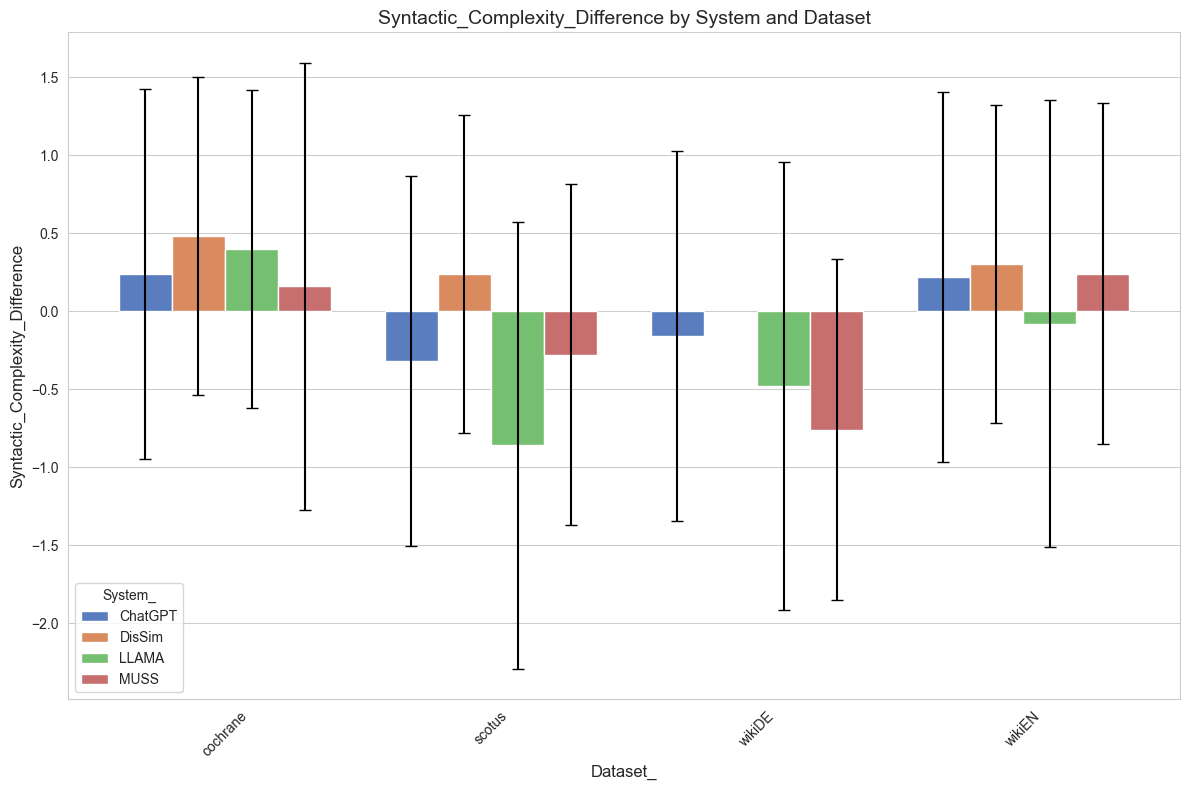

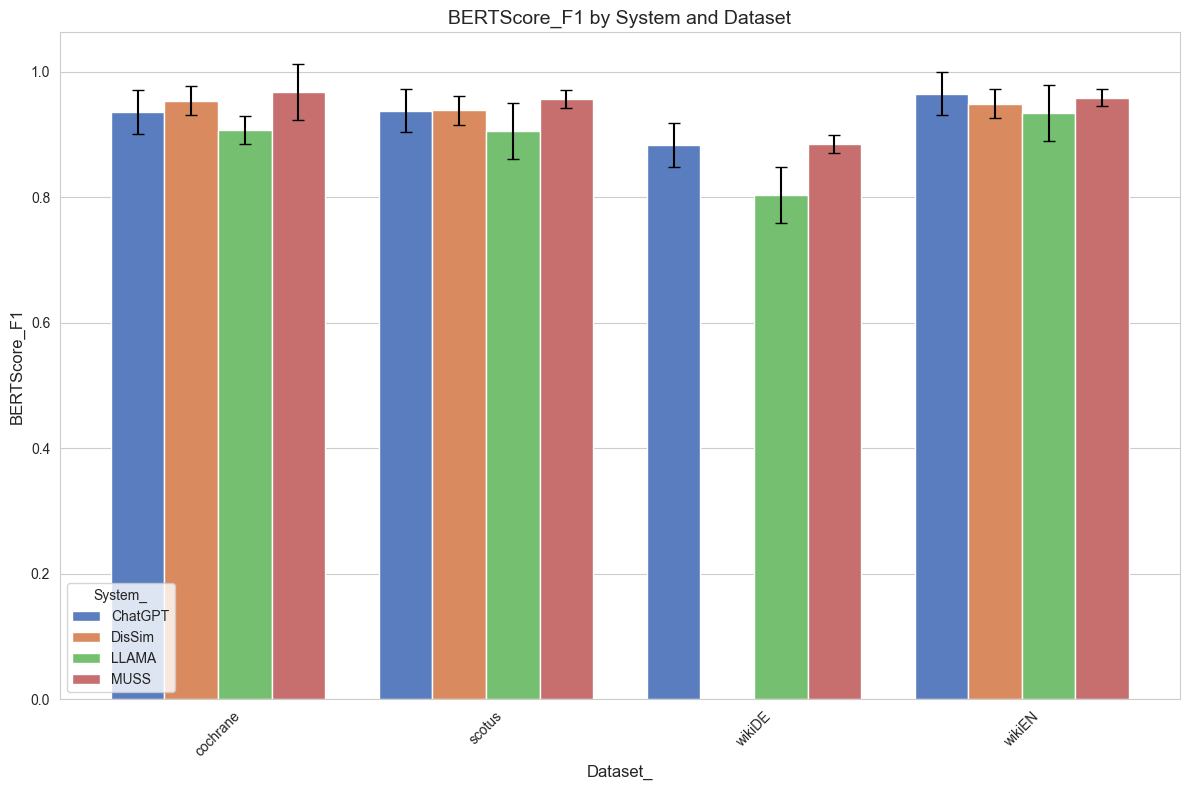

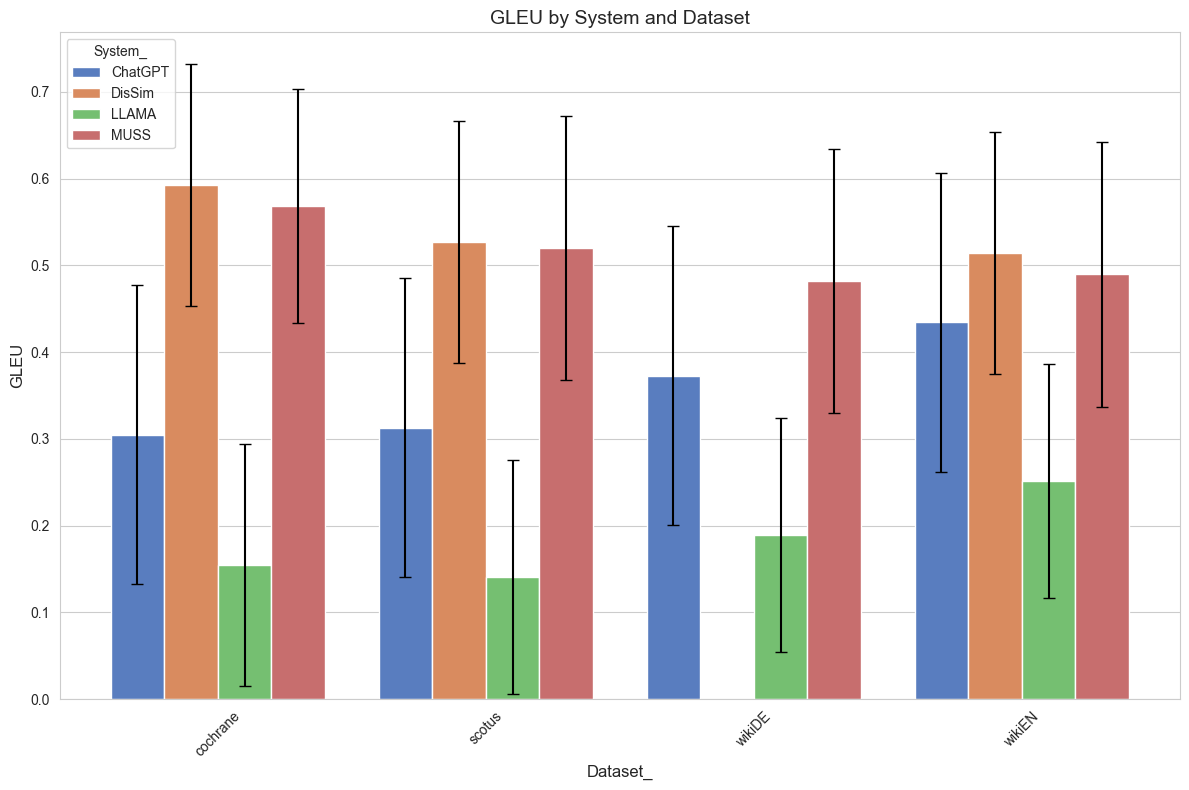

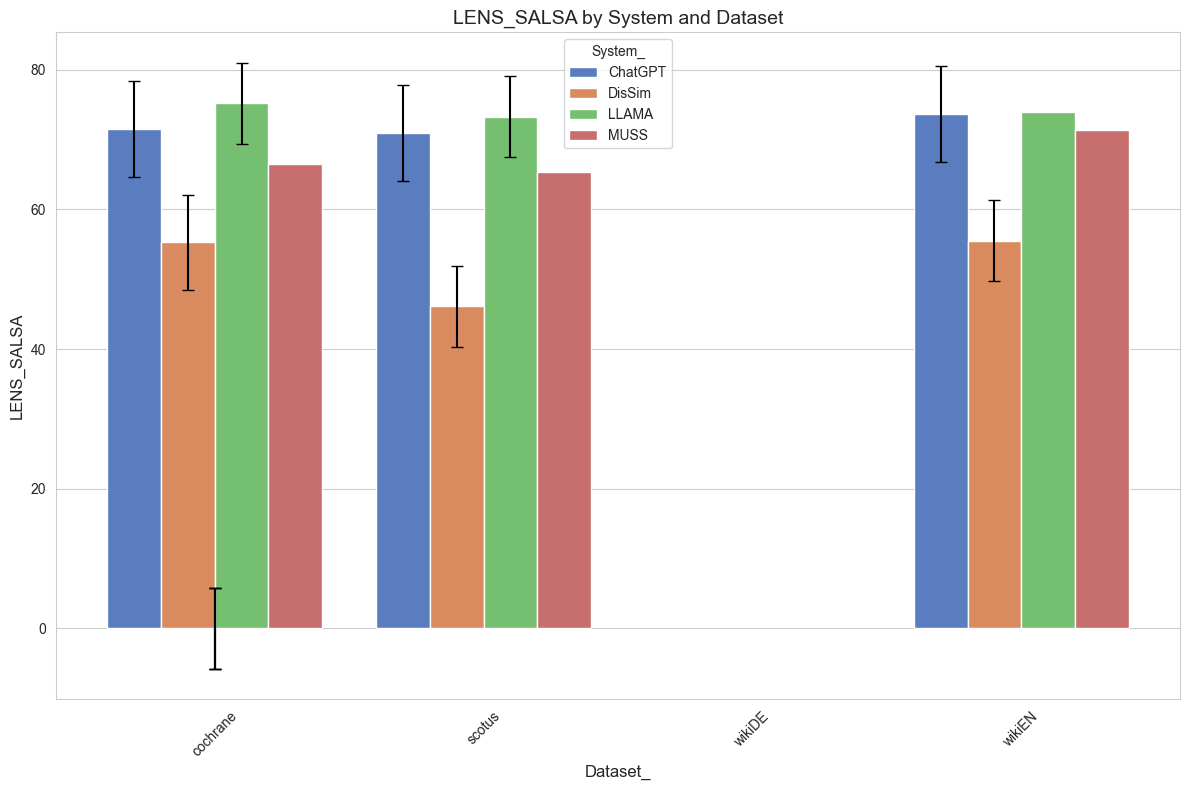

In [349]:
#  plot grouped bar plots with error bars
desc_stats_flat = desc_stats.reset_index()
# Flatten the multi-level column index
desc_stats_flat.columns = ['_'.join(col).strip() for col in desc_stats_flat.columns.values]

display(desc_stats_flat)

def plot_grouped_stats(data, metric, y_label, title):
    plt.figure(figsize=(12, 8))
    # Create the barplot
    ax = sns.barplot(
        data=data,
        x="Dataset_",
        y=f"{metric}_mean",
        hue="System_",
        palette="muted",
        errorbar=None
    )
    
    # Add error bars
    for i, bar in enumerate(ax.patches):
        # Determine the bar's x position
        x = bar.get_x() + bar.get_width() / 2
        # Determine the correct std value
        if i < len(data):  # Avoid index error
            yerr = data.iloc[i // len(data['System_'].unique())][f"{metric}_std"]
            plt.errorbar(
                x=x,
                y=bar.get_height(),
                yerr=yerr,
                fmt='none',
                capsize=4,
                color='black'
            )
    
    plt.title(title, fontsize=14)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel("Dataset_", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="System_")
    plt.tight_layout()
    plt.show()

metrics_to_viz = [
    'FKGL_Difference',
    'ARI_Difference',
    'Lexical_Diversity_Difference',
    'Syntactic_Complexity_Difference',
    'BERTScore_F1',
    'GLEU',
    'LENS_SALSA'
]

for metric in metrics_to_viz:
    plot_grouped_stats(
        data=desc_stats_flat,
        metric=metric,
        y_label=metric,
        title=f"{metric} by System and Dataset"
    )

In [350]:
# Count operation types for each System-Dataset combination in regard to Information Impact
op_freq_infImpact = df_edits.groupby(['System', 'Information Impact']).size().unstack(fill_value=0)

display(op_freq_infImpact)
print(op_freq_infImpact)

Information Impact  Elaboration  Generalization  Same Information
System                                                           
ChatGPT                      66             233               754
DisSim                      306              14               531
LLAMA                       116             359               797
MUSS                         69             203               490

Information Impact  Elaboration  Generalization  Same Information
System                                                           
ChatGPT                      66             233               754
DisSim                      306              14               531
LLAMA                       116             359               797
MUSS                         69             203               490


<Axes: xlabel='System'>

<Figure size 1200x600 with 0 Axes>

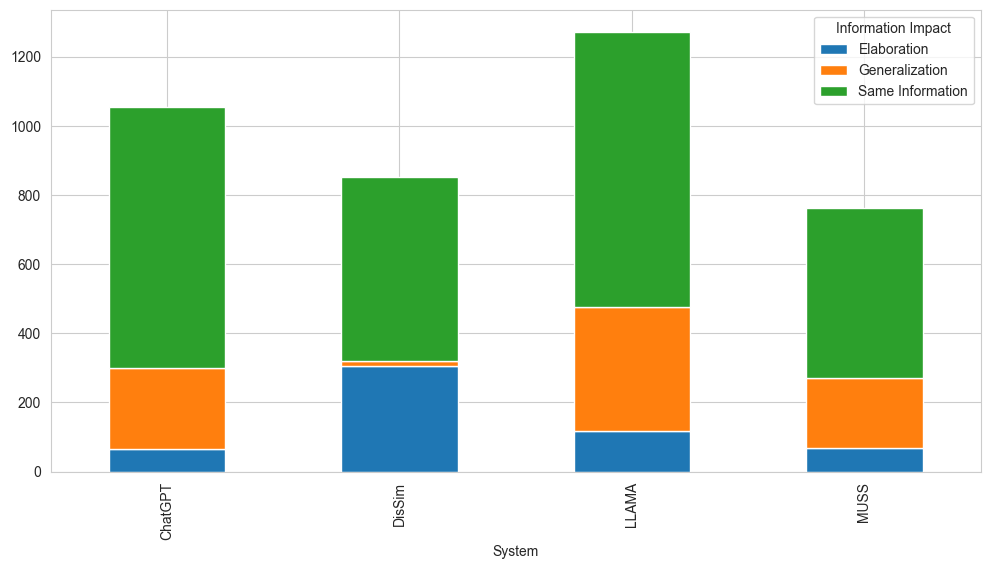

In [351]:
# visualize with bar chart
plt.figure(figsize=(12, 6))
op_freq_infImpact.plot(kind='bar', stacked=True)

In [352]:
# chi2 test on op_freq_infImpact

chi2_results = run_chi2_test(op_freq_infImpact)

--- Chi-square test results: ---
Chi-square statistic: 577.6513
Degrees of freedom: 6
p-value: 0.0000
Cramer's V: 0.2708
Sample size: 3938

APA Format: χ²(6, N = 3938) = 577.65, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Information Impact  Elaboration  Generalization  Same Information
System                                                           
ChatGPT                      66             233               754
DisSim                      306              14               531
LLAMA                       116             359               797
MUSS                         69             203               490
Bonferroni-adjusted significance level: 0.0083
ChatGPT vs DisSim: chi2 = 370.4514, p-value = 0.0000

*** The result is statistically significant. ***
ChatGPT vs LLAMA: chi2 = 21.3066, p-value = 0.0000

*** The result is statistically significant. ***
ChatGPT vs MUSS: chi2 = 11

#### Overview Table of Edit Types

In [353]:
# Count operation types for each System-Dataset combination

cols_of_interest = ['Edit Type', 'Quality', 'Family', 'Significance']
for col in cols_of_interest:
    print(f"\n\n\n{col}")
    op_freq = df_edits.groupby(['System', 'Dataset', col]).size().unstack(fill_value=0)
    display(op_freq)
    print(op_freq)





Edit Type


Edit Type         deletion  insertion  no_edit  reorder  split  structure  \
System  Dataset                                                             
ChatGPT cochrane        74         29        0       11      9         28   
        scotus          65         15        0       10     12         17   
        wikiDE          66         13        0       34     17         30   
        wikiEN          28          9        0        9     19         34   
DisSim  cochrane         2        113        7       36    124          0   
        scotus           8         91        4       45    130          0   
        wikiEN           4        102        1       43    131         10   
LLAMA   cochrane        91         22        0       13      2         27   
        scotus          90         15        0        7      3         17   
        wikiDE          94         62        0       36     30         37   
        wikiEN          84         17        0       16      8         32   
MUSS    cochrane        59          8        0       28     10          1   
        scotus          46         20        0       12     11         10   
        wikiDE          68         22        4       16     13          5   
        wikiEN          30         19        0        6     39         21   

Edit Type         substitution  
System  Dataset                 
ChatGPT cochrane           119  
        scotus             179  
        wikiDE             112  
        wikiEN             114  
DisSim  cochrane             6  
        scotus               3  
        wikiEN               3  
LLAMA   cochrane           147  
        scotus             167  
        wikiDE             134  
        wikiEN             121  
MUSS    cochrane            76  
        scotus             107  
        wikiDE              30  
        wikiEN             105

Edit Type         deletion  insertion  no_edit  reorder  split  structure  \
System  Dataset                                                             
ChatGPT cochrane        74         29        0       11      9         28   
        scotus          65         15        0       10     12         17   
        wikiDE          66         13        0       34     17         30   
        wikiEN          28          9        0        9     19         34   
DisSim  cochrane         2        113        7       36    124          0   
        scotus           8         91        4       45    130          0   
        wikiEN           4        102        1       43    131         10   
LLAMA   cochrane        91         22        0       13      2         27   
        scotus          90         15        0        7      3         17   
        wikiDE          94         62        0       36     30         37   
        wikiEN          84         17        0       16      8         32   

Quality           Error  No Error  Trivial
System  Dataset                           
ChatGPT cochrane     33       196       41
        scotus       23       223       52
        wikiDE       23       160       89
        wikiEN       30       146       37
DisSim  cochrane    183        62       36
        scotus      137        82       58
        wikiEN      125       119       49
LLAMA   cochrane     71       188       43
        scotus       82       171       46
        wikiDE       87       208       98
        wikiEN      105       118       55
MUSS    cochrane     55        87       40
        scotus       54       109       43
        wikiDE       71        52       31
        wikiEN       66       123       31

Quality           Error  No Error  Trivial
System  Dataset                           
ChatGPT cochrane     33       196       41
        scotus       23       223       52
        wikiDE       23       160       89
        wikiEN       30       146       37
DisSim  cochrane    183        62       36
        scotus      137        82       58
        wikiEN      125       119       49
LLAMA   cochrane     71       188       43
        scotus       82       171       46
        wikiDE       87       208       98
        wikiEN      105       118       55
MUSS    cochrane     55        87       40
        scotus       54       109       43
        wikiDE       71        52       31
        wikiEN       66       123       31



Family


Family            Conceptual  Lexical  Syntax
System  Dataset                              
ChatGPT cochrane         186       36      48
        scotus           220       39      39
        wikiDE           129       62      81
        wikiEN           127       24      62
DisSim  cochrane         111       10     160
        scotus            90       12     175
        wikiEN           108        1     184
LLAMA   cochrane         227       33      42
        scotus           234       38      27
        wikiDE           230       60     103
        wikiEN           184       38      56
MUSS    cochrane         121       22      39
        scotus           144       29      33
        wikiDE           108       12      34
        wikiEN           131       23      66

Family            Conceptual  Lexical  Syntax
System  Dataset                              
ChatGPT cochrane         186       36      48
        scotus           220       39      39
        wikiDE           129       62      81
        wikiEN           127       24      62
DisSim  cochrane         111       10     160
        scotus            90       12     175
        wikiEN           108        1     184
LLAMA   cochrane         227       33      42
        scotus           234       38      27
        wikiDE           230       60     103
        wikiEN           184       38      56
MUSS    cochrane         121       22      39
        scotus           144       29      33
        wikiDE           108       12      34
        wikiEN           131       23      66



Significance


Significance       0    1   2   3
System  Dataset                  
ChatGPT cochrane  41  159  62   8
        scotus    52  184  58   4
        wikiDE    89  133  44   6
        wikiEN    37  143  31   2
DisSim  cochrane  36  163  77  12
        scotus    58  154  65   4
        wikiEN    49  187  49   9
LLAMA   cochrane  43  158  86  15
        scotus    46  150  89  14
        wikiDE    98  215  64  16
        wikiEN    55  159  49  15
MUSS    cochrane  40   90  38  14
        scotus    43  108  39  16
        wikiDE    31   67  37  23
        wikiEN    31  128  48  13

Significance       0    1   2   3
System  Dataset                  
ChatGPT cochrane  41  159  62   8
        scotus    52  184  58   4
        wikiDE    89  133  44   6
        wikiEN    37  143  31   2
DisSim  cochrane  36  163  77  12
        scotus    58  154  65   4
        wikiEN    49  187  49   9
LLAMA   cochrane  43  158  86  15
        scotus    46  150  89  14
        wikiDE    98  215  64  16
        wikiEN    55  159  49  15
MUSS    cochrane  40   90  38  14
        scotus    43  108  39  16
        wikiDE    31   67  37  23
        wikiEN    31  128  48  13


In [354]:
# run chi2 test on family per system 
op_freq = df_edits.groupby(['System', 'Family']).size().unstack(fill_value=0)

chi2_results = run_chi2_test(op_freq)

--- Chi-square test results: ---
Chi-square statistic: 559.7138
Degrees of freedom: 6
p-value: 0.0000
Cramer's V: 0.2666
Sample size: 3938

APA Format: χ²(6, N = 3938) = 559.71, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Family   Conceptual  Lexical  Syntax
System                              
ChatGPT         662      161     230
DisSim          309       23     519
LLAMA           875      169     228
MUSS            504       86     172
Bonferroni-adjusted significance level: 0.0083
ChatGPT vs DisSim: chi2 = 325.5745, p-value = 0.0000

*** The result is statistically significant. ***
ChatGPT vs LLAMA: chi2 = 9.1736, p-value = 0.0102

The result is not statistically significant.
ChatGPT vs MUSS: chi2 = 6.0507, p-value = 0.0485

The result is not statistically significant.
DisSim vs LLAMA: chi2 = 428.3102, p-value = 0.0000

*** The result is statistically significant. ***
DisSim vs

In [355]:
# now to same for Significance
op_freq = df_edits.groupby(['System', 'Significance']).size().unstack(fill_value=0)
print(op_freq)

chi2_results = run_chi2_test(op_freq)

Significance    0    1    2   3
System                         
ChatGPT       219  619  195  20
DisSim        143  504  191  25
LLAMA         242  682  288  60
MUSS          145  393  162  66
--- Chi-square test results: ---
Chi-square statistic: 67.7067
Degrees of freedom: 9
p-value: 0.0000
Cramer's V: 0.0756
Sample size: 3954

APA Format: χ²(9, N = 3954) = 67.71, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Significance    0    1    2   3
System                         
ChatGPT       219  619  195  20
DisSim        143  504  191  25
LLAMA         242  682  288  60
MUSS          145  393  162  66
Bonferroni-adjusted significance level: 0.0083
ChatGPT vs DisSim: chi2 = 9.5822, p-value = 0.0225

The result is not statistically significant.
ChatGPT vs LLAMA: chi2 = 21.6689, p-value = 0.0001

*** The result is statistically significant. ***
ChatGPT vs MUSS: chi2 = 49.1093, p-value = 0.0

In [356]:
# Second type of table output: Total type per system

print(df_edits.groupby(['System', 'Edit Type']).size().unstack(fill_value=0))

print(df_edits.groupby(['System', 'Edit Sub-Type']).size().unstack(fill_value=0))

print(df_edits.groupby(['System', 'Edit Type', 'Quality']).size().unstack(fill_value=0))

Edit Type  deletion  insertion  no_edit  reorder  split  structure  \
System                                                               
ChatGPT         233         66        0       64     57        109   
DisSim           14        306       12      124    385         10   
LLAMA           359        116        0       72     43        113   
MUSS            203         69        4       62     73         37   

Edit Type  substitution  
System                   
ChatGPT             524  
DisSim               12  
LLAMA               569  
MUSS                318  
Edit Sub-Type  Bad Component Reorder  Bad Deletion  Bad Split  \
System                                                          
ChatGPT                            2            71          1   
DisSim                            89             4        217   
LLAMA                              8           240          1   
MUSS                              10           142          3   

Edit Sub-Type  Clausal Structure

In [357]:
# Examine error rates

error_rates = df_edits[df_edits['Quality'] == 'Error'].groupby(['System', 'Dataset']).size() / \
              df_edits.groupby(['System', 'Dataset']).size()

print("\nError Rates:")
error_rates


Error Rates:


System   Dataset 
ChatGPT  cochrane   0.12
         scotus     0.08
         wikiDE     0.08
         wikiEN     0.14
DisSim   cochrane   0.64
         scotus     0.49
         wikiEN     0.43
LLAMA    cochrane   0.24
         scotus     0.27
         wikiDE     0.22
         wikiEN     0.38
MUSS     cochrane   0.30
         scotus     0.26
         wikiDE     0.45
         wikiEN     0.30
dtype: float64

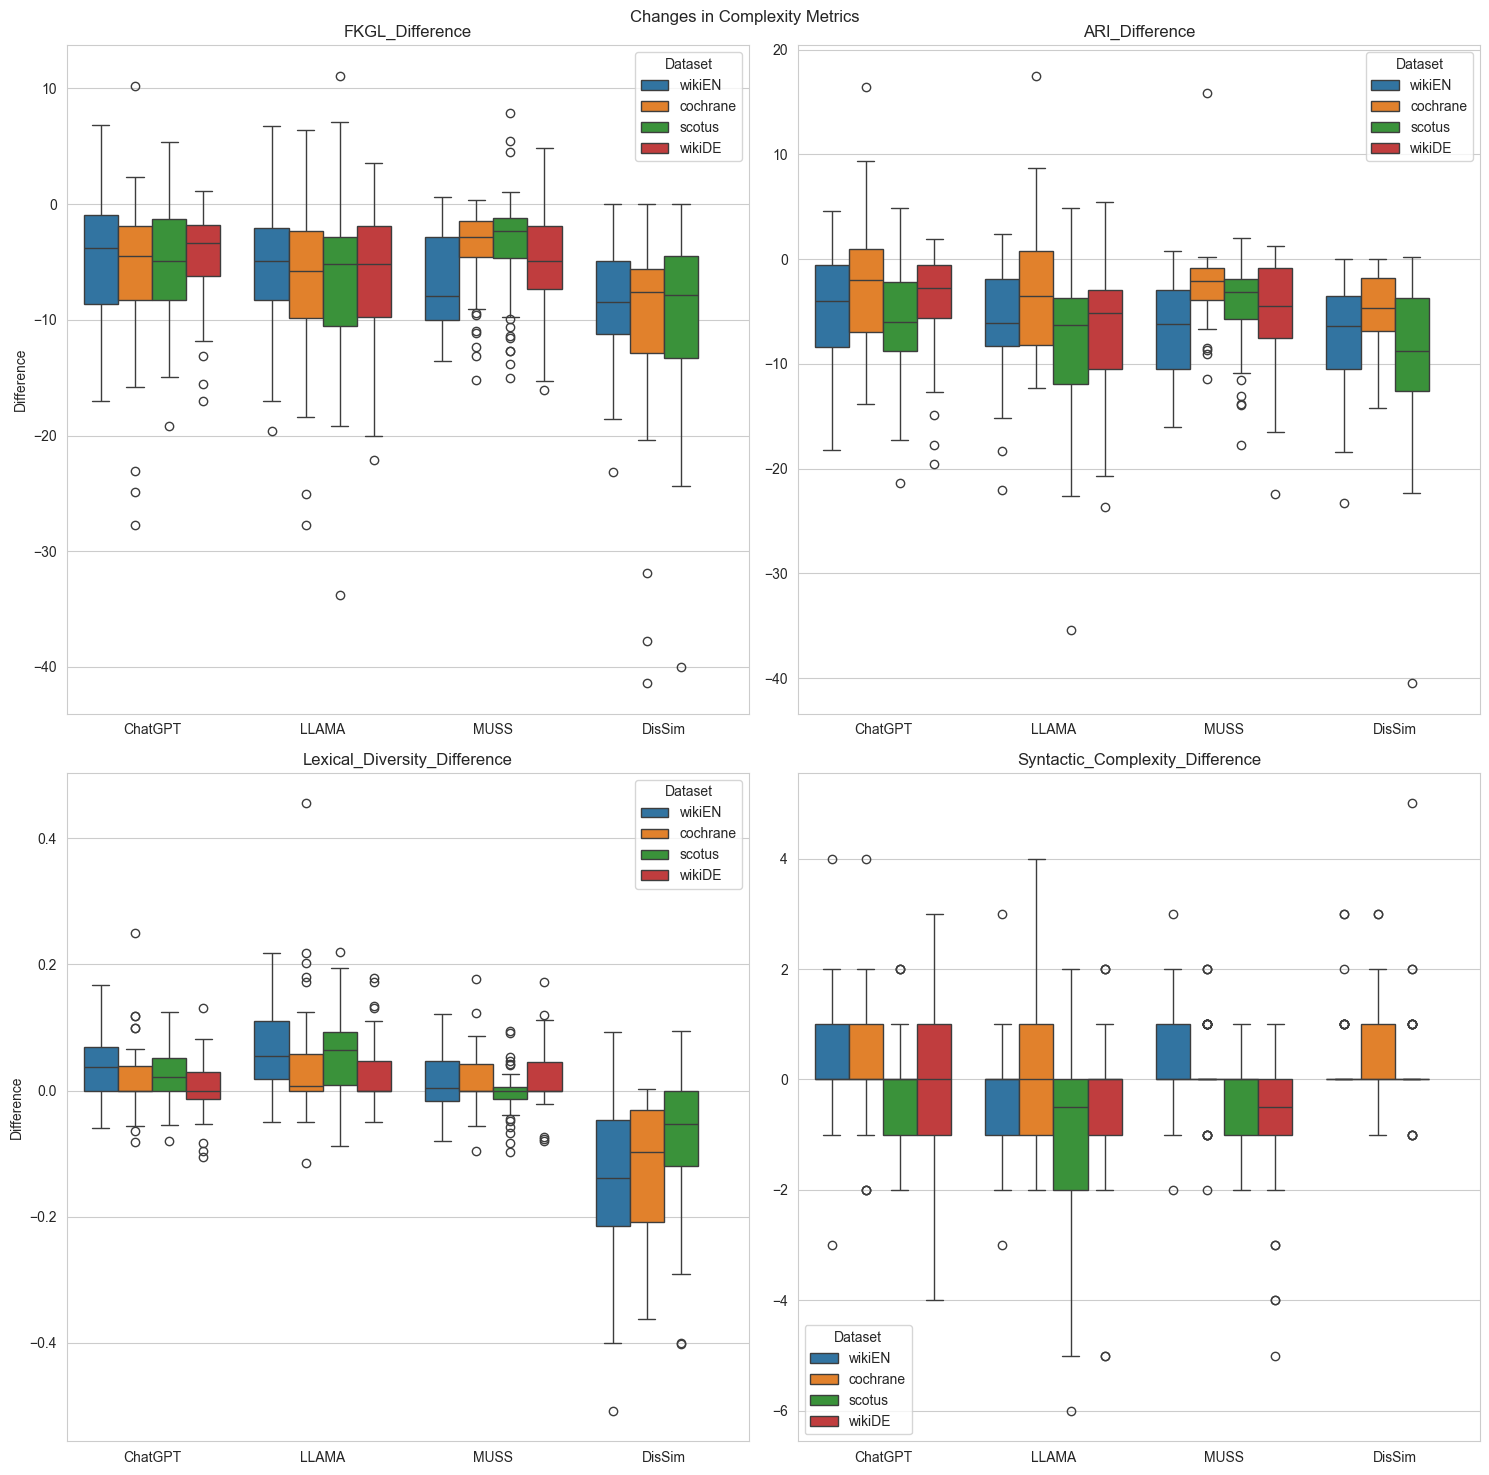

In [358]:
# Visualize changes in complexity metrics
metrics = ['FKGL_Difference', 'ARI_Difference', 'Lexical_Diversity_Difference',
              'Syntactic_Complexity_Difference']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Changes in Complexity Metrics')

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    sns.boxplot(x='System', y=metric, hue='Dataset', data=df_sentences, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('')
    if i % 2 == 0:
        ax.set_ylabel('Difference')
    else:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

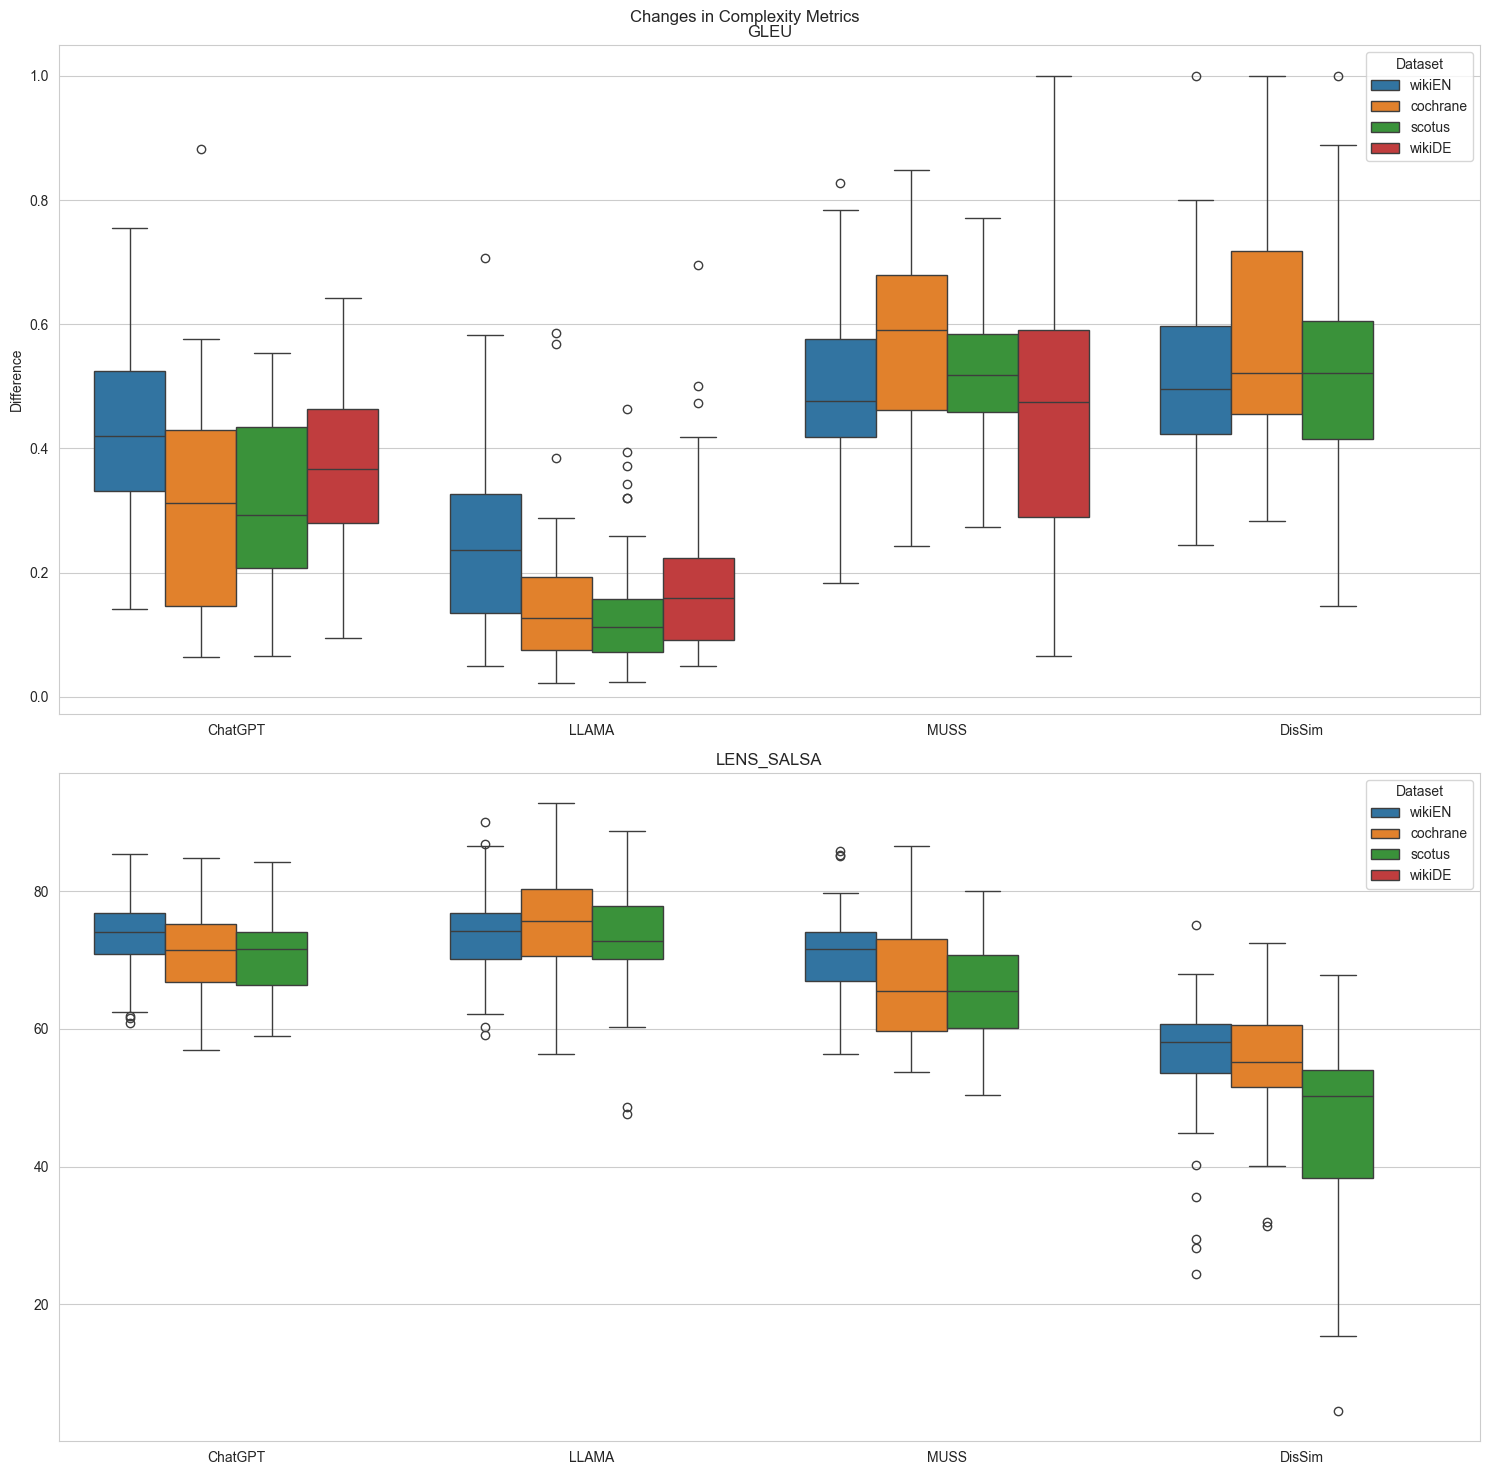

In [359]:
# Visualize changes in complexity metrics
metrics = [
                'GLEU', 'LENS_SALSA'
                ]

fig, axes = plt.subplots(2, 1, figsize=(15, 15))
fig.suptitle('Changes in Complexity Metrics')

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(x='System', y=metric, hue='Dataset', data=df_sentences, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('')
    if i % 2 == 0:
        ax.set_ylabel('Difference')
    else:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [360]:
#  sum up the individual Significance Level values for each group of System, Dataset, and Sentence ID 
# for BAD EDITS

df_sentences_errors_summed = df_edits[df_edits['Quality'] == 'Error'].groupby(["System", "Dataset", "Sentence ID"])['Significance'].apply(lambda x: x.value_counts()).unstack(fill_value=0).reset_index()
df_sentences_errors_summed.columns = ['System', 'Dataset', 'Sentence ID', 'low', 'medium', 'high']
df_sentences_errors_summed['TotalErrors'] = df_sentences_errors_summed['low'] + df_sentences_errors_summed['medium'] + df_sentences_errors_summed['high']

df_sentences_errors_summed.tail()

System Dataset Sentence ID  low  medium  high  TotalErrors
508   MUSS  wikiEN    MUSS_046    2       0     0            2
509   MUSS  wikiEN    MUSS_047    0       0     1            1
510   MUSS  wikiEN    MUSS_048    0       3     0            3
511   MUSS  wikiEN    MUSS_049    0       1     0            1
512   MUSS  wikiEN    MUSS_050    0       1     0            1

In [361]:
# add low medium high and total columns to the main dataframe
df_sentences = df_sentences.merge(df_sentences_errors_summed, on=['System', 'Dataset', 'Sentence ID'], how='left')

df_sentences['TotalErrors'] = df_sentences['TotalErrors'].fillna(0)
df_sentences['low'] = df_sentences['low'].fillna(0)
df_sentences['medium'] = df_sentences['medium'].fillna(0)
df_sentences['high'] = df_sentences['high'].fillna(0)

df_sentences.tail()

Sentence ID                                             Source  \
745    MUSS_046  Diese Stadt hatte durch den Niedergang des Koh...   
746    MUSS_047  Am Tag nach den gewalttätigen Ausbrüchen versa...   
747    MUSS_048  Der Tag wurde als Wendepunkt in der Entwicklun...   
748    MUSS_049  Auch in Bristol, das einige Tage zuvor Schaupl...   
749    MUSS_050  Als Reaktion auf die anhaltenden Unruhen veröf...   

                                                Target System Dataset  \
745  Diese Stadt hatte durch den Niedergang des Koh...   MUSS  wikiDE   
746  Am Tag nach den Ausbrüchen versammelten sich E...   MUSS  wikiDE   
747  Der Tag wurde als Wendepunkt in der Entwicklun...   MUSS  wikiDE   
748  Am 7. August 2024 war Schauplatz gewalttätiger...   MUSS  wikiDE   
749  Am 5. August wurden Reisewarnungen für das Ver...   MUSS  wikiDE   

     Total Edits  Substitution_count  Insertion_count  Split_count  \
745            1                   0                0            0   
746            2                   0                0            0   
747            1                   0                0            0   
748            5                   0                0            0   
749            3                   0                0            0   

     Structure_count  ...  Sentence ID MIX  Language  LLM_Flag  SpecialDomain  \
745             0.00  ...  MUSS_046_wikiDE        EN     False        General   
746             0.00  ...  MUSS_047_wikiDE        EN     False        General   
747             0.00  ...  MUSS_048_wikiDE        EN     False        General   
748             0.00  ...  MUSS_049_wikiDE        EN     False        General   
749             1.00  ...  MUSS_050_wikiDE        EN     False        General   

     source_len  target_len  low  medium  high  TotalErrors  
745         147         125 0.00    0.00  1.00         1.00  
746         161          84 0.00    1.00  0.00         1.00  
747         348          70 0.00    0.00  1.00         1.00  
748         139          64 1.00    1.00  1.00         3.00  
749         177          80 0.00    1.00  0.00         1.00  

[5 rows x 61 columns]

In [362]:
# RELATIVE error_rates (bad edits)

# for each sentence id, get the number of total BAD edits and the number of total edits
df_sentences_bad_relative = df_edits[df_edits['Quality'] == 'Error'].groupby(['Sentence ID MIX']).size().reset_index(name='Total Bad Edits')
df_edits_total = df_edits.groupby(['Sentence ID MIX']).size().reset_index(name='Total Edits')
df_sentences_bad_relative = df_sentences_bad_relative.merge(df_edits_total, on=['Sentence ID MIX'], how='right')
df_sentences_bad_relative['Total Bad Edits'] = df_sentences_bad_relative['Total Bad Edits'].fillna(0)

df_sentences_bad_relative['error_rate'] = df_sentences_bad_relative['Total Bad Edits'] / df_sentences_bad_relative['Total Edits']

df_sentences_bad_relative = df_sentences_bad_relative.merge(df_sentences[['System', 'Dataset', 'Sentence ID', 'Sentence ID NUM', 'Sentence ID MIX']], on=['Sentence ID MIX'], how='left')

df_sentences_bad_relative.head()

Sentence ID MIX  Total Bad Edits  Total Edits  error_rate   System  \
0  ChatGPT_001_cochrane             2.00            5        0.40  ChatGPT   
1    ChatGPT_001_scotus             1.00            8        0.12  ChatGPT   
2    ChatGPT_001_wikiDE             0.00            5        0.00  ChatGPT   
3    ChatGPT_001_wikiEN             0.00            4        0.00  ChatGPT   
4  ChatGPT_002_cochrane             1.00            3        0.33  ChatGPT   

    Dataset  Sentence ID  Sentence ID NUM  
0  cochrane  ChatGPT_001                1  
1    scotus  ChatGPT_001                1  
2    wikiDE  ChatGPT_001                1  
3    wikiEN  ChatGPT_001                1  
4  cochrane  ChatGPT_002                2

In [363]:
# RELATIVE Error Rates by Severity -> "when errors occur, are they severe or minor?"

# for each sentence id, get the number of total BAD edits of each "Significance Level" (minor, somewhat, a lot)
df_sentences_bad_relative_severity = df_edits[df_edits['Quality'] == 'Error'].groupby(['Sentence ID MIX', 'Significance']).size().unstack(fill_value=0).reset_index()

df_sentences_bad_relative_severity['Total'] = df_sentences_bad_relative_severity[1] + df_sentences_bad_relative_severity[2] + df_sentences_bad_relative_severity[3]

df_sentences_bad_relative_severity['Error_Rate_low'] = df_sentences_bad_relative_severity[1] / df_sentences_bad_relative_severity['Total']
df_sentences_bad_relative_severity['Error_Rate_medium'] = df_sentences_bad_relative_severity[2] / df_sentences_bad_relative_severity['Total']
df_sentences_bad_relative_severity['Error_Rate_high'] = df_sentences_bad_relative_severity[3] / df_sentences_bad_relative_severity['Total']

df_sentences_bad_relative_severity = df_sentences_bad_relative_severity.merge(df_sentences[['System', 'Dataset', 'Sentence ID', 'Sentence ID MIX']], on='Sentence ID MIX', how='right')

df_sentences_bad_relative_severity = df_sentences_bad_relative_severity.fillna(0)

df_sentences_bad_relative_severity.head()

Sentence ID MIX    1    2    3  Total  Error_Rate_low  \
0  ChatGPT_001_wikiEN 0.00 0.00 0.00   0.00            0.00   
1  ChatGPT_002_wikiEN 2.00 0.00 0.00   2.00            1.00   
2  ChatGPT_003_wikiEN 1.00 0.00 0.00   1.00            1.00   
3  ChatGPT_004_wikiEN 0.00 0.00 0.00   0.00            0.00   
4  ChatGPT_005_wikiEN 2.00 0.00 0.00   2.00            1.00   

   Error_Rate_medium  Error_Rate_high   System Dataset  Sentence ID  
0               0.00             0.00  ChatGPT  wikiEN  ChatGPT_001  
1               0.00             0.00  ChatGPT  wikiEN  ChatGPT_002  
2               0.00             0.00  ChatGPT  wikiEN  ChatGPT_003  
3               0.00             0.00  ChatGPT  wikiEN  ChatGPT_004  
4               0.00             0.00  ChatGPT  wikiEN  ChatGPT_005

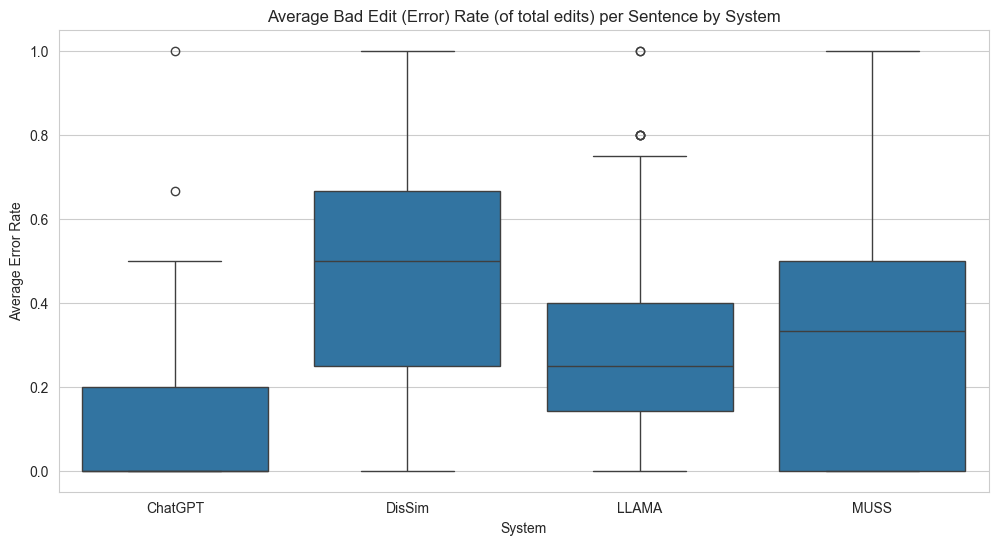

In [364]:
# Boxplot average error rate per sentence per system

sns.boxplot(x='System', y='error_rate', data=df_sentences_bad_relative)
plt.title('Average Bad Edit (Error) Rate (of total edits) per Sentence by System')
plt.xlabel('System')
plt.ylabel('Average Error Rate')
plt.show()

<Figure size 1200x600 with 0 Axes>

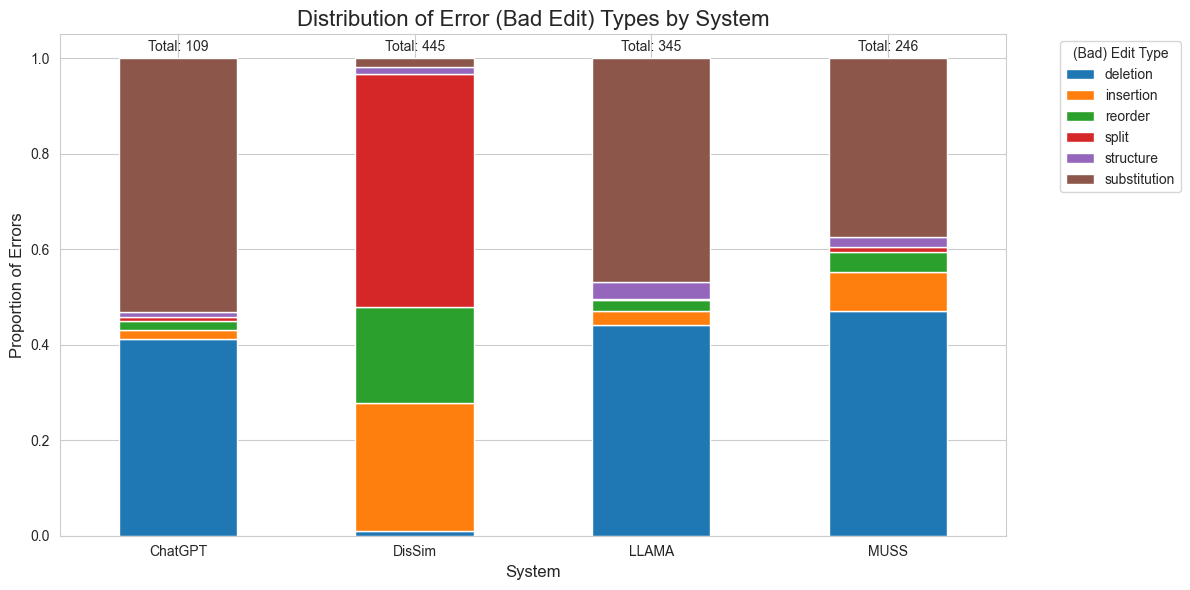

In [365]:
# Filter for errors and get the distribution of Edit Types for each System
error_dist = df_edits[df_edits['Quality'] == 'Error'].groupby(['System', 'Edit Type']).size().unstack(fill_value=0)

# Calculate percentages
error_dist_pct = error_dist.div(error_dist.sum(axis=1), axis=0)

# Set up the plot
plt.figure(figsize=(12, 6))

# Create the stacked bar chart
error_dist_pct.plot(kind='bar', stacked=True)

plt.title('Distribution of Error (Bad Edit) Types by System', fontsize=16)
plt.xlabel('System', fontsize=12)
plt.ylabel('Proportion of Errors', fontsize=12)
plt.legend(title='(Bad) Edit Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Add total error count on top of each bar
for i, total in enumerate(error_dist.sum(axis=1)):
    plt.text(i, 1.01, f'Total: {total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---


## Simplification Operations Analysis (RQ1)

### Operation Type Distribution

In [366]:
def create_contingency_table(data, group_col, value_col):
        return data.groupby([group_col, value_col]).size().unstack(fill_value=0)

def analyse_operation_frequencies(df, by_group, scope="overall", alpha=0.05, category=None, description=None):

    if scope == "overall":
        contingency_table = create_contingency_table(df, by_group, 'Edit Type')
        contingency_table = contingency_table.drop(columns='no_edit', errors='ignore')
        print(f"Contingency Table for {by_group} vs Edit Type:")
        print(contingency_table)
        print(f"\nChi-square test for independence of Edit Type and {by_group}:")
        
        try:
            chi2_results = run_chi2_test(contingency_table, scope=by_group, alpha=alpha, category=category, description=description)
        except Exception as e:
            print(f"Error: {e}")
          
    elif scope in ["System", "Dataset"]:
        for item in df[scope].unique():
            print(f"\n{scope}: {item}")
            temp_df = df[df[scope] == item]
            contingency_table = create_contingency_table(temp_df, by_group, 'Edit Type')
            contingency_table = contingency_table.drop(columns='no_edit', errors='ignore')
            print(f"Contingency Table for {by_group} vs Edit Type:")
            print(contingency_table)
            print(f"\nChi-square test for independence of Edit Type and {by_group}:")
            
            try:
                chi2_results = run_chi2_test(contingency_table, scope=by_group, alpha=alpha, 
                          category=f"{category} - {scope}: {item}", 
                          description=f"{description} - {scope}: {item}")
            except Exception as e:
                print(f"Error: {e}")

Analysis Parameters:
Test type: CHI2
Comparison: System vs Edit Type
Number of System categories: 4
Number of Edit Type categories: 7
Degrees of Freedom: 18


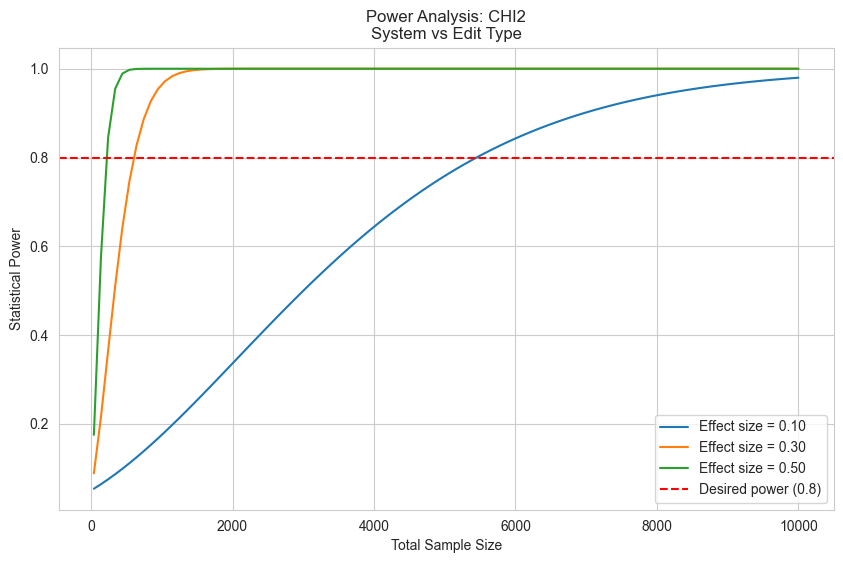


Power Analysis Results:
 effect_size  sample_size effect_size_interpretation
        0.10         1363                      small
        0.30          152                     medium
        0.50           55                      large

Actual sample sizes:
Total: 3954

Per group:
System
ChatGPT    1053
DisSim      863
LLAMA      1272
MUSS        766

Achieved Power with Current Sample Size:
Effect size 0.10: 0.999
Effect size 0.30: 1.000
Effect size 0.50: 1.000


In [367]:
# Power Analysis for Chi-Square Test (Operation Frequencies across Systems)
power_results_system_edits = analyze_power_requirements(
    df_edits, 
    group_col='System', 
    value_col='Edit Type',
    test_type='chi2'
)

In [368]:
# Over all edits and datasets, analyze difference between the systems in operation frequencies
analyse_operation_frequencies(df_edits, by_group='System', scope="overall")

Contingency Table for System vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                                 
ChatGPT         233         66       64     57        109           524
DisSim           14        306      124    385         10            12
LLAMA           359        116       72     43        113           569
MUSS            203         69       62     73         37           318

Chi-square test for independence of Edit Type and System:
--- Chi-square test results: ---
Chi-square statistic: 1821.2445
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.3926
Sample size: 3938

APA Format: χ²(15, N = 3938) = 1821.24, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                         

In [369]:
# Over all edits and datasets, analyze difference between the systems in operation frequencies
analyse_operation_frequencies(df_edits, by_group='System', scope="overall")

Contingency Table for System vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                                 
ChatGPT         233         66       64     57        109           524
DisSim           14        306      124    385         10            12
LLAMA           359        116       72     43        113           569
MUSS            203         69       62     73         37           318

Chi-square test for independence of Edit Type and System:
--- Chi-square test results: ---
Chi-square statistic: 1821.2445
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.3926
Sample size: 3938

APA Format: χ²(15, N = 3938) = 1821.24, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                         

In [370]:
# Across all edits (and systems), analyzing the differences in edit operations between datasets
analyse_operation_frequencies(df_edits, by_group='Dataset', scope="overall")

Contingency Table for Dataset vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
cochrane        226        172       88    145         56           348
scotus          209        141       74    156         44           456
wikiDE          228         97       86     60         72           276
wikiEN          146        147       74    197         97           343

Chi-square test for independence of Edit Type and Dataset:
--- Chi-square test results: ---
Chi-square statistic: 152.6622
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.1137
Sample size: 3938

APA Format: χ²(15, N = 3938) = 152.66, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                        

In [371]:
# For each system separately, analyzing the operation frequencies differences along datasets
print("Examining within one SYSTEM differences in operation frequencies between DATASETS (specific struggles in domains)")

analyse_operation_frequencies(df_edits, by_group='Dataset', scope="System")

Examining within one SYSTEM differences in operation frequencies between DATASETS (specific struggles in domains)

System: ChatGPT
Contingency Table for Dataset vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
cochrane         74         29       11      9         28           119
scotus           65         15       10     12         17           179
wikiDE           66         13       34     17         30           112
wikiEN           28          9        9     19         34           114

Chi-square test for independence of Edit Type and Dataset:
--- Chi-square test results: ---
Chi-square statistic: 82.5126
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.1616
Sample size: 1053

APA Format: χ²(15, N = 1053) = 82.51, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit T

In [372]:
# For each DATASET separately, analyzing the operation frequencies differences along systems
print("Examining within one DATASET differences in operation frequencies between SYSTENS (specific struggles in domains)")

analyse_operation_frequencies(df_edits, by_group='System', scope="Dataset")

Examining within one DATASET differences in operation frequencies between SYSTENS (specific struggles in domains)

Dataset: wikiEN
Contingency Table for System vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                                 
ChatGPT          28          9        9     19         34           114
DisSim            4        102       43    131         10             3
LLAMA            84         17       16      8         32           121
MUSS             30         19        6     39         21           105

Chi-square test for independence of Edit Type and System:
--- Chi-square test results: ---
Chi-square statistic: 534.9340
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.4214
Sample size: 1004

APA Format: χ²(15, N = 1004) = 534.93, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit T

### Changes in Characteristic & Quality Metrics
Question: Are there significant differences in changes in sentence characteristics metrics across different dimensions (systems, datasets)?

In [373]:
# Define input characteristics and quality metrics
input_characteristics = [
    'FKGL_Source', 'ARI_Source', 
    'Lexical_Diversity_Source', 'Syntactic_Complexity_Source'
]

input_characteristics_diff = [
    'FKGL_Difference', 'ARI_Difference', 
    'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference'
]

quality_metrics = [
    'BERTScore_F1', 'GLEU', 'LENS_SALSA'
]

In [374]:
def analyze_quality_metric_changes(df, metric, by_group='System', scope="overall", alpha=0.05, 
                                 category=None, description=None):

    """ Explanation of parameters:
    SCOPE:
    Ex1:  scope="overall", by_group="System" --> This would compare XYZ scores between ChatGPT, MUSS, DisSim, etc.

    Ex2: scope="System" --> This would do:   
        # - For ChatGPT: compare cochrane vs wikiEN vs ...
        # - For MUSS: compare cochrane vs wikiEN vs ...

    Ex3: scope="Dataset" --> This would do:
        # - For cochrane: compare ChatGPT vs MUSS vs DisSim vs ...
        # - For wikiEN: compare ChatGPT vs MUSS vs DisSim vs ...
    """
    subject_col = 'Sentence ID'

    if scope == "overall":
        # Get unique groups
        groups = df[by_group].unique()
        print(f"Meta: groups being compared: {groups}")
        
        if len(groups) == 2:
            print("(scope overall: using t-test, since only 2 groups)")
            # Use t-test for 2 groups
            group1_data = df[df[by_group] == groups[0]][metric]
            group2_data = df[df[by_group] == groups[1]][metric]
            
            result = run_t_test_analysis(
                group1_data, 
                group2_data, 
                metric, 
                alpha=alpha,
                var_names=(groups[0], groups[1])
            )
            # Add scope information
            result['scope'] = 'overall'
            result['scope_value'] = 'all'
            return result
        else:
            print("(scope overall: using ANOVA, since more than 2 groups)")
            # Use ANOVA for >2 groups
            result = run_comprehensive_RM_anova(df, by_group, metric, subject_col, alpha, category, description)
            result['scope'] = 'overall'
            result['scope_value'] = 'all'
            return result
    
    elif scope in ["System", "Dataset"]:
        results = []
        for item in df[scope].unique():
            print(f"\n for item {item} in scope {scope}: runnning ANOVA")
            temp_df = df[df[scope] == item]
            result = run_comprehensive_RM_anova(
                temp_df, 
                'Dataset' if scope == "System" else 'System', 
                metric, 
                subject_col,
                alpha,
                category,
                f"{description} ({scope}: {item})"
            )
            # Add scope information to result
            result['scope'] = scope
            result['scope_value'] = item
            results.append(result)
        return results

    return None

In [375]:
def run_input_and_quality_metrics_analysis(df, quality_metrics=quality_metrics):
    all_results = []
    
    # Helper function to flatten results
    def process_result(result, category, description):
        if isinstance(result, list):
            # If result is a list (from scope="System" or "Dataset"), extend all_results
            all_results.extend(result)
        else:
            # If result is a single dictionary, append it
            all_results.append(result)
    
    # Input Characteristics DIFFERENCE Analysis
    for metric in input_characteristics_diff:
        print(f"\n\n... now running input characteristics analysis")
        # Overall analysis
        print(f"\n\n... now running overall scope analysis for {metric}")
        result = analyze_quality_metric_changes(df, metric, scope="overall", 
            category="Input Characteristics", description=f"{metric} - Overall")
        process_result(result, "Input Characteristics", f"{metric} - Overall")
        print("\n#################################################\n")
        
        # Within System analysis
        print(f"\n\n... now running system scope analysis for {metric}")
        result = analyze_quality_metric_changes(df, metric, scope="System", 
            category="Input Characteristics", description=f"{metric} - By System")
        process_result(result, "Input Characteristics", f"{metric} - By System")
        print("\n#################################################\n")
        
        # Within Dataset analysis
        print(f"\n\n... now running dataset scope analysis for {metric}")
        result = analyze_quality_metric_changes(df, metric, scope="Dataset", 
            category="Input Characteristics", description=f"{metric} - By Dataset")
        process_result(result, "Input Characteristics", f"{metric} - By Dataset")
        print("\n#################################################\n")

    # Quality Metrics Analysis
    for metric in quality_metrics:
        print(f"\n\n... now running quality metrics analysis")
        # Overall analysis
        print(f"\n\n... now running overall scope analysis for {metric}")
        result = analyze_quality_metric_changes(df, metric, scope="overall", 
            category="Quality Metrics", description=f"{metric} - Overall")
        process_result(result, "Quality Metrics", f"{metric} - Overall")
        print("\n#################################################\n")
        
        # Within System analysis
        print(f"\n\n... now running system scope analysis for {metric}")
        result = analyze_quality_metric_changes(df, metric, scope="System", 
            category="Quality Metrics", description=f"{metric} - By System")
        process_result(result, "Quality Metrics", f"{metric} - By System")
        print("\n#################################################\n")
        
        # Within Dataset analysis
        print(f"\n\n... now running dataset scope analysis for {metric}")
        result = analyze_quality_metric_changes(df, metric, scope="Dataset", 
            category="Quality Metrics", description=f"{metric} - By Dataset")
        process_result(result, "Quality Metrics", f"{metric} - By Dataset")
        print("\n#################################################\n")
    
    # Convert results to DataFrame and clean up
    results_df = pd.DataFrame(all_results)

    # Ensure the 'post_hoc' column exists
    if 'post_hoc' not in results_df.columns:
        results_df['post_hoc'] = None
        
    # Add post-hoc details column
    print(f"Debug: Formatting post hoc")
    
    def format_post_hoc(row):
        # Check if post_hoc exists and is a DataFrame
        if 'post_hoc' not in row or not isinstance(row['post_hoc'], pd.DataFrame):
            return None
            
        ph_df = row['post_hoc']
        if ph_df.empty:
            return None
            
        post_hoc_details = []
        
        # Process each significant comparison
        significant_comparisons = ph_df[ph_df['significant']]
        for _, comp in significant_comparisons.iterrows():
            detail = (f"{comp['group1']} vs {comp['group2']}: "
                    f"stat={comp['statistic']:.4f}, "
                    f"p={comp['p_value']:.4f}{comp['significance']}")
            post_hoc_details.append(detail)
                
        return '; '.join(post_hoc_details) if post_hoc_details else None

    results_df['post_hoc_details'] = results_df.apply(format_post_hoc, axis=1)
    
    # Select and rename final columns
    main_results = results_df[[
        'category', 'description', 'groupby', 'target', 
        'test_type', 'statistic', 'p_value', 'scope', 'scope_value',
        'post_hoc_details', 'post_hoc'
    ]].copy()
    
    # Add significance indicators
    main_results['significance'] = main_results['p_value'].apply(lambda p: 
        '***' if p <= 0.001 else 
        '**' if p <= 0.01 else 
        '*' if p <= 0.05 else 
        'ns'
    )
    
    # Sort by p-value
    main_results = main_results.sort_values('p_value')
    
    # Create significant results DataFrame
    significant_results = main_results[main_results['p_value'] < 0.05].copy()
    
    return {
        'all_results': main_results,
        'significant_results': significant_results,
        'summary': {
            'counts': pd.DataFrame({
                'Metric': ['Total Tests', 'Significant Tests'],
                'Value': [len(main_results), len(significant_results)]
            }),
            'by_category': main_results.groupby('category')['significance'].value_counts().unstack(fill_value=0)
        }
    }

Analysis Parameters:
Test type: ANOVARM
Comparison: System vs BERTScore_F1
Number of System categories: 4


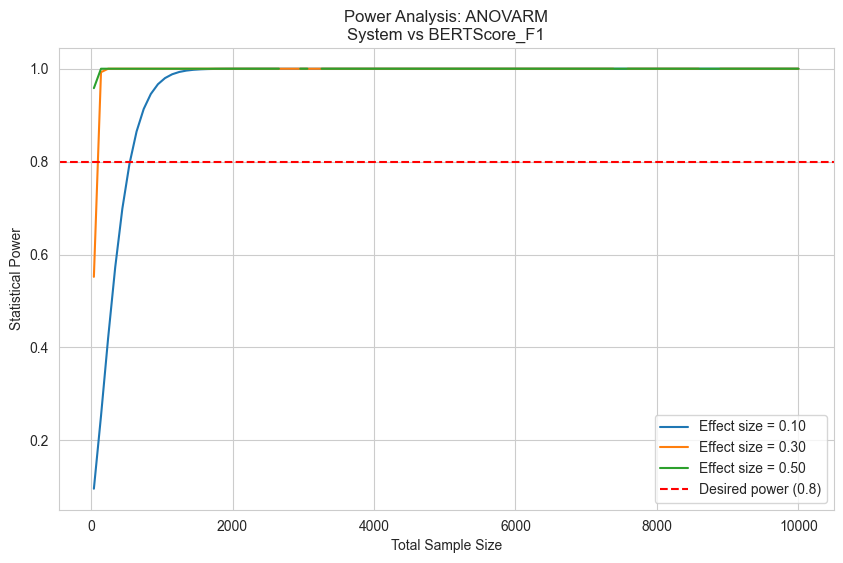


Power Analysis Results:
 effect_size  adjusted_effect_size  total_sample_size  per_condition_size effect_size_interpretation
        0.10                  0.14                552                 138                      small
        0.30                  0.42                 68                  17                      large
        0.50                  0.71                 28                   7                      large

Actual sample sizes:
Total: 750

Per group:
System
ChatGPT    200
DisSim     150
LLAMA      200
MUSS       200

Achieved Power with Current Sample Size:
Effect size 0.10: 0.916
Effect size 0.30: 1.000
Effect size 0.50: 1.000


In [376]:
# Power Analysis for ANOVA (Quality Metrics across Systems)
power_results_quality_metrics = analyze_power_requirements(
    df_sentences, 
    test_type='anovaRM',
    group_col='System', 
    value_col='BERTScore_F1', # as an example for one quality metric (doesnt matter for power analysis)
    n_conditions=4
)

In [377]:
# Run the analysis

analysis_results = run_input_and_quality_metrics_analysis(df_sentences)

# View all results
#print("\nAll Results:")
#print(analysis_results['all_results']

# View only significant results
print("\nSignificant Results:")
analysis_results['significant_results']




... now running input characteristics analysis


... now running overall scope analysis for FKGL_Difference
Meta: groups being compared: ['ChatGPT' 'LLAMA' 'MUSS' 'DisSim']
(scope overall: using ANOVA, since more than 2 groups)

Repeated Measures ANOVA: Analyzing FKGL_Difference grouped by System, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 3.2630438865386215e-07
Group ChatGPT: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 1.3008379259272953e-10
Group DisSim: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 1.824353145385233e-05
Group LLAMA: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 2.9995525531792984e-06
Group MUSS: Not normal (p = 0.0000)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns System, values FKGL_Difference
Mauchly's test: W = 0.8054, chi2 = 31.9690, dof = 5, p-value = 0.0000
Sphericity assumption is violated. A correction (Greenhouse-Geisser) will be appli

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/anaconda3/envs/py311ts/l

 DEBUG: looking at pair DisSim vs LLAMA
: Length df_g1: 50, Length df_g2: 50
 DEBUG: looking at pair DisSim vs MUSS
: Length df_g1: 50, Length df_g2: 50
 DEBUG: looking at pair LLAMA vs MUSS
: Length df_g1: 50, Length df_g2: 50

Detailed Comparison Results:
----------------------------------------------------------------------------------------------------
Group 1    Group 2    n     Mean 1   Mean 2   SD 1     SD 2     W        p-raw    p-adj    Sig.  Effect  
----------------------------------------------------------------------------------------------------
ChatGPT    DisSim     50    -2.508   -5.018   6.110    3.983    291.50   0.0008   0.0050   **    0.543   
ChatGPT    LLAMA      50    -2.508   -3.520   6.110    6.133    426.00   0.0635   0.3813   ns    0.304   
ChatGPT    MUSS       50    -2.508   -2.540   6.110    3.803    635.50   0.9846   1.0000   ns    0.003   
DisSim     LLAMA      50    -5.018   -3.520   3.983    6.133    440.00   0.0566   0.3395   ns    -0.310  
DisSim    

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172

: Length df_g1: 50, Length df_g2: 50
Comparison: cochrane vs scotus - SKIPPED (insufficient data)
 DEBUG: looking at pair cochrane vs wikiDE
: Length df_g1: 50, Length df_g2: 50
Comparison: cochrane vs wikiDE - SKIPPED (insufficient data)
 DEBUG: looking at pair cochrane vs wikiEN
: Length df_g1: 50, Length df_g2: 50
Comparison: cochrane vs wikiEN - SKIPPED (insufficient data)
 DEBUG: looking at pair scotus vs wikiDE
: Length df_g1: 50, Length df_g2: 50
Comparison: scotus vs wikiDE - SKIPPED (insufficient data)
 DEBUG: looking at pair scotus vs wikiEN
: Length df_g1: 50, Length df_g2: 50
Comparison: scotus vs wikiEN - SKIPPED (insufficient data)
 DEBUG: looking at pair wikiDE vs wikiEN
: Length df_g1: 50, Length df_g2: 50
Comparison: wikiDE vs wikiEN - SKIPPED (insufficient data)

Detailed Comparison Results:
----------------------------------------------------------------------------------------------------
Group 1    Group 2    n     Mean 1   Mean 2   SD 1     SD 2     W        p-raw

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/f

: Length df_g1: 50, Length df_g2: 50
Comparison: cochrane vs wikiEN - SKIPPED (insufficient data)
 DEBUG: looking at pair scotus vs wikiDE
: Length df_g1: 50, Length df_g2: 50
Comparison: scotus vs wikiDE - SKIPPED (insufficient data)
 DEBUG: looking at pair scotus vs wikiEN
: Length df_g1: 50, Length df_g2: 50
Comparison: scotus vs wikiEN - SKIPPED (insufficient data)
 DEBUG: looking at pair wikiDE vs wikiEN
: Length df_g1: 50, Length df_g2: 50
Comparison: wikiDE vs wikiEN - SKIPPED (insufficient data)

Detailed Comparison Results:
----------------------------------------------------------------------------------------------------
Group 1    Group 2    n     Mean 1   Mean 2   SD 1     SD 2     W        p-raw    p-adj    Sig.  Effect  
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Significance codes: *** p<0.001, ** p<0.01, * p<0.05

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/f

category                                        description  \
54        Quality Metrics                               LENS_SALSA - Overall   
45        Quality Metrics                                     GLEU - Overall   
36        Quality Metrics                             BERTScore_F1 - Overall   
61        Quality Metrics          LENS_SALSA - By Dataset (Dataset: scotus)   
51        Quality Metrics              GLEU - By Dataset (Dataset: cochrane)   
59        Quality Metrics          LENS_SALSA - By Dataset (Dataset: wikiEN)   
52        Quality Metrics                GLEU - By Dataset (Dataset: scotus)   
37        Quality Metrics         BERTScore_F1 - By System (System: ChatGPT)   
25  Input Characteristics  Lexical_Diversity_Difference - By Dataset (Dat...   
43        Quality Metrics        BERTScore_F1 - By Dataset (Dataset: scotus)   
42        Quality Metrics      BERTScore_F1 - By Dataset (Dataset: cochrane)   
50        Quality Metrics                GLEU - By Dataset (Dataset: wikiEN)   
18  Input Characteristics             Lexical_Diversity_Difference - Overall   
24  Input Characteristics  Lexical_Diversity_Difference - By Dataset (Dat...   
7   Input Characteristics     FKGL_Difference - By Dataset (Dataset: scotus)   
39        Quality Metrics            BERTScore_F1 - By System (System: MUSS)   
53        Quality Metrics                GLEU - By Dataset (Dataset: wikiDE)   
41        Quality Metrics        BERTScore_F1 - By Dataset (Dataset: wikiEN)   
16  Input Characteristics      ARI_Difference - By Dataset (Dataset: scotus)   
5   Input Characteristics     FKGL_Difference - By Dataset (Dataset: wikiEN)   
6   Input Characteristics   FKGL_Difference - By Dataset (Dataset: cochrane)   
14  Input Characteristics      ARI_Difference - By Dataset (Dataset: wikiEN)   
58        Quality Metrics            LENS_SALSA - By System (System: DisSim)   
9   Input Characteristics                           ARI_Difference - Overall   
20  Input Characteristics  Lexical_Diversity_Difference - By System (Syst...   
47        Quality Metrics                   GLEU - By System (System: LLAMA)   
19  Input Characteristics  Lexical_Diversity_Difference - By System (Syst...   
30  Input Characteristics  Syntactic_Complexity_Difference - By System (S...   
34  Input Characteristics  Syntactic_Complexity_Difference - By Dataset (...   
3   Input Characteristics         FKGL_Difference - By System (System: MUSS)   
46        Quality Metrics                 GLEU - By System (System: ChatGPT)   
17  Input Characteristics      ARI_Difference - By Dataset (Dataset: wikiDE)   
15  Input Characteristics    ARI_Difference - By Dataset (Dataset: cochrane)   
12  Input Characteristics          ARI_Difference - By System (System: MUSS)   
29  Input Characteristics  Syntactic_Complexity_Difference - By System (S...   
0   Input Characteristics                          FKGL_Difference - Overall   
26  Input Characteristics  Lexical_Diversity_Difference - By Dataset (Dat...   
13  Input Characteristics        ARI_Difference - By System (System: DisSim)   
21  Input Characteristics  Lexical_Diversity_Difference - By System (Syst...   
35  Input Characteristics  Syntactic_Complexity_Difference - By Dataset (...   
28  Input Characteristics  Syntactic_Complexity_Difference - By System (S...   

    groupby                           target      test_type  statistic  \
54   System                       LENS_SALSA  friedman_test     305.06   
45   System                             GLEU  friedman_test     231.84   
36   System                     BERTScore_F1  friedman_test     186.52   
61   System                       LENS_SALSA  friedman_test     104.88   
51   System                             GLEU  friedman_test      95.90   
59   System                       LENS_SALSA  friedman_test      94.99   
52   System                             GLEU  friedman_test      93.87   
37  Dataset                     BERTScore_F1  friedman_test     

In [378]:
analysis_results['summary']['by_category']

significance           *  **  ***  ns
category                             
Input Characteristics  4   6   14  12
Quality Metrics        0   1   16  10

In [379]:
def visualize_metric_changes(analysis_results, df, metrics, alpha=0.05):
    """
    Creates grouped bar charts for each metric, showing differences between systems and datasets.
    
    Args:
        analysis_results: Dictionary containing analysis results
        df: Original DataFrame with the data
        metrics: List of metrics to analyze
        alpha: Significance level
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import seaborn as sns
    import numpy as np
    
    # Set style parameters
    colors = {
    'cochrane': '#f39c12',  # Orange
    'wikiEN': '#3498db',    # Blue
    'scotus': '#2ecc71',    # Green (for future use)
    'wikiDE': '#e74c3c'     # Red (for future use)
}
    
    # Helper function to determine if difference is significant
    def get_significance(system, metric, dataset):
        results = analysis_results['all_results']
        system_results = results[
            (results['scope'] == 'System') & 
            (results['scope_value'] == system) & 
            (results['target'] == metric)
        ]
        if len(system_results) == 0:
            return False, None
        
        p_value = system_results.iloc[0]['p_value']
        sig_level = (
            '***' if p_value <= 0.001 else
            '**' if p_value <= 0.01 else
            '*' if p_value <= 0.05 else
            None
        )
        return p_value < alpha, sig_level
    
    # Create a plot for each metric
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        
        # Calculate positions for grouped bars
        systems = sorted(df['System'].unique())
        datasets = sorted(df['Dataset'].unique())
        x = np.arange(len(systems))
        width = 0.35 / len(datasets)
        
        # Calculate means and standard errors
        means = []
        sems = []
        for system in systems:
            system_means = []
            system_sems = []
            for dataset in datasets:
                data = df[(df['System'] == system) & 
                         (df['Dataset'] == dataset)][metric]
                system_means.append(data.mean())
                system_sems.append(data.sem())
            means.append(system_means)
            sems.append(system_sems)
        
        # Create bars
        for i, dataset in enumerate(datasets):
            dataset_means = [system_mean[i] for system_mean in means]
            dataset_sems = [system_sem[i] for system_sem in sems]
            
            # Position adjustment for grouped bars
            pos = x + (i - len(datasets)/2 + 0.5) * width
            
            # Create bars with explicit colors
            bars = plt.bar(pos, dataset_means, width, 
                        label=dataset, 
                        color=colors[dataset],  # Explicitly use color from dictionary
                        alpha=0.8)
            
            # Add error bars
            plt.errorbar(pos, dataset_means, yerr=dataset_sems, 
                        fmt='none', color='black', capsize=3)
            
            # Add hatching and modify alpha for insignificant differences
            for idx, bar in enumerate(bars):
                system = systems[idx]
                is_sig, sig_level = get_significance(system, metric, dataset)
                if not is_sig:
                    bar.set_hatch('/')
                    bar.set_alpha(0.5)
                elif sig_level:
                    # Add significance markers above significant bars
                    height = dataset_means[idx]
                    plt.text(pos[idx], height + dataset_sems[idx], 
                            sig_level, ha='center', va='bottom')
        
        # Customize plot
        plt.xlabel('System')
        plt.ylabel(metric)
        plt.title(f'Comparison of {metric} across Systems and Datasets')
        plt.xticks(x, systems)
        
        # Add legend
        legend_elements = [
        Patch(facecolor='gray', label='Significant'),
        Patch(facecolor='gray', hatch='/', alpha=0.5, label='Not Significant')
        ]
        for dataset in datasets:
            legend_elements.append(
                Patch(facecolor=colors[dataset], alpha=0.8, label=dataset)
            )
            
        plt.legend(handles=legend_elements, 
                  bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add significance level legend
        plt.figtext(0.99, 0.02, 
                   '*** p≤0.001, ** p≤0.01, * p≤0.05', 
                   ha='right', fontsize=8)
        
        plt.tight_layout()
        plt.show()

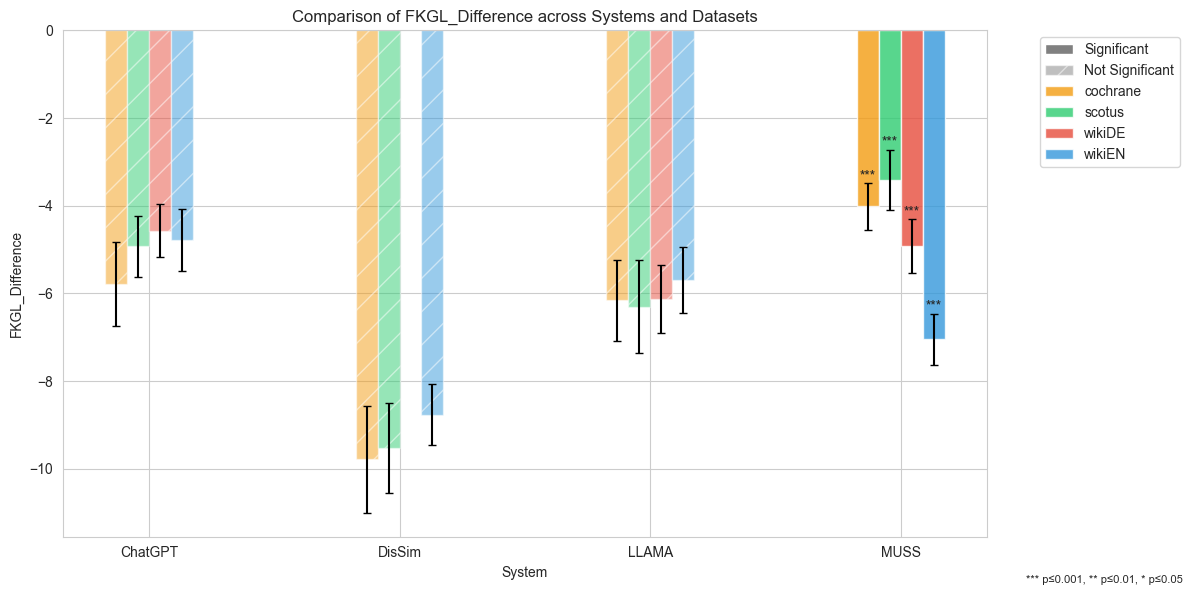

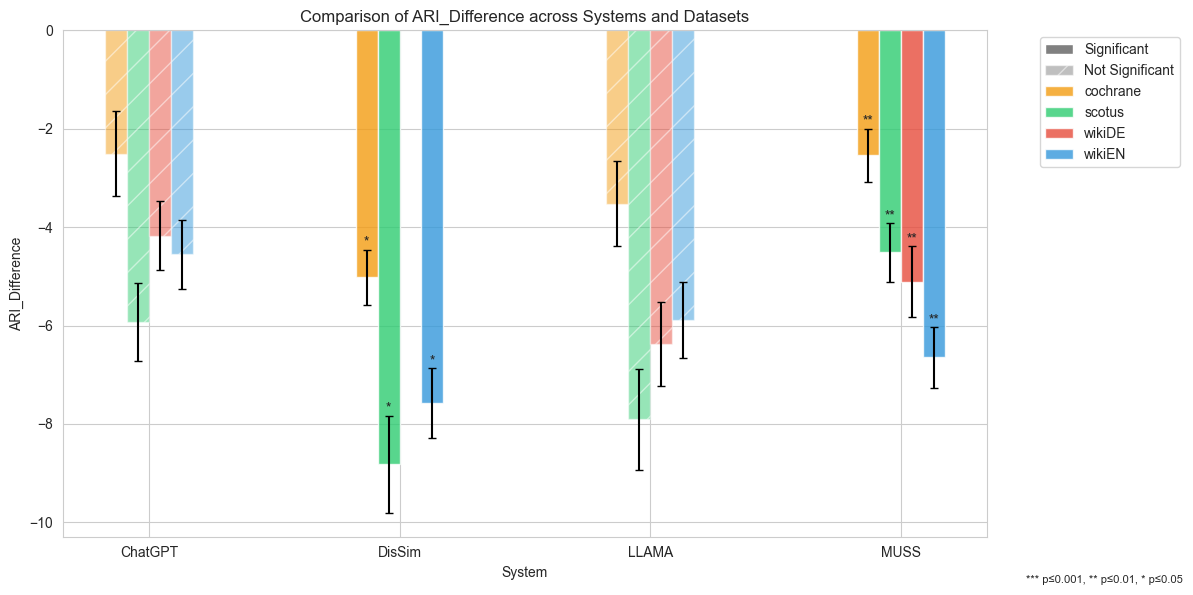

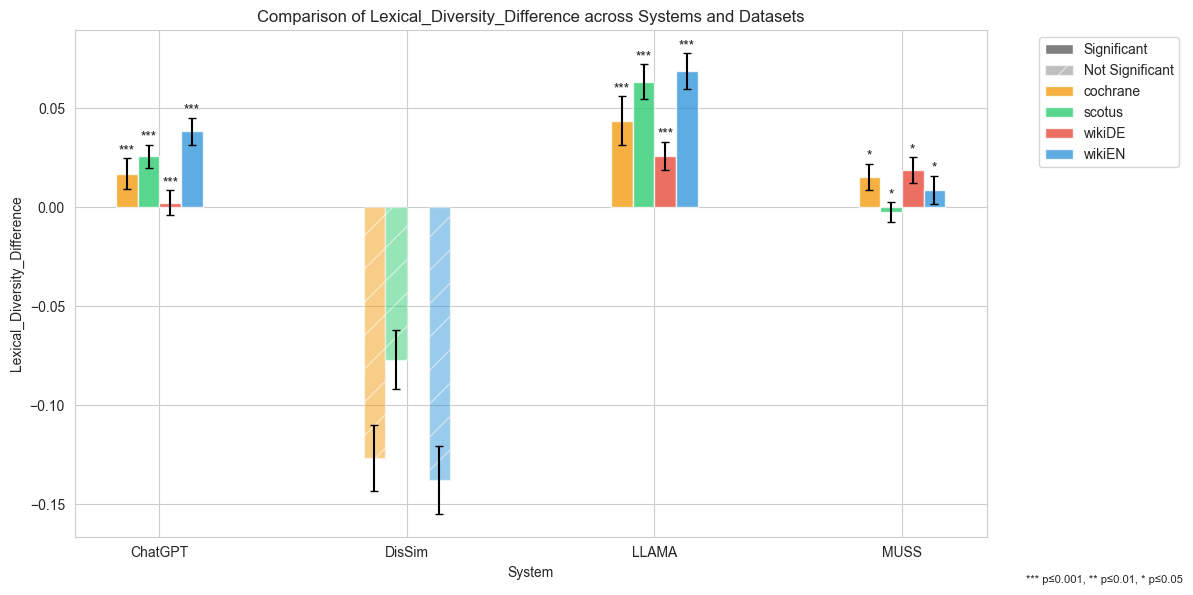

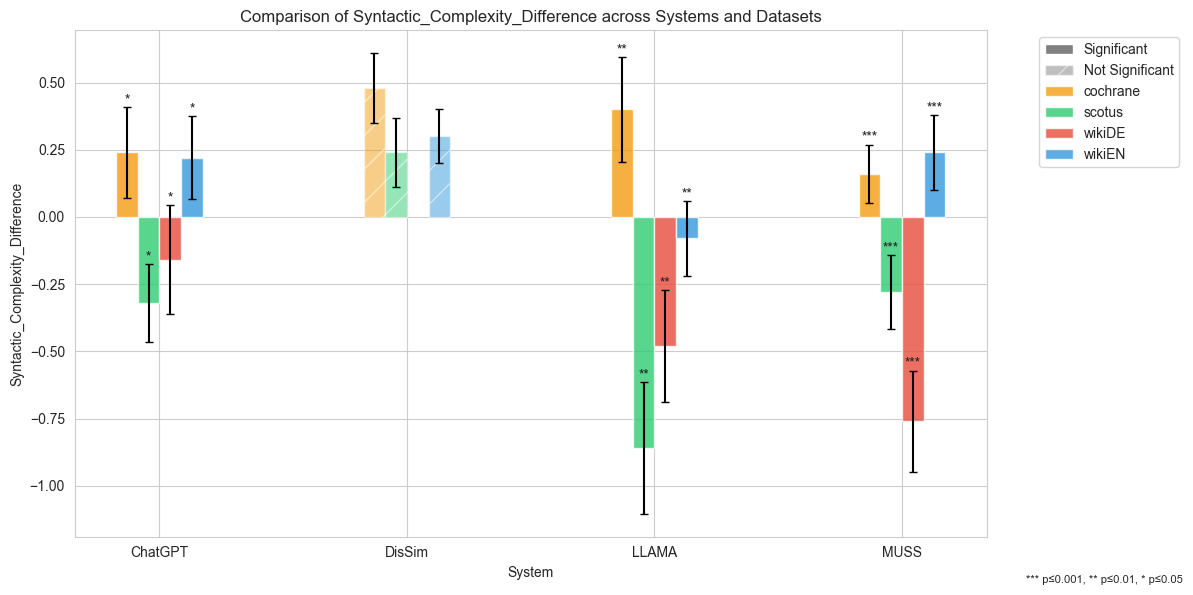

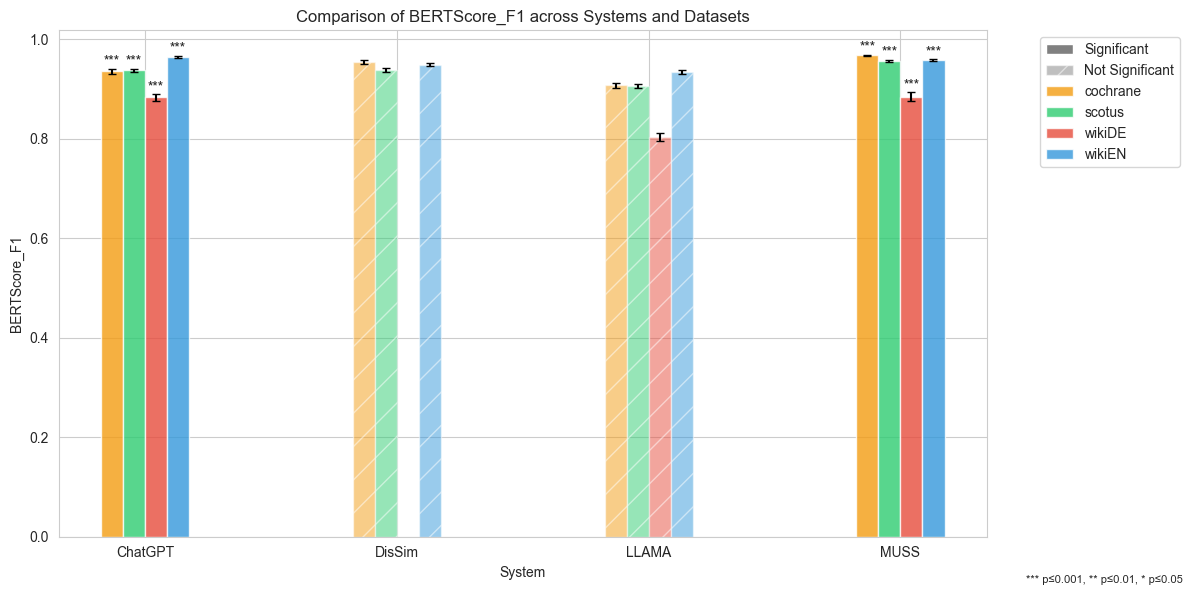

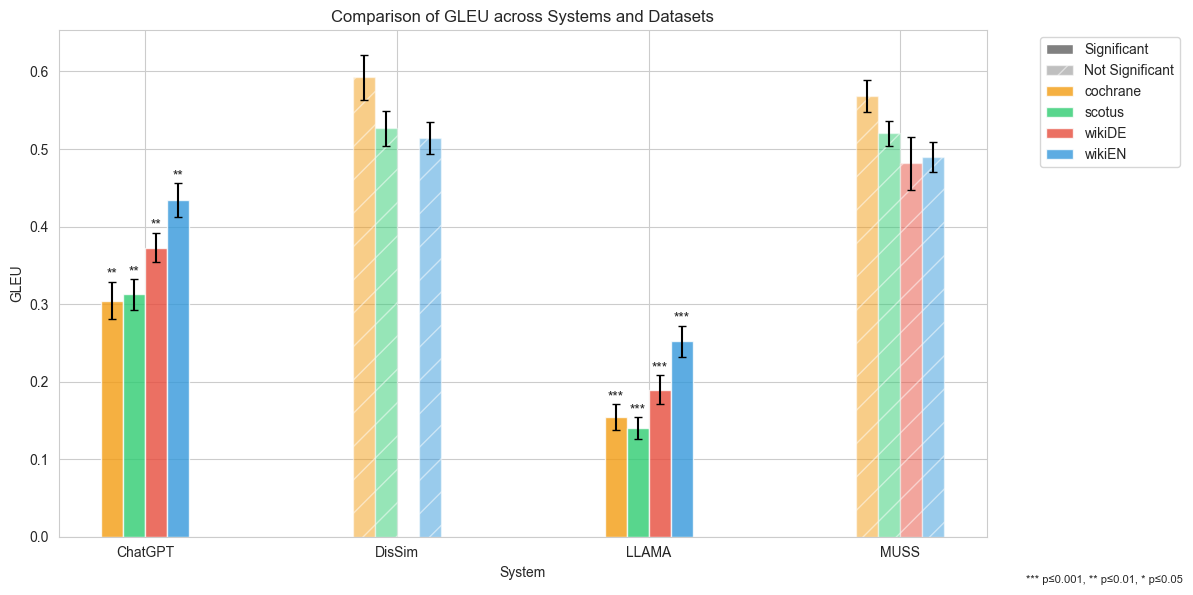

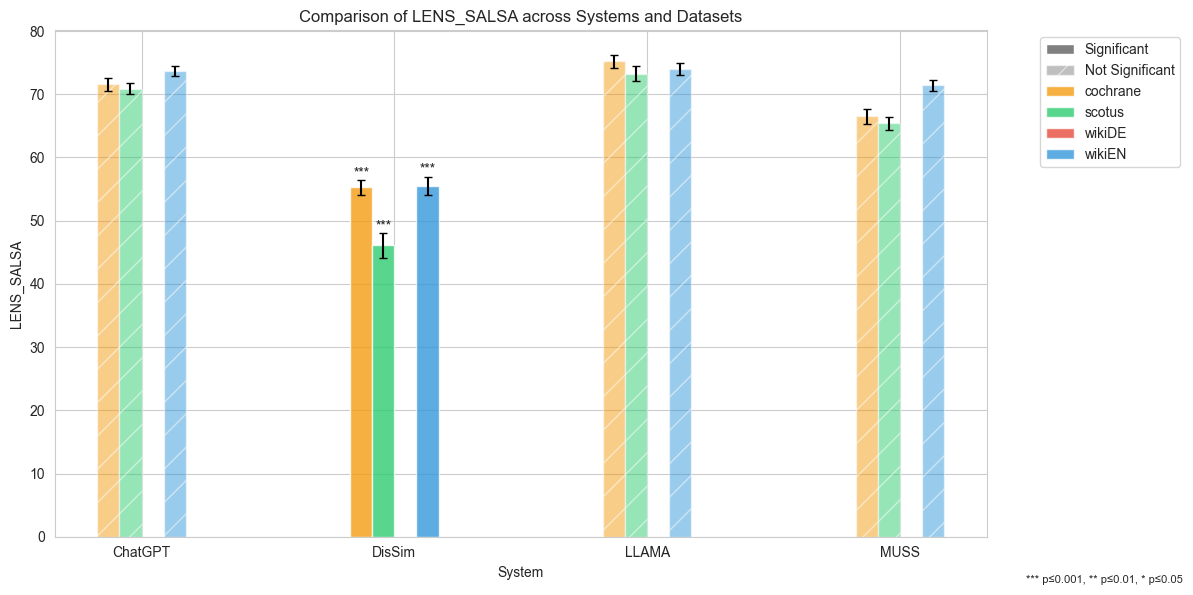

In [380]:
# Define metrics to visualize
metrics_to_show = [
    'FKGL_Difference', 'ARI_Difference',
    'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference',
    'BERTScore_F1', 'GLEU', 'LENS_SALSA'
]

# Create visualizations
visualize_metric_changes(analysis_results, df_sentences, metrics_to_show)

### Correlation: Input Complexity vs. Simplification Quality

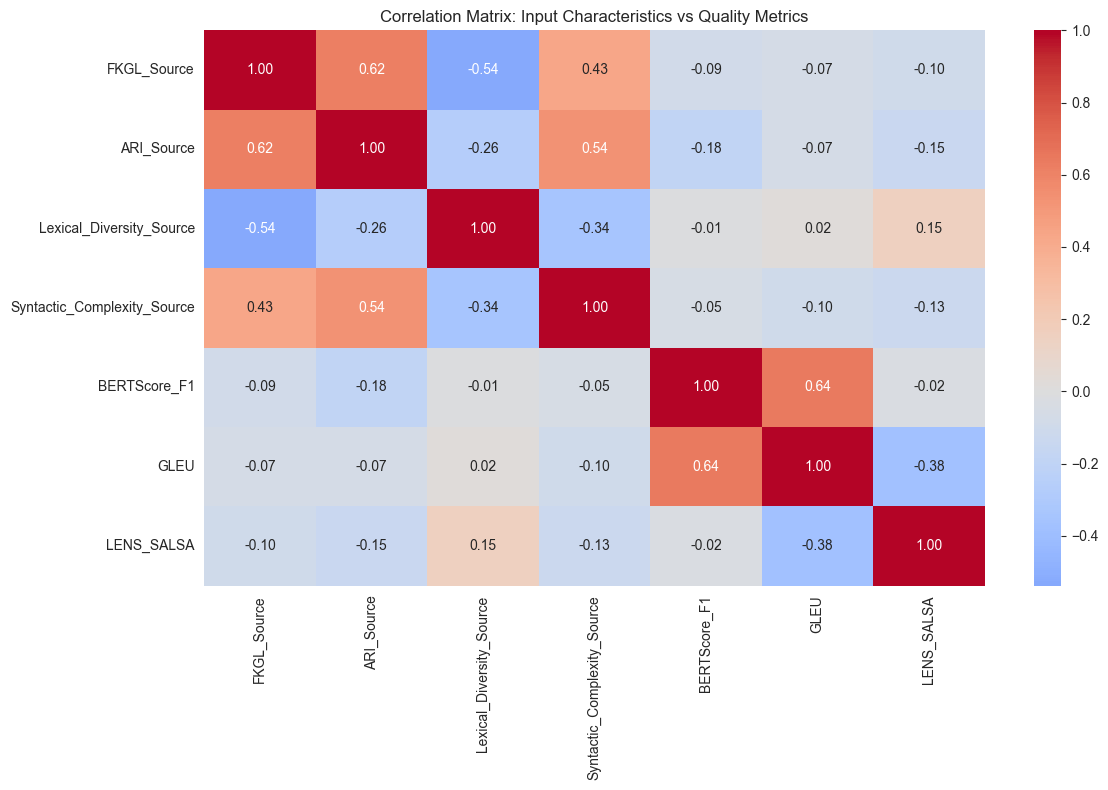

In [381]:
# Quick EDA

# Create correlation matrix
correlation_matrix = df_sentences[input_characteristics + quality_metrics].corr()

# Visualize using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Input Characteristics vs Quality Metrics')
plt.tight_layout()
plt.show()

In [382]:
def run_correlation_metrics(df):

    # Create a dictionary to store all correlation results
    correlation_results = []

    # Loop through all combinations
    for input_char in input_characteristics:
        for quality_metric in quality_metrics:
            result = analyze_correlation(
                df_sentences, 
                input_char, 
                quality_metric,
                category="Input vs Quality",
                description=f"Correlation between {input_char} and {quality_metric}"
            )
            
            # Store results
            correlation_results.append({
                'input_characteristic': input_char,
                'quality_metric': quality_metric,
                'correlation': result['correlation_coef'],
                'p_value': result['p_value'],
                'method': result['method'],
                'effect_size': result['effect_size']
            })



    # Convert results to DataFrame for easy analysis
    correlation_df = pd.DataFrame(correlation_results)

    # Display significant correlations (p < 0.05)
    significant_correlations = correlation_df[correlation_df['p_value'] < 0.05]
    significant_correlations.sort_values('correlation', key=abs, ascending=False, inplace=True)

    # plot significant correlations
    plot_topN_corr(significant_correlations, df, 5, var1_col='input_characteristic', var2_col='quality_metric')

    return correlation_df, significant_correlations


Correlation Analysis: FKGL_Source vs BERTScore_F1

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0000 (Non-normal)
BERTScore_F1: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.0881, p-value = 0.0159
Spearman correlation: ρ = -0.1006, p-value = 0.0058

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(748) = -0.10, p = 0.006

Effect size interpretation: small
Appending test results for FKGL_Source vs BERTScore_F1, p-value: 0.005823350713797536

Correlation Analysis: FKGL_Source vs GLEU

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0000 (Non-normal)
GLEU: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.0683, p-value = 0.0614
Spearman correlation: ρ = -0.0671, p-value = 0.0661

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(748) = -0.07, p

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3170296405.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_correlations.sort_values('correlation', key=abs, ascending=False, inplace=True)


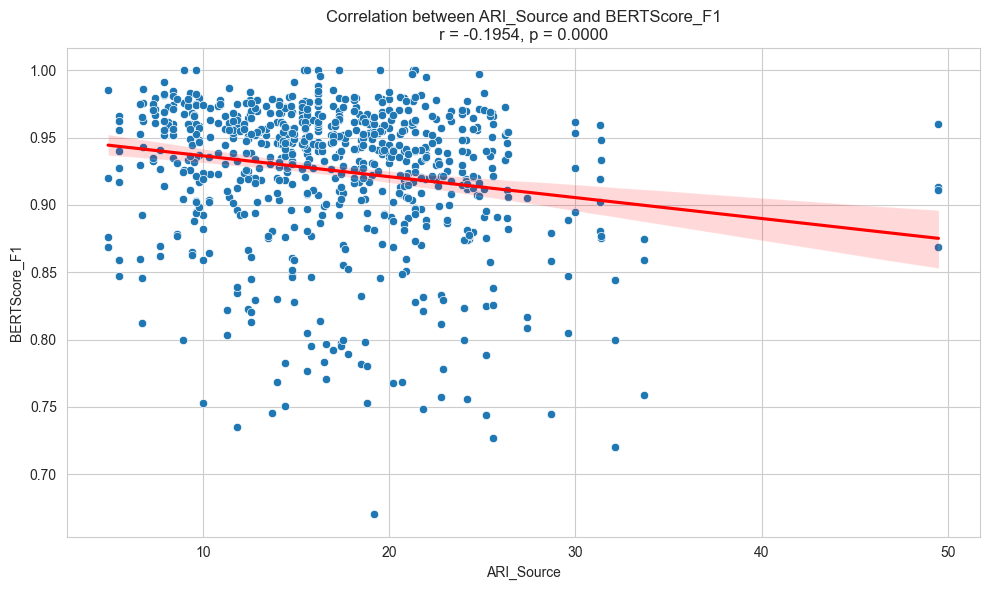

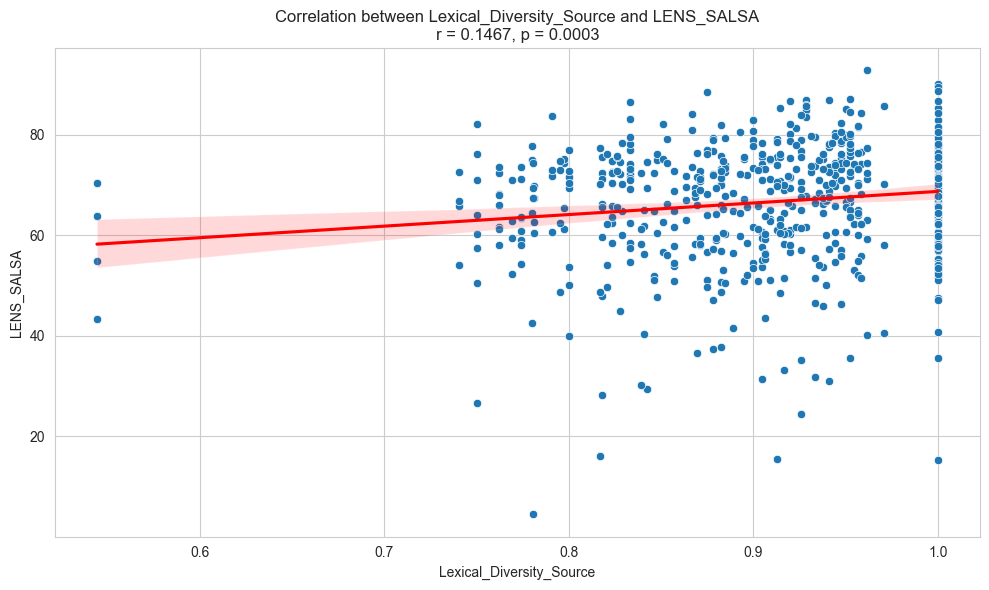

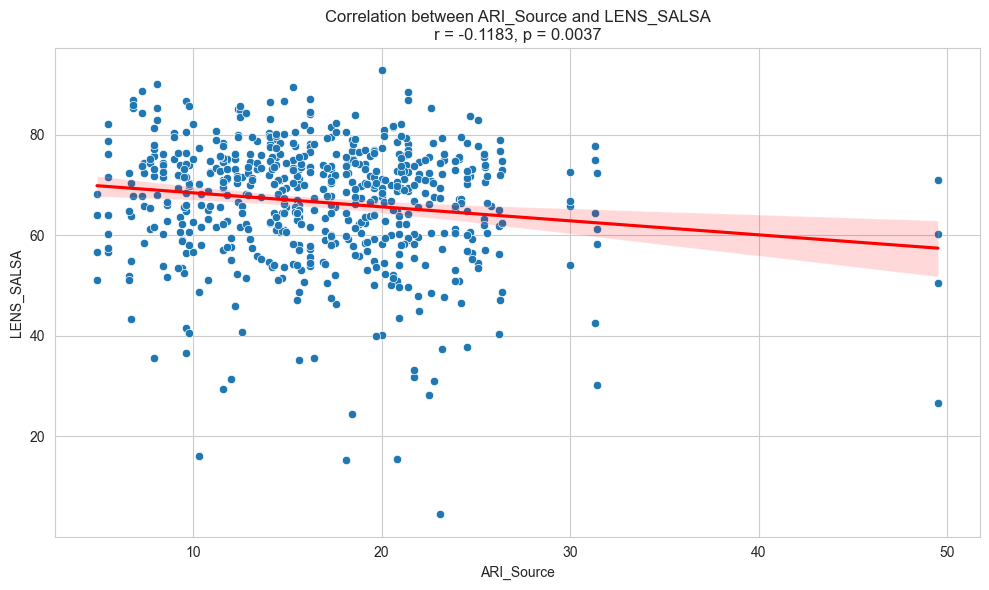

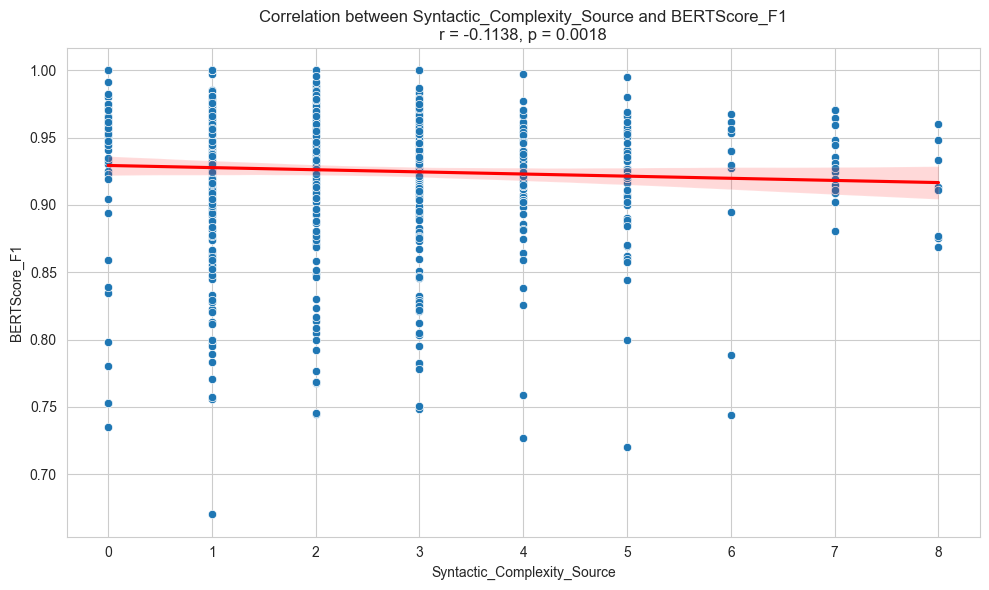

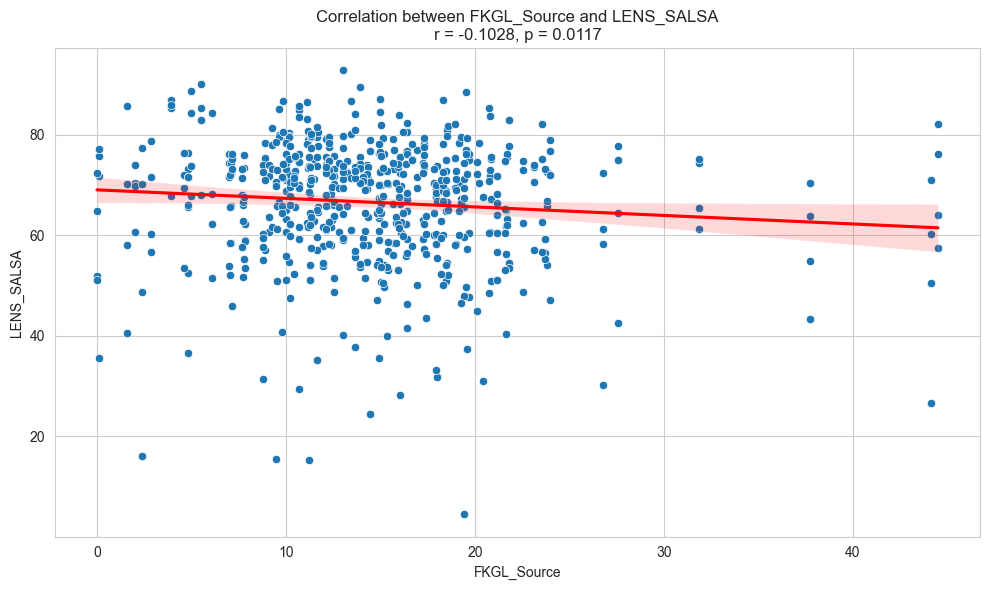

           input_characteristic quality_metric  correlation  p_value  \
3                    ARI_Source   BERTScore_F1        -0.20     0.00   
8      Lexical_Diversity_Source     LENS_SALSA         0.15     0.00   
5                    ARI_Source     LENS_SALSA        -0.12     0.00   
9   Syntactic_Complexity_Source   BERTScore_F1        -0.11     0.00   
2                   FKGL_Source     LENS_SALSA        -0.10     0.01   
0                   FKGL_Source   BERTScore_F1        -0.10     0.01   
10  Syntactic_Complexity_Source           GLEU        -0.09     0.01   

      method effect_size  
3   Spearman       small  
8   Spearman       small  
5   Spearman       small  
9   Spearman       small  
2   Spearman       small  
0   Spearman       small  
10  Spearman  negligible  


In [383]:
result_df, result_df_sign = run_correlation_metrics(df_sentences)

print(result_df_sign)

### Correlation: Operation Frequencies and Complexity Metrics

In [384]:
def analyze_operations_complexity(df, analysis_type='absolute', plot_top_n=3):
    # Define operation types based on analysis type
    base_operation_types = [
        'Substitution_count', 'Insertion_count', 'Split_count', 
        'Structure_count', 'Deletion_count', 'Reorder_count'
    ]
    operation_types = base_operation_types

    if analysis_type == 'absolute':
        df_temp = df.copy()
    
    elif analysis_type == 'relative':
        # Calculate relative frequencies
        df_temp = df.copy()
        operation_types = [] # only focus on freq ones
        for op in base_operation_types:
            freq_col = f'{op}_Freq'
            df_temp[freq_col] = df_temp[op] / df_temp['Total Edits']
            operation_types.append(freq_col)
        print(f"df_temp after relative frequencies: {df_temp}")
    
    elif analysis_type == 'custom':
        df_temp = df
    
    else:
        raise ValueError("analysis_type must be one of: 'absolute', 'relative', 'custom'")

    # Define complexity changes (common across all analysis types)
    complexity_changes = [
        'FKGL_Difference', 'ARI_Difference',
        'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference'
    ]

    # Create correlation results storage
    correlation_results = []

    # Loop through all combinations
    for operation in operation_types:
        for complexity in complexity_changes:
            result = analyze_correlation(
                df_temp, 
                operation,
                complexity,
                category="Operations vs Complexity Changes",
                description=f"Correlation between {operation} and {complexity}"
            )
            
            # Store results
            correlation_results.append({
                'operation': operation,
                'complexity_metric': complexity,
                'correlation': result['correlation_coef'],
                'p_value': result['p_value'],
                'effect_size': result['effect_size']
            })

    # Convert to DataFrame
    correlation_df = pd.DataFrame(correlation_results)

    # Get significant correlations
    significant_correlations = correlation_df[correlation_df['p_value'] < 0.05].sort_values(
        'correlation', 
        key=abs, 
        ascending=False
    )
    
    # Display significant correlations
    display(significant_correlations)

    # Plot top correlations if requested
    if plot_top_n > 0:
        plot_topN_corr(
            significant_correlations, 
            df_temp, 
            plot_top_n,
            var1_col='operation',
            var2_col='complexity_metric'
        )

    return correlation_df, significant_correlations


Correlation Analysis: Substitution_count vs FKGL_Difference

Normality Tests (Shapiro-Wilk):
Substitution_count: p-value = 0.0000 (Non-normal)
FKGL_Difference: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.0150, p-value = 0.6823
Spearman correlation: ρ = 0.0458, p-value = 0.2101

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(748) = 0.05, p = 0.210

Effect size interpretation: negligible
Appending test results for Substitution_count vs FKGL_Difference, p-value: 0.21010297517285864

Correlation Analysis: Substitution_count vs ARI_Difference

Normality Tests (Shapiro-Wilk):
Substitution_count: p-value = 0.0000 (Non-normal)
ARI_Difference: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.0798, p-value = 0.0288
Spearman correlation: ρ = -0.0398, p-value = 0.2758

Recommended correlation method: Spearman
(based on normality tests of the variabl

operation                complexity_metric  correlation  p_value  \
8          Split_count                  FKGL_Difference        -0.57     0.00   
9          Split_count                   ARI_Difference        -0.49     0.00   
18      Deletion_count     Lexical_Diversity_Difference         0.43     0.00   
10         Split_count     Lexical_Diversity_Difference        -0.40     0.00   
2   Substitution_count     Lexical_Diversity_Difference         0.36     0.00   
4      Insertion_count                  FKGL_Difference        -0.35     0.00   
6      Insertion_count     Lexical_Diversity_Difference        -0.34     0.00   
19      Deletion_count  Syntactic_Complexity_Difference        -0.32     0.00   
5      Insertion_count                   ARI_Difference        -0.29     0.00   
14     Structure_count     Lexical_Diversity_Difference         0.18     0.00   
11         Split_count  Syntactic_Complexity_Difference         0.18     0.00   
17      Deletion_count                   ARI_Difference        -0.15     0.00   
16      Deletion_count                  FKGL_Difference        -0.15     0.00   
22       Reorder_count     Lexical_Diversity_Difference        -0.14     0.00   
7      Insertion_count  Syntactic_Complexity_Difference         0.13     0.00   
20       Reorder_count                  FKGL_Difference        -0.11     0.00   
21       Reorder_count                   ARI_Difference        -0.09     0.01   
13     Structure_count                   ARI_Difference        -0.08     0.03   
12     Structure_count                  FKGL_Difference        -0.08     0.03   
3   Substitution_count  Syntactic_Complexity_Difference        -0.08     0.04   

   effect_size  
8        large  
9     moderate  
18    moderate  
10    moderate  
2     moderate  
4     moderate  
6     moderate  
19    moderate  
5        small  
14       small  
11       small  
17       small  
16       small  
22       small  
7        small  
20       small  
21  negligible  
13  negligible  
12  negligible  
3   negligible

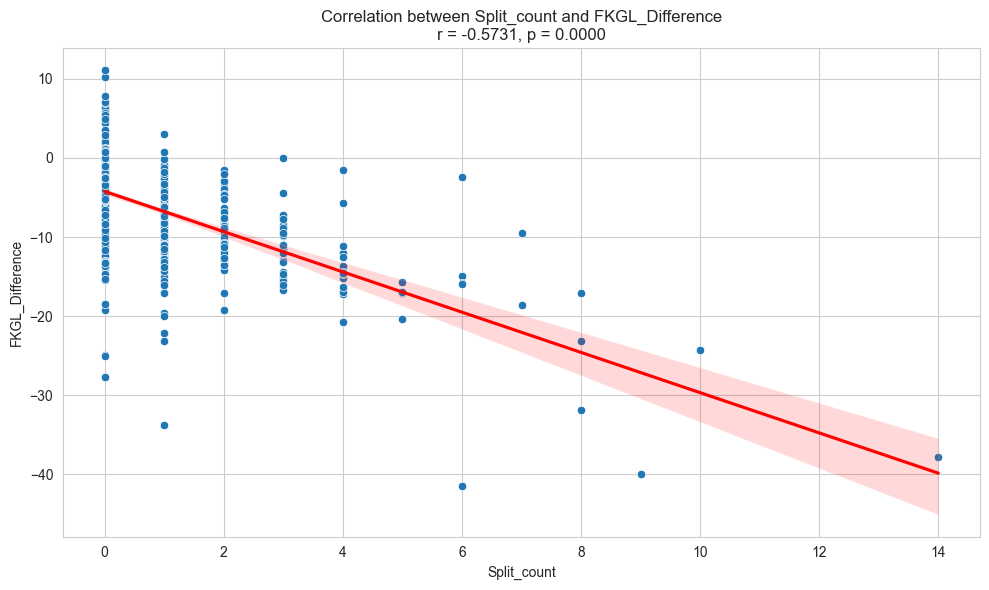

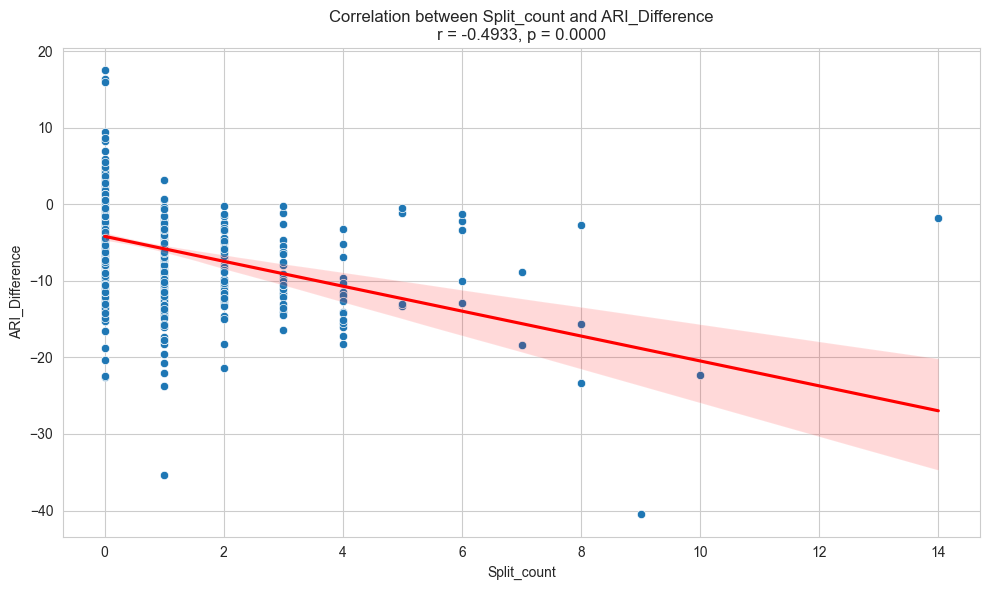

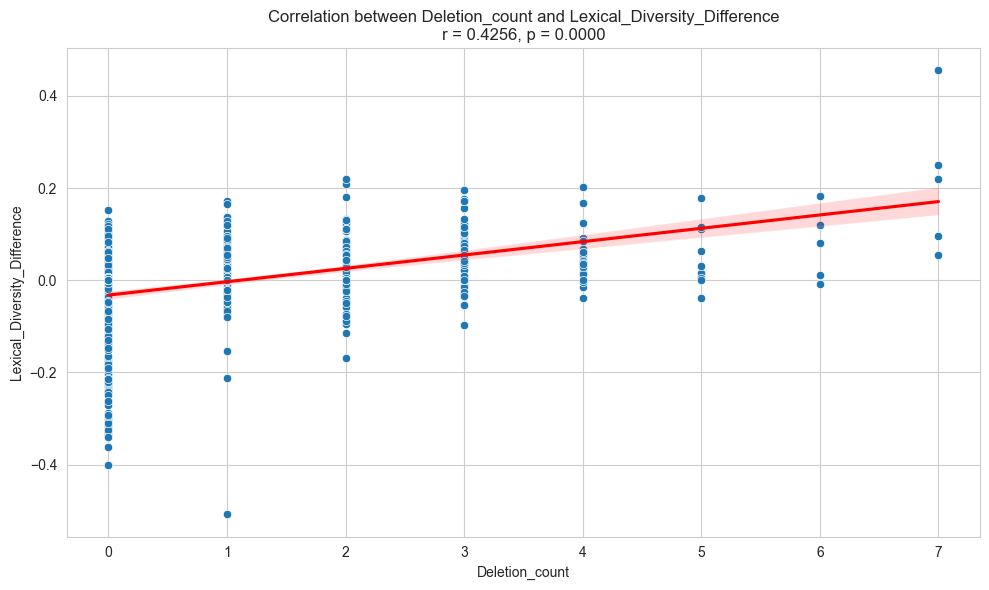

In [385]:
# For absolute counts:
results_abs, sign_results_abs = analyze_operations_complexity(df_sentences, 'absolute')

df_temp after relative frequencies:      Sentence ID                                             Source  \
0    ChatGPT_001  The N1 road also designated as RN1, is a road ...   
1    ChatGPT_002  Originating in the capital city of Bangui, the...   
2    ChatGPT_003  As a key component of the country's road netwo...   
3    ChatGPT_004  The N1 route commences in the heart of Bangui,...   
4    ChatGPT_005  The terrain along this stretch is characterize...   
..           ...                                                ...   
745     MUSS_046  Diese Stadt hatte durch den Niedergang des Koh...   
746     MUSS_047  Am Tag nach den gewalttätigen Ausbrüchen versa...   
747     MUSS_048  Der Tag wurde als Wendepunkt in der Entwicklun...   
748     MUSS_049  Auch in Bristol, das einige Tage zuvor Schaupl...   
749     MUSS_050  Als Reaktion auf die anhaltenden Unruhen veröf...   

                                                Target   System Dataset  \
0    The N1 road, also called RN1, i

operation                complexity_metric  correlation  \
8          Split_count_Freq                  FKGL_Difference        -0.51   
9          Split_count_Freq                   ARI_Difference        -0.43   
10         Split_count_Freq     Lexical_Diversity_Difference        -0.41   
18      Deletion_count_Freq     Lexical_Diversity_Difference         0.39   
6      Insertion_count_Freq     Lexical_Diversity_Difference        -0.38   
0   Substitution_count_Freq                  FKGL_Difference         0.34   
19      Deletion_count_Freq  Syntactic_Complexity_Difference        -0.32   
4      Insertion_count_Freq                  FKGL_Difference        -0.29   
2   Substitution_count_Freq     Lexical_Diversity_Difference         0.26   
1   Substitution_count_Freq                   ARI_Difference         0.22   
5      Insertion_count_Freq                   ARI_Difference        -0.22   
11         Split_count_Freq  Syntactic_Complexity_Difference         0.18   
14     Structure_count_Freq     Lexical_Diversity_Difference         0.15   
7      Insertion_count_Freq  Syntactic_Complexity_Difference         0.14   
22       Reorder_count_Freq     Lexical_Diversity_Difference        -0.13   
15     Structure_count_Freq  Syntactic_Complexity_Difference         0.09   

    p_value effect_size  
8      0.00       large  
9      0.00    moderate  
10     0.00    moderate  
18     0.00    moderate  
6      0.00    moderate  
0      0.00    moderate  
19     0.00    moderate  
4      0.00       small  
2      0.00       small  
1      0.00       small  
5      0.00       small  
11     0.00       small  
14     0.00       small  
7      0.00       small  
22     0.00       small  
15     0.02  negligible

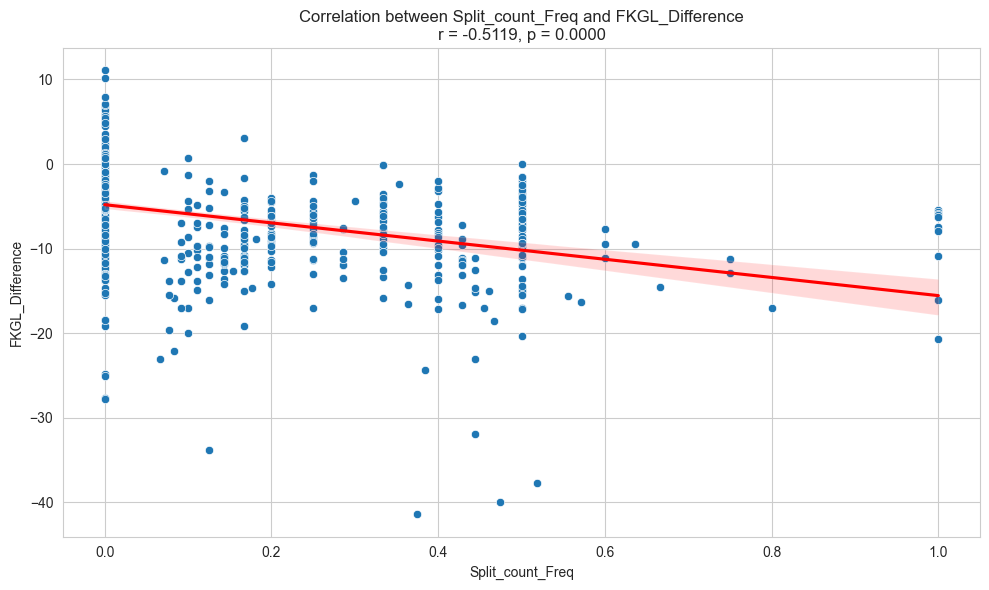

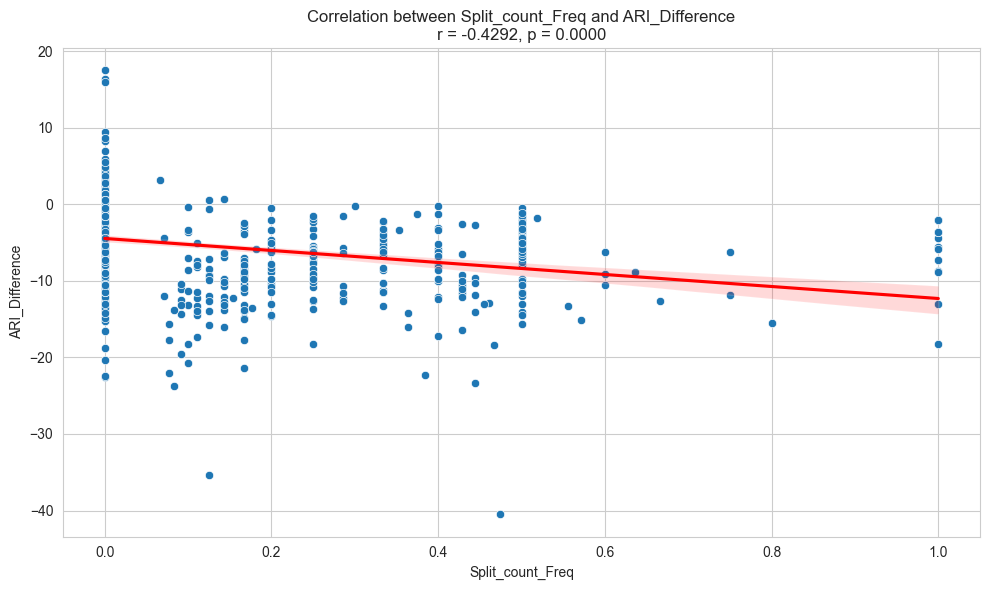

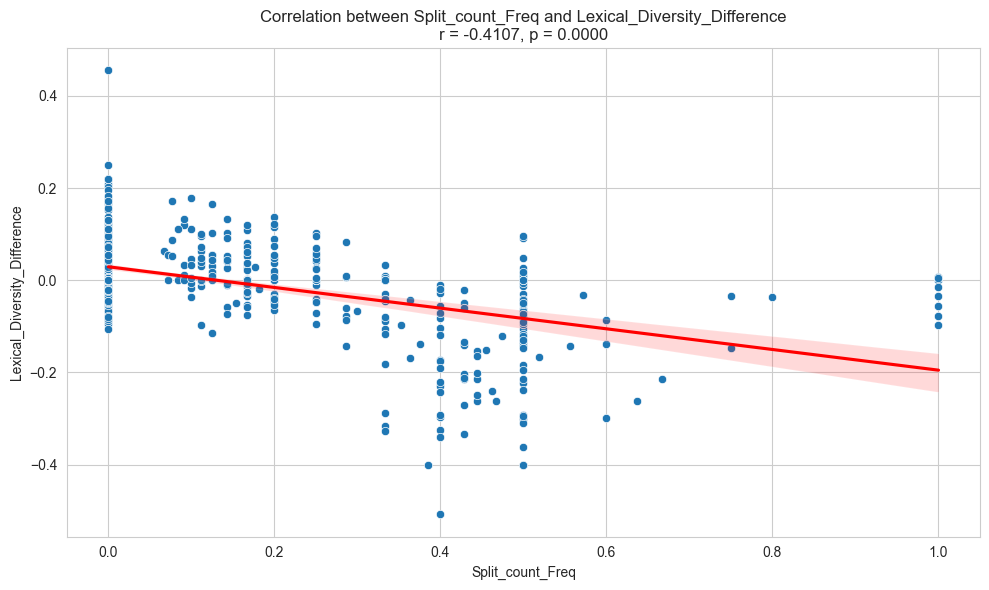

operation                complexity_metric  correlation  \
8          Split_count_Freq                  FKGL_Difference        -0.51   
9          Split_count_Freq                   ARI_Difference        -0.43   
10         Split_count_Freq     Lexical_Diversity_Difference        -0.41   
18      Deletion_count_Freq     Lexical_Diversity_Difference         0.39   
6      Insertion_count_Freq     Lexical_Diversity_Difference        -0.38   
0   Substitution_count_Freq                  FKGL_Difference         0.34   
19      Deletion_count_Freq  Syntactic_Complexity_Difference        -0.32   
4      Insertion_count_Freq                  FKGL_Difference        -0.29   
2   Substitution_count_Freq     Lexical_Diversity_Difference         0.26   
1   Substitution_count_Freq                   ARI_Difference         0.22   
5      Insertion_count_Freq                   ARI_Difference        -0.22   
11         Split_count_Freq  Syntactic_Complexity_Difference         0.18   
14     Structure_count_Freq     Lexical_Diversity_Difference         0.15   
7      Insertion_count_Freq  Syntactic_Complexity_Difference         0.14   
22       Reorder_count_Freq     Lexical_Diversity_Difference        -0.13   
15     Structure_count_Freq  Syntactic_Complexity_Difference         0.09   

    p_value effect_size  
8      0.00       large  
9      0.00    moderate  
10     0.00    moderate  
18     0.00    moderate  
6      0.00    moderate  
0      0.00    moderate  
19     0.00    moderate  
4      0.00       small  
2      0.00       small  
1      0.00       small  
5      0.00       small  
11     0.00       small  
14     0.00       small  
7      0.00       small  
22     0.00       small  
15     0.02  negligible

In [386]:
### Similar analysis, but with relative frequencies of total edits ###

# For relative frequencies:
results_rel, sign_results_rel = analyze_operations_complexity(df_sentences, 'relative')

display(sign_results_rel)

### Cross-Lingual Analysis (RQ1)
- Compare specifically German and English Wiki Datasets

In [387]:
df_s_crosslingual = df_sentences.copy()
df_e_crosslingual = df_edits.copy()

# Filter for wikiEN and wikiDE datasets

df_s_crosslingual = df_s_crosslingual[df_s_crosslingual['Dataset'].isin(['wikiEN', 'wikiDE'])]
df_e_crosslingual = df_e_crosslingual[df_e_crosslingual['Dataset'].isin(['wikiEN', 'wikiDE'])]

# filter out System DisSim
df_s_crosslingual = df_s_crosslingual[df_s_crosslingual['System'] != 'DisSim']
df_e_crosslingual = df_e_crosslingual[df_e_crosslingual['System'] != 'DisSim']

cross_ling_systems = df_s_crosslingual['System'].unique()
cross_ling_systems

array(['ChatGPT', 'LLAMA', 'MUSS'], dtype=object)

#### Operation Type Distribution by Language

In [388]:
# Compare operation frequencies between languages
analyse_operation_frequencies(df_e_crosslingual, 
    by_group='Dataset',  # This will group by wikiEN vs wikiDE
    scope="overall",     # This will analyze across all systems
    category="Language Comparison",
    description="Comparing operation distributions between English and German"
)

Contingency Table for Dataset vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
wikiDE          228         97       86     60         72           276
wikiEN          142         45       31     66         87           340

Chi-square test for independence of Edit Type and Dataset:
--- Chi-square test results: ---
Chi-square statistic: 65.9413
Degrees of freedom: 5
p-value: 0.0000
Cramer's V: 0.2076
Sample size: 1530

APA Format: χ²(5, N = 1530) = 65.94, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
Only two groups are compared. No post-hoc analysis is needed.


In [389]:
# comparison within each system:
analyse_operation_frequencies(df_e_crosslingual, 
    by_group='Dataset', 
    scope="System",      # This will break down the analysis by each system
    category="Language Comparison by System",
    description="Comparing operation distributions between English and German within each system"
)


System: ChatGPT
Contingency Table for Dataset vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
wikiDE           66         13       34     17         30           112
wikiEN           28          9        9     19         34           114

Chi-square test for independence of Edit Type and Dataset:
--- Chi-square test results: ---
Chi-square statistic: 24.1832
Degrees of freedom: 5
p-value: 0.0002
Cramer's V: 0.2233
Sample size: 485

APA Format: χ²(5, N = 485) = 24.18, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
Only two groups are compared. No post-hoc analysis is needed.

System: LLAMA
Contingency Table for Dataset vs Edit Type:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
wikiDE           94         62       

#### Changes in Quality & Characteristic Metrics

In [390]:
def run_multiple_t_tests(df, metrics, group_col, group1, group2, alpha=0.05):
    """
    Runs t-tests for multiple metrics comparing two groups.
    """
    all_results = []
    print(f"Debug: Initializing t-tests for G1: {group1} vs G2: {group2} with metrics: {metrics}")
    
    for metric in metrics:
        print(f"----- METRIC: {metric} -----")
        # Get data for each group
        data1 = df[df[group_col] == group1][metric].dropna()
        data2 = df[df[group_col] == group2][metric].dropna()
        
        # Skip if insufficient data
        if len(data1) < 2 or len(data2) < 2:
            print(f"Skipping {metric} due to insufficient data")
            continue
            
        # Run t-test analysis
        results = run_t_test_analysis(
            data1, data2, metric, alpha, 
            var_names=(group1, group2)
        )
        all_results.append(results)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Add significance indicators
    results_df['significance'] = results_df['p_value'].apply(lambda p: 
        '***' if p <= 0.001 else 
        '**' if p <= 0.01 else 
        '*' if p <= 0.05 else 
        'ns'
    )
    
    # Format mean difference and confidence intervals
    results_df['mean_diff'] = results_df['mean1'] - results_df['mean2']
    
    # Reorder and rename columns
    final_df = results_df[[
        'metric', 'test_type', 'mean_diff', 't_statistic', 'p_value', 
        'significance', 'effect_size', 'cohens_d',
        'normality_ok', 'equal_variance', 
        'n1', 'n2', 'mean1', 'median1', 'mean2', 'median2', 'std1', 'IQR1', 'std2', 'IQR2'
    ]].copy()
    
    # Round numeric columns
    numeric_cols = final_df.select_dtypes(include=[np.number]).columns
    final_df[numeric_cols] = final_df[numeric_cols].round(4)
    
    return final_df

def analyze_cross_lingual_differences(df, metrics, alpha=0.05):
    """
    Analyzes differences between languages for each system.
    """
    results = {}
    
    # Overall analysis
    print("Overall analysis (all systems combined):")
    overall_results = run_multiple_t_tests(
        df, metrics, 'Dataset', 'wikiEN', 'wikiDE', alpha
    )
    results['overall'] = overall_results
    
    # Per-system analysis
    for system in cross_ling_systems:
        print(f"\nAnalysis for {system}:")
        system_df = df[df['System'] == system]
        system_results = run_multiple_t_tests(
            system_df, metrics, 'Dataset', 'wikiEN', 'wikiDE', alpha
        )
        results[system] = system_results

    return results

In [391]:
# Define metrics to analyze
metrics_to_analyze = [
    
    # Changes in characteristics
    'FKGL_Difference', 'ARI_Difference',
    'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference',
    
    # Quality metrics
    'BERTScore_F1', 'GLEU', #'LENS_SALSA'
]

# Run the analysis
# (group 1: EN, group 2: DE)
results = analyze_cross_lingual_differences(
    df_s_crosslingual, 
    metrics_to_analyze)

# Display results
print("\nSignificant results (overall):")
significant_overall = results['overall'][results['overall']['p_value'] < 0.05]
display(significant_overall)

# Display significant results for each system
for system, system_results in results.items():
    if system != 'overall':
        significant = system_results[system_results['p_value'] < 0.05]
        if not significant.empty:
            print(f"\nSignificant results for {system}:")
            display(significant)

Overall analysis (all systems combined):
Debug: Initializing t-tests for G1: wikiEN vs G2: wikiDE with metrics: ['FKGL_Difference', 'ARI_Difference', 'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference', 'BERTScore_F1', 'GLEU']
----- METRIC: FKGL_Difference -----

--- T-test Results Summary ---
Test type: Mann-Whitney U test
Test statistic: 10132.0000
Degrees of freedom: N/A
p-value: 0.1369
Effect size (Cohen's d): 0.1320
Interpretation: negligible effect

--- APA Format Results ---
U = 10132.00, p = 0.137, d = 0.13

--- Full APA Report ---
The analysis revealed a non-significant difference, U = 10132.00, p = 0.137, d = 0.13, such that wikiEN (M = -5.84, SD = 4.88) was less than wikiDE (M = -5.21, SD = 4.74).
----- METRIC: ARI_Difference -----

--- T-test Results Summary ---
Test type: Mann-Whitney U test
Test statistic: 10338.0000
Degrees of freedom: N/A
p-value: 0.2250
Effect size (Cohen's d): 0.0918
Interpretation: negligible effect

--- APA Format Results ---
U = 10338

metric            test_type  mean_diff  \
2     Lexical_Diversity_Difference  Mann-Whitney U test       0.02   
3  Syntactic_Complexity_Difference  Mann-Whitney U test       0.59   
4                     BERTScore_F1  Mann-Whitney U test       0.10   
5                             GLEU  Mann-Whitney U test       0.04   

   t_statistic  p_value significance effect_size  cohens_d  normality_ok  \
2     14089.50     0.00          ***       small      0.42         False   
3     13925.00     0.00          ***       small      0.48         False   
4     20467.00     0.00          ***       large      1.91         False   
5     13212.00     0.01           **       small      0.22         False   

   equal_variance   n1   n2  mean1  median1  mean2  median2  std1  IQR1  std2  \
2           False  150  150   0.04     0.04   0.02     0.00  0.06  0.08  0.05   
3           False  150  150   0.13     0.00  -0.47     0.00  1.02  1.00  1.42   
4           False  150  150   0.95     0.96   0.86     0.86  0.02  0.03  0.07   
5            True  150  150   0.39     0.40   0.35     0.31  0.17  0.25  0.21   

   IQR2  
2  0.04  
3  1.00  
4  0.10  
5  0.29


Significant results for ChatGPT:


metric         test_type  mean_diff  t_statistic  \
2  Lexical_Diversity_Difference  Student's t-test       0.04         3.82   
4                  BERTScore_F1    Welch's t-test       0.08        12.49   
5                          GLEU  Student's t-test       0.06         2.13   

   p_value significance effect_size  cohens_d  normality_ok  equal_variance  \
2     0.00          ***      medium      0.77          True            True   
4     0.00          ***       large      2.52          True           False   
5     0.04            *       small      0.43          True            True   

   n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  IQR2  
2  50  50   0.04     0.04   0.00     0.00  0.05  0.07  0.04  0.04  
4  50  50   0.97     0.96   0.88     0.88  0.01  0.02  0.04  0.07  
5  50  50   0.43     0.42   0.37     0.37  0.15  0.19  0.13  0.18


Significant results for LLAMA:


metric            test_type  mean_diff  t_statistic  \
2  Lexical_Diversity_Difference  Mann-Whitney U test       0.04      1796.00   
4                  BERTScore_F1       Welch's t-test       0.13        15.37   
5                          GLEU  Mann-Whitney U test       0.06      1641.00   

   p_value significance effect_size  cohens_d  normality_ok  equal_variance  \
2     0.00          ***      medium      0.75         False            True   
4     0.00          ***       large      3.11          True           False   
5     0.01           **       small      0.46         False            True   

   n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  IQR2  
2  50  50   0.07     0.06   0.03     0.00  0.06  0.09  0.05  0.05  
4  50  50   0.93     0.93   0.80     0.80  0.03  0.03  0.05  0.07  
5  50  50   0.25     0.24   0.19     0.16  0.14  0.19  0.13  0.13


Significant results for MUSS:


metric            test_type  mean_diff  \
0                  FKGL_Difference  Mann-Whitney U test      -2.12   
1                   ARI_Difference  Mann-Whitney U test      -1.54   
3  Syntactic_Complexity_Difference  Mann-Whitney U test       1.00   
4                     BERTScore_F1  Mann-Whitney U test       0.07   

   t_statistic  p_value significance effect_size  cohens_d  normality_ok  \
0       874.00     0.01           **      medium      0.51         False   
1       957.00     0.04            *       small      0.33         False   
3      1772.50     0.00          ***       large      0.86         False   
4      2091.00     0.00          ***       large      1.53         False   

   equal_variance  n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  \
0            True  50  50  -7.04    -7.97  -4.92    -4.92  4.06  7.25  4.27   
1            True  50  50  -6.65    -6.20  -5.11    -4.50  4.30  7.58  5.06   
3            True  50  50   0.24     0.00  -0.76    -0.50  0.97  1.00  1.32   
4           False  50  50   0.96     0.96   0.88     0.88  0.01  0.02  0.07   

   IQR2  
0  5.43  
1  6.72  
3  1.00  
4  0.10

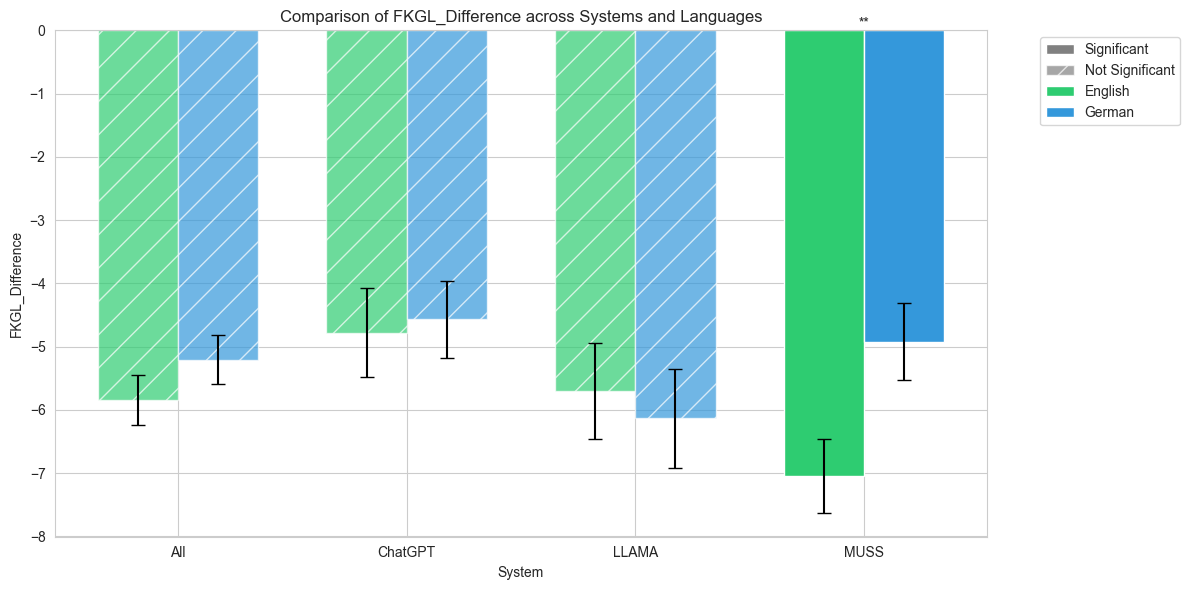

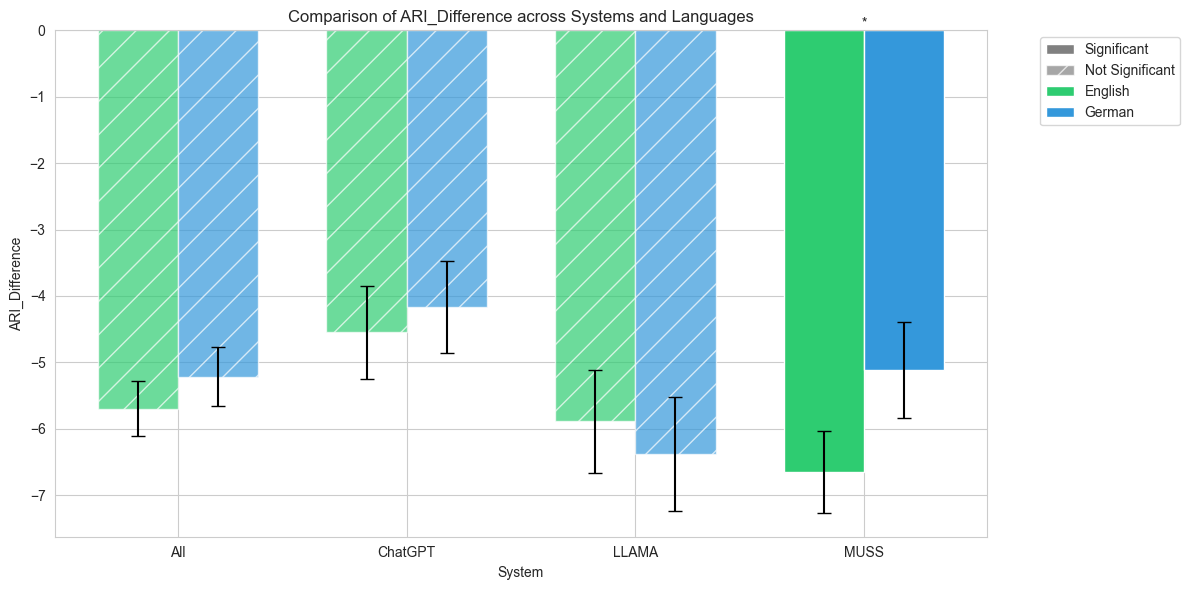

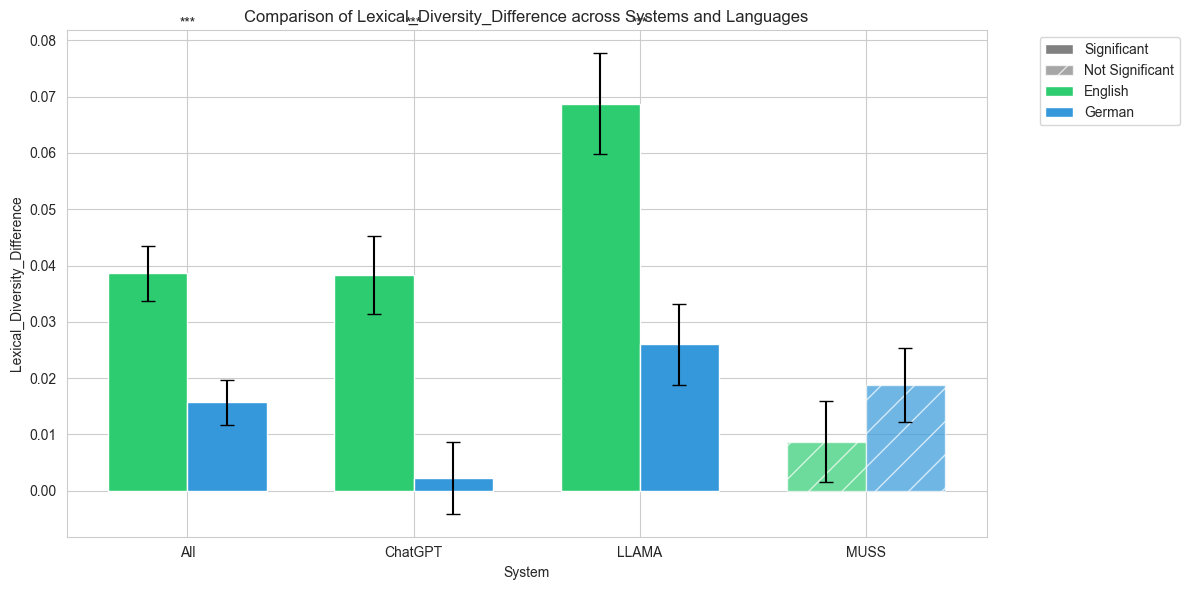

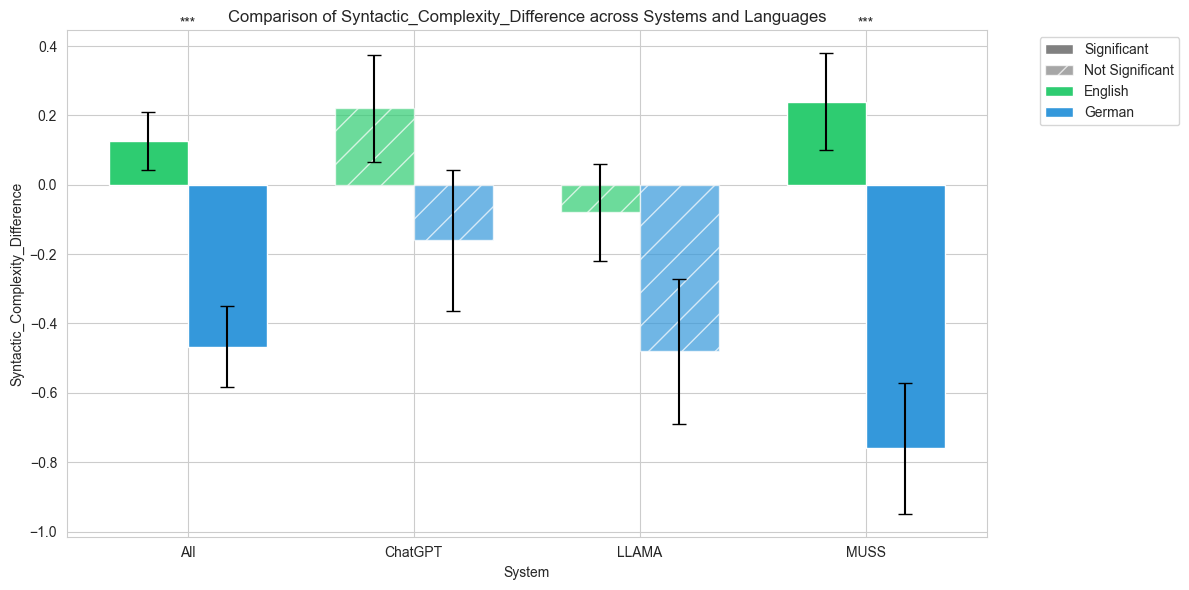

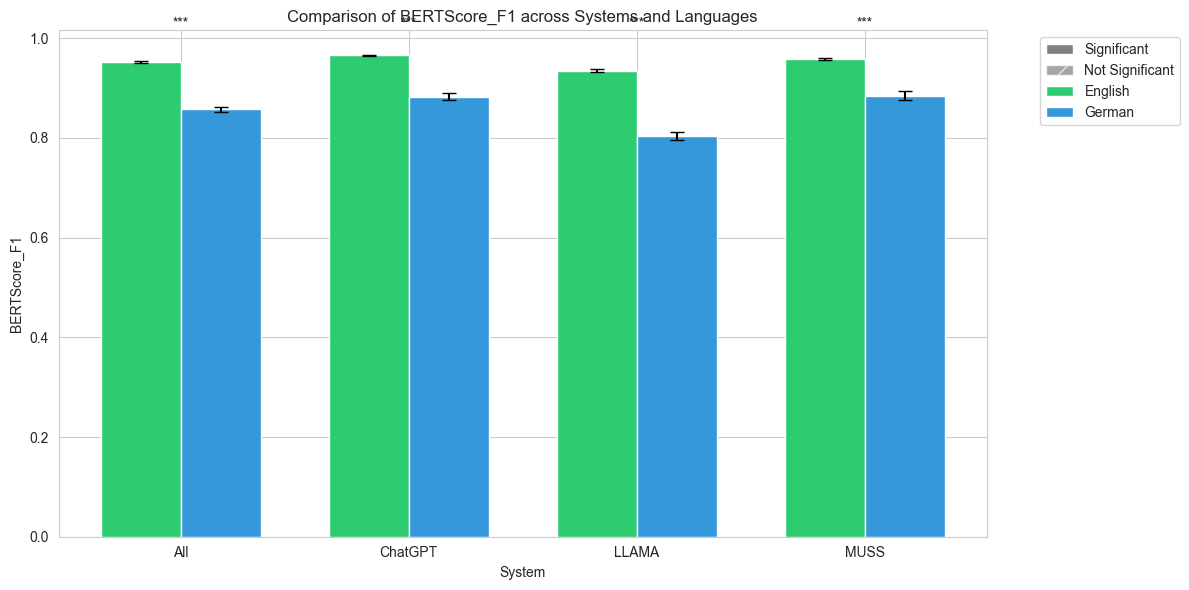

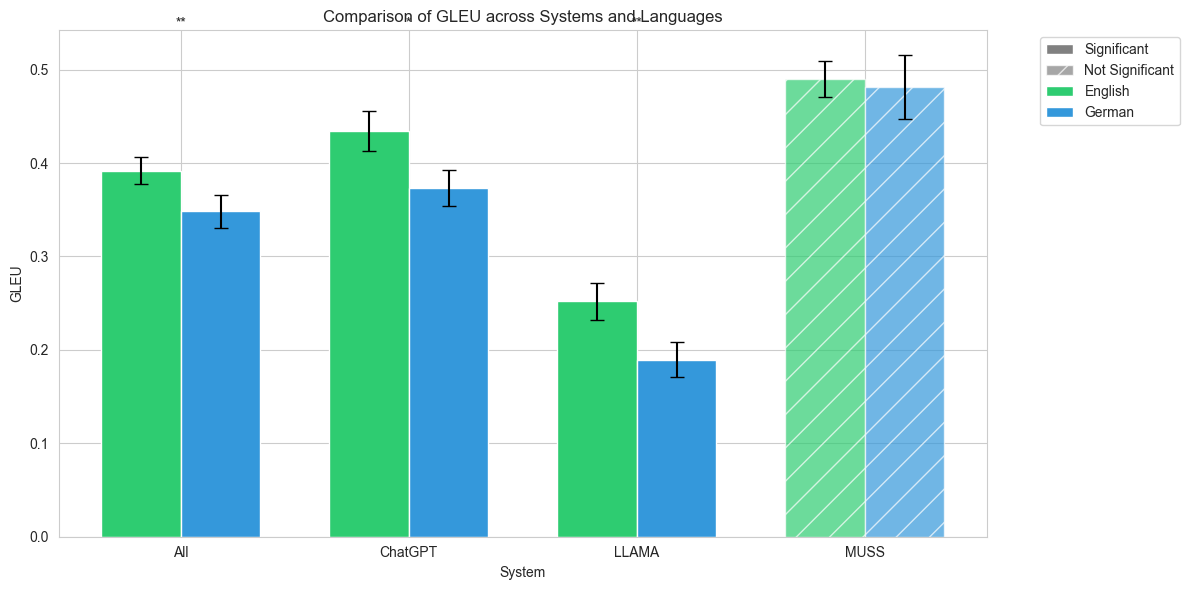

In [392]:
from matplotlib.patches import Patch 


def create_grouped_bar_charts(results_dict, df, metrics, alpha=0.05):
    """
    Creates grouped bar charts comparing all models for each metric.
    Insignificant differences are shown with striped bars.
    """
    colors = {'wikiEN': '#2ecc71', 'wikiDE': '#3498db'}
    
    # Helper function to determine if difference is significant
    def is_significant(system, metric):
        if system == 'All':
            result_df = results_dict['overall']
        else:
            result_df = results_dict[system]
        
        metric_result = result_df[result_df['metric'] == metric]
        if len(metric_result) == 0:
            return False
        return metric_result.iloc[0]['p_value'] < alpha
    
    # Create a plot for each metric
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        
        # Calculate positions for grouped bars
        systems = ['All'] + list(df['System'].unique())
        x = np.arange(len(systems))
        width = 0.35
        
        # Calculate means for each system and dataset
        means = []
        sems = []  # Standard errors of means
        for system in systems:
            system_means = []
            system_sems = []
            for dataset in ['wikiEN', 'wikiDE']:
                if system == 'All':
                    data = df[df['Dataset'] == dataset][metric]
                else:
                    data = df[(df['System'] == system) & 
                             (df['Dataset'] == dataset)][metric]
                system_means.append(data.mean())
                system_sems.append(data.sem())
            means.append(system_means)
            sems.append(system_sems)
        
        # Create bars
        for i, dataset in enumerate(['wikiEN', 'wikiDE']):
            dataset_means = [system_mean[i] for system_mean in means]
            dataset_sems = [system_sem[i] for system_sem in sems]
            
            # Create bars with different styles based on significance
            bars = plt.bar(x + (i-0.5)*width, dataset_means, width, 
                         label=dataset, color=colors[dataset])
            
            # Add error bars
            plt.errorbar(x + (i-0.5)*width, dataset_means, yerr=dataset_sems, 
                        fmt='none', color='black', capsize=5)
            
            # Add hatching for insignificant differences
            for idx, bar in enumerate(bars):
                system = systems[idx]
                if not is_significant(system, metric):
                    bar.set_hatch('/')
                    bar.set_alpha(0.7)
        
        # Customize plot
        plt.xlabel('System')
        plt.ylabel(metric)
        plt.title(f'Comparison of {metric} across Systems and Languages')
        plt.xticks(x, systems)
        plt.legend()
        
        # Add significance markers
        for idx, system in enumerate(systems):
            if is_significant(system, metric):
                sig_level = ''
                if system == 'All':
                    p_val = results_dict['overall'][
                        results_dict['overall']['metric'] == metric
                    ]['p_value'].iloc[0]
                else:
                    p_val = results_dict[system][
                        results_dict[system]['metric'] == metric
                    ]['p_value'].iloc[0]
                
                if p_val < 0.001:
                    sig_level = '***'
                elif p_val < 0.01:
                    sig_level = '**'
                elif p_val < 0.05:
                    sig_level = '*'
                
                if sig_level:
                    plt.text(idx, plt.ylim()[1], sig_level, 
                            horizontalalignment='center', verticalalignment='bottom')
        
        # Add legend for significance
        legend_elements = [
            Patch(facecolor='gray', label='Significant'),
            Patch(facecolor='gray', hatch='/', alpha=0.7, label='Not Significant')
        ]
        plt.legend(handles=legend_elements + [
            Patch(facecolor=colors['wikiEN'], label='English'),
            Patch(facecolor=colors['wikiDE'], label='German')
        ], bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

# Use the function
create_grouped_bar_charts(results, df_s_crosslingual, metrics_to_analyze)

#### Correlation (CrossL)

##### Input characteristics vs. Simpl. Quality metrics

In [393]:
# Run input_error_correlations, but only for wikiEN and wikiDE
import numpy as np
from scipy.stats import norm

def fisher_z_test(r1, r2, n1, n2):
    """
    Performs Fisher's Z-transformation test to compare two correlation coefficients.
    """

    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    
    z_score = (z1 - z2) / se
    
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    
    return z_score, p_value


def analyze_input_error_correlations_by_language(df, input_characteristics=None, error_metrics=None, 
                                               alpha=0.05, print_results=True, plot_differences=True):
    """
    Analyzes and compares correlations between input characteristics and error metrics for DE vs EN.
    """
    if input_characteristics is None:
        input_characteristics = [
            'FKGL_Source', 
            'ARI_Source',
            'Lexical_Diversity_Source', 
            'Syntactic_Complexity_Source',
            'FKGL_Difference',
            'ARI_Difference',
            'Lexical_Diversity_Difference',
            'Syntactic_Complexity_Difference',
            'BERTScore_F1',
            'GLEU',
            #'LENS_SALSA'
        ]
    
    if error_metrics is None:
        error_metrics = ['TotalErrors']
    
    results = []
    
    df_de = df[df['Dataset'] == 'wikiDE']
    df_en = df[df['Dataset'] == 'wikiEN']
    
    for input_char in input_characteristics:
        for error_metric in error_metrics:
            # Calculate correlations for each language
            de_result = analyze_correlation(df_de, input_char, error_metric)
            en_result = analyze_correlation(df_en, input_char, error_metric)
            
            # Perform Fisher's Z-test
            z_score, p_value = fisher_z_test(
                de_result['correlation_coef'],
                en_result['correlation_coef'],
                len(df_de),
                len(df_en)
            )
            
            results.append({
                'input_characteristic': input_char,
                'error_metric': error_metric,
                'de_correlation': de_result['correlation_coef'],
                'de_p_value': de_result['p_value'],
                'de_effect': de_result['effect_size'],
                'en_correlation': en_result['correlation_coef'],
                'en_p_value': en_result['p_value'],
                'en_effect': en_result['effect_size'],
                'correlation_diff': de_result['correlation_coef'] - en_result['correlation_coef'],
                'z_score': z_score,
                'diff_p_value': p_value
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find significant differences
    sig_diff = results_df[results_df['diff_p_value'] < alpha].copy()
    sig_diff['significance'] = sig_diff['diff_p_value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*'
    )
    
    if print_results:
        print("\nSignificant differences in correlations between DE and EN:")
        if len(sig_diff) > 0:
            display(sig_diff[[
                'input_characteristic', 'error_metric',
                'de_correlation', 'en_correlation', 'correlation_diff',
                'diff_p_value', 'significance'
            ]].sort_values('diff_p_value'))
        else:
            print("No significant differences found.")
    
    if plot_differences and len(sig_diff) > 0:
        plot_correlation_differences(results_df, df_de, df_en, alpha)
    
    return {
        'all_results': results_df,
        'significant_differences': sig_diff
    }

def plot_correlation_differences(results_df, df_de, df_en, alpha=0.05):
    """
    Creates visualization comparing correlation patterns between languages.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Select significant differences
    sig_diff = results_df[results_df['diff_p_value'] < alpha].copy()
    
    if len(sig_diff) > 0:
        # Create correlation comparison plot
        plt.figure(figsize=(12, 6))
        
        # Plot correlation values
        x = np.arange(len(sig_diff))
        width = 0.35
        
        plt.bar(x - width/2, sig_diff['de_correlation'], width, 
               label='German', color='skyblue')
        plt.bar(x + width/2, sig_diff['en_correlation'], width,
               label='English', color='lightcoral')
        
        # Customize plot
        plt.xlabel('Input Characteristic - Error Metric Pair')
        plt.ylabel('Correlation Coefficient')
        plt.title('Comparison of Correlations between Languages')
        plt.xticks(x, [f"{row['input_characteristic']}\n{row['error_metric']}" 
                      for _, row in sig_diff.iterrows()],
                  rotation=45, ha='right')
        plt.legend()
        
        # Add significance markers
        for i, row in enumerate(sig_diff.itertuples()):
            plt.text(i, max(row.de_correlation, row.en_correlation) + 0.05,
                    '*' * (3 if row.diff_p_value < 0.001 else 
                          2 if row.diff_p_value < 0.01 else 1),
                    ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Create scatterplots for significant pairs
        for _, row in sig_diff.iterrows():
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # German plot
            sns.regplot(data=df_de, 
                       x=row['input_characteristic'], 
                       y=row['error_metric'],
                       ax=ax1, color='skyblue')
            ax1.set_title(f'German (r={row["de_correlation"]:.3f})')
            
            # English plot
            sns.regplot(data=df_en,
                       x=row['input_characteristic'],
                       y=row['error_metric'],
                       ax=ax2, color='lightcoral')
            ax2.set_title(f'English (r={row["en_correlation"]:.3f})')
            
            plt.suptitle(f'{row["input_characteristic"]} vs {row["error_metric"]}\n' +
                        f'Correlation Difference p={row["diff_p_value"]:.4f}')
            plt.tight_layout()
            plt.show()

# Usage
results = analyze_input_error_correlations_by_language(df_s_crosslingual, alpha=0.05)


Correlation Analysis: FKGL_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0646 (Normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.0855, p-value = 0.2981
Spearman correlation: ρ = 0.0626, p-value = 0.4468

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(148) = 0.06, p = 0.447

Effect size interpretation: negligible
Appending test results for FKGL_Source vs TotalErrors, p-value: 0.4467830702050566

Correlation Analysis: FKGL_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0553 (Normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.2037, p-value = 0.0124
Spearman correlation: ρ = 0.1464, p-value = 0.0738

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(148) = 0.15, p

##### Operation frequencies vs. complexity changes

In [394]:
def analyze_operations_complexity_by_language(df, analysis_type='absolute', alpha=0.05):
    """
    Analyzes and compares correlations between operations and complexity changes for DE vs EN.
    """
    base_operation_types = [
            'Substitution_count', 'Insertion_count', 'Split_count', 
        'Structure_count', 'Deletion_count', 'Reorder_count'
        ]
    # Define operation types based on analysis type
    if analysis_type == 'absolute':
        operation_types = base_operation_types
        df_temp = df
    elif analysis_type == 'relative':
        # Calculate relative frequencies
        df_temp = df.copy()
        operation_types = []
        for op in base_operation_types:
            freq_col = f'{op}_Freq'
            df_temp[freq_col] = df_temp[op] / df_temp['Total Edits']
            operation_types.append(freq_col)
    else:
        raise ValueError("analysis_type must be 'absolute' or 'relative'")

    # Define complexity changes
    complexity_changes = [
        'FKGL_Difference', 'ARI_Difference',
        'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference'
    ]

    # Split data by language
    df_de = df_temp[df_temp['Dataset'] == 'wikiDE']
    df_en = df_temp[df_temp['Dataset'] == 'wikiEN']
    
    results = []
    
    # Analyze correlations for each combination
    for operation in operation_types:
        for complexity in complexity_changes:
            # Calculate correlations for each language
            de_result = analyze_correlation(df_de, operation, complexity)
            en_result = analyze_correlation(df_en, operation, complexity)
            
            # Perform Fisher's Z-test
            z_score, p_value = fisher_z_test(
                de_result['correlation_coef'],
                en_result['correlation_coef'],
                len(df_de),
                len(df_en)
            )
            
            results.append({
                'operation': operation,
                'complexity_metric': complexity,
                'de_correlation': de_result['correlation_coef'],
                'de_p_value': de_result['p_value'],
                'de_effect': de_result['effect_size'],
                'en_correlation': en_result['correlation_coef'],
                'en_p_value': en_result['p_value'],
                'en_effect': en_result['effect_size'],
                'correlation_diff': de_result['correlation_coef'] - en_result['correlation_coef'],
                'z_score': z_score,
                'diff_p_value': p_value
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find significant differences
    sig_diff = results_df[results_df['diff_p_value'] < alpha].copy()
    sig_diff['significance'] = sig_diff['diff_p_value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*'
    )
    
    # Display results
    print(f"\nSignificant differences in correlations between DE and EN ({analysis_type} analysis):")
    if len(sig_diff) > 0:
        display(sig_diff[[
            'operation', 'complexity_metric',
            'de_correlation', 'en_correlation', 'correlation_diff',
            'diff_p_value', 'significance'
        ]].sort_values('diff_p_value'))
    else:
        print("No significant differences found.")
    

    return {
        'all_results': results_df,
        'significant_differences': sig_diff
    }

In [395]:
# For absolute counts
results_abs = analyze_operations_complexity_by_language(df_s_crosslingual, 'absolute')


Correlation Analysis: Substitution_count vs FKGL_Difference

Normality Tests (Shapiro-Wilk):
Substitution_count: p-value = 0.0000 (Non-normal)
FKGL_Difference: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.2472, p-value = 0.0023
Spearman correlation: ρ = -0.1365, p-value = 0.0959

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(148) = -0.14, p = 0.096

Effect size interpretation: small
Appending test results for Substitution_count vs FKGL_Difference, p-value: 0.09586780384880485

Correlation Analysis: Substitution_count vs FKGL_Difference

Normality Tests (Shapiro-Wilk):
Substitution_count: p-value = 0.0000 (Non-normal)
FKGL_Difference: p-value = 0.0186 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.2062, p-value = 0.0114
Spearman correlation: ρ = -0.1912, p-value = 0.0191

Recommended correlation method: Spearman
(based on normality tests of the variabl

operation                complexity_metric  de_correlation  \
10         Split_count     Lexical_Diversity_Difference            0.18   
22       Reorder_count     Lexical_Diversity_Difference           -0.07   
3   Substitution_count  Syntactic_Complexity_Difference            0.16   

    en_correlation  correlation_diff  diff_p_value significance  
10           -0.14              0.32          0.01           **  
22            0.24             -0.31          0.01           **  
3            -0.07              0.23          0.05            *

In [396]:
# For relative frequencies
results_rel = analyze_operations_complexity_by_language(df_s_crosslingual, 'relative')


Correlation Analysis: Substitution_count_Freq vs FKGL_Difference

Normality Tests (Shapiro-Wilk):
Substitution_count_Freq: p-value = 0.0000 (Non-normal)
FKGL_Difference: p-value = 0.0001 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.1811, p-value = 0.0287
Spearman correlation: ρ = 0.1694, p-value = 0.0409

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(144) = 0.17, p = 0.041

Effect size interpretation: small
Appending test results for Substitution_count_Freq vs FKGL_Difference, p-value: 0.0409338335987848

Correlation Analysis: Substitution_count_Freq vs FKGL_Difference

Normality Tests (Shapiro-Wilk):
Substitution_count_Freq: p-value = 0.0026 (Non-normal)
FKGL_Difference: p-value = 0.0186 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.2589, p-value = 0.0014
Spearman correlation: ρ = 0.2638, p-value = 0.0011

Recommended correlation method: Spearman
(based on normality t

operation                complexity_metric  de_correlation  \
22    Reorder_count_Freq     Lexical_Diversity_Difference           -0.10   
10      Split_count_Freq     Lexical_Diversity_Difference            0.14   
15  Structure_count_Freq  Syntactic_Complexity_Difference           -0.03   

    en_correlation  correlation_diff  diff_p_value significance  
22            0.23             -0.33          0.00           **  
10           -0.15              0.29          0.01            *  
15            0.23             -0.26          0.02            *

## Error Categories and Distributions (RQ2)

### Error (Bad Edit) Analysis

#### Error (Bad Edit) Rates Overall

In [397]:
df_sentences_bad_relative.head()

Sentence ID MIX  Total Bad Edits  Total Edits  error_rate   System  \
0  ChatGPT_001_cochrane             2.00            5        0.40  ChatGPT   
1    ChatGPT_001_scotus             1.00            8        0.12  ChatGPT   
2    ChatGPT_001_wikiDE             0.00            5        0.00  ChatGPT   
3    ChatGPT_001_wikiEN             0.00            4        0.00  ChatGPT   
4  ChatGPT_002_cochrane             1.00            3        0.33  ChatGPT   

    Dataset  Sentence ID  Sentence ID NUM  
0  cochrane  ChatGPT_001                1  
1    scotus  ChatGPT_001                1  
2    wikiDE  ChatGPT_001                1  
3    wikiEN  ChatGPT_001                1  
4  cochrane  ChatGPT_002                2

Analysis Parameters:
Test type: ANOVARM
Comparison: System vs error_rate
Number of System categories: 4


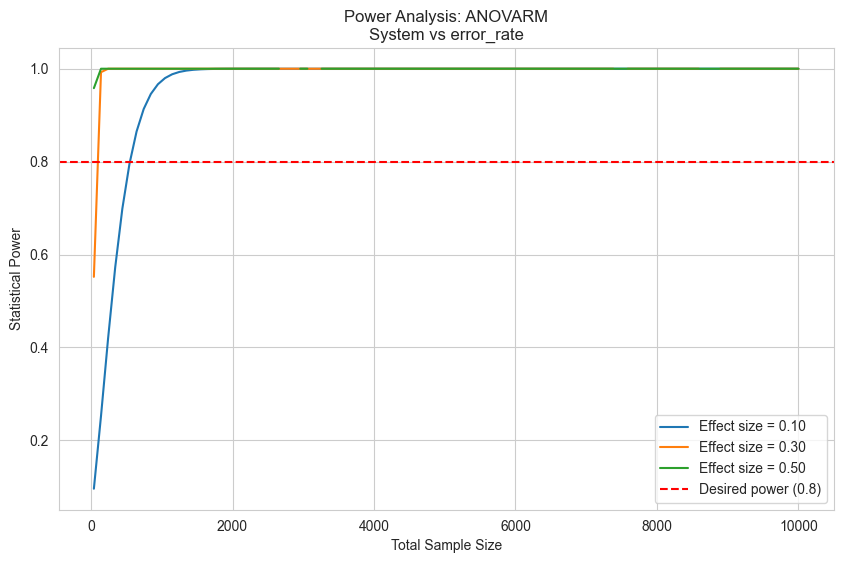


Power Analysis Results:
 effect_size  adjusted_effect_size  total_sample_size  per_condition_size effect_size_interpretation
        0.10                  0.14                552                 138                      small
        0.30                  0.42                 68                  17                      large
        0.50                  0.71                 28                   7                      large

Actual sample sizes:
Total: 750

Per group:
System
ChatGPT    200
DisSim     150
LLAMA      200
MUSS       200

Achieved Power with Current Sample Size:
Effect size 0.10: 0.916
Effect size 0.30: 1.000
Effect size 0.50: 1.000


In [398]:
# Power Analysis for ANOVA (error_rate across Systems)
power_results_error_rate = analyze_power_requirements(
    df_sentences_bad_relative, 
    test_type='anovaRM',
    group_col='System', 
    value_col='error_rate',
    n_conditions=4,
)

In [399]:
def visualize_error_rates(df, group_by='System', results=None, alpha=0.05):
    """
    Creates boxplot visualization of error rates with significance indicators.
    """
    plt.figure(figsize=(12, 6))
    
    # Create basic boxplot
    ax = sns.boxplot(
        data=df,
        x=group_by,
        y='error_rate',
        palette='muted'
    )
    
    # Add individual points
    sns.stripplot(
        data=df,
        x=group_by,
        y='error_rate',
        color='red',
        alpha=0.3,
        size=4,
        jitter=0.2
    )
    
    # Customize plot
    plt.title(f'Distribution of Error Rates by {group_by}', fontsize=12, pad=20)
    plt.xlabel(group_by, fontsize=10)
    plt.ylabel('Error Rate', fontsize=10)
    
    # If we have statistical results, add significance indicators
    if results and hasattr(results, 'post_hoc'):
        # Get the post-hoc test results
        post_hoc = results.post_hoc
        
        # Get y-axis limits for placing significance bars
        y_max = df['error_rate'].max()
        y_range = df['error_rate'].max() - df['error_rate'].min()
        
        # Add significance bars and asterisks
        groups = sorted(df[group_by].unique())
        for i, group1 in enumerate(groups):
            for j, group2 in enumerate(groups[i+1:], i+1):
                if post_hoc.loc[group1, group2] < alpha:
                    # Determine significance level
                    if post_hoc.loc[group1, group2] < 0.001:
                        sig = '***'
                    elif post_hoc.loc[group1, group2] < 0.01:
                        sig = '**'
                    else:
                        sig = '*'
                    
                    # Calculate bar position
                    bar_height = y_max + (j-i) * y_range * 0.05
                    
                    # Draw significance bar
                    plt.plot([i, j], [bar_height, bar_height], 'k-')
                    plt.text((i+j)/2, bar_height, sig, ha='center', va='bottom')
    
    # Add significance level legend
    plt.figtext(0.99, 0.01,
               '* p<0.05, ** p<0.01, *** p<0.001',
               ha='right', va='bottom', fontsize=8)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [400]:
# show mean and median error rates by system, with SD and IQR
df_temp_1 = df_sentences_bad_relative.groupby('System')['error_rate'].agg(
    ['mean', 'median', 'std', 
    'count', 
    ]
)
# calculate IQR
df_temp_IQR = df_sentences_bad_relative.groupby('System')['error_rate'].quantile([0.25, 0.75]).unstack()
df_temp_IQR['IQR'] = df_temp_IQR[0.75] - df_temp_IQR[0.25]
df_temp_1 = pd.concat([df_temp_1, df_temp_IQR], axis=1)

df_temp_1.drop([0.75, 0.25], axis=1, inplace=True)
df_temp_1.reset_index(inplace=True)
df_temp_1 = df_temp_1[['System', 'mean', 'median', 'std', 'IQR', 'count']]

df_temp_1 = df_temp_1.sort_values('mean')

# to latex
#df_to_enhanced_latex(df_temp_1, caption="Error Rates by System", label="tab:error_rates_system")
df_temp_1

System  mean  median  std  IQR  count
0  ChatGPT  0.12    0.00 0.17 0.20    200
2    LLAMA  0.28    0.25 0.21 0.26    200
3     MUSS  0.33    0.33 0.29 0.50    200
1   DisSim  0.47    0.50 0.31 0.42    150


Analysis of Error Rates by System:
: Error rates table:
         mean  median  std
System                    
ChatGPT  0.12    0.00 0.17
DisSim   0.47    0.50 0.31
LLAMA    0.28    0.25 0.21
MUSS     0.33    0.33 0.29

Repeated Measures ANOVA: Analyzing error_rate grouped by System, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 3.2704086654276917e-18
Group ChatGPT: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 4.00234832513059e-06
Group DisSim: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 8.919310737427562e-08
Group LLAMA: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 9.90428046903875e-11
Group MUSS: Not normal (p = 0.0000)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns System, values error_rate
Mauchly's test: W = 0.8040, chi2 = 32.2235, dof = 5, p-value = 0.0000
Sphericity assumption is violated. A correction (Greenhouse-Geisser) will be applied (if normality is still

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/2181337392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


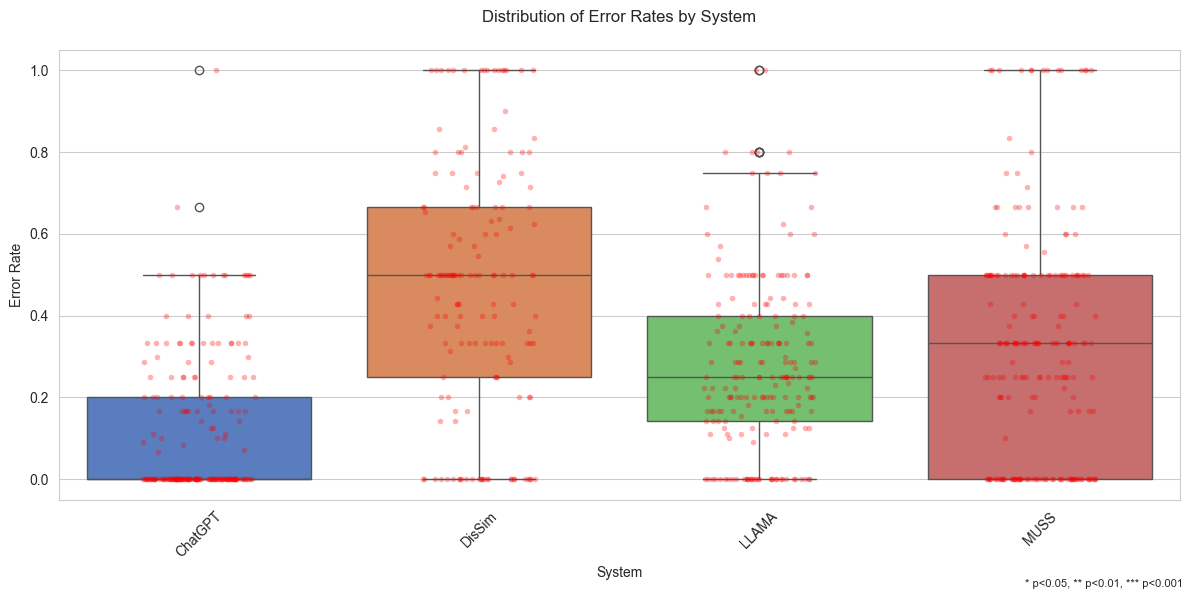

In [401]:
def analyze_error_rates(df, group_by='System', identifier_posthoc="SubjectID"):
    print(f"\nAnalysis of Error Rates by {group_by}:")

    print(f": Error rates table:")
    print(df.groupby(group_by)['error_rate'].agg(
    ['mean', 'median', 'std']
))


    results = run_comprehensive_RM_anova(df, group_by, 'error_rate', identifier_posthoc=identifier_posthoc)
    print(results)
    # Create visualization if results are significant
    if results and results['p_value'] < 0.05:
        visualize_error_rates(df, group_by, results)

analyze_error_rates(df_sentences_bad_relative, group_by='System')

In [402]:
df_sentences_bad_relative

Sentence ID MIX  Total Bad Edits  Total Edits  error_rate   System  \
0    ChatGPT_001_cochrane             2.00            5        0.40  ChatGPT   
1      ChatGPT_001_scotus             1.00            8        0.12  ChatGPT   
2      ChatGPT_001_wikiDE             0.00            5        0.00  ChatGPT   
3      ChatGPT_001_wikiEN             0.00            4        0.00  ChatGPT   
4    ChatGPT_002_cochrane             1.00            3        0.33  ChatGPT   
..                    ...              ...          ...         ...      ...   
745       MUSS_049_wikiEN             1.00            1        1.00     MUSS   
746     MUSS_050_cochrane             1.00            3        0.33     MUSS   
747       MUSS_050_scotus             2.00            4        0.50     MUSS   
748       MUSS_050_wikiDE             1.00            3        0.33     MUSS   
749       MUSS_050_wikiEN             1.00            3        0.33     MUSS   

      Dataset  Sentence ID  Sentence ID NUM    SubjectID  
0    cochrane  ChatGPT_001                1   cochrane_1  
1      scotus  ChatGPT_001                1     scotus_1  
2      wikiDE  ChatGPT_001                1     wikiDE_1  
3      wikiEN  ChatGPT_001                1     wikiEN_1  
4    cochrane  ChatGPT_002                2   cochrane_2  
..        ...          ...              ...          ...  
745    wikiEN     MUSS_049               49    wikiEN_49  
746  cochrane     MUSS_050               50  cochrane_50  
747    scotus     MUSS_050               50    scotus_50  
748    wikiDE     MUSS_050               50    wikiDE_50  
749    wikiEN     MUSS_050               50    wikiEN_50  

[750 rows x 9 columns]

In [403]:
# show mean and median error rates by DATASET, with SD and IQR
df_temp_1 = df_sentences_bad_relative.groupby('Dataset')['error_rate'].agg(
    ['mean', 'median', 'std', 
    'count', 
    ]
)
# calculate IQR
df_temp_IQR = df_sentences_bad_relative.groupby('Dataset')['error_rate'].quantile([0.25, 0.75]).unstack()
df_temp_IQR['IQR'] = df_temp_IQR[0.75] - df_temp_IQR[0.25]
df_temp_1 = pd.concat([df_temp_1, df_temp_IQR], axis=1)


df_temp_1.drop([0.75, 0.25], axis=1, inplace=True)
df_temp_1.reset_index(inplace=True)
df_temp_1 = df_temp_1[['Dataset', 'mean', 'median', 'std', 'IQR', 'count']]

df_temp_1 = df_temp_1.sort_values('mean')

# to latex
#df_to_enhanced_latex(df_temp_1, caption="Error Rates by Dataset", label="tab:error_rates_dataset")
df_temp_1

Dataset  mean  median  std  IQR  count
2    wikiDE  0.25    0.20 0.28 0.40    150
1    scotus  0.28    0.24 0.27 0.50    200
0  cochrane  0.29    0.25 0.29 0.50    200
3    wikiEN  0.32    0.33 0.26 0.50    200

In [404]:
# same analysis, but instead divided by dataset ("domain specific")
analyze_error_rates(df_sentences_bad_relative, group_by='Dataset')


Analysis of Error Rates by Dataset:
: Error rates table:
          mean  median  std
Dataset                    
cochrane  0.29    0.25 0.29
scotus    0.28    0.24 0.27
wikiDE    0.25    0.20 0.28
wikiEN    0.32    0.33 0.26

Repeated Measures ANOVA: Analyzing error_rate grouped by Dataset, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 2.6139449703901428e-12
Group cochrane: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 4.1060121313089054e-11
Group scotus: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 5.080561679996057e-12
Group wikiDE: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 2.9001075032454992e-09
Group wikiEN: Not normal (p = 0.0000)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns Dataset, values error_rate
Error during sphericity test: Index contains duplicate entries, cannot reshape

Normality assumptions are not met. Proceeding with the Friedman test.
DEBUG: run

Examining within one dataset difference in error rates
Dataset: wikiEN

Analysis of Error Rates by System:
: Error rates table:
         mean  median  std
System                    
ChatGPT  0.17    0.00 0.22
DisSim   0.41    0.40 0.28
LLAMA    0.37    0.33 0.22
MUSS     0.33    0.33 0.26

Repeated Measures ANOVA: Analyzing error_rate grouped by System, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 1.507539019848417e-07
Group ChatGPT: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 0.010627017377730377
Group DisSim: Not normal (p = 0.0106)
Shapiro-Wilk test p-value: 0.040087066856940204
Group LLAMA: Not normal (p = 0.0401)
Shapiro-Wilk test p-value: 0.0007207093954506047
Group MUSS: Not normal (p = 0.0007)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns System, values error_rate


/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)


Mauchly's test: W = 0.8608, chi2 = 7.1509, dof = 5, p-value = 0.2097
Sphericity assumption is met.

Normality assumptions are not met. Proceeding with the Friedman test.
DEBUG: running pivot with index System, columns error_rate, values SubjectID
DEBUG: data_pivot_T BEFORE drop: 
Sentence ID NUM     1      2      3      4      5      6      7      8   \
Dataset         wikiEN wikiEN wikiEN wikiEN wikiEN wikiEN wikiEN wikiEN   
System                                                                    
ChatGPT           0.00   0.29   0.20   0.00   0.20   0.10   0.00   0.33   
DisSim            0.50   0.40   0.57   0.29   1.00   0.31   0.25   0.33   
LLAMA             1.00   0.43   0.20   0.17   0.27   0.36   0.00   0.25   
MUSS              0.67   0.00   0.00   0.29   0.40   0.20   0.50   0.25   

Sentence ID NUM     9      10  ...     41     42     43     44     45     46  \
Dataset         wikiEN wikiEN  ... wikiEN wikiEN wikiEN wikiEN wikiEN wikiEN   
System                         ..

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/2181337392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


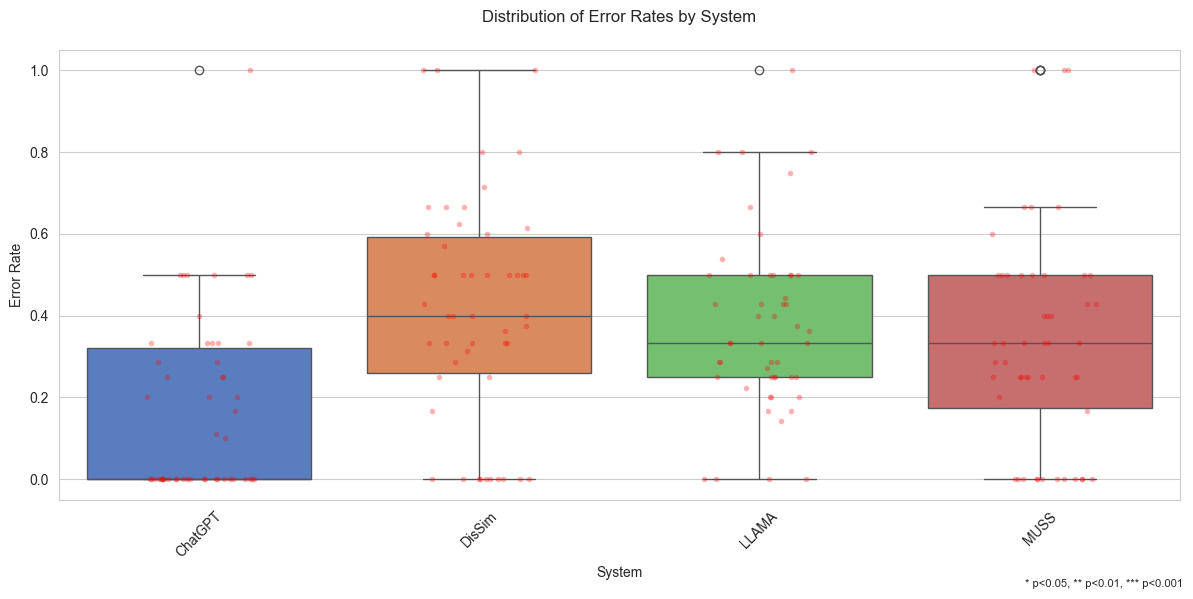

Dataset: cochrane

Analysis of Error Rates by System:
: Error rates table:
         mean  median  std
System                    
ChatGPT  0.11    0.00 0.14
DisSim   0.53    0.50 0.34
LLAMA    0.23    0.20 0.18
MUSS     0.29    0.25 0.28

Repeated Measures ANOVA: Analyzing error_rate grouped by System, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 7.117222664748172e-07
Group ChatGPT: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 0.0009580493210471807
Group DisSim: Not normal (p = 0.0010)
Shapiro-Wilk test p-value: 5.5073456779526366e-05
Group LLAMA: Not normal (p = 0.0001)
Shapiro-Wilk test p-value: 3.0823765696993514e-05
Group MUSS: Not normal (p = 0.0000)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns System, values error_rate
Mauchly's test: W = 0.7036, chi2 = 16.7733, dof = 5, p-value = 0.0050
Sphericity assumption is violated. A correction (Greenhouse-Geisser) will be applied (

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/2181337392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


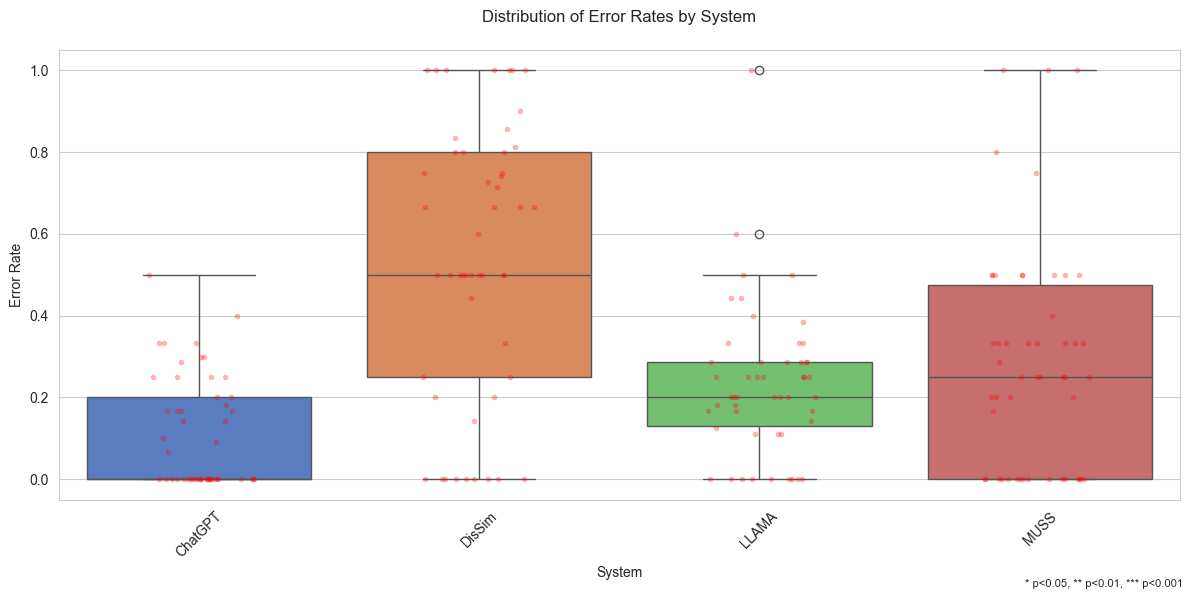

Dataset: scotus

Analysis of Error Rates by System:
: Error rates table:
         mean  median  std
System                    
ChatGPT  0.09    0.00 0.16
DisSim   0.45    0.43 0.31
LLAMA    0.29    0.25 0.22
MUSS     0.28    0.33 0.23

Repeated Measures ANOVA: Analyzing error_rate grouped by System, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 3.482219427839227e-10
Group ChatGPT: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 0.011942510635463902
Group DisSim: Not normal (p = 0.0119)
Shapiro-Wilk test p-value: 0.006872599730341118
Group LLAMA: Not normal (p = 0.0069)
Shapiro-Wilk test p-value: 0.00018096527111547816
Group MUSS: Not normal (p = 0.0002)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns System, values error_rate
Mauchly's test: W = 0.6099, chi2 = 23.6004, dof = 5, p-value = 0.0003
Sphericity assumption is violated. A correction (Greenhouse-Geisser) will be applied (if no

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/2181337392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


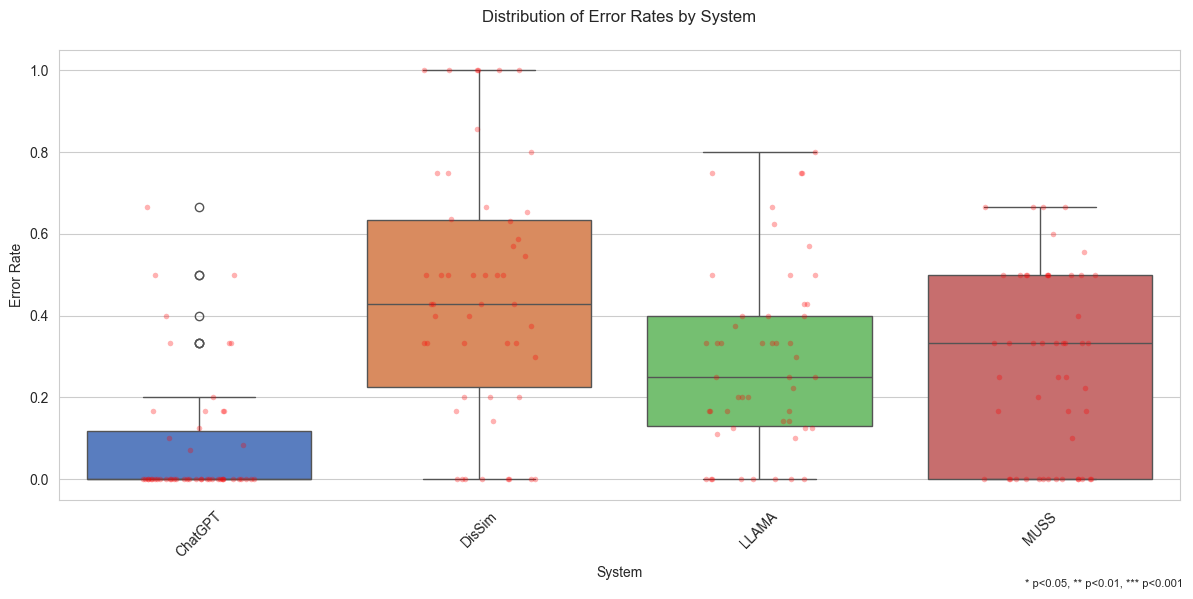

Dataset: wikiDE

Analysis of Error Rates by System:
: Error rates table:
         mean  median  std
System                    
ChatGPT  0.10    0.00 0.16
LLAMA    0.22    0.20 0.18
MUSS     0.42    0.38 0.35

Repeated Measures ANOVA: Analyzing error_rate grouped by System, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 2.8434940059391168e-09
Group ChatGPT: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 0.0007123050118428363
Group LLAMA: Not normal (p = 0.0007)
Shapiro-Wilk test p-value: 0.00018833621041177765
Group MUSS: Not normal (p = 0.0002)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns System, values error_rate
Mauchly's test: W = 0.6942, chi2 = 17.5179, dof = 2, p-value = 0.0002
Sphericity assumption is violated. A correction (Greenhouse-Geisser) will be applied (if normality is still given).

Normality assumptions are not met. Proceeding with the Friedman test.
DEBUG: running 

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/2181337392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


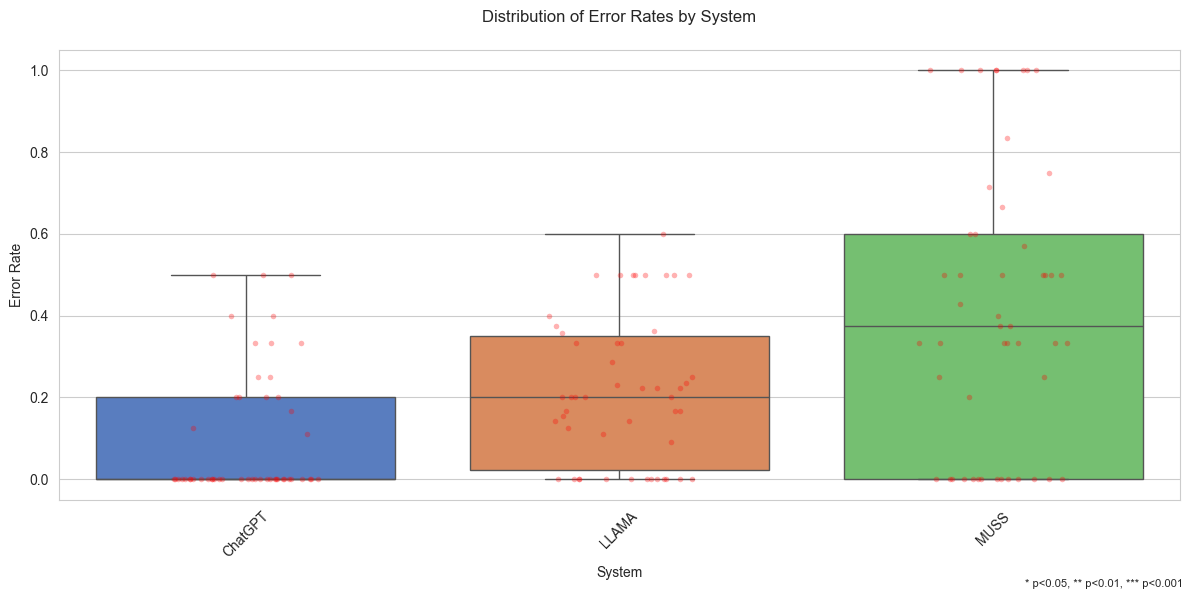

In [405]:
# Now run the same analysis but in each dataset separately (e.g., in WikiEN; how did the systems compare)

print("Examining within one dataset difference in error rates")

for dataset in datasets:
    print(f"Dataset: {dataset}")
    temp_df = df_sentences_bad_relative[df_sentences_bad_relative['Dataset'] == dataset]

    analyze_error_rates(temp_df, group_by='System')

Examining within one system differences in error rates between datasets (domain-specific struggles)



System: ChatGPT

Analysis of Error Rates by Dataset:
: Error rates table:
          mean  median  std
Dataset                    
cochrane  0.11    0.00 0.14
scotus    0.09    0.00 0.16
wikiDE    0.10    0.00 0.16
wikiEN    0.17    0.00 0.22

Repeated Measures ANOVA: Analyzing error_rate grouped by Dataset, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 7.117222664748172e-07
Group cochrane: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 3.482219427839227e-10
Group scotus: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 2.8434940059391168e-09
Group wikiDE: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 1.507539019848417e-07
Group wikiEN: Not normal (p = 0.0000)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns Dataset, values error_rate
Error during sphericity test: Eigenvalues d

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/anaconda3/envs/py311ts/l

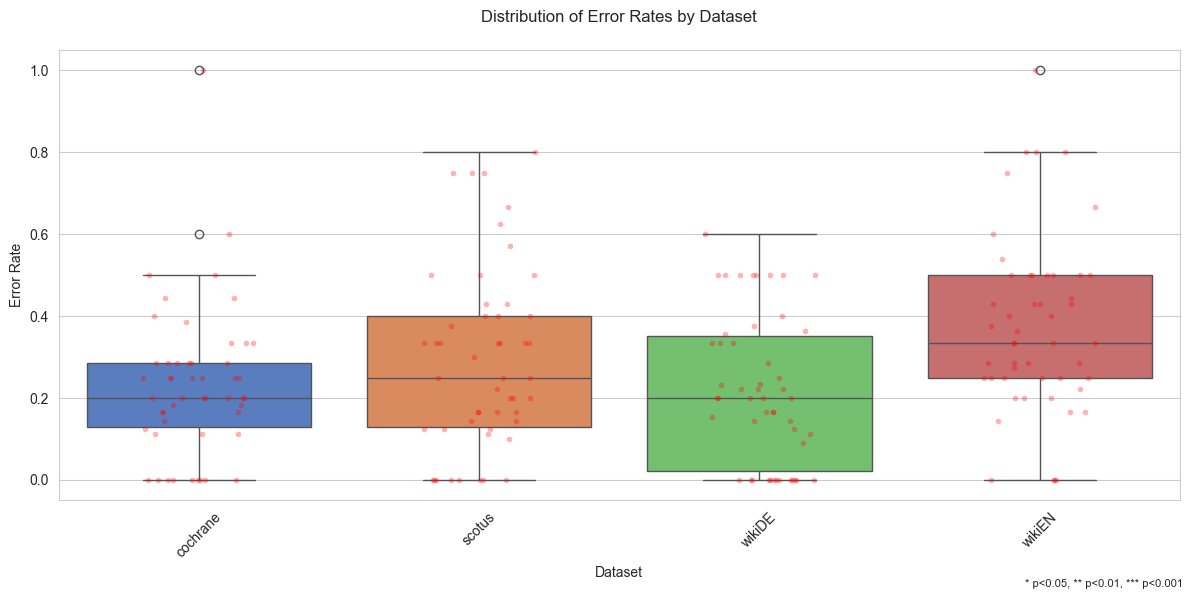




System: MUSS

Analysis of Error Rates by Dataset:
: Error rates table:
          mean  median  std
Dataset                    
cochrane  0.29    0.25 0.28
scotus    0.28    0.33 0.23
wikiDE    0.42    0.38 0.35
wikiEN    0.33    0.33 0.26

Repeated Measures ANOVA: Analyzing error_rate grouped by Dataset, repeated across Sentence ID
--- Running Shapiro-Wilk normality test for each group:
Shapiro-Wilk test p-value: 3.0823765696993514e-05
Group cochrane: Not normal (p = 0.0000)
Shapiro-Wilk test p-value: 0.00018096527111547816
Group scotus: Not normal (p = 0.0002)
Shapiro-Wilk test p-value: 0.00018833621041177765
Group wikiDE: Not normal (p = 0.0002)
Shapiro-Wilk test p-value: 0.0007207093954506047
Group wikiEN: Not normal (p = 0.0007)

--- Testing for sphericity ---
DEBUG: running pivot with index SubjectID, columns Dataset, values error_rate
Error during sphericity test: Eigenvalues did not converge

Normality assumptions are not met. Proceeding with the Friedman test.
DEBUG: running

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/3067028391.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['SubjectID'] = dataframe['Dataset'] + '_' + dataframe['Sentence ID NUM'].astype(str)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/anaconda3/envs/py311ts/l

In [406]:
# now reverse detailed analysis: per system, analyze different datasets
print("Examining within one system differences in error rates between datasets (domain-specific struggles)")

for system in systems:
    print(f"\n\n\nSystem: {system}")
    temp_df = df_sentences_bad_relative[df_sentences_bad_relative['System'] == system]
    analyze_error_rates(temp_df, 'Dataset', identifier_posthoc="Sentence ID")

#### Error (Bad Edit) Types

In [407]:
def analyze_error_types(df, group_by='System', alpha=0.05, category=None, 
                        description=None):
    # Filter for errors and create a contingency table
    error_dist = df[df['Quality'] == 'Error'].groupby([group_by, 'Edit Type']).size().unstack(fill_value=0)
    
    print(f"Distribution of Error Types by {group_by}:")
    print(error_dist)
    print("\nChi-square test results:")

    results = run_chi2_test(error_dist, scope=group_by, alpha=alpha, 
                  category=category, description=description)

    # only if we have significant results, visualize them (second value of results < 0.05):
    if results is not None and results[1] <= alpha:
        visualize_error_types(error_dist, alpha=alpha)

def visualize_error_types(contingency_table, alpha=0.05, mode='Types'):
    """Visualize error type distributions with stacked bars"""
    # Convert to percentages
    df_percent = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(12, 6))
    ax = df_percent.plot(kind='bar', stacked=True, 
                        colormap='Set3',
                        width=0.8)
    
    plt.title(f'Distribution of Error {mode}', pad=20)
    plt.xlabel('')
    plt.ylabel('Percentage of Errors')

    for c in ax.containers:
        # Add labels only for segments > 3%
        labels = ['%.1f%%' % v if v > 3 else '' for v in [v.get_height() for v in c]]
        ax.bar_label(c, labels=labels, label_type='center')
    plt.xticks(rotation=45, ha='right')
    
    # Adjust legend
    plt.legend(title=f'Error {mode}', 
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    plt.tight_layout()
    plt.show()

Analysis Parameters:
Test type: CHI2
Comparison: System vs Edit Type
Number of System categories: 4
Number of Edit Type categories: 6
Degrees of Freedom: 15


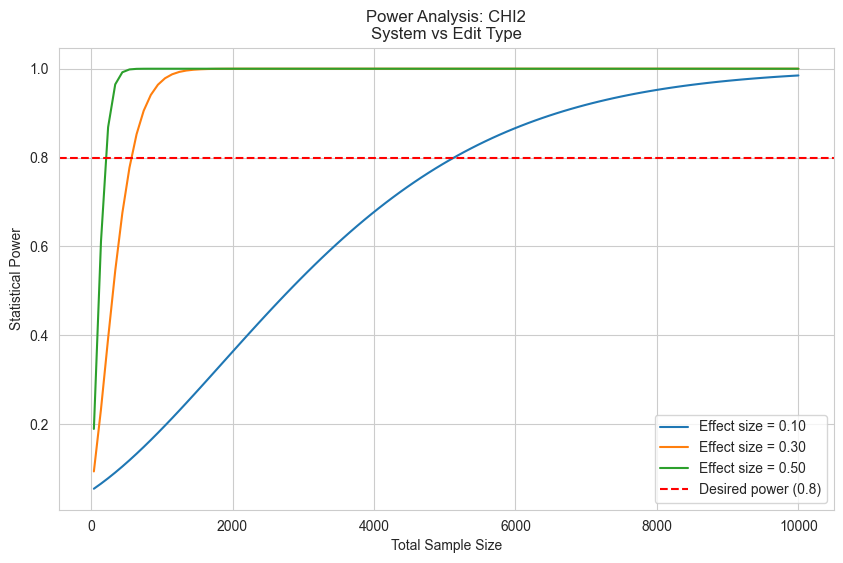


Power Analysis Results:
 effect_size  sample_size effect_size_interpretation
        0.10         1283                      small
        0.30          143                     medium
        0.50           52                      large

Actual sample sizes:
Total: 1145

Per group:
System
ChatGPT    109
DisSim     445
LLAMA      345
MUSS       246

Achieved Power with Current Sample Size:
Effect size 0.10: 0.746
Effect size 0.30: 1.000
Effect size 0.50: 1.000


In [408]:
# Power Analysis for Chi-Square Test (Error (Bad Edit) Types across Systems)
df_temp = df_edits[df_edits['Quality'] == 'Error'].copy()

power_results_error_types = analyze_power_requirements(
    df_temp, 
    test_type='chi2',
    group_col='System', 
    value_col='Edit Type'
)

Distribution of Error Types by System:
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                                 
ChatGPT          45          2        2      1          1            58
DisSim            4        120       89    217          7             8
LLAMA           152         10        8      1         12           162
MUSS            116         20       10      3          5            92

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 895.2491
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.5105
Sample size: 1145

APA Format: χ²(15, N = 1145) = 895.25, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit Type  deletion  insertion  reorder  split  structure  substitution
System                                                                 
ChatGPT          45          2

<Figure size 1200x600 with 0 Axes>

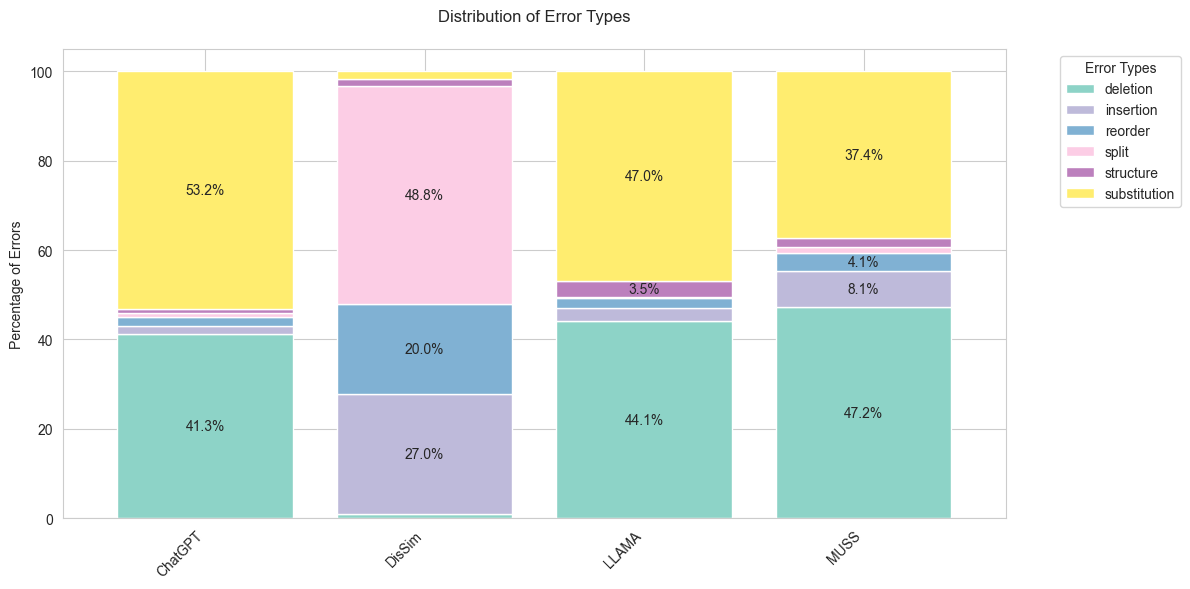

In [409]:
# Run the analysis
analyze_error_types(df_edits, group_by='System')

Distribution of Error Types by Dataset:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
cochrane         83         65       39     86          2            67
scotus           61         35       31     83          3            83
wikiDE           84         12        6      1          5            73
wikiEN           89         40       33     52         15            97

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 140.0438
Degrees of freedom: 15
p-value: 0.0000
Cramer's V: 0.2019
Sample size: 1145

APA Format: χ²(15, N = 1145) = 140.04, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
cochrane         83         6

<Figure size 1200x600 with 0 Axes>

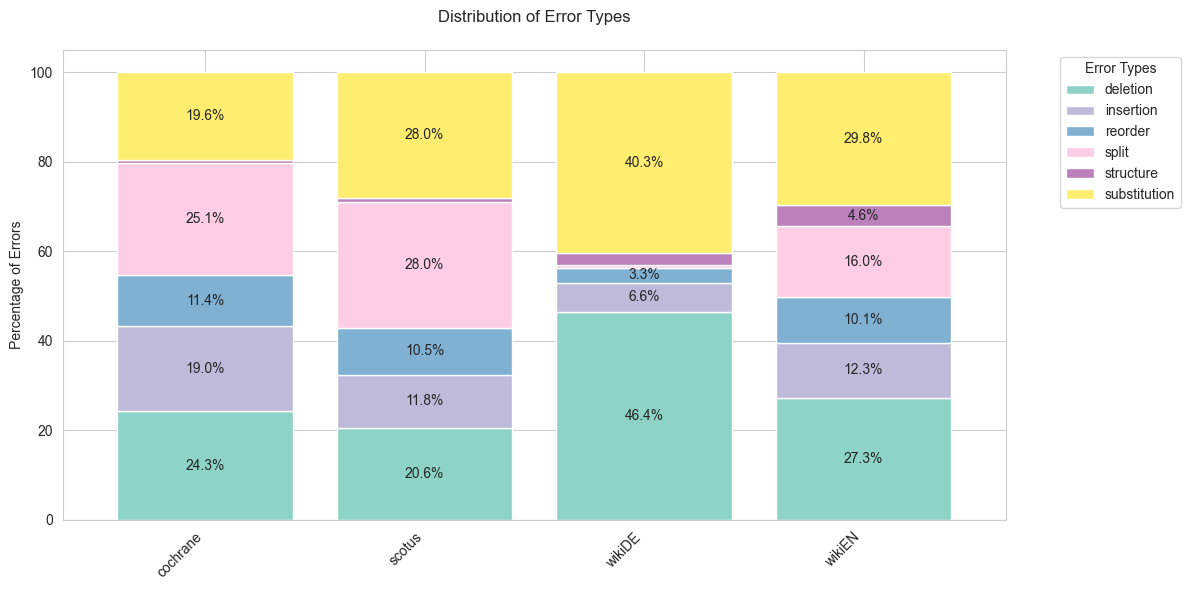

In [410]:
analyze_error_types(df_edits, group_by='Dataset')

#### Error Severity

In [411]:
# Error SEVERITY

def analyze_error_severity(df, group_by='System', alpha=0.05, 
                           category=None, description=None):
    # Filter for errors and create a contingency table
    error_severity = df[df['Quality'] == 'Error'].groupby([group_by, 'Significance']).size().unstack(fill_value=0)
    
    print(f"Distribution of Error Severities by {group_by}:")
    print(error_severity)
    
    print("\nChi-square test results:")
    
    results = run_chi2_test(error_severity, scope=group_by, alpha=alpha, 
                  category=category, 
                  description=description
                  )

    # only if we have significant results, visualize them (second value of results < 0.05):
    if results is not None and results[1] <= alpha:
        visualize_error_types(error_severity, alpha=alpha, mode='Severity')

Distribution of Error Severities by System:
Significance    1    2   3
System                    
ChatGPT        89   16   4
DisSim        237  183  25
LLAMA         192  114  39
MUSS           92   94  60

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 103.0474
Degrees of freedom: 6
p-value: 0.0000
Cramer's V: 0.2121
Sample size: 1145

APA Format: χ²(6, N = 1145) = 103.05, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Significance    1    2   3
System                    
ChatGPT        89   16   4
DisSim        237  183  25
LLAMA         192  114  39
MUSS           92   94  60
Bonferroni-adjusted significance level: 0.0083
ChatGPT vs DisSim: chi2 = 29.6751, p-value = 0.0000

*** The result is statistically significant. ***
ChatGPT vs LLAMA: chi2 = 23.8993, p-value = 0.0000

*** The result is statistically significant. ***
ChatGPT vs MUSS: chi2 = 60.49

<Figure size 1200x600 with 0 Axes>

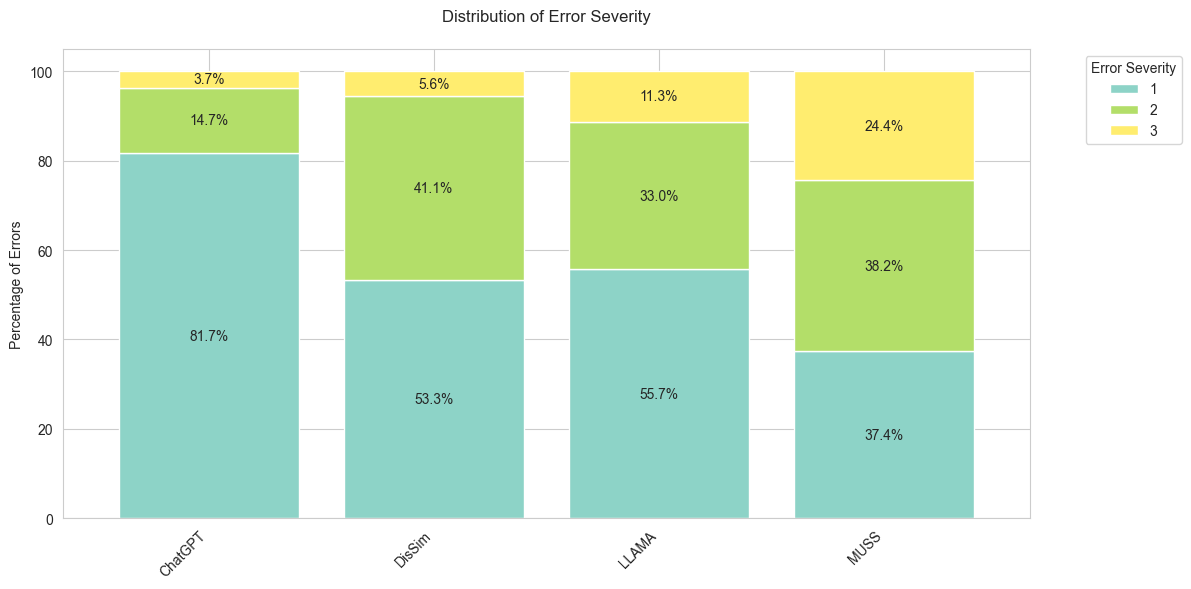

In [412]:
analyze_error_severity(df_edits, group_by='System')

In [413]:
analyze_error_severity(df_edits, group_by='Dataset')

Distribution of Error Severities by Dataset:
Significance    1    2   3
Dataset                   
cochrane      179  130  33
scotus        149  116  31
wikiDE         96   56  29
wikiEN        186  105  35

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 9.9071
Degrees of freedom: 6
p-value: 0.1286
Cramer's V: 0.0658
Sample size: 1145

APA Format: χ²(6, N = 1145) = 9.91, p = 0.129

The result is not statistically significant.


Examining within one dataset difference between models in error severity



Dataset: wikiEN
Distribution of Error Severities by System:
Significance   1   2   3
System                  
ChatGPT       28   2   0
DisSim        70  46   9
LLAMA         59  32  14
MUSS          29  25  12

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 25.3440
Degrees of freedom: 6
p-value: 0.0003
Cramer's V: 0.1972
Sample size: 326

APA Format: χ²(6, N = 326) = 25.34, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Significance   1   2   3
System                  
ChatGPT       28   2   0
DisSim        70  46   9
LLAMA         59  32  14
MUSS          29  25  12
Bonferroni-adjusted significance level: 0.0083
Skipping ChatGPT vs DisSim comparison because of 0 frequency in one of the cells.
Skipping ChatGPT vs LLAMA comparison because of 0 frequency in one of the cells.
Skipp

<Figure size 1200x600 with 0 Axes>

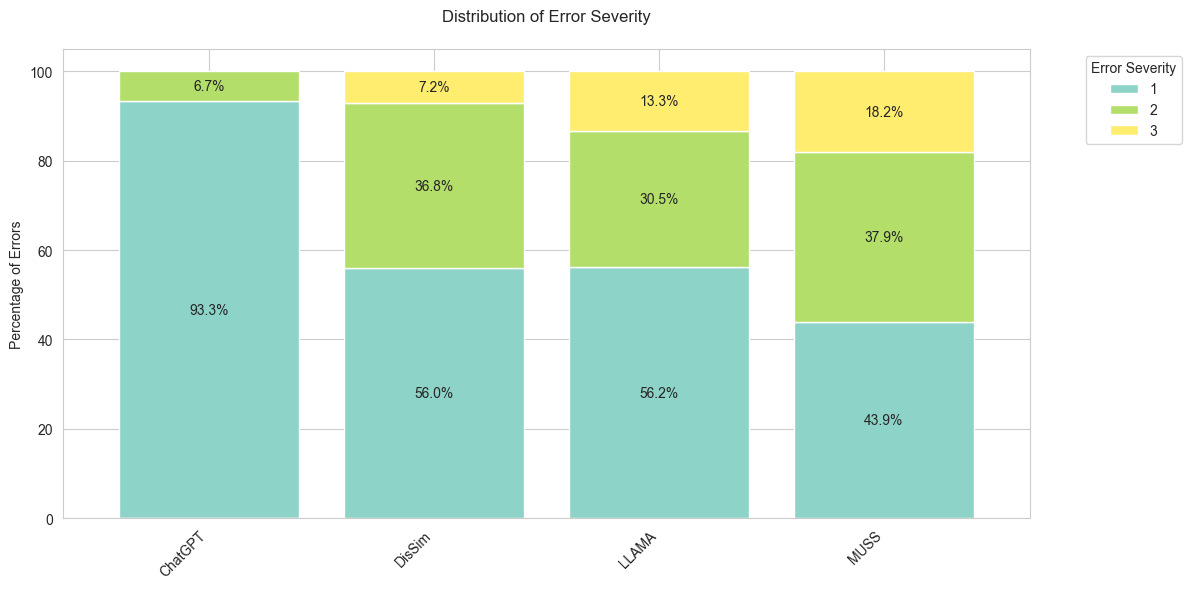




Dataset: cochrane
Distribution of Error Severities by System:
Significance   1   2   3
System                  
ChatGPT       23   9   1
DisSim        96  75  12
LLAMA         40  25   6
MUSS          20  21  14

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 24.0284
Degrees of freedom: 6
p-value: 0.0005
Cramer's V: 0.1874
Sample size: 342

APA Format: χ²(6, N = 342) = 24.03, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Significance   1   2   3
System                  
ChatGPT       23   9   1
DisSim        96  75  12
LLAMA         40  25   6
MUSS          20  21  14
Bonferroni-adjusted significance level: 0.0083
ChatGPT vs DisSim: chi2 = 3.4374, p-value = 0.1793

The result is not statistically significant.
ChatGPT vs LLAMA: chi2 = 2.0814, p-value = 0.3532

The result is not statistically significant.
ChatGPT vs MUSS: chi2 = 11.4944, p-value = 0.0

<Figure size 1200x600 with 0 Axes>

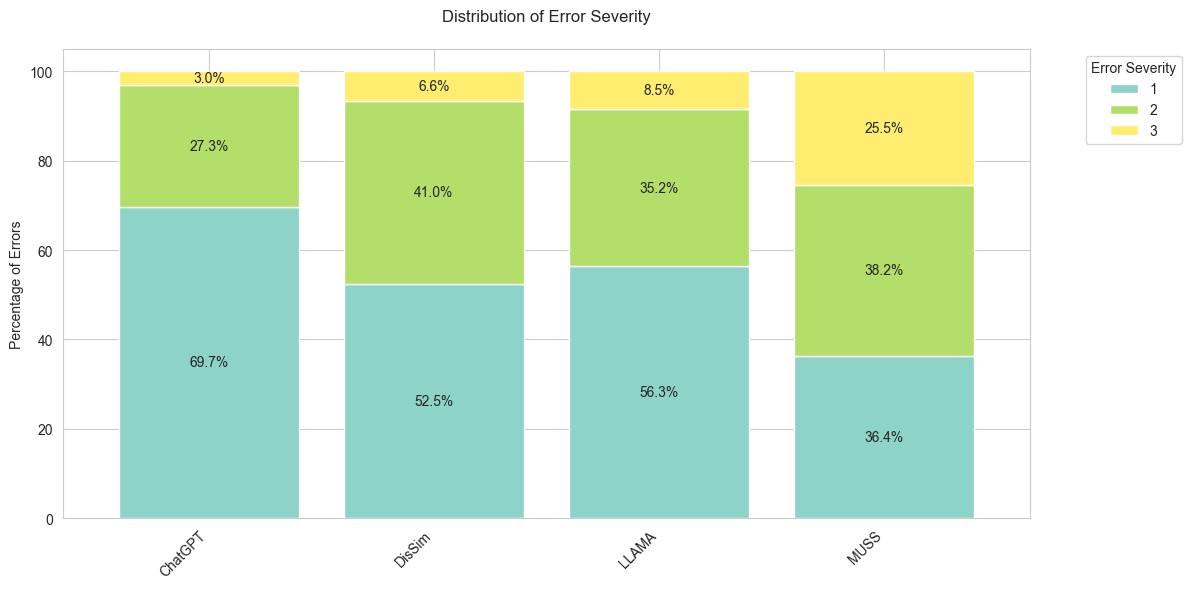




Dataset: scotus
Distribution of Error Severities by System:
Significance   1   2   3
System                  
ChatGPT       20   2   1
DisSim        71  62   4
LLAMA         40  32  10
MUSS          18  20  16

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 43.5777
Degrees of freedom: 6
p-value: 0.0000
Cramer's V: 0.2713
Sample size: 296

APA Format: χ²(6, N = 296) = 43.58, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Significance   1   2   3
System                  
ChatGPT       20   2   1
DisSim        71  62   4
LLAMA         40  32  10
MUSS          18  20  16
Bonferroni-adjusted significance level: 0.0083
ChatGPT vs DisSim: chi2 = 10.9830, p-value = 0.0041

*** The result is statistically significant. ***
ChatGPT vs LLAMA: chi2 = 10.7393, p-value = 0.0047

*** The result is statistically significant. ***
ChatGPT vs MUSS: chi2 = 18.6025, p-val

<Figure size 1200x600 with 0 Axes>

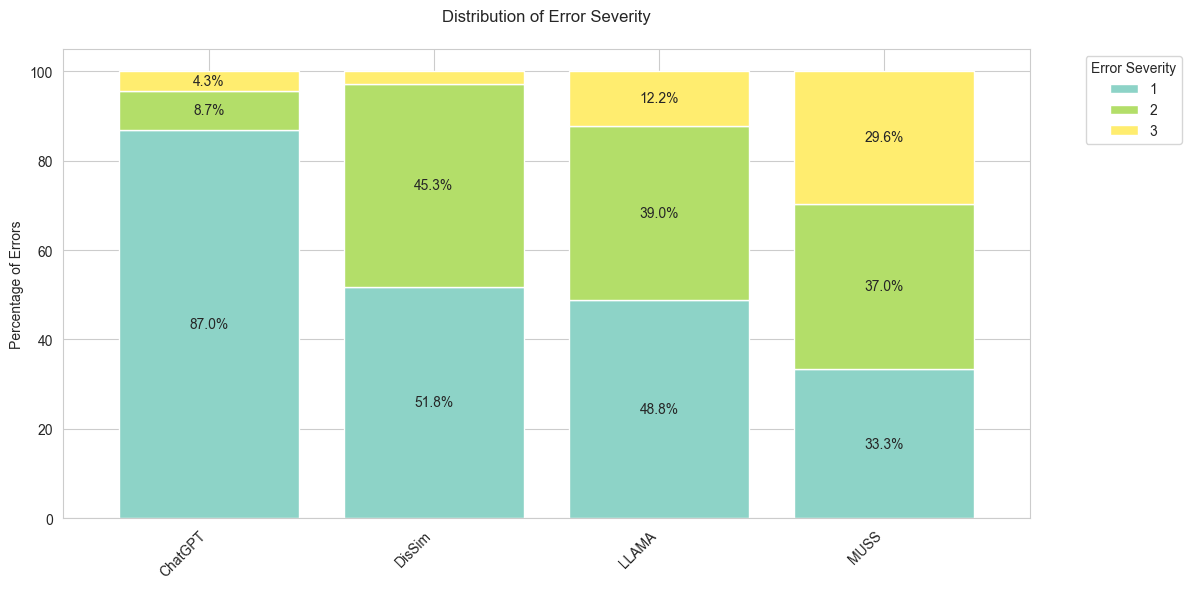




Dataset: wikiDE
Distribution of Error Severities by System:
Significance   1   2   3
System                  
ChatGPT       18   3   2
LLAMA         53  25   9
MUSS          25  28  18

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 18.5844
Degrees of freedom: 4
p-value: 0.0009
Cramer's V: 0.2266
Sample size: 181

APA Format: χ²(4, N = 181) = 18.58, p < .001

*** The result is statistically significant. ***

      --- ATTENTION: Conducting Post-hoc analysis: ---
 Debug: Input contingency table: 
Significance   1   2   3
System                  
ChatGPT       18   3   2
LLAMA         53  25   9
MUSS          25  28  18
Bonferroni-adjusted significance level: 0.0167
ChatGPT vs LLAMA: chi2 = 2.6568, p-value = 0.2649

The result is not statistically significant.
ChatGPT vs MUSS: chi2 = 12.9729, p-value = 0.0015

*** The result is statistically significant. ***
LLAMA vs MUSS: chi2 = 11.7210, p-value = 0.0028

*** The result is statistically significant. *

<Figure size 1200x600 with 0 Axes>

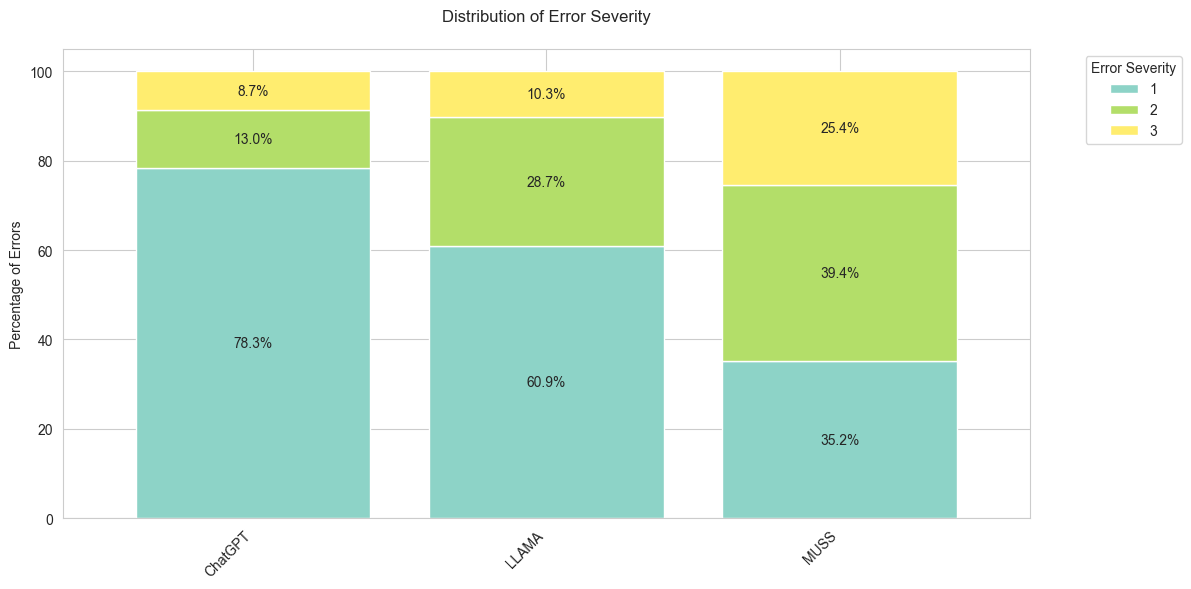

In [414]:
print("Examining within one dataset difference between models in error severity")

for dataset in datasets:
    print(f"\n\n\nDataset: {dataset}")
    # filter only the current dataset
    temp_df = df_edits[df_edits['Dataset'] == dataset]
    analyze_error_severity(temp_df, group_by='System')

In [415]:
# Reverse:
# Examining within one system: Is there a difference between domains?
print("Examining within one system difference between datasets (domains) in error severity")

for system in systems:
    print(f"\n\n\System: {system}")
    # filter only the current dataset
    temp_df = df_edits[df_edits['System'] == system]
    analyze_error_severity(temp_df, group_by='Dataset')

Examining within one system difference between datasets (domains) in error severity


\System: ChatGPT
Distribution of Error Severities by Dataset:
Significance   1  2  3
Dataset               
cochrane      23  9  1
scotus        20  2  1
wikiDE        18  3  2
wikiEN        28  2  0

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 9.4208
Degrees of freedom: 6
p-value: 0.1513
Cramer's V: 0.2079
Sample size: 109

APA Format: χ²(6, N = 109) = 9.42, p = 0.151

The result is not statistically significant.


\System: LLAMA
Distribution of Error Severities by Dataset:
Significance   1   2   3
Dataset                 
cochrane      40  25   6
scotus        40  32  10
wikiDE        53  25   9
wikiEN        59  32  14

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 3.8499
Degrees of freedom: 6
p-value: 0.6970
Cramer's V: 0.0747
Sample size: 345

APA Format: χ²(6, N = 345) = 3.85, p = 0.697

The result is not statistically signifi

#### Errors: Specialized Domains and Specialized Terminology
Does a special domain or specialized terminology play a significant role in the error rate?

In [416]:
df_temp = df_sentences.copy()

df_temp['ErrorPresent'] = df_temp['TotalErrors'] >= 1

ct = create_contingency_table(df_temp, 'SpecialDomain', 'ErrorPresent')
display(ct)

print("\nChi-square test results:")
results = run_chi2_test(ct)

ErrorPresent   False  True 
SpecialDomain              
General          112    238
Specialized      125    275


Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 0.0201
Degrees of freedom: 1
p-value: 0.8873
Cramer's V: 0.0052
Sample size: 750

APA Format: χ²(1, N = 750) = 0.02, p = 0.887

The result is not statistically significant.


In [417]:
# run chi2 test for "special terminology"

df_temp = df_sentences.copy()
df_temp['ErrorPresent'] = df_temp['TotalErrors'] >= 1

ct = create_contingency_table(df_temp, 'Sentence_has_specialized_terms', 'ErrorPresent')
display(ct)

print("\nChi-square test results:")
results = run_chi2_test(ct)

ErrorPresent                    False  True 
Sentence_has_specialized_terms              
False                              78    171
True                              159    342


Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 0.0009
Degrees of freedom: 1
p-value: 0.9755
Cramer's V: 0.0011
Sample size: 750

APA Format: χ²(1, N = 750) = 0.00, p = 0.976

The result is not statistically significant.


In [418]:
# run chi2 test for "named entity"
df_temp = df_sentences.copy()

df_temp['ErrorPresent'] = df_temp['TotalErrors'] >= 1

ct = create_contingency_table(df_temp, 'Sentence_contains_named_entity', 'ErrorPresent')
display(ct)

print("\nChi-square test results:")
results = run_chi2_test(ct)

ErrorPresent                    False  True 
Sentence_contains_named_entity              
False                              53     89
True                              184    424


Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 2.3386
Degrees of freedom: 1
p-value: 0.1262
Cramer's V: 0.0558
Sample size: 750

APA Format: χ²(1, N = 750) = 2.34, p = 0.126

The result is not statistically significant.


#### Cross-Lingual Error Analysis

In [419]:
# filter df_sentences_bad_relative for wikiEN and wikiDE
df_sentences_bad_relative_CL = df_sentences_bad_relative[df_sentences_bad_relative['Dataset'].isin(['wikiEN', 'wikiDE'])]

# filter out DisSim system
df_sentences_bad_relative_CL = df_sentences_bad_relative_CL[df_sentences_bad_relative_CL['System'] != 'DisSim']

# get all systems present in df_sentences_bad_relative_CL.System
print(df_sentences_bad_relative_CL.System.unique())
print(df_sentences_bad_relative_CL.Dataset.unique())

['ChatGPT' 'LLAMA' 'MUSS']
['wikiDE' 'wikiEN']


In [420]:
df_edits_CL = df_edits[df_edits['Dataset'].isin(['wikiEN', 'wikiDE'])]

# filter out DisSim system
df_edits_CL = df_edits_CL[df_edits_CL['System'] != 'DisSim']

# get all systems present in df_edits_CL.System
print(df_edits_CL.System.unique())


['ChatGPT' 'LLAMA' 'MUSS']


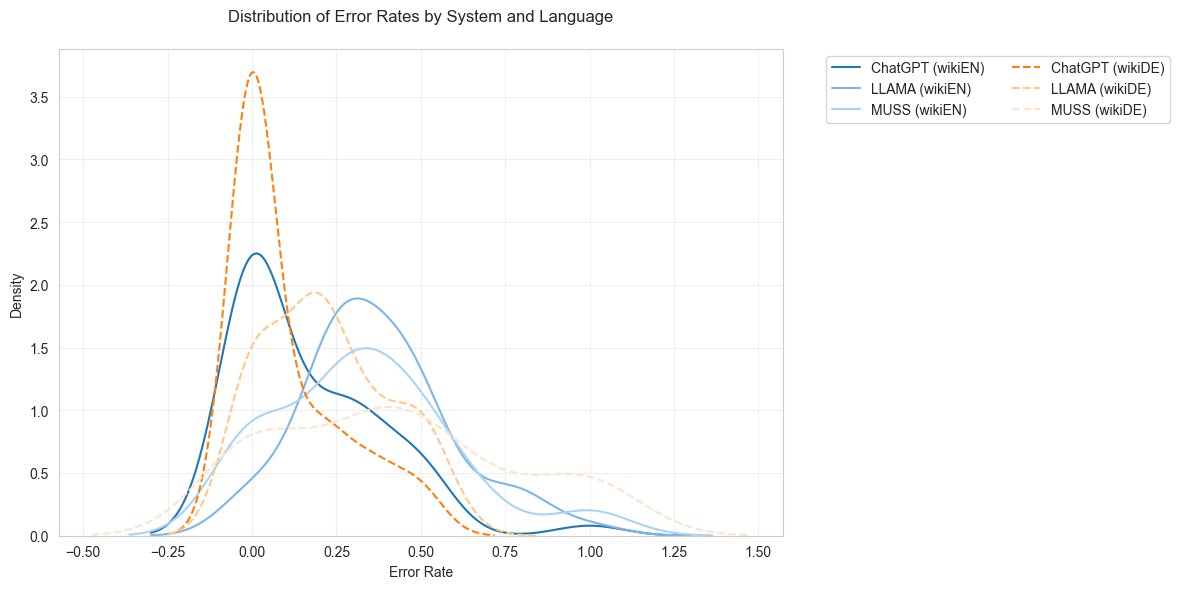

In [421]:
# Create color palettes for English and German
colors = {
    'wikiEN': {
        'ChatGPT': '#1f77b4',  # Dark blue
        'LLAMA': '#7fb5e2',    # Light blue
        'MUSS': '#a8d4f3'      # Very light blue
    },
    'wikiDE': {
        'ChatGPT': '#ff7f0e',  # Dark orange
        'LLAMA': '#ffc78c',    # Light orange
        'MUSS': '#ffe3cc'      # Very light orange
    }
}
plt.figure(figsize=(12, 6))

# Plot each system's distribution for each dataset
for dataset in ['wikiEN', 'wikiDE']:
    for system in df_sentences_bad_relative_CL['System'].unique():
        data = df_sentences_bad_relative_CL[
            (df_sentences_bad_relative_CL['Dataset'] == dataset) & 
            (df_sentences_bad_relative_CL['System'] == system)
        ]
        
        if not data.empty:  # Only plot if we have data for this combination
            sns.kdeplot(
                data=data,
                x='error_rate',
                label=f'{system} ({dataset})',
                color=colors[dataset][system],
                linestyle='-' if dataset == 'wikiEN' else '--'
            )

plt.title('Distribution of Error Rates by System and Language', fontsize=12, pad=20)
plt.xlabel('Error Rate', fontsize=10)
plt.ylabel('Density', fontsize=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

In [422]:
# Error Rates 
# Differences between English and German

alpha = 0.05

df_temp = df_sentences_bad_relative_CL.copy()

# Overall analysis (across all systems)
print("\nOverall Error Rate Analysis (All Systems):")
data_en = df_temp[df_temp['Dataset'] == 'wikiEN']['error_rate']
data_de = df_temp[df_temp['Dataset'] == 'wikiDE']['error_rate']

print(f"Group 1 (wikiEN): {data_en.describe()}")
print(f"Group 2 (wikiDE): {data_de.describe()}")

results = run_t_test_analysis(
    data_en, 
    data_de, 
    'Error Rate',
    alpha=alpha,
    var_names=('wikiEN', 'wikiDE')
)
# turn results into a dataframe
print(results)
results_df = pd.DataFrame([results])
display(results_df)
print(results_df)

# Per-system analysis
print("\nError Rate Analysis by System:")
for system in df_temp['System'].unique():
    print(f"\nSystem: {system}")
    system_data = df_temp[df_temp['System'] == system]
    
    data_en = system_data[system_data['Dataset'] == 'wikiEN']['error_rate']
    data_de = system_data[system_data['Dataset'] == 'wikiDE']['error_rate']
    
    if len(data_en) > 0 and len(data_de) > 0:
        results = run_t_test_analysis(
            data_en, 
            data_de, 
            'Error Rate',
            alpha=alpha,
            var_names=('wikiEN', 'wikiDE')
        )
        # turn results into a dataframe
        results_df = pd.DataFrame([results])
        print(results_df)
        display(results_df)
    else:
        print(f"Insufficient data for {system}")



Overall Error Rate Analysis (All Systems):
Group 1 (wikiEN): count   150.00
mean      0.29
std       0.25
min       0.00
25%       0.00
50%       0.28
75%       0.44
max       1.00
Name: error_rate, dtype: float64
Group 2 (wikiDE): count   150.00
mean      0.25
std       0.28
min       0.00
25%       0.00
50%       0.20
75%       0.40
max       1.00
Name: error_rate, dtype: float64

--- T-test Results Summary ---
Test type: Mann-Whitney U test
Test statistic: 12781.0000
Degrees of freedom: N/A
p-value: 0.0373
Effect size (Cohen's d): 0.1726
Interpretation: negligible effect

--- APA Format Results ---
U = 12781.00, p = 0.037, d = 0.17

--- Full APA Report ---
The analysis revealed a significant difference, U = 12781.00, p = 0.037, d = 0.17, such that wikiEN (M = 0.29, SD = 0.25) was greater than wikiDE (M = 0.25, SD = 0.27).
{'metric': 'Error Rate', 'n1': 150, 'n2': 150, 'mean1': np.float64(0.2910729085729086), 'median1': np.float64(0.2792207792207792), 'mean2': np.float64(0.245874673

metric   n1   n2  mean1  median1  mean2  median2  std1  IQR1  std2  \
0  Error Rate  150  150   0.29     0.28   0.25     0.20  0.25  0.44  0.27   

   ...  variance_p equal_variance            test_type t_statistic  p_value  \
0  ...        0.30           True  Mann-Whitney U test    12781.00     0.04   

     df  cohens_d  effect_size  significant  \
0  None      0.17   negligible         True   

                                     full_apa_report  
0  The analysis revealed a significant difference...  

[1 rows x 27 columns]

       metric   n1   n2  mean1  median1  mean2  median2  std1  IQR1  std2  \
0  Error Rate  150  150   0.29     0.28   0.25     0.20  0.25  0.44  0.27   

   ...  variance_p equal_variance            test_type t_statistic  p_value  \
0  ...        0.30           True  Mann-Whitney U test    12781.00     0.04   

     df  cohens_d  effect_size  significant  \
0  None      0.17   negligible         True   

                                     full_apa_report  
0  The analysis revealed a significant difference...  

[1 rows x 27 columns]

Error Rate Analysis by System:

System: ChatGPT

--- T-test Results Summary ---
Test type: Mann-Whitney U test
Test statistic: 1456.5000
Degrees of freedom: N/A
p-value: 0.1108
Effect size (Cohen's d): 0.3555
Interpretation: small effect

--- APA Format Results ---
U = 1456.50, p = 0.111, d = 0.36

--- Full APA Report ---
The analysis revealed a non-significant difference, U = 1456.50, p = 0.111, d = 0.36, such that wikiEN (M = 0.17, SD = 0.22) was grea

metric  n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  ...  \
0  Error Rate  50  50   0.17     0.00   0.10     0.00  0.22  0.32  0.16  ...   

   variance_p equal_variance            test_type t_statistic  p_value    df  \
0        0.08           True  Mann-Whitney U test     1456.50     0.11  None   

   cohens_d  effect_size  significant  \
0      0.36        small        False   

                                     full_apa_report  
0  The analysis revealed a non-significant differ...  

[1 rows x 27 columns]


System: LLAMA

--- T-test Results Summary ---
Test type: Mann-Whitney U test
Test statistic: 1767.5000
Degrees of freedom: N/A
p-value: 0.0003
Effect size (Cohen's d): 0.7738
Interpretation: medium effect

--- APA Format Results ---
U = 1767.50, p < .001, d = 0.77

--- Full APA Report ---
The analysis revealed a significant difference, U = 1767.50, p < .001, d = 0.77, such that wikiEN (M = 0.37, SD = 0.22) was greater than wikiDE (M = 0.22, SD = 0.18).
       metric  n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  ...  \
0  Error Rate  50  50   0.37     0.33   0.22     0.20  0.22  0.25  0.18  ...   

   variance_p equal_variance            test_type t_statistic  p_value    df  \
0        0.45           True  Mann-Whitney U test     1767.50     0.00  None   

   cohens_d  effect_size  significant  \
0      0.77       medium         True   

                                     full_apa_report  
0  The analysis revealed a significant difference...  

[1 rows x 27 columns]


metric  n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  ...  \
0  Error Rate  50  50   0.37     0.33   0.22     0.20  0.22  0.25  0.18  ...   

   variance_p equal_variance            test_type t_statistic  p_value    df  \
0        0.45           True  Mann-Whitney U test     1767.50     0.00  None   

   cohens_d  effect_size  significant  \
0      0.77       medium         True   

                                     full_apa_report  
0  The analysis revealed a significant difference...  

[1 rows x 27 columns]


System: MUSS

--- T-test Results Summary ---
Test type: Mann-Whitney U test
Test statistic: 1074.5000
Degrees of freedom: N/A
p-value: 0.2216
Effect size (Cohen's d): 0.2787
Interpretation: small effect

--- APA Format Results ---
U = 1074.50, p = 0.222, d = 0.28

--- Full APA Report ---
The analysis revealed a non-significant difference, U = 1074.50, p = 0.222, d = 0.28, such that wikiEN (M = 0.33, SD = 0.26) was less than wikiDE (M = 0.42, SD = 0.34).
       metric  n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  ...  \
0  Error Rate  50  50   0.33     0.33   0.42     0.38  0.26  0.33  0.34  ...   

   variance_p equal_variance            test_type t_statistic  p_value    df  \
0        0.04          False  Mann-Whitney U test     1074.50     0.22  None   

   cohens_d  effect_size  significant  \
0      0.28        small        False   

                                     full_apa_report  
0  The analysis revealed a non-significant differ...  

[1 rows x 27 columns]


metric  n1  n2  mean1  median1  mean2  median2  std1  IQR1  std2  ...  \
0  Error Rate  50  50   0.33     0.33   0.42     0.38  0.26  0.33  0.34  ...   

   variance_p equal_variance            test_type t_statistic  p_value    df  \
0        0.04          False  Mann-Whitney U test     1074.50     0.22  None   

   cohens_d  effect_size  significant  \
0      0.28        small        False   

                                     full_apa_report  
0  The analysis revealed a non-significant differ...  

[1 rows x 27 columns]

In [423]:
# Error Types
def analyze_crosslingual_error_types(df, alpha=0.05):
     
    # Overall analysis (across all systems)
    print("\nOverall Error Type Analysis (All Systems):")
    analyze_error_types(
        df, 
        group_by='Dataset', 
        alpha=alpha,
        category="Cross-lingual Error Types",
        description="Overall comparison of error types between languages"
    )
    
    # Per-system analysis
    print("\nError Type Analysis by System:")
    for system in df['System'].unique():
        print(f"\n{'-'*50}\nSystem: {system}")
        system_data = df[df['System'] == system]
        
        analyze_error_types(
            system_data, 
            group_by='Dataset', 
            alpha=alpha,
            category=f"Cross-lingual Error Types - {system}",
            description=f"Comparison of error types between languages for {system}"
        )
    
    
# Run the analysis
analyze_crosslingual_error_types(df_edits_CL)


Overall Error Type Analysis (All Systems):
Distribution of Error Types by Dataset:
Edit Type  deletion  insertion  reorder  split  structure  substitution
Dataset                                                                
wikiDE           84         12        6      1          5            73
wikiEN           86          7        5      0          8            95

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 4.9700
Degrees of freedom: 5
p-value: 0.4196
Cramer's V: 0.1141
Sample size: 382

APA Format: χ²(5, N = 382) = 4.97, p = 0.420

The result is not statistically significant.

Error Type Analysis by System:

--------------------------------------------------
System: ChatGPT
Distribution of Error Types by Dataset:
Edit Type  deletion  reorder  substitution
Dataset                                   
wikiDE           10        1            12
wikiEN           12        0            18

Chi-square test results:
--- Chi-square test results: ---
Chi

In [424]:
# Error Severity

def analyze_crosslingual_error_severity(df, alpha=0.05):
    """
    Analyzes differences in error severity between languages.
    """
    # Overall analysis (across all systems)
    print("\nOverall Error Severity Analysis (All Systems):")
    analyze_error_severity(
        df, 
        group_by='Dataset', 
        alpha=alpha,
        category="Cross-lingual Error Severity",
        description="Overall comparison of error severity between languages"
    )
    
    # Per-system analysis
    print("\nError Severity Analysis by System:")
    for system in df['System'].unique():
        print(f"\n{'-'*50}\nSystem: {system}")
        system_data = df[df['System'] == system]
        
        analyze_error_severity(
            system_data, 
            group_by='Dataset', 
            alpha=alpha,
            category=f"Cross-lingual Error Severity - {system}",
            description=f"Comparison of error severity between languages for {system}"
        )

# Run the analysis
analyze_crosslingual_error_severity(df_edits_CL)


Overall Error Severity Analysis (All Systems):
Distribution of Error Severities by Dataset:
Significance    1   2   3
Dataset                  
wikiDE         96  56  29
wikiEN        116  59  26

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 1.0845
Degrees of freedom: 2
p-value: 0.5814
Cramer's V: 0.0533
Sample size: 382

APA Format: χ²(2, N = 382) = 1.08, p = 0.581

The result is not statistically significant.

Error Severity Analysis by System:

--------------------------------------------------
System: ChatGPT
Distribution of Error Severities by Dataset:
Significance   1  2  3
Dataset               
wikiDE        18  3  2
wikiEN        28  2  0

Chi-square test results:
--- Chi-square test results: ---
Chi-square statistic: 3.5106
Degrees of freedom: 2
p-value: 0.1729
Cramer's V: 0.2574
Sample size: 53

APA Format: χ²(2, N = 53) = 3.51, p = 0.173

The result is not statistically significant.

--------------------------------------------------
Syst

---

## Correlation of Errors and Sentence Characteristics (RQ3)

### Correlation between Metrics


In [425]:
def analyze_input_error_correlations(df, input_characteristics=None, error_metrics=None, 
                                   print_results=True, plot_top_n=3,
                                   exclude_DisSim=False
                                   ):
    """
    Analyzes correlations between input characteristics and error metrics.
    """

    if input_characteristics is None:
        input_characteristics = [
            'FKGL_Source', 
            'ARI_Source',
            'Lexical_Diversity_Source', 
            'Syntactic_Complexity_Source',

            'FKGL_Difference',
            'ARI_Difference',
            'Lexical_Diversity_Difference',
            'Syntactic_Complexity_Difference',

            # outcomes
            'BERTScore_F1',
            'GLEU',
            'LENS_SALSA'
        ]
    
    if error_metrics is None:
        error_metrics = ['TotalErrors']
    
    correlation_results = []
    df_to_use = df.copy()

    if exclude_DisSim:
        df_to_use = df_to_use[df_to_use['System'] != 'DisSim']       
    
    # Loop through all combinations
    for input_char in input_characteristics:
        for error_metric in error_metrics:
            result = analyze_correlation(
                df_to_use, 
                input_char, 
                error_metric,
                category="Input vs Errors",
                description=f"Correlation between {input_char} and {error_metric}"
            )
            
            correlation_results.append({
                'input_characteristic': input_char,
                'error_metric': error_metric,
                'correlation': result['correlation_coef'],
                'p_value': result['p_value'],
                'effect_size': result['effect_size'],
                'apa_format': result['apa_format']
            })
    
    correlation_df = pd.DataFrame(correlation_results)
    
    significant_correlations = correlation_df[correlation_df['p_value'] < 0.05].sort_values(
        'correlation', 
        key=abs, 
        ascending=False
    )
    
    if print_results:
        print("\nSignificant correlations:")
        display(significant_correlations[['input_characteristic', 'error_metric', 
                                        'correlation', 'p_value', 'effect_size', 'apa_format']])
        # export to CSV for R
        significant_correlations.to_csv("../data/charts_data/significant_correlations.csv", index=False)
    
    if plot_top_n > 0 and not significant_correlations.empty:
        plot_topN_corr(
            significant_correlations, 
            df_to_use, 
            plot_top_n,
            var1_col='input_characteristic',
            var2_col='error_metric'
        )
    
    return {
        'all_correlations': correlation_df,
        'significant_correlations': significant_correlations
    }


Correlation Analysis: FKGL_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0000 (Non-normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.2748, p-value = 0.0000
Spearman correlation: ρ = 0.1678, p-value = 0.0000

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(748) = 0.17, p < .001

Effect size interpretation: small
Appending test results for FKGL_Source vs TotalErrors, p-value: 3.817219267130688e-06

Correlation Analysis: ARI_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
ARI_Source: p-value = 0.0000 (Non-normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.0897, p-value = 0.0140
Spearman correlation: ρ = 0.1091, p-value = 0.0028

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(748) = 0.11

input_characteristic error_metric  correlation  p_value  \
4                FKGL_Difference  TotalErrors        -0.37     0.00   
8                   BERTScore_F1  TotalErrors        -0.32     0.00   
5                 ARI_Difference  TotalErrors        -0.30     0.00   
10                    LENS_SALSA  TotalErrors        -0.27     0.00   
9                           GLEU  TotalErrors        -0.19     0.00   
0                    FKGL_Source  TotalErrors         0.17     0.00   
2       Lexical_Diversity_Source  TotalErrors        -0.17     0.00   
3    Syntactic_Complexity_Source  TotalErrors         0.15     0.00   
1                     ARI_Source  TotalErrors         0.11     0.00   
6   Lexical_Diversity_Difference  TotalErrors        -0.10     0.00   

   effect_size                   apa_format  
4     moderate   r_s(748) = -0.37, p < .001  
8     moderate   r_s(748) = -0.32, p < .001  
5     moderate   r_s(748) = -0.30, p < .001  
10       small   r_s(598) = -0.27, p < .001  
9        small   r_s(748) = -0.19, p < .001  
0        small    r_s(748) = 0.17, p < .001  
2        small   r_s(748) = -0.17, p < .001  
3        small    r_s(748) = 0.15, p < .001  
1        small   r_s(748) = 0.11, p = 0.003  
6        small  r_s(748) = -0.10, p = 0.004

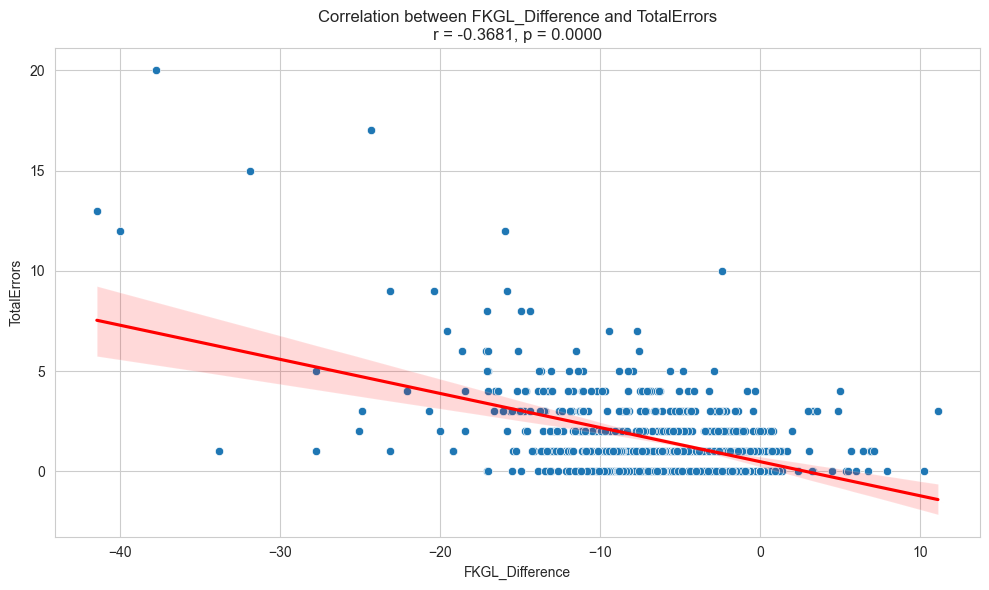

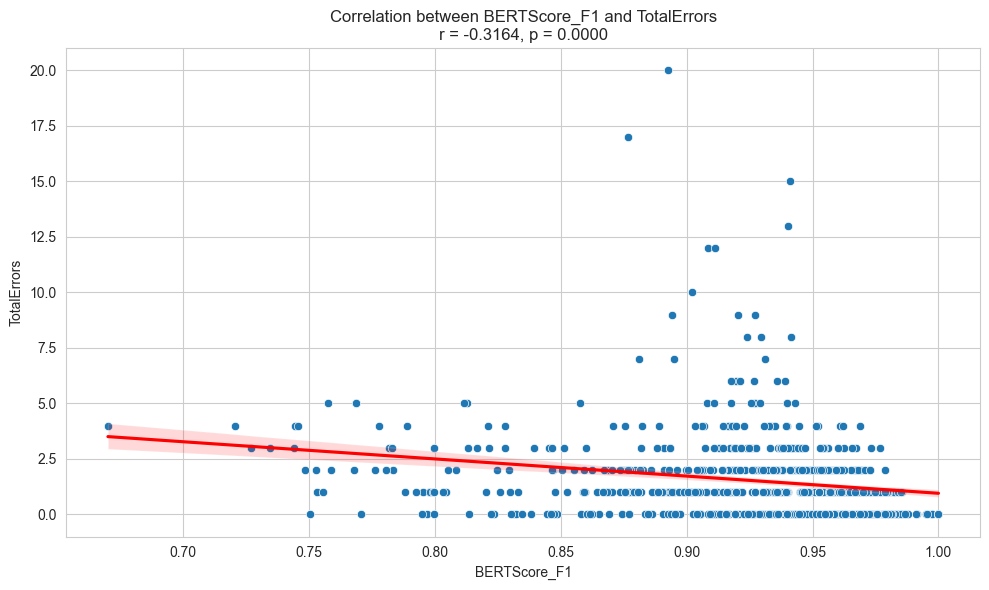

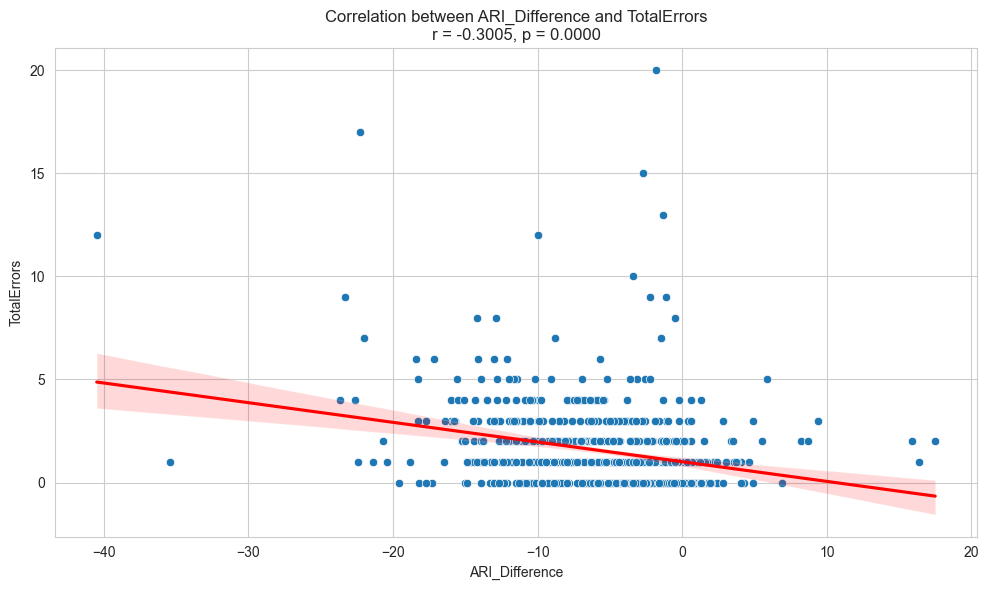

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
0                       FKGL_Source  TotalErrors         0.17     0.00   
1                        ARI_Source  TotalErrors         0.11     0.00   
2          Lexical_Diversity_Source  TotalErrors        -0.17     0.00   
3       Syntactic_Complexity_Source  TotalErrors         0.15     0.00   
4                   FKGL_Difference  TotalErrors        -0.37     0.00   
5                    ARI_Difference  TotalErrors        -0.30     0.00   
6      Lexical_Diversity_Difference  TotalErrors        -0.10     0.00   
7   Syntactic_Complexity_Difference  TotalErrors        -0.02     0.58   
8                      BERTScore_F1  TotalErrors        -0.32     0.00   
9                              GLEU  TotalErrors        -0.19     0.00   
10                       LENS_SALSA  TotalErrors        -0.27     0.00   

   effect_size                   apa_format  
0        small    r_s(748) = 0.17, p < .001 

In [426]:
# Run the analysis for Total Errors
input_error_correlations = analyze_input_error_correlations(df_sentences)
print(input_error_correlations)

In [427]:
df_cor_all = input_error_correlations
df_cor_all

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
 0                       FKGL_Source  TotalErrors         0.17     0.00   
 1                        ARI_Source  TotalErrors         0.11     0.00   
 2          Lexical_Diversity_Source  TotalErrors        -0.17     0.00   
 3       Syntactic_Complexity_Source  TotalErrors         0.15     0.00   
 4                   FKGL_Difference  TotalErrors        -0.37     0.00   
 5                    ARI_Difference  TotalErrors        -0.30     0.00   
 6      Lexical_Diversity_Difference  TotalErrors        -0.10     0.00   
 7   Syntactic_Complexity_Difference  TotalErrors        -0.02     0.58   
 8                      BERTScore_F1  TotalErrors        -0.32     0.00   
 9                              GLEU  TotalErrors        -0.19     0.00   
 10                       LENS_SALSA  TotalErrors        -0.27     0.00   
 
    effect_size                   apa_format  
 0        small    r_s(748) = 0

In [428]:
# Export ALL Correlations for Appendix

df_cor_all = input_error_correlations['all_correlations']

# select specific columns
df_cor_all = df_cor_all[['input_characteristic', 'correlation', 'p_value', 'effect_size']]

# if p_value < 0.001, replace with '<0.001'
df_cor_all['p_value'] = df_cor_all['p_value'].apply(lambda x: '<0.001' if x < 0.001 else round(x, 3))

df_cor_all = df_cor_all.round(2)

display(df_cor_all)

# export to latex
#df_to_enhanced_latex(df_cor_all, caption="Significant Correlations between Input Characteristics and Error Metrics", label="tab:input_error_corr")

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/1990305779.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor_all['p_value'] = df_cor_all['p_value'].apply(lambda x: '<0.001' if x < 0.001 else round(x, 3))


input_characteristic  correlation p_value effect_size
0                       FKGL_Source         0.17  <0.001       small
1                        ARI_Source         0.11    0.00       small
2          Lexical_Diversity_Source        -0.17  <0.001       small
3       Syntactic_Complexity_Source         0.15  <0.001       small
4                   FKGL_Difference        -0.37  <0.001    moderate
5                    ARI_Difference        -0.30  <0.001    moderate
6      Lexical_Diversity_Difference        -0.10    0.00       small
7   Syntactic_Complexity_Difference        -0.02    0.58  negligible
8                      BERTScore_F1        -0.32  <0.001    moderate
9                              GLEU        -0.19  <0.001       small
10                       LENS_SALSA        -0.27  <0.001       small

In [429]:
# Export significant correlations to CSV

df_exp = input_error_correlations['significant_correlations']

# select specific columns
df_exp = df_exp[['input_characteristic', 'correlation', 'p_value', 'effect_size']]
# round to 2


# if p_value < 0.001, replace with '<0.001'
df_exp['p_value'] = df_exp['p_value'].apply(lambda x: '<0.001' if x < 0.001 else round(x, 3))

df_exp = df_exp.round(2)

display(df_exp)

# export to latex
#df_to_enhanced_latex(df_exp, caption="Significant Correlations between Input Characteristics and Error Metrics", label="tab:input_error_corr")


/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/215633211.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['p_value'] = df_exp['p_value'].apply(lambda x: '<0.001' if x < 0.001 else round(x, 3))


input_characteristic  correlation p_value effect_size
4                FKGL_Difference        -0.37  <0.001    moderate
8                   BERTScore_F1        -0.32  <0.001    moderate
5                 ARI_Difference        -0.30  <0.001    moderate
10                    LENS_SALSA        -0.27  <0.001       small
9                           GLEU        -0.19  <0.001       small
0                    FKGL_Source         0.17  <0.001       small
2       Lexical_Diversity_Source        -0.17  <0.001       small
3    Syntactic_Complexity_Source         0.15  <0.001       small
1                     ARI_Source         0.11    0.00       small
6   Lexical_Diversity_Difference        -0.10    0.00       small

Analysing total errors correlation BY SYSTEM



System: ChatGPT

Correlation Analysis: FKGL_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0000 (Non-normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.1392, p-value = 0.0494
Spearman correlation: ρ = 0.0915, p-value = 0.1975

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(198) = 0.09, p = 0.197

Effect size interpretation: negligible
Appending test results for FKGL_Source vs TotalErrors, p-value: 0.19748191328735532

Correlation Analysis: ARI_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
ARI_Source: p-value = 0.0000 (Non-normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.0081, p-value = 0.9088
Spearman correlation: ρ = 0.0029, p-value = 0.9675

Recommended correlation method: Spearman
(based on normality tests of the

input_characteristic error_metric  correlation  p_value  \
6  Lexical_Diversity_Difference  TotalErrors         0.20     0.01   
4               FKGL_Difference  TotalErrors        -0.18     0.01   

  effect_size                   apa_format  
6       small   r_s(198) = 0.20, p = 0.005  
4       small  r_s(198) = -0.18, p = 0.011

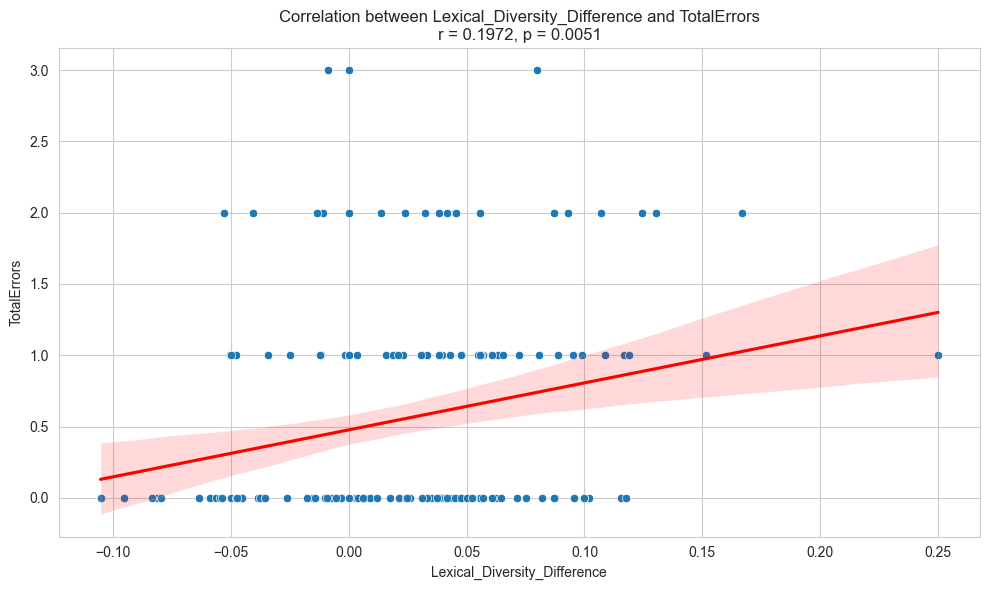

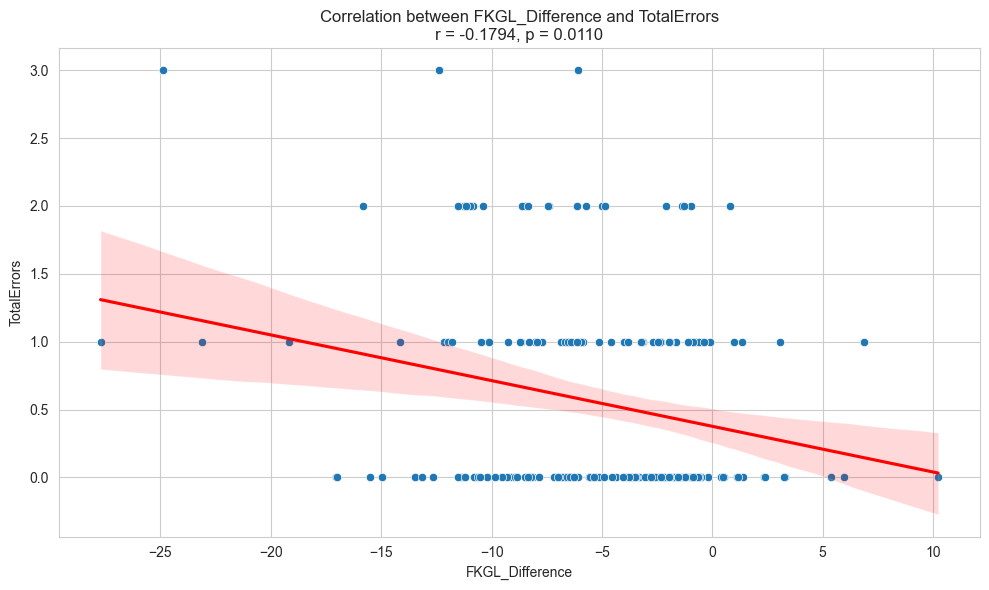

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
0                       FKGL_Source  TotalErrors         0.09     0.20   
1                        ARI_Source  TotalErrors         0.00     0.97   
2          Lexical_Diversity_Source  TotalErrors        -0.12     0.09   
3       Syntactic_Complexity_Source  TotalErrors         0.01     0.90   
4                   FKGL_Difference  TotalErrors        -0.18     0.01   
5                    ARI_Difference  TotalErrors        -0.11     0.11   
6      Lexical_Diversity_Difference  TotalErrors         0.20     0.01   
7   Syntactic_Complexity_Difference  TotalErrors        -0.05     0.52   
8                      BERTScore_F1  TotalErrors        -0.07     0.29   
9                              GLEU  TotalErrors        -0.10     0.15   
10                       LENS_SALSA  TotalErrors         0.10     0.23   

   effect_size                   apa_format  
0   negligible   r_s(198) = 0.09, p = 0.197 

input_characteristic error_metric  correlation  p_value  \
5                   ARI_Difference  TotalErrors        -0.27     0.00   
9                             GLEU  TotalErrors        -0.27     0.00   
1                       ARI_Source  TotalErrors         0.27     0.00   
0                      FKGL_Source  TotalErrors         0.27     0.00   
4                  FKGL_Difference  TotalErrors        -0.26     0.00   
3      Syntactic_Complexity_Source  TotalErrors         0.25     0.00   
2         Lexical_Diversity_Source  TotalErrors        -0.24     0.00   
8                     BERTScore_F1  TotalErrors        -0.22     0.00   
6     Lexical_Diversity_Difference  TotalErrors         0.21     0.00   
7  Syntactic_Complexity_Difference  TotalErrors        -0.16     0.02   

  effect_size                   apa_format  
5       small   r_s(198) = -0.27, p < .001  
9       small   r_s(198) = -0.27, p < .001  
1       small    r_s(198) = 0.27, p < .001  
0       small    r_s(198) = 0.27, p < .001  
4       small   r_s(198) = -0.26, p < .001  
3       small    r_s(198) = 0.25, p < .001  
2       small   r_s(198) = -0.24, p < .001  
8       small  r_s(198) = -0.22, p = 0.002  
6       small   r_s(198) = 0.21, p = 0.003  
7       small  r_s(198) = -0.16, p = 0.025

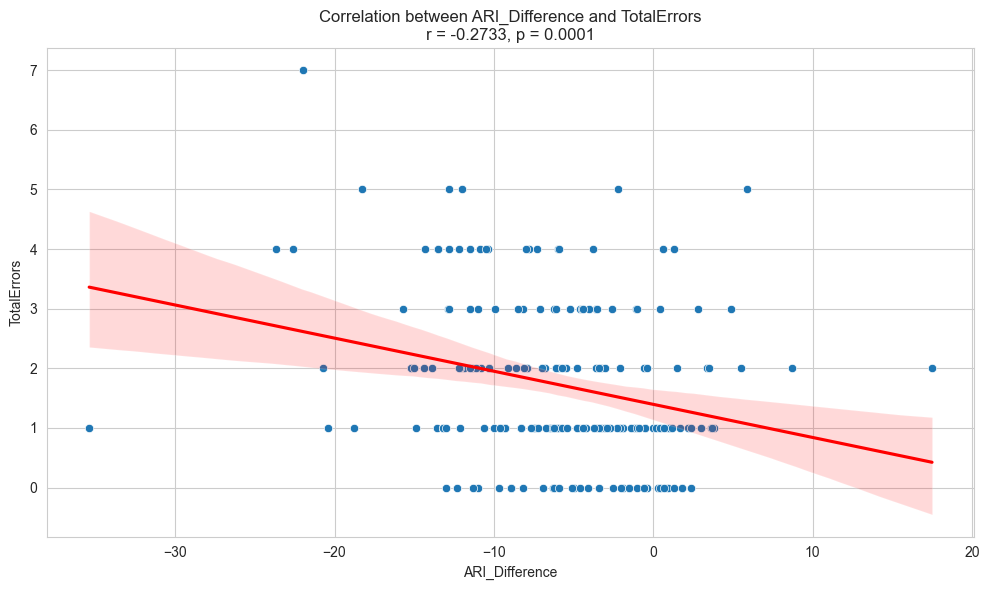

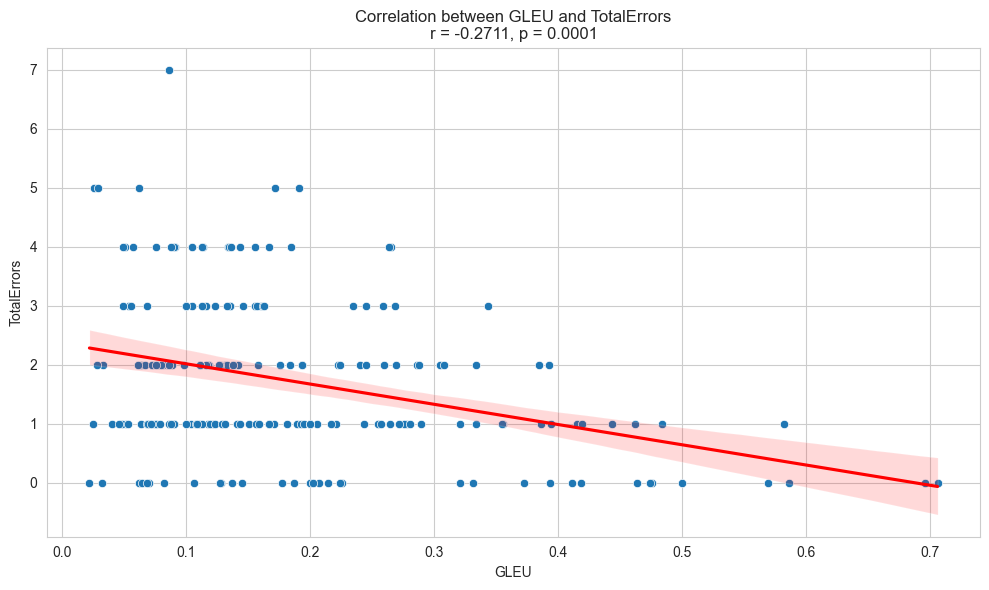

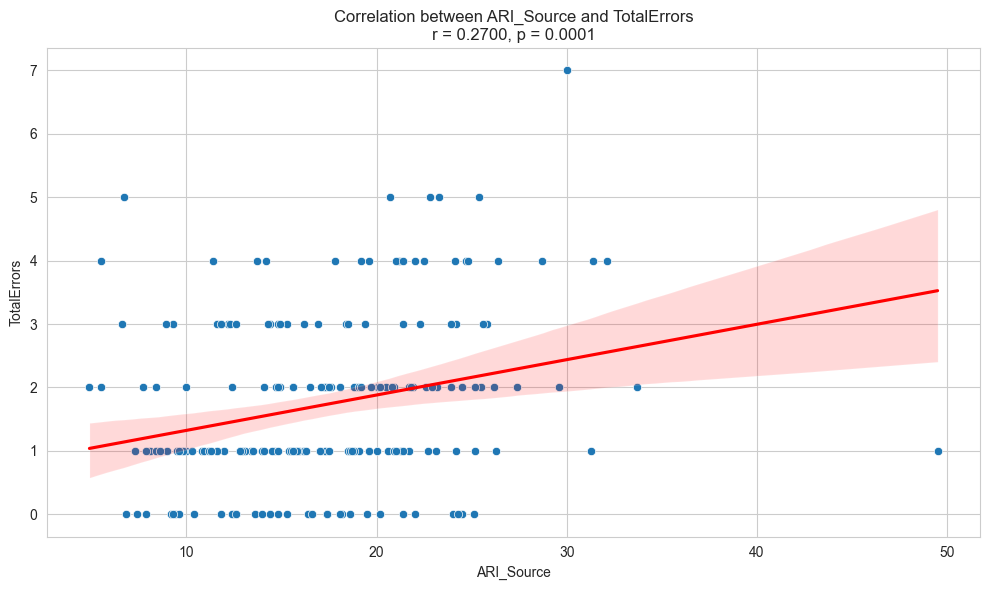

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
0                       FKGL_Source  TotalErrors         0.27     0.00   
1                        ARI_Source  TotalErrors         0.27     0.00   
2          Lexical_Diversity_Source  TotalErrors        -0.24     0.00   
3       Syntactic_Complexity_Source  TotalErrors         0.25     0.00   
4                   FKGL_Difference  TotalErrors        -0.26     0.00   
5                    ARI_Difference  TotalErrors        -0.27     0.00   
6      Lexical_Diversity_Difference  TotalErrors         0.21     0.00   
7   Syntactic_Complexity_Difference  TotalErrors        -0.16     0.02   
8                      BERTScore_F1  TotalErrors        -0.22     0.00   
9                              GLEU  TotalErrors        -0.27     0.00   
10                       LENS_SALSA  TotalErrors        -0.05     0.57   

   effect_size                   apa_format  
0        small    r_s(198) = 0.27, p < .001 

input_characteristic error_metric  correlation  p_value effect_size  \
8         BERTScore_F1  TotalErrors        -0.41     0.00    moderate   
9                 GLEU  TotalErrors        -0.29     0.00       small   
4      FKGL_Difference  TotalErrors        -0.26     0.00       small   
5       ARI_Difference  TotalErrors        -0.21     0.00       small   

                    apa_format  
8   r_s(198) = -0.41, p < .001  
9   r_s(198) = -0.29, p < .001  
4   r_s(198) = -0.26, p < .001  
5  r_s(198) = -0.21, p = 0.003

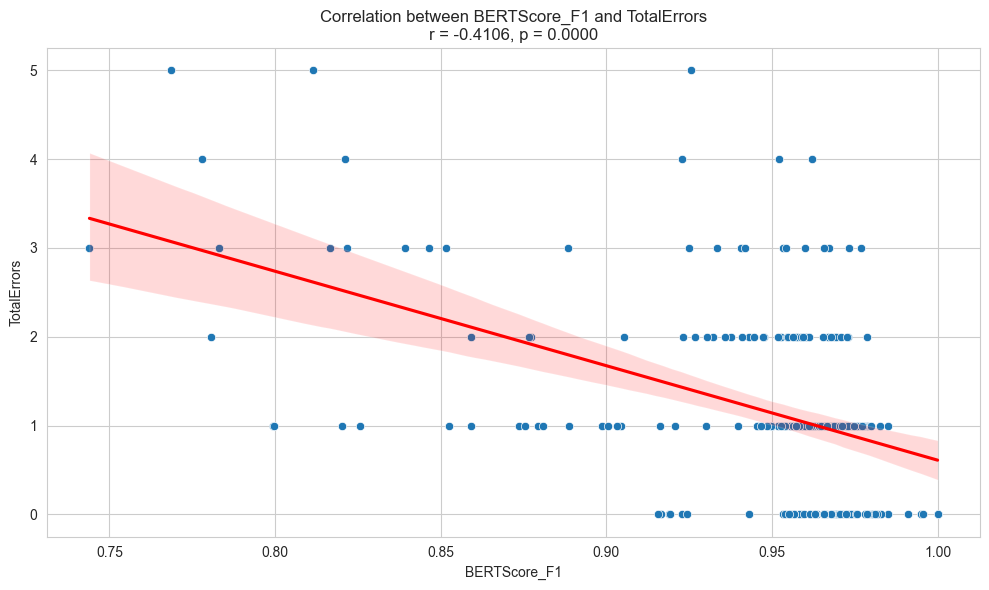

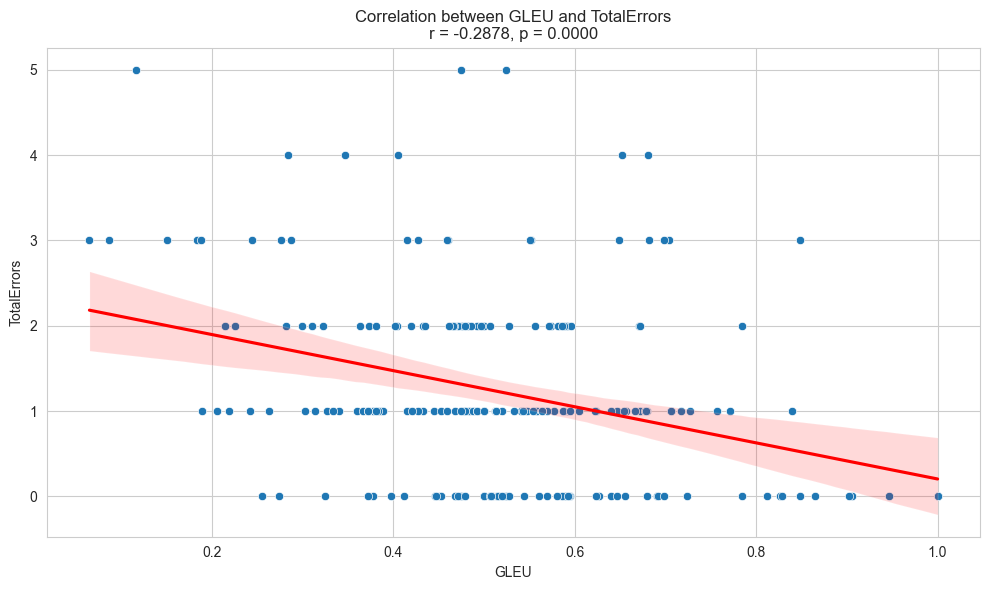

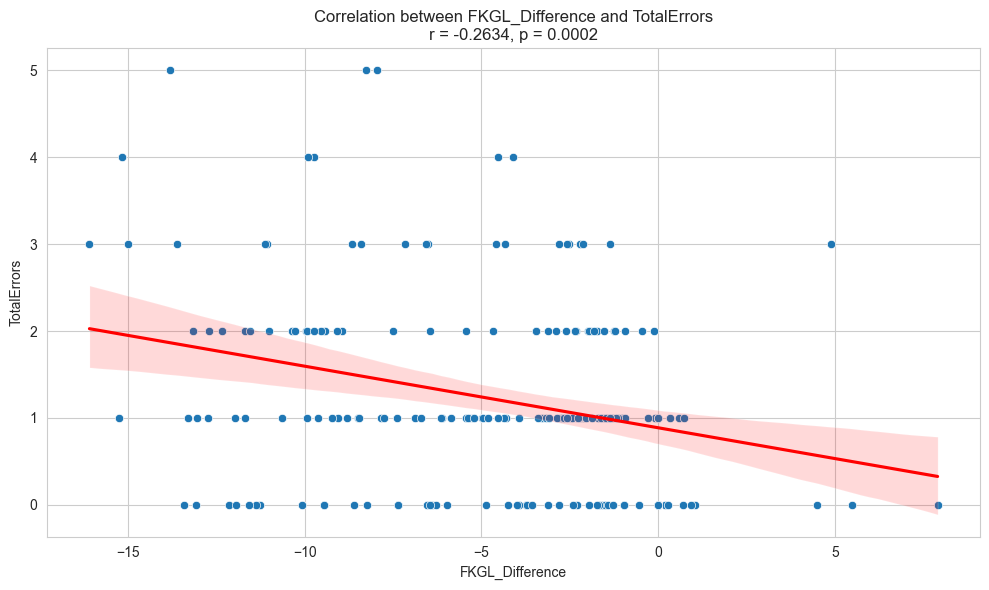

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
0                       FKGL_Source  TotalErrors         0.08     0.27   
1                        ARI_Source  TotalErrors         0.05     0.49   
2          Lexical_Diversity_Source  TotalErrors        -0.00     0.97   
3       Syntactic_Complexity_Source  TotalErrors         0.03     0.68   
4                   FKGL_Difference  TotalErrors        -0.26     0.00   
5                    ARI_Difference  TotalErrors        -0.21     0.00   
6      Lexical_Diversity_Difference  TotalErrors         0.03     0.67   
7   Syntactic_Complexity_Difference  TotalErrors        -0.12     0.10   
8                      BERTScore_F1  TotalErrors        -0.41     0.00   
9                              GLEU  TotalErrors        -0.29     0.00   
10                       LENS_SALSA  TotalErrors        -0.10     0.25   

   effect_size                   apa_format  
0   negligible   r_s(198) = 0.08, p = 0.272 

input_characteristic error_metric  correlation  p_value  \
8                      BERTScore_F1  TotalErrors        -0.72     0.00   
4                   FKGL_Difference  TotalErrors        -0.63     0.00   
6      Lexical_Diversity_Difference  TotalErrors        -0.60     0.00   
9                              GLEU  TotalErrors        -0.56     0.00   
10                       LENS_SALSA  TotalErrors        -0.55     0.00   
5                    ARI_Difference  TotalErrors        -0.39     0.00   
2          Lexical_Diversity_Source  TotalErrors        -0.35     0.00   
0                       FKGL_Source  TotalErrors         0.32     0.00   
3       Syntactic_Complexity_Source  TotalErrors         0.30     0.00   
7   Syntactic_Complexity_Difference  TotalErrors         0.28     0.00   
1                        ARI_Source  TotalErrors         0.18     0.03   

   effect_size                  apa_format  
8        large  r_s(148) = -0.72, p < .001  
4        large  r_s(148) = -0.63, p < .001  
6        large  r_s(148) = -0.60, p < .001  
9        large  r_s(148) = -0.56, p < .001  
10       large  r_s(148) = -0.55, p < .001  
5     moderate  r_s(148) = -0.39, p < .001  
2     moderate  r_s(148) = -0.35, p < .001  
0     moderate   r_s(148) = 0.32, p < .001  
3        small   r_s(148) = 0.30, p < .001  
7        small   r_s(148) = 0.28, p < .001  
1        small  r_s(148) = 0.18, p = 0.032

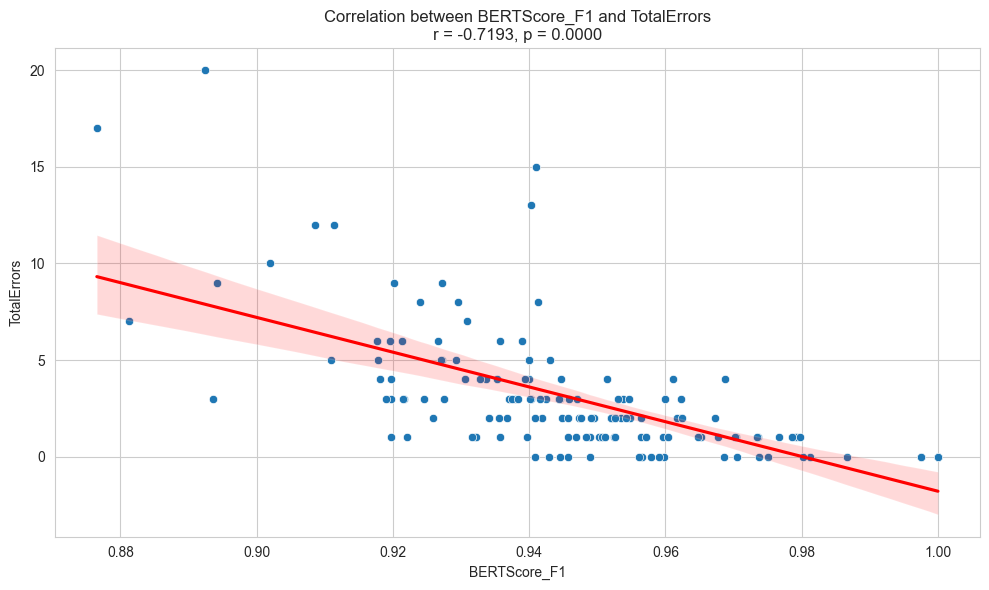

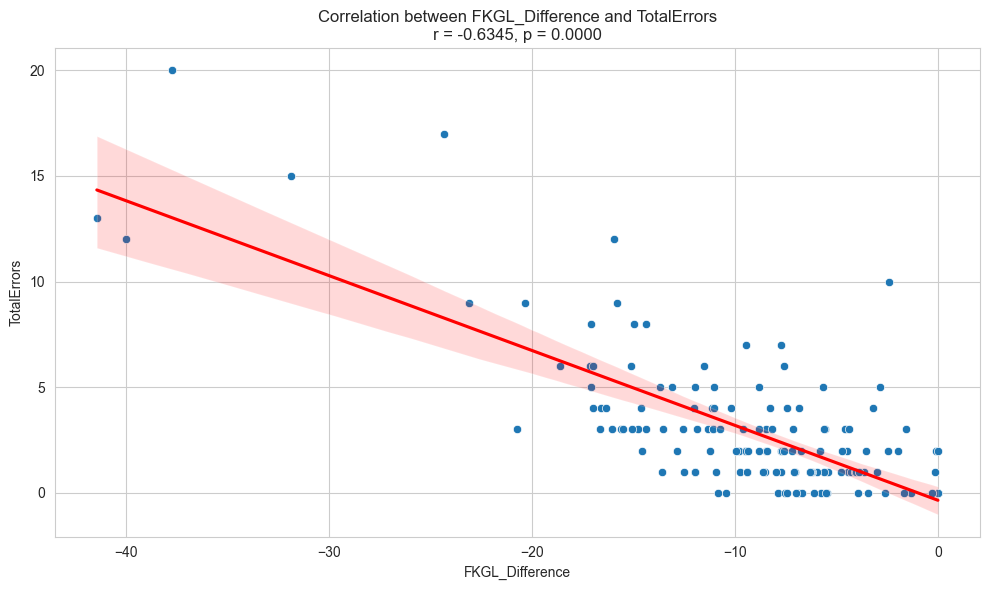

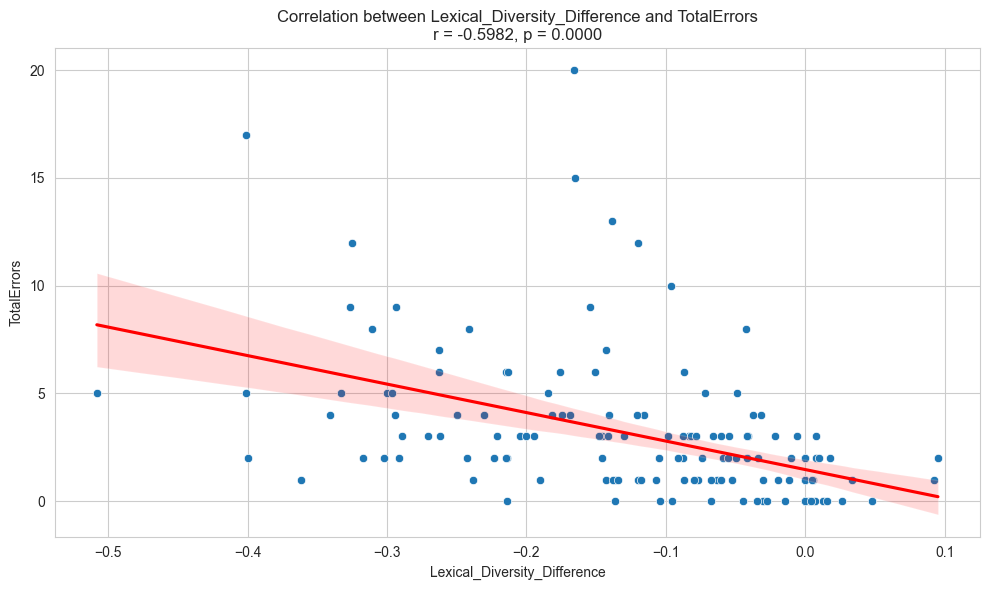

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
0                       FKGL_Source  TotalErrors         0.32     0.00   
1                        ARI_Source  TotalErrors         0.18     0.03   
2          Lexical_Diversity_Source  TotalErrors        -0.35     0.00   
3       Syntactic_Complexity_Source  TotalErrors         0.30     0.00   
4                   FKGL_Difference  TotalErrors        -0.63     0.00   
5                    ARI_Difference  TotalErrors        -0.39     0.00   
6      Lexical_Diversity_Difference  TotalErrors        -0.60     0.00   
7   Syntactic_Complexity_Difference  TotalErrors         0.28     0.00   
8                      BERTScore_F1  TotalErrors        -0.72     0.00   
9                              GLEU  TotalErrors        -0.56     0.00   
10                       LENS_SALSA  TotalErrors        -0.55     0.00   

   effect_size                  apa_format  
0     moderate   r_s(148) = 0.32, p < .001  


In [430]:
# Run the analysis for Total Errors BY SYSTEM
print("Analysing total errors correlation BY SYSTEM")
for system in df_sentences['System'].unique():
    print(f"\n\n\nSystem: {system}")
    system_data = df_sentences[df_sentences['System'] == system]
    input_error_correlations = analyze_input_error_correlations(system_data)
    print(input_error_correlations)


Correlation Analysis: FKGL_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0000 (Non-normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.1687, p-value = 0.0000
Spearman correlation: ρ = 0.1352, p-value = 0.0009

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(598) = 0.14, p < .001

Effect size interpretation: small
Appending test results for FKGL_Source vs TotalErrors, p-value: 0.0008986514585067593

Correlation Analysis: ARI_Source vs TotalErrors

Normality Tests (Shapiro-Wilk):
ARI_Source: p-value = 0.0000 (Non-normal)
TotalErrors: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.1149, p-value = 0.0048
Spearman correlation: ρ = 0.1017, p-value = 0.0127

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(598) = 0.10

input_characteristic error_metric  correlation  p_value  \
8                     BERTScore_F1  TotalErrors        -0.31     0.00   
9                             GLEU  TotalErrors        -0.29     0.00   
4                  FKGL_Difference  TotalErrors        -0.24     0.00   
5                   ARI_Difference  TotalErrors        -0.23     0.00   
6     Lexical_Diversity_Difference  TotalErrors         0.19     0.00   
0                      FKGL_Source  TotalErrors         0.14     0.00   
7  Syntactic_Complexity_Difference  TotalErrors        -0.13     0.00   
2         Lexical_Diversity_Source  TotalErrors        -0.11     0.01   
1                       ARI_Source  TotalErrors         0.10     0.01   
3      Syntactic_Complexity_Source  TotalErrors         0.09     0.02   

  effect_size                   apa_format  
8    moderate   r_s(598) = -0.31, p < .001  
9       small   r_s(598) = -0.29, p < .001  
4       small   r_s(598) = -0.24, p < .001  
5       small   r_s(598) = -0.23, p < .001  
6       small    r_s(598) = 0.19, p < .001  
0       small    r_s(598) = 0.14, p < .001  
7       small  r_s(598) = -0.13, p = 0.002  
2       small  r_s(598) = -0.11, p = 0.007  
1       small   r_s(598) = 0.10, p = 0.013  
3  negligible   r_s(598) = 0.09, p = 0.022

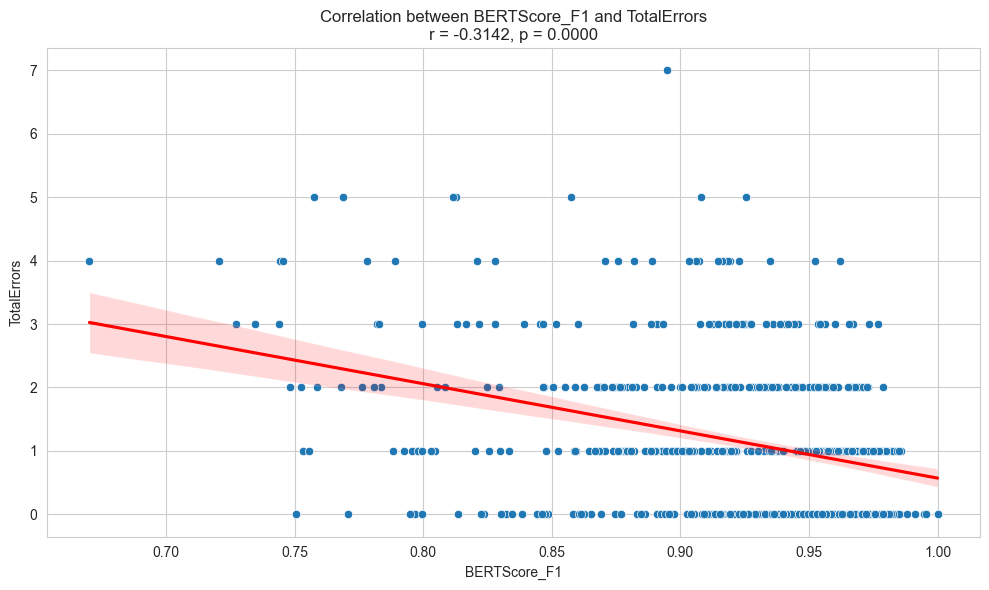

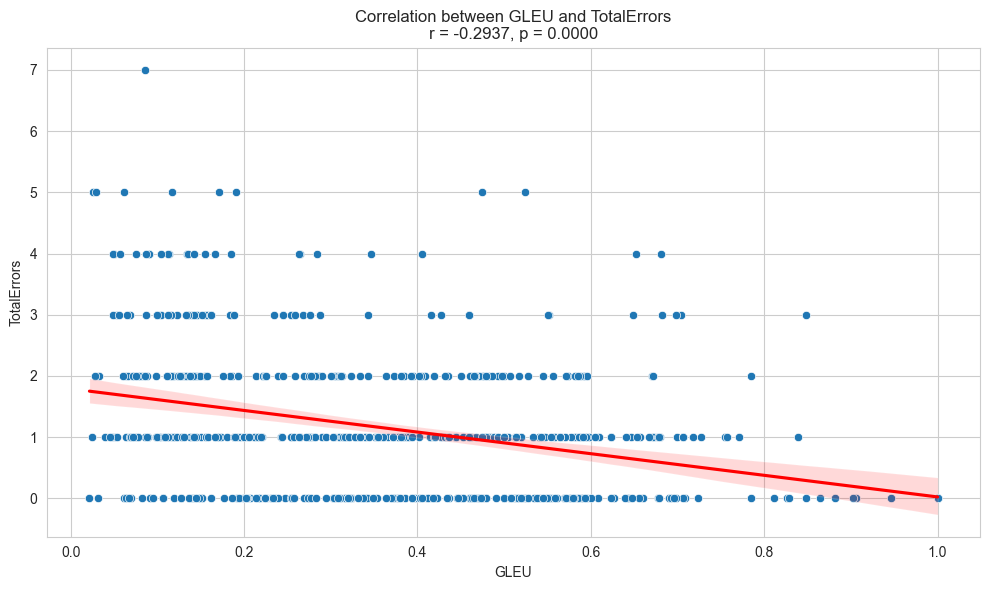

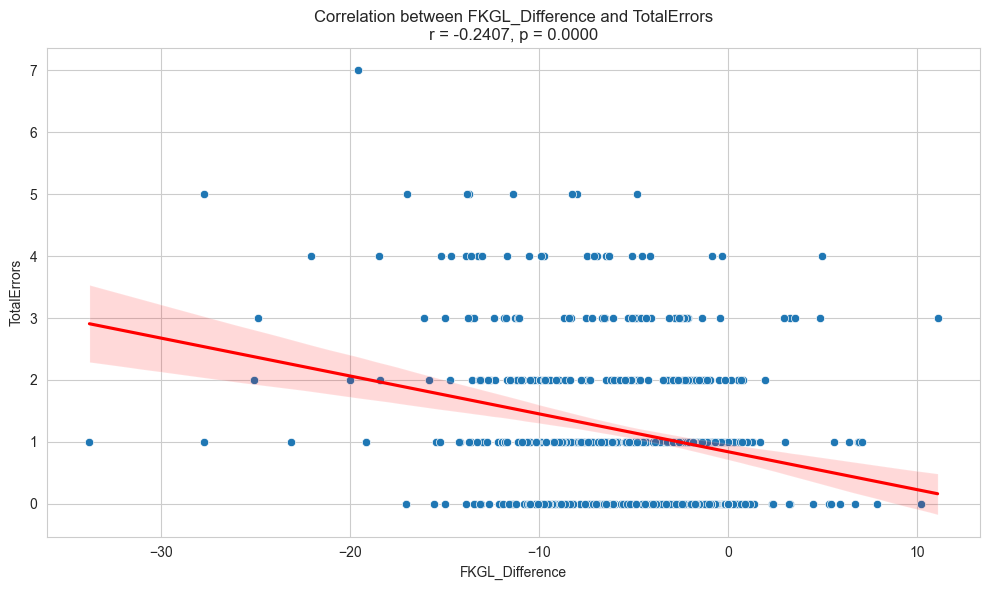

{'all_correlations':                input_characteristic error_metric  correlation  p_value  \
0                       FKGL_Source  TotalErrors         0.14     0.00   
1                        ARI_Source  TotalErrors         0.10     0.01   
2          Lexical_Diversity_Source  TotalErrors        -0.11     0.01   
3       Syntactic_Complexity_Source  TotalErrors         0.09     0.02   
4                   FKGL_Difference  TotalErrors        -0.24     0.00   
5                    ARI_Difference  TotalErrors        -0.23     0.00   
6      Lexical_Diversity_Difference  TotalErrors         0.19     0.00   
7   Syntactic_Complexity_Difference  TotalErrors        -0.13     0.00   
8                      BERTScore_F1  TotalErrors        -0.31     0.00   
9                              GLEU  TotalErrors        -0.29     0.00   
10                       LENS_SALSA  TotalErrors         0.01     0.77   

   effect_size                   apa_format  
0        small    r_s(598) = 0.14, p < .001 

In [431]:
# Run the analysis for Total Errors - WITHOUT DisSim
input_error_correlations = analyze_input_error_correlations(df_sentences, exclude_DisSim=True)

print(input_error_correlations)


Correlation Analysis: FKGL_Source vs ErrorFreq

Normality Tests (Shapiro-Wilk):
FKGL_Source: p-value = 0.0000 (Non-normal)
ErrorFreq: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = 0.0456, p-value = 0.2169
Spearman correlation: ρ = 0.0418, p-value = 0.2586

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(732) = 0.04, p = 0.259

Effect size interpretation: negligible
Appending test results for FKGL_Source vs ErrorFreq, p-value: 0.25857013247222654

Correlation Analysis: ARI_Source vs ErrorFreq

Normality Tests (Shapiro-Wilk):
ARI_Source: p-value = 0.0000 (Non-normal)
ErrorFreq: p-value = 0.0000 (Non-normal)

Correlation Results:
Pearson correlation: r = -0.0222, p-value = 0.5478
Spearman correlation: ρ = -0.0060, p-value = 0.8715

Recommended correlation method: Spearman
(based on normality tests of the variables)

--- Formatted APA Output ---
APA Format: r_s(732) = -0.01, p

input_characteristic error_metric  correlation  p_value  \
10                    LENS_SALSA    ErrorFreq        -0.33     0.00   
4                FKGL_Difference    ErrorFreq        -0.18     0.00   
6   Lexical_Diversity_Difference    ErrorFreq        -0.15     0.00   
5                 ARI_Difference    ErrorFreq        -0.13     0.00   
8                   BERTScore_F1    ErrorFreq        -0.09     0.02   
9                           GLEU    ErrorFreq         0.08     0.02   

   effect_size                   apa_format  
10    moderate   r_s(586) = -0.33, p < .001  
4        small   r_s(732) = -0.18, p < .001  
6        small   r_s(732) = -0.15, p < .001  
5        small   r_s(732) = -0.13, p < .001  
8   negligible  r_s(732) = -0.09, p = 0.017  
9   negligible   r_s(732) = 0.08, p = 0.025

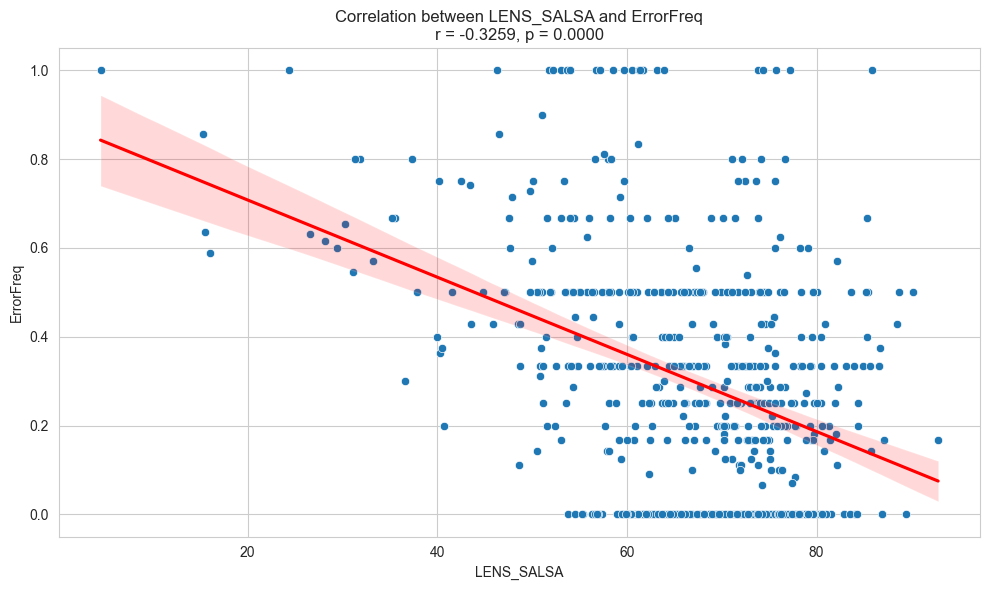

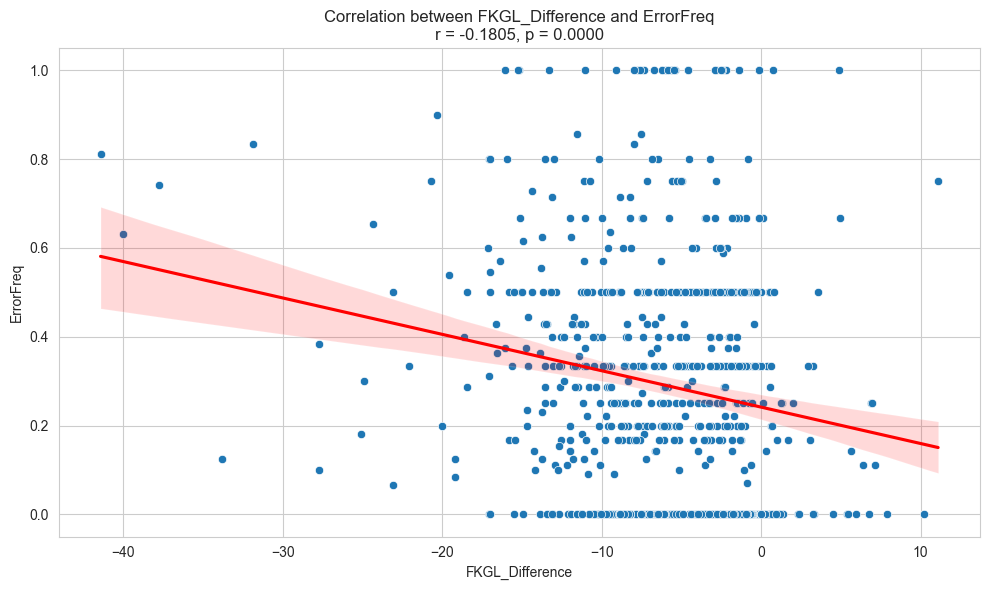

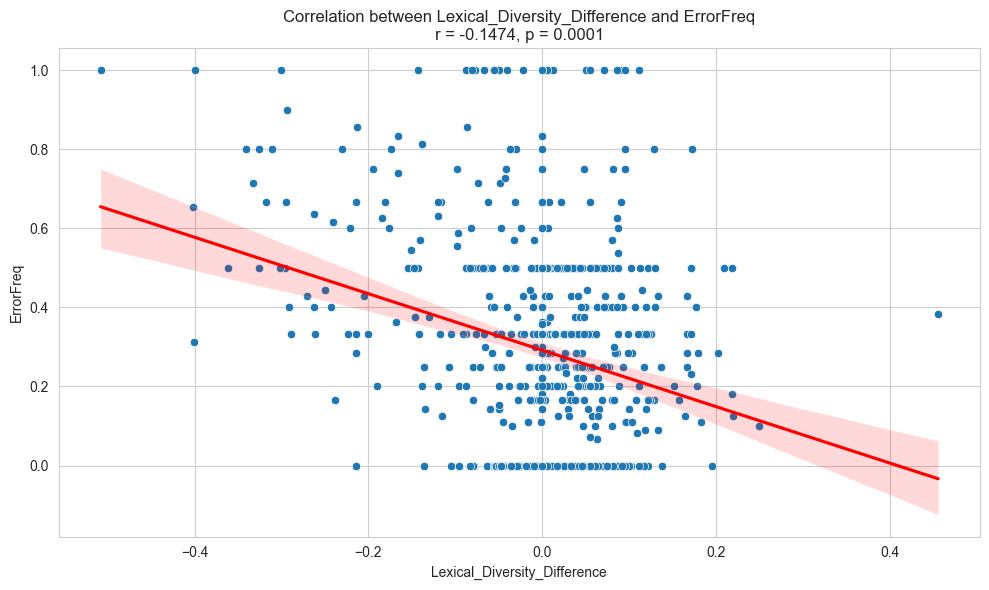

In [432]:
df_temp = df_sentences.copy()
df_temp['ErrorFreq'] = df_temp['TotalErrors'] / df_temp['Total Edits']

input_errorFreq_correlations = analyze_input_error_correlations(df_temp,
    error_metrics=['ErrorFreq'])

### Multiple Linear Regression

#### Function Definitions for MLR

In [433]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.lines import Line2D
from scipy.stats import boxcox
import os

def perform_regression_analysis(
    df,
    dependent_var,
    independent_vars,
    categorical_independent_vars,
    print_summary = True,
    plot_coeffs = True,
    robustErrors = True,
    transform = False,
    exclude_DisSim = False,
    save_to_csv=False  # if True, results will be saved to CSV
):
    if exclude_DisSim:
        df = df[df['System'] != 'DisSim'].copy()
   
    # Prepare data
    data = df[[dependent_var] 
        + independent_vars 
        + categorical_independent_vars].copy()
    
    # Create domain mappings before dummy encoding
    if "Dataset" in categorical_independent_vars:
        # Create domain flags (case-insensitive matching)
        if "cochrane" in data["Dataset"].str.lower().unique():
            data["domain_medical"] = data["Dataset"].str.lower().apply(
                lambda x: 1 if x == "cochrane" else 0
            )
        if "scotus" in data["Dataset"].str.lower().unique():
            data["domain_legal"] = data["Dataset"].str.lower().apply(
                lambda x: 1 if x == "scotus" else 0
        )

        if "wikide" in data["Dataset"].str.lower().unique():
            data["language_de"] = data["Dataset"].str.lower().apply(
                lambda x: 1 if x == "wikide" else 0
            )
            wikIDE_added = True
        
        # Remove Dataset from categorical vars
        categorical_independent_vars = [x for x in categorical_independent_vars if x != "Dataset"]
        data = data.drop(columns=["Dataset"])
        
        # Add new domain columns to independent vars
        independent_vars = independent_vars + ["domain_medical", "domain_legal"]
        if wikIDE_added:
            independent_vars = independent_vars + ["language_de"]
    
    # Remove any rows with NaN values
    initial_rows = len(data)
    data = data.dropna()
    final_rows = len(data)
    
    print(f"Rows removed due to NaN: {initial_rows - final_rows}")
    
    # Create dummy variables for remaining categorical columns
    if categorical_independent_vars:
        #print(f"Creating dummies for: {categorical_independent_vars}")
        data = pd.get_dummies(
            data, 
            columns=categorical_independent_vars, 
            drop_first=True,
            dtype=float
        )

    
    # Ensure all data is numeric
    for col in data.columns:
        if not np.issubdtype(data[col].dtype, np.number):
            #print(f"Converting {col} to numeric...")
            data[col] = pd.to_numeric(data[col], errors='coerce')
    
    data = data.dropna()
    print(f"Final shape after cleaning: {data.shape}")
    
    # Verify we have data
    if len(data) == 0:
        raise ValueError("No valid data rows remaining after cleaning")
    
    # Prepare variables
    y = data[dependent_var]
    X = sm.add_constant(data.drop(columns=[dependent_var]))

    # Transform dependent variable if needed
    if transform == "log":
        y = np.log(y)
    if transform == "boxcox":
        y, _ = boxcox(y)
    if transform == "sqrt":
        y = np.sqrt(y)

    # transform independent variables if needed
    if transform == "log":
        X = np.log(X)
    if transform == "boxcox":
        X, _ = boxcox(X)
    if transform == "sqrt":
        X = np.sqrt(X)
    

    # Verify no infinite values
    if not np.all(np.isfinite(X)) or not np.all(np.isfinite(y)):
        raise ValueError("Data contains infinite values")
    
    # Fit model
    if robustErrors:
        model = sm.OLS(y, X).fit(cov_type='HC3')
    else:
        model = sm.OLS(y, X).fit()
    print("Model fitted successfully")

    if robustErrors:
        print("Robust errors used!")
    
    if print_summary:
        print("\nRegression Results:")
        print("=" * 50)
        print(model.summary().tables[1])

        print("\nConfidence Intervals:")
        print(model.conf_int())

    
    # Calculate VIF
    vif_data = pd.DataFrame({
        "Variable": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    
    # Store results
    results = {
        "model": model,
        "coefficients": pd.DataFrame({
            "coef": model.params,
            "std_err": model.bse,
            "t_value": model.tvalues,
            "p_value": model.pvalues
        }),
        "fit": {
            "r_squared": model.rsquared,
            "adj_r_squared": model.rsquared_adj,
            "f_statistic": model.fvalue,
            "f_pvalue": model.f_pvalue
        },
        "diagnostics": {
            "vif": vif_data,
            "residuals": model.resid,
            "fitted_values": model.fittedvalues
        }
    }

    # --- Save results to CSV if requested ---
    if save_to_csv:
        # Define the fixed directory to save CSV files.
        SAVE_DIR = "../data/charts_data"
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
        
        # Construct file path: file name includes the dependent variable name.
        file_name = f"MLR_results_{dependent_var}.csv"
        file_path = os.path.join(SAVE_DIR, file_name)
        
        # Extract the coefficients DataFrame from results.
        # Reset the index so that the variable names become a column.
        coefficients_df = results["coefficients"].copy().reset_index()
        coefficients_df.rename(columns={'index': 'Variable'}, inplace=True)
        
        # Save the DataFrame to CSV.
        coefficients_df.to_csv(file_path, index=False)
        print(f"Results saved to {file_path}")

    # Check regression assumptions
    assumption_results = check_regression_assumptions(
        results,
        X
    )
    
    if print_summary:
        print("\nVariance Inflation Factors:")
        print(vif_data)
        print("\nModel Fit:")
        print(f"R-squared: {model.rsquared:.3f}")
        print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")
    
    if assumption_results and print_summary:
        print(f"DEBUG: assumption_results: {assumption_results}")
        print("\nRegression Assumptions:")
        print("=" * 50)

        for name, result in assumption_results.items():
            print(f"\n{name}:")
            print(f"Value: {result['value']:.3f}")
            print(f"Threshold: {result['threshold']}")
            print(f"Status: {result['judgment']}")
        
    if plot_coeffs:
        plot_regression_coefficients(
            results,
            figsize=(12, 8),
            exclude_vars=['const'],
            title=f'Regression Coefficients for {dependent_var}'
        )
        plt.show()
    
    return results


def plot_regression_coefficients(results, figsize=(10, 6), exclude_vars=None, title=None, alpha=0.05):
    """
    Create a dot-whisker plot for regression coefficients with p-value indicators.
    """
    # Extract coefficients and confidence intervals
    coef_df = results["coefficients"]
    conf_int = results["model"].conf_int()
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'coef': coef_df['coef'],
        'err_low': conf_int[0],
        'err_high': conf_int[1],
        'p_value': coef_df['p_value'],
        'varname': coef_df.index
    })
    
    # Exclude specified variables
    if exclude_vars:
        plot_df = plot_df[~plot_df['varname'].isin(exclude_vars)]
    
    # Sort by coefficient size for better visualization
    plot_df = plot_df.sort_values('coef')
    
    # Create indices for plotting
    plot_df['idx'] = range(len(plot_df))
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot horizontal lines for confidence intervals
    for _, row in plot_df.iterrows():
        # Use different colors based on significance
        color = 'black' if row['p_value'] < alpha else 'gray'
        alpha_val = 0.8 if row['p_value'] < alpha else 0.3
        
        ax.hlines(y=row['idx'], xmin=row['err_low'], xmax=row['err_high'], 
                 color=color, alpha=alpha_val)
        
        # Add stars for significance levels
        if row['p_value'] < 0.001:
            stars = '***'
        elif row['p_value'] < 0.01:
            stars = '**'
        elif row['p_value'] < 0.05:
            stars = '*'
        else:
            stars = ''
            
        if stars:  # Only add text if significant
            ax.text(row['coef'], row['idx'], f' {stars}', 
                   va='center', ha='left' if row['coef'] >= 0 else 'right',
                   color=color)
    
    significant = plot_df['p_value'] < alpha
    ax.scatter(plot_df[significant]['coef'], 
              plot_df[significant]['idx'], 
              color='black', s=50, zorder=5)
    ax.scatter(plot_df[~significant]['coef'], 
              plot_df[~significant]['idx'], 
              color='gray', s=50, zorder=5, alpha=0.3)
    
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    ax.set_yticks(plot_df['idx'])
    ax.set_yticklabels([f"{name}\np={p:.3f}" if p < alpha else name 
                        for name, p in zip(plot_df['varname'], plot_df['p_value'])], 
                       fontsize=10)
    
    if title:
        ax.set_title(title, fontsize=12, pad=20)
    
    ax.set_xlabel('Coefficient Estimate', fontsize=10)
    
    # Add legend for significance levels
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
               label='p < 0.05', markersize=8),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               label='p ≥ 0.05', markersize=8, alpha=0.3),
    ]
    ax.legend(handles=legend_elements, loc='best')
    
    # Add significance level annotation
    plt.figtext(0.99, 0.01, '* p<0.05, ** p<0.01, *** p<0.001',
                ha='right', va='bottom', fontsize=8)
    
    # Add grid for better readability
    ax.grid(True, axis='x', alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Define constants
ASSUMPTION_THRESHOLDS = {
    'linearity': 0.1,     # Correlation coefficient threshold
    'normality': 0.05,    # Shapiro-Wilk p-value threshold  
    'heterosked': 0.05,   # Breusch-Pagan p-value threshold
    'dw_lower': 1.5,      # Durbin-Watson lower bound
    'dw_upper': 2.5,      # Durbin-Watson upper bound
    'vif': 5.0           # Variance Inflation Factor threshold
}

def evaluate_assumption(name, value, threshold, higher_is_better=True):
    """Helper to evaluate if assumption is met"""
    if higher_is_better:
        fulfilled = value >= threshold
    else:
        fulfilled = value <= threshold
    return {
        'value': value,
        'threshold': threshold,
        'fulfilled': fulfilled,
        'judgment': "✓ Fulfilled" if fulfilled else "✗ Violated"
    }


def check_regression_assumptions(results, X, plot=False):
    """Check regression assumptions with clear judgments"""
    try:
        residuals = results['diagnostics']['residuals']
        fitted = results['diagnostics']['fitted_values']
        
        # Calculate statistics
        linearity_corr = abs(stats.pearsonr(fitted, residuals)[0])
        _, normality_pval = stats.shapiro(residuals)
        bp_stat, bp_pval, f_stat, f_pval = het_breuschpagan(residuals, X)
        dw_stat = durbin_watson(residuals)
        
        # Create assumption results
        assumptions = {
            'Linearity': evaluate_assumption(
                'linearity', linearity_corr, ASSUMPTION_THRESHOLDS['linearity'], False),
            'Normality': evaluate_assumption(
                'normality', normality_pval, ASSUMPTION_THRESHOLDS['normality']),
            'Homoscedasticity': evaluate_assumption(
                'heterosked', bp_pval, ASSUMPTION_THRESHOLDS['heterosked']),
            'Independence': evaluate_assumption_range(
                'independence', dw_stat, 
                ASSUMPTION_THRESHOLDS['dw_lower'],
                ASSUMPTION_THRESHOLDS['dw_upper'])
        }

            
        return assumptions
        
    except Exception as e:
        print(f"Error checking assumptions: {str(e)}")
        return None

def evaluate_assumption(name, value, threshold, higher_is_better=True):
    """Evaluate if assumption meets threshold"""
    fulfilled = value >= threshold if higher_is_better else value <= threshold
    return {
        'value': value,
        'threshold': threshold,
        'fulfilled': fulfilled,
        'judgment': "✓ Fulfilled" if fulfilled else "✗ Violated"
    }

def evaluate_assumption_range(name, value, lower, upper):
    """Evaluate if assumption falls within acceptable range"""
    fulfilled = lower <= value <= upper
    return {
        'value': value,
        'threshold': f"{lower} - {upper}",
        'fulfilled': fulfilled,
        'judgment': "✓ Fulfilled" if fulfilled else "✗ Violated"
    }

#### MLR Execution
##### Quality Scores Outcomes

Analysing regression for GLEU
Rows removed due to NaN: 0
Final shape after cleaning: (750, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.6013      0.021     29.074      0.000       0.561       0.642
FKGL_Source                            -0.0013      0.001     -1.034      0.301      -0.004       0.001
Insertion_count                         0.0144      0.007      2.164      0.030       0.001       0.027
Deletion_count                         -0.0318      0.005     -6.893      0.000      -0.041      -0.023
Substitution_count                     -0.0095      0.003     -3.190      0.001      -0.015      -0.004
Reorder_count                           0.0212      0.007      3.167      0.002       0.008       0.034
Split_

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


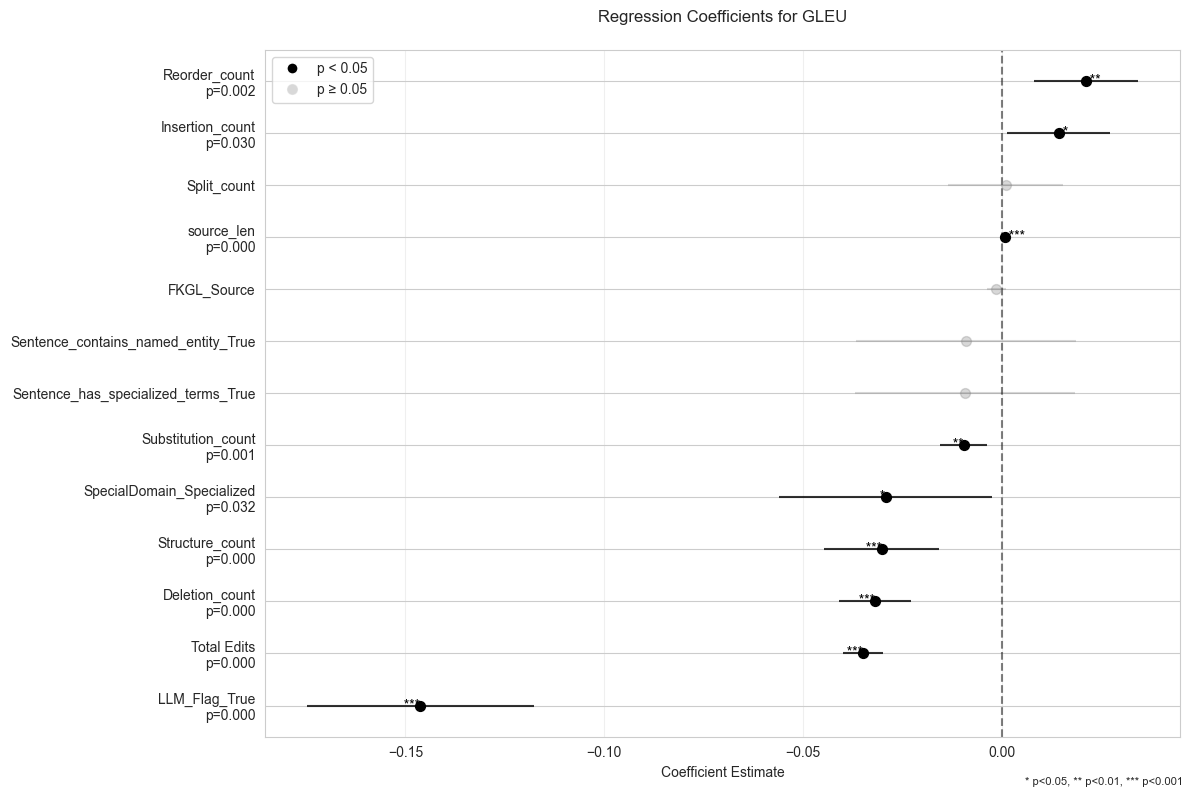

##################################################
Analysing regression for BERTScore_F1
Rows removed due to NaN: 0
Final shape after cleaning: (750, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.9534      0.005    183.819      0.000       0.943       0.964
FKGL_Source                             0.0006      0.000      1.389      0.165      -0.000       0.001
Insertion_count                        -0.0051      0.003     -1.947      0.052      -0.010    3.48e-05
Deletion_count                         -0.0086      0.002     -5.405      0.000      -0.012      -0.005
Substitution_count                      0.0019      0.001      1.900      0.057   -6.09e-05       0.004
Reorder_count                          -0.0017     

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


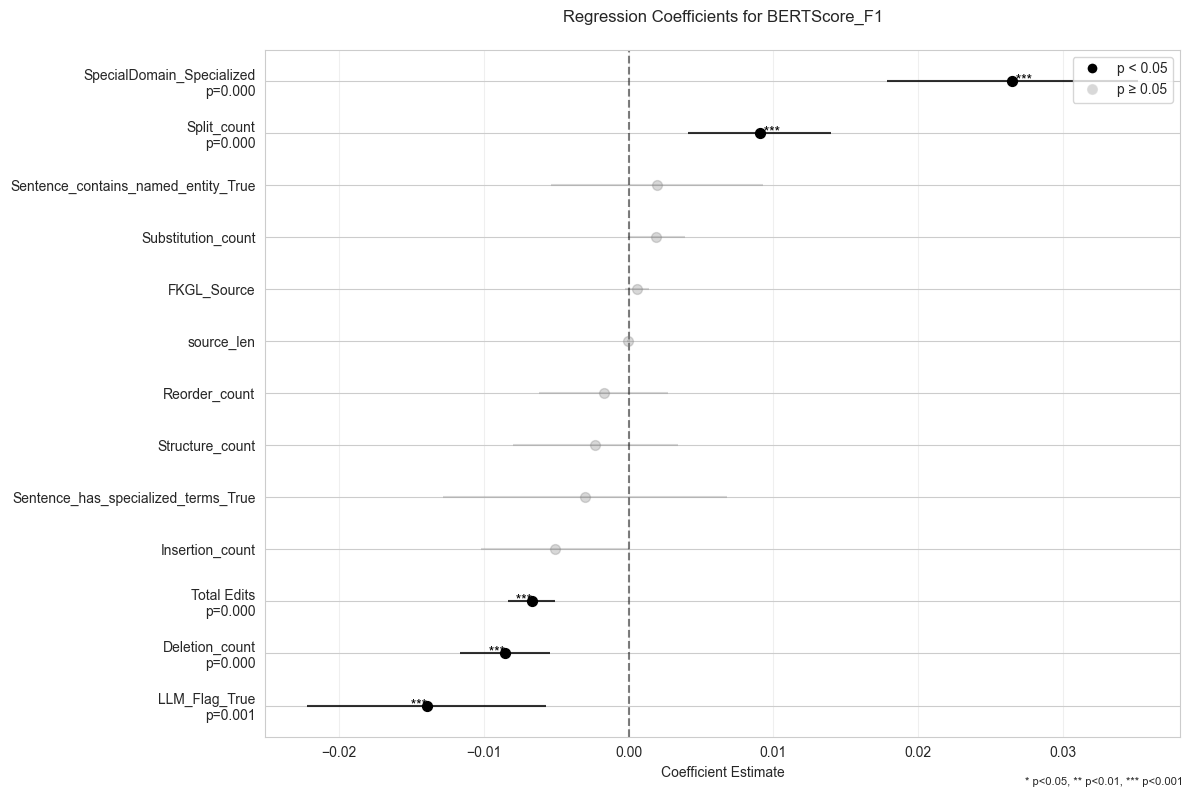

##################################################
Analysing regression for LENS_SALSA
Rows removed due to NaN: 150
Final shape after cleaning: (600, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  67.8679      1.627     41.706      0.000      64.679      71.057
FKGL_Source                             0.2305      0.103      2.232      0.026       0.028       0.433
Insertion_count                        -0.0291      0.568     -0.051      0.959      -1.143       1.085
Deletion_count                          1.0667      0.327      3.260      0.001       0.425       1.708
Substitution_count                      1.5773      0.222      7.118      0.000       1.143       2.012
Reorder_count                          -1.4048     

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


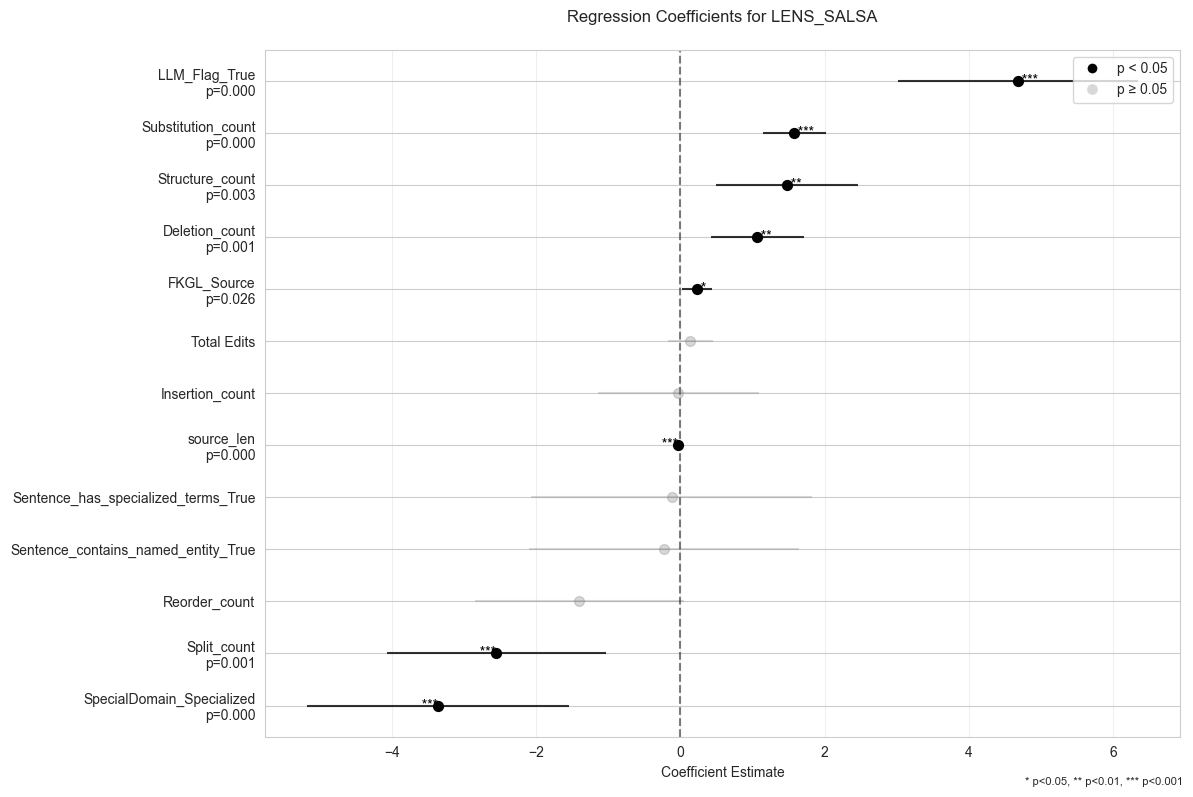

##################################################


In [434]:
# First Regression Run: Quality Outcomes
# # Define variable groups
outcome_variables = [
    'GLEU',
    'BERTScore_F1',
    'LENS_SALSA'
]

quality_predictors = [
    'FKGL_Source', 
    'Insertion_count', 'Deletion_count', 'Substitution_count',
    'Reorder_count', 'Split_count', 'Structure_count',

    # Controlling for ...
    'source_len',
    'Total Edits'
]

categorical_predictors = [
    'Sentence_has_specialized_terms',
    'Sentence_contains_named_entity',
    'SpecialDomain',
    'Language',
    'LLM_Flag',

    # Controlling Variables:
    #'System', --> using LLM_Flag instead
    
]


# Analyze given quality metric
for metric in outcome_variables:

    print(f"Analysing regression for {metric}")
    results = perform_regression_analysis(
        df_sentences,
        metric,
        quality_predictors,
        categorical_predictors,
        save_to_csv=True
    )
    print("#" * 50)

##### Error-Focused Outcomes

Analysing regression for TotalErrors
Rows removed due to NaN: 0
Final shape after cleaning: (750, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0329      0.206      0.160      0.873      -0.371       0.437
FKGL_Source                             0.0275      0.014      1.990      0.047       0.000       0.055
Insertion_count                         0.2151      0.085      2.517      0.012       0.048       0.383
Deletion_count                          0.0391      0.052      0.752      0.452      -0.063       0.141
Substitution_count                     -0.1061      0.033     -3.263      0.001      -0.170      -0.042
Reorder_count                           0.0609      0.107      0.572      0.568      -0.148       0.270

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


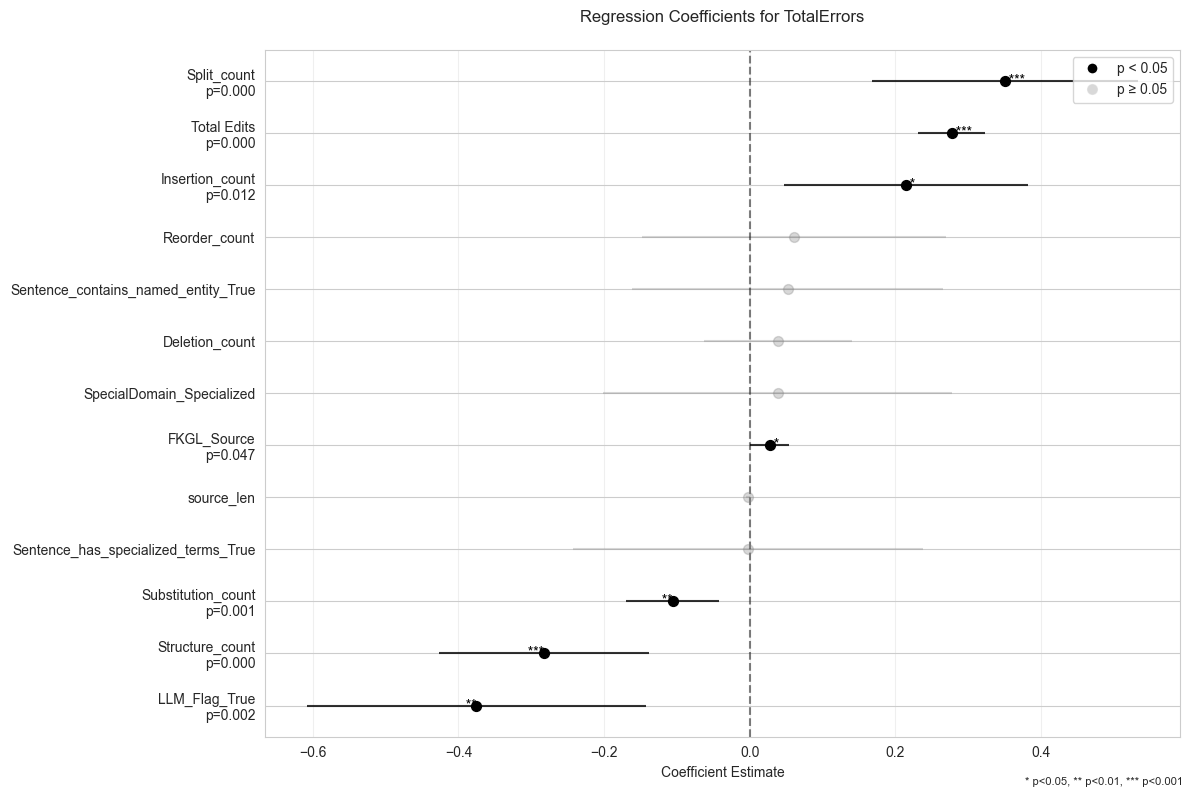

##################################################
Analysing regression for high
Rows removed due to NaN: 0
Final shape after cleaning: (750, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0855      0.071      1.213      0.225      -0.053       0.224
FKGL_Source                             0.0019      0.005      0.376      0.707      -0.008       0.012
Insertion_count                         0.0690      0.028      2.494      0.013       0.015       0.123
Deletion_count                          0.0350      0.016      2.184      0.029       0.004       0.066
Substitution_count                      0.0003      0.010      0.025      0.980      -0.020       0.021
Reorder_count                           0.0336      0.028  

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


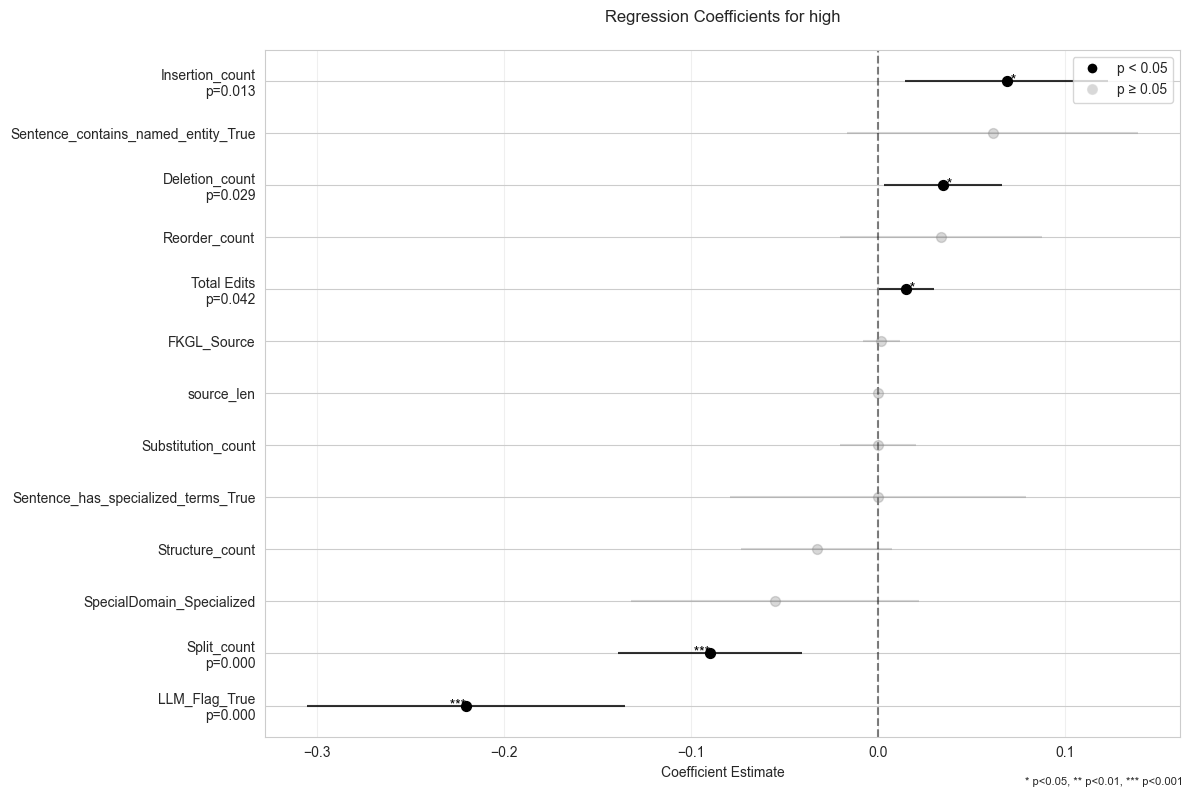

##################################################
Analysing regression for medium+high
Rows removed due to NaN: 0
Final shape after cleaning: (750, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.4270      0.137      3.107      0.002       0.158       0.696
FKGL_Source                            -0.0036      0.009     -0.379      0.704      -0.022       0.015
Insertion_count                         0.1063      0.055      1.929      0.054      -0.002       0.214
Deletion_count                          0.0453      0.031      1.481      0.139      -0.015       0.105
Substitution_count                     -0.0483      0.020     -2.365      0.018      -0.088      -0.008
Reorder_count                           0.0777      

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


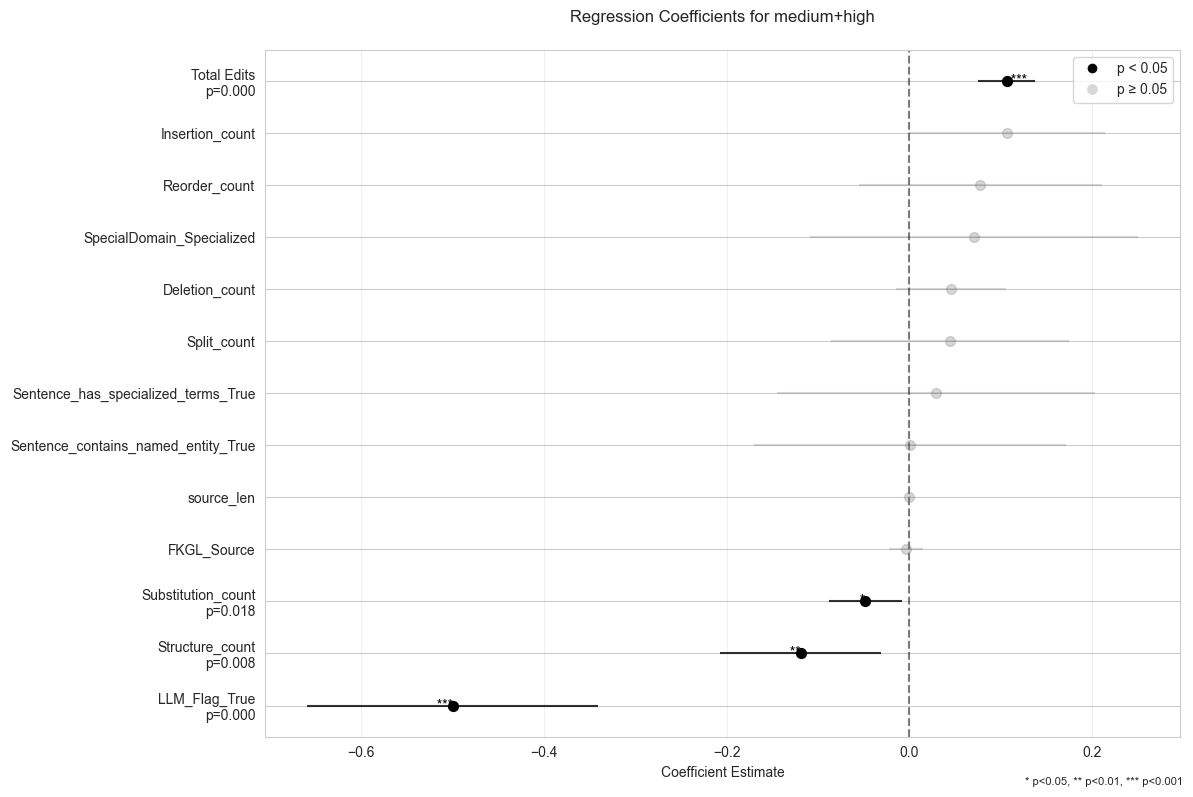

##################################################


In [435]:
# Error-focused Regression Run - First for all, then high, then medium + high
outcome_variables = [
    'TotalErrors',
    'high', # count of highest category of bad edits
    'medium+high'
]

df_sentences_temp = df_sentences.copy()
df_sentences_temp['medium+high'] = df_sentences_temp['medium'] + df_sentences_temp['high']

# Analyze given quality metric
for outcome_metric in outcome_variables:

    print(f"Analysing regression for {outcome_metric}")
    results = perform_regression_analysis(
        df_sentences_temp,
        outcome_metric,
        quality_predictors,
        categorical_predictors,
        save_to_csv=True
    )
    print("#" * 50)

Analysing regression for TotalErrors
Rows removed due to NaN: 0
Final shape after cleaning: (400, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.2330      0.193     -1.206      0.228      -0.611       0.146
FKGL_Source                             0.0201      0.014      1.446      0.148      -0.007       0.047
Insertion_count                         0.0930      0.089      1.040      0.299      -0.082       0.268
Deletion_count                          0.2206      0.047      4.679      0.000       0.128       0.313
Substitution_count                      0.1460      0.038      3.859      0.000       0.072       0.220
Reorder_count                          -0.0860      0.076     -1.135      0.257      -0.235       0.063

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


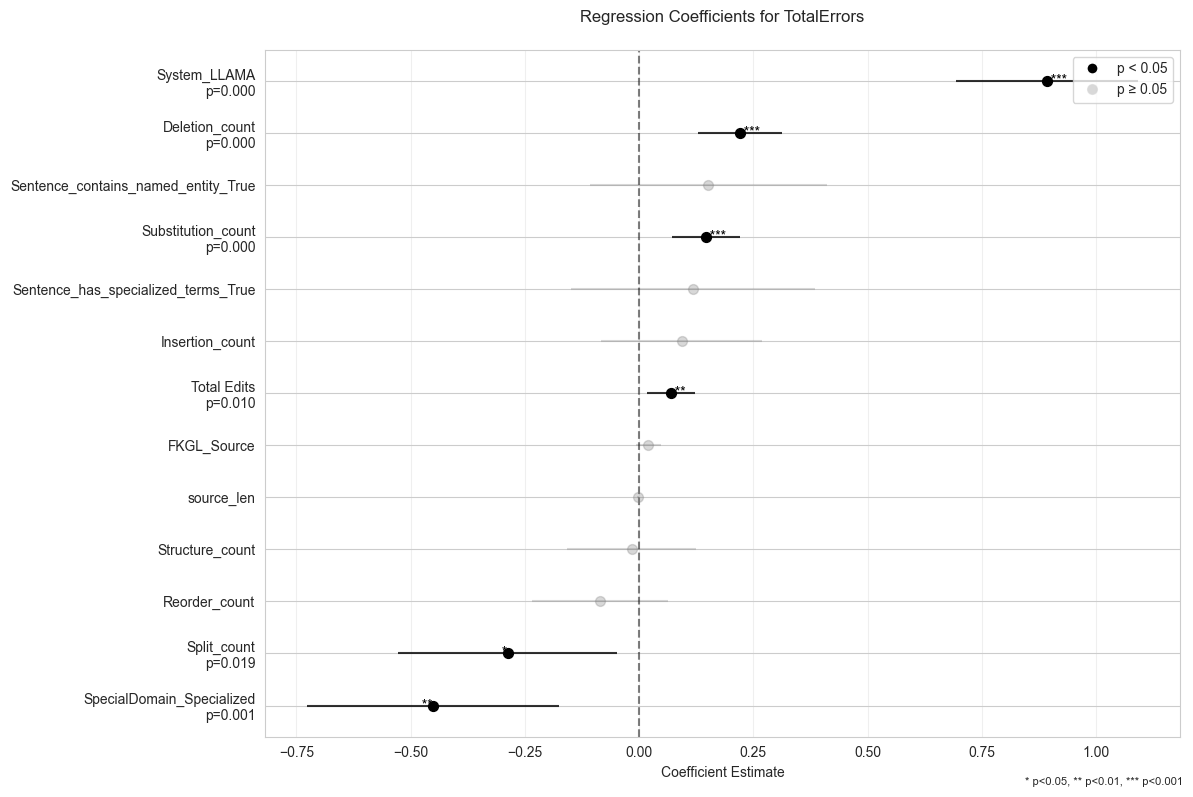

##################################################
Analysing regression for high
Rows removed due to NaN: 0
Final shape after cleaning: (400, 14)


/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.0290      0.073     -0.397      0.691      -0.172       0.114
FKGL_Source                             0.0050      0.005      0.952      0.341      -0.005       0.015
Insertion_count                         0.0657      0.035      1.903      0.057      -0.002       0.133
Deletion_count                          0.0282      0.016      1.813      0.070      -0.002       0.059
Substitution_count                      0.0091      0.012      0.765      0.444      -0.014       0.032
Reorder_count                           0.0063      0.024      0.263      0.792      -0.041       0.054
Split_count                            -0.0734      0.039     -1.902      0.057      -0.149       0.0

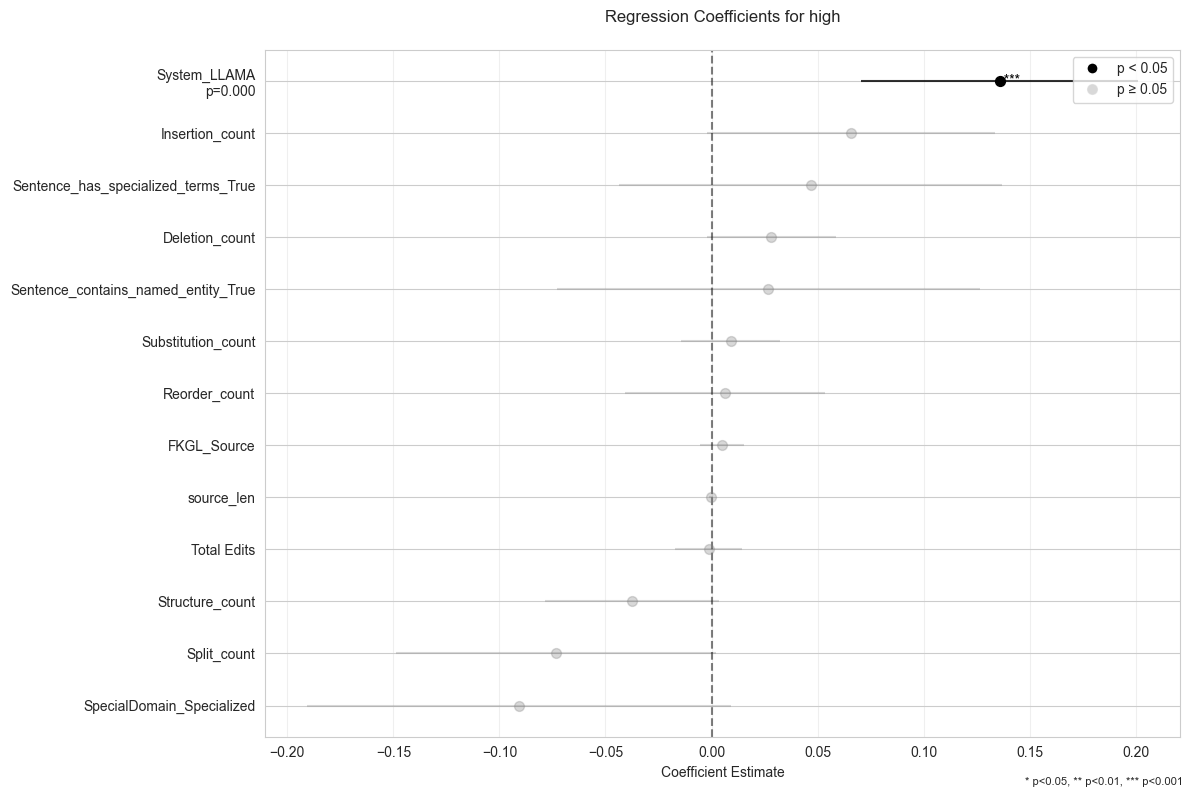

##################################################
Analysing regression for medium+high
Rows removed due to NaN: 0
Final shape after cleaning: (400, 14)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.1640      0.149     -1.100      0.271      -0.456       0.128
FKGL_Source                             0.0042      0.009      0.485      0.628      -0.013       0.021
Insertion_count                         0.1159      0.074      1.574      0.116      -0.028       0.260
Deletion_count                          0.0686      0.033      2.093      0.036       0.004       0.133
Substitution_count                      0.0453      0.026      1.731      0.083      -0.006       0.097
Reorder_count                           0.0072      

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


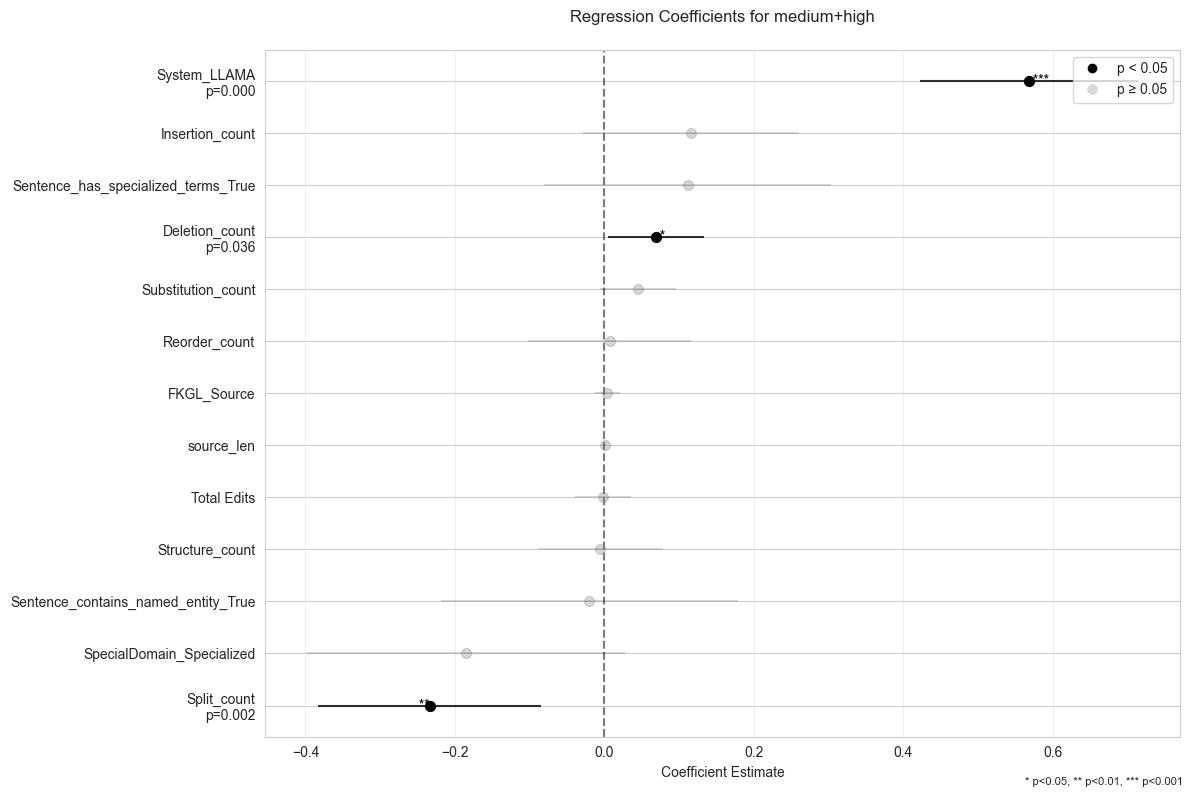

##################################################


In [436]:
# LLM ONLY

outcome_variables = [
    'TotalErrors',
    'high', # count of highest category of bad edits
    'medium+high'
]

categorical_predictors = [
    'Sentence_has_specialized_terms',
    'Sentence_contains_named_entity',
    'SpecialDomain',
    'Language',
    #'LLM_Flag',
    'System'
    
    # Controlling Variables:
    #'System', --> using LLM_Flag instead
]


# create copy of df_sentences where system in ChatGPT, LLAMA
df_sentences_temp = df_sentences[df_sentences['System'].isin(['ChatGPT', 'LLAMA'])].copy()
df_sentences_temp['medium+high'] = df_sentences_temp['medium'] + df_sentences_temp['high']



# Analyze given quality metric
for outcome_metric in outcome_variables:

    print(f"Analysing regression for {outcome_metric}")
    results = perform_regression_analysis(
        df_sentences_temp,
        outcome_metric,
        quality_predictors,
        categorical_predictors,
        # save_to_csv=True,
        #transform = 'log', # for violations of normality
        robustErrors=True # for violations of homoscedasticity
    )
    print("#" * 50)

Analysing regression for medium+high
Rows removed due to NaN: 0
Final shape after cleaning: (200, 13)
Model fitted successfully
Robust errors used!

Regression Results:
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0999      0.101      0.991      0.322      -0.098       0.298
FKGL_Source                             0.0106      0.005      2.118      0.034       0.001       0.020
Insertion_count                         0.1430      0.126      1.131      0.258      -0.105       0.391
Deletion_count                          0.0185      0.038      0.483      0.629      -0.057       0.094
Substitution_count                     -0.0411      0.019     -2.205      0.027      -0.078      -0.005
Reorder_count                           0.0339      0.051      0.667      0.505      -0.066       0.134

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 11
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


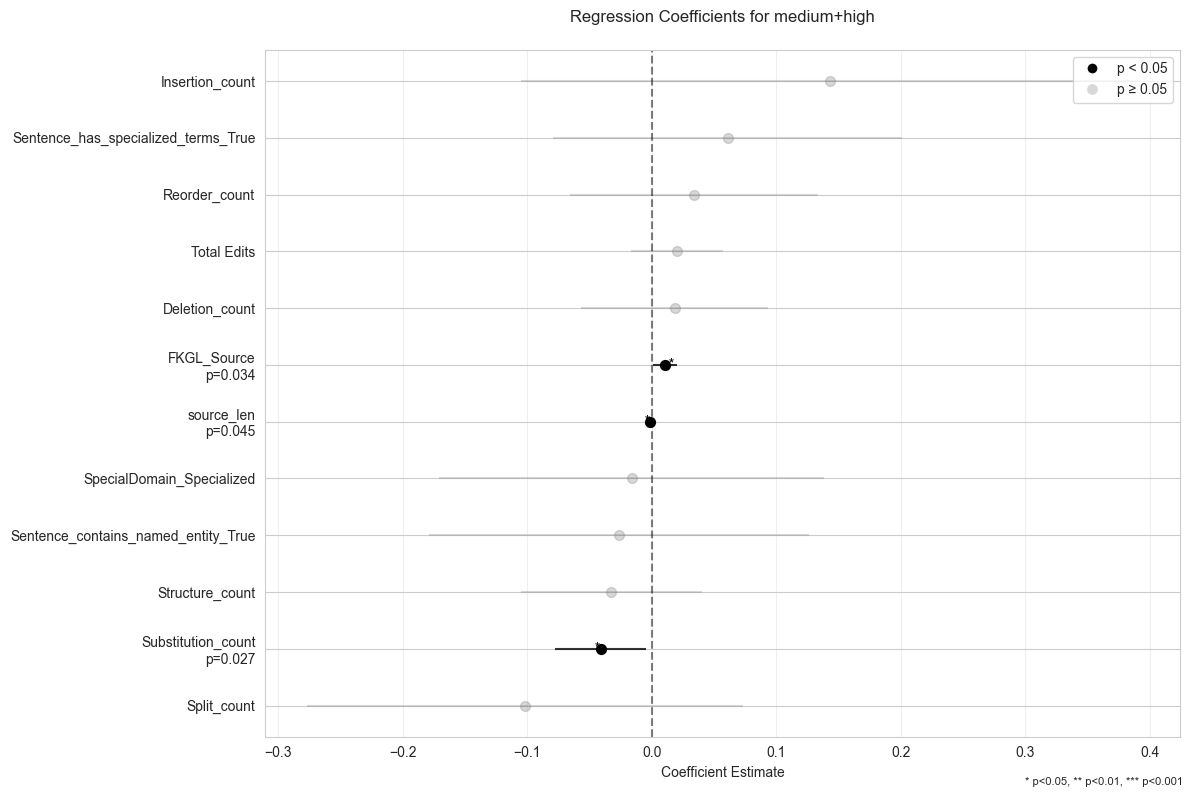

##################################################


In [437]:
# ChatGPT Only:
outcome_variables = [
    'medium+high'
]


df_sentences_temp = df_sentences[df_sentences['System'] == 'ChatGPT'].copy()
df_sentences_temp['medium+high'] = df_sentences_temp['medium'] + df_sentences_temp['high']

# Analyze given quality metric
for outcome_metric in outcome_variables:

    print(f"Analysing regression for {outcome_metric}")
    results = perform_regression_analysis(
        df_sentences_temp,
        outcome_metric,
        quality_predictors,
        categorical_predictors,
        #log_transform,
        robustErrors=True
    )
    print("#" * 50)

## Exploratory Clustering and RF Analysis for Taxonomy (RQ4)

### Clustering
#### Edit-Level

In [438]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

In [439]:
features = [
    'System', 
    #'Dataset', 
    'Family',
    'Edit Type', 
    'Edit Sub-Type', 
    'Edit Classification',
    'Structure Sub-Type', 
    'Quality', 
    'Information Impact', 
    'Grammar Error',
    'Significance', 
    'Is Constituent Edit', 
    'has_specialized_terms', 
    'contains_named_entity', 
    'Language', 
    'SpecialDomain'
    ]

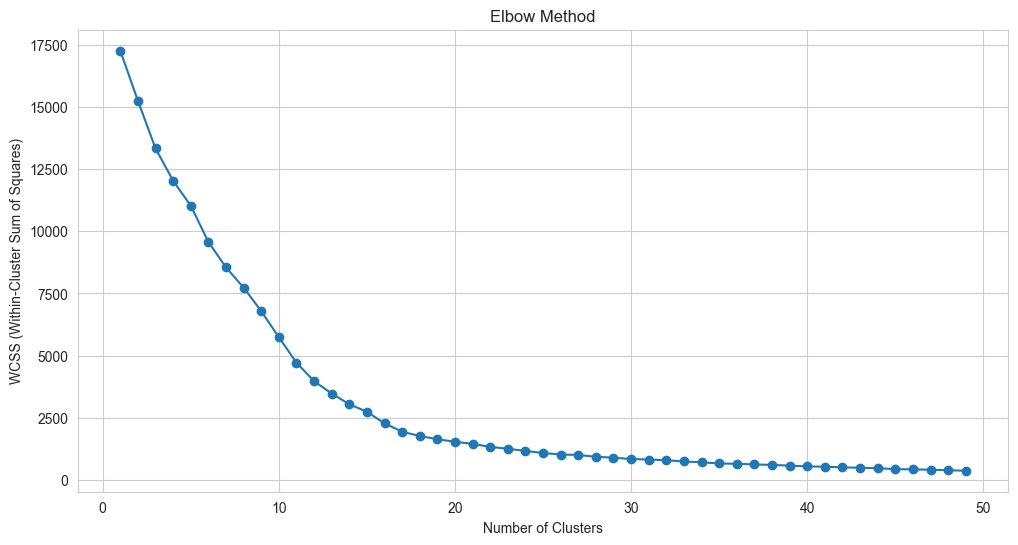

Silhouette Score: 0.3394709941671803


In [440]:

df_edits_baseline = df_edits.copy()

# focus on LLMs only (System in ChatGPT; LLAMA)
df_edits_baseline = df_edits_baseline[df_edits_baseline['System'].isin(['ChatGPT', 'LLAMA'])]


df_edits_baseline = df_edits_baseline[df_edits_baseline['Quality'] == 'Error']

X = df_edits_baseline[features].copy()

# in Edit Sub-Type, replace NaN with "None"
X['Edit Sub-Type'] = X['Edit Sub-Type'].fillna('None')
X['Structure Sub-Type'] = X['Structure Sub-Type'].fillna('None')

# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Data Cleaning
X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_tries = 50
final_number = 15

wcss = []
for i in range(1, n_tries):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, n_tries), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()

# Clustering Algorithm Selection
kmeans = KMeans(n_clusters=final_number, random_state=42)  # Adjust number of clusters based on evaluation
clusters = kmeans.fit_predict(X_scaled)
X['Cluster'] = clusters

df_edits_baseline['Cluster'] = clusters # for further analysis with more features

# Evaluate Clusters
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

In [441]:
# # Interpret Clusters
cluster_summary = X.groupby('Cluster').mean()

pd.options.display.float_format = '{:.2f}'.format
display(cluster_summary)

Significance  Is Constituent Edit  has_specialized_terms  \
Cluster                                                             
0                1.56                 0.00                   0.15   
1                2.04                 0.00                   0.35   
2                1.00                 0.00                   0.00   
3                1.17                 0.00                   0.00   
4                1.34                 0.00                   0.41   
5                1.27                 0.00                   0.46   
6                1.00                 0.00                   0.00   
7                1.40                 0.00                   0.00   
8                1.00                 0.00                   0.00   
9                1.00                 0.00                   0.00   
10               1.00                 0.00                   0.00   
11               2.00                 0.00                   0.09   
12               1.00                 0.00                   0.00   
13               1.00                 0.00                   0.00   
14               1.00                 0.00                   0.15   

         contains_named_entity  System_LLAMA  Family_Syntax  \
Cluster                                                       
0                         0.08          0.67           0.00   
1                         0.76          1.00           0.00   
2                         0.00          1.00           1.00   
3                         0.00          1.00           1.00   
4                         0.23          0.77           0.00   
5                         0.13          0.62           0.00   
6                         0.00          0.00           1.00   
7                         0.50          0.80           1.00   
8                         0.00          1.00           1.00   
9                         0.00          0.50           1.00   
10                        0.00          1.00           1.00   
11                        0.00          0.91           0.00   
12                        0.00          0.00           0.00   
13                        0.00          1.00           1.00   
14                        0.05          0.80           0.00   

         Edit Type_insertion  Edit Type_reorder  Edit Type_split  \
Cluster                                                            
0                       0.00               0.00             0.00   
1                       0.00               0.00             0.00   
2                       0.00               0.00             0.00   
3                       0.00               0.00             0.00   
4                       0.00               0.00             0.00   
5                       0.00               0.00             0.00   
6                       0.00               0.00             0.00   
7                       0.00               1.00             0.00   
8                       0.00               0.00             0.00   
9                       0.00               0.00             1.00   
10                      0.00               0.00             0.00   
11                      1.00               0.00             0.00   
12                      1.00               0.00             0.00   
13                      0.00               0.00             0.00   
14                      0.00               0.00             0.00   

         Edit Type_structure  ...  Structure Sub-Type_Grammatical Number  \
Cluster                       ...                                          
0                       0.00  ...                                   0.00   
1                       0.00  ...                                   0.00   
2                       1.00  ...                                   0.00   
3                       1.00  ...                                   0.00   
4                       0.00  ...                                   0.00   
5                       0.00  ...                                   0.00  

In [442]:
cols_X = X.columns.tolist()
cols_X.remove('Cluster')

print(cols_X)
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cols_X)
# DROP PCA1 and PCA2
#cluster_centers = cluster_centers.drop(columns=['PCA1', 'PCA2'])
cluster_centers['Cluster'] = range(final_number)
cluster_centers

['Significance', 'Is Constituent Edit', 'has_specialized_terms', 'contains_named_entity', 'System_LLAMA', 'Family_Syntax', 'Edit Type_insertion', 'Edit Type_reorder', 'Edit Type_split', 'Edit Type_structure', 'Edit Type_substitution', 'Edit Sub-Type_Bad Deletion', 'Edit Sub-Type_Bad Split', 'Edit Sub-Type_Clausal Structure', 'Edit Sub-Type_Complex Wrong', 'Edit Sub-Type_Contradiction', 'Edit Sub-Type_Factual Error', 'Edit Sub-Type_Grammatical Number', 'Edit Sub-Type_Information Rewrite', 'Edit Sub-Type_Part of Speech', 'Edit Sub-Type_Repetition', 'Edit Sub-Type_Tense', 'Edit Sub-Type_Unknown Structure Change', 'Edit Sub-Type_Voice', 'Edit Classification_Bad Insertion', 'Edit Classification_Bad Reorder', 'Edit Classification_Bad Split', 'Edit Classification_Bad Structure', 'Edit Classification_Bad Substitution', 'Structure Sub-Type_Grammatical Number', 'Structure Sub-Type_None', 'Structure Sub-Type_Part of Speech', 'Structure Sub-Type_Tense', 'Structure Sub-Type_Unknown Structure Change

Significance  Is Constituent Edit  has_specialized_terms  \
0           1.56                 0.00                   0.15   
1           2.04                 0.00                   0.35   
2           1.00                 0.00                   0.00   
3           1.17                 0.00                   0.00   
4           1.34                 0.00                   0.41   
5           1.27                 0.00                   0.46   
6           1.00                 0.00                   0.00   
7           1.40                 0.00                   0.00   
8           1.00                 0.00                   0.00   
9           1.00                 0.00                   0.00   
10          1.00                 0.00                   0.00   
11          2.00                 0.00                   0.09   
12          1.00                 0.00                   0.00   
13          1.00                 0.00                   0.00   
14          1.00                 0.00                   0.15   

    contains_named_entity  System_LLAMA  Family_Syntax  Edit Type_insertion  \
0                    0.08          0.67          -0.00                 0.00   
1                    0.76          1.00          -0.00                 0.00   
2                    0.00          1.00           1.00                -0.00   
3                    0.00          1.00           1.00                -0.00   
4                    0.23          0.77           0.00                 0.00   
5                    0.13          0.62           0.00                 0.00   
6                    0.00          0.00           1.00                -0.00   
7                    0.50          0.80           1.00                -0.00   
8                    0.00          1.00           1.00                -0.00   
9                    0.00          0.50           1.00                -0.00   
10                   0.00          1.00           1.00                -0.00   
11                   0.00          0.91          -0.00                 1.00   
12                   0.00          0.00           0.00                 1.00   
13                   0.00          1.00           1.00                -0.00   
14                   0.05          0.80          -0.00                -0.00   

    Edit Type_reorder  Edit Type_split  Edit Type_structure  ...  \
0                0.00             0.00                -0.00  ...   
1                0.00             0.00                -0.00  ...   
2                0.00             0.00                 1.00  ...   
3                0.00             0.00                 1.00  ...   
4                0.00             0.00                -0.00  ...   
5                0.00             0.00                -0.00  ...   
6                0.00             0.00                 1.00  ...   
7                1.00             0.00                -0.00  ...   
8                0.00             0.00                 1.00  ...   
9                0.00             1.00                 0.00  ...   
10               0.00             0.00                 1.00  ...   
11               0.00             0.00                 0.00  ...   
12               0.00             0.00                 0.00  ...   
13               0.00             0.00                 1.00  ...   
14              -0.00            -0.00                -0.00  ...   

    Structure Sub-Type_None  Structure Sub-Type_Part of Speech  \
0                      1.00                              -0.00   
1                      1.00                               0.00   
2                      0.00                               0.00   
3                      0.00                               0.00   
4                      1.00                               0.00   
5                      1.00                               0.00   
6                      0.00                               1.00   
7                      1.00                               0.00   
8                      0.00    

In [443]:
print(cluster_centers)

    Significance  Is Constituent Edit  has_specialized_terms  \
0           1.56                 0.00                   0.15   
1           2.04                 0.00                   0.35   
2           1.00                 0.00                   0.00   
3           1.17                 0.00                   0.00   
4           1.34                 0.00                   0.41   
5           1.27                 0.00                   0.46   
6           1.00                 0.00                   0.00   
7           1.40                 0.00                   0.00   
8           1.00                 0.00                   0.00   
9           1.00                 0.00                   0.00   
10          1.00                 0.00                   0.00   
11          2.00                 0.00                   0.09   
12          1.00                 0.00                   0.00   
13          1.00                 0.00                   0.00   
14          1.00                 0.00   

/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


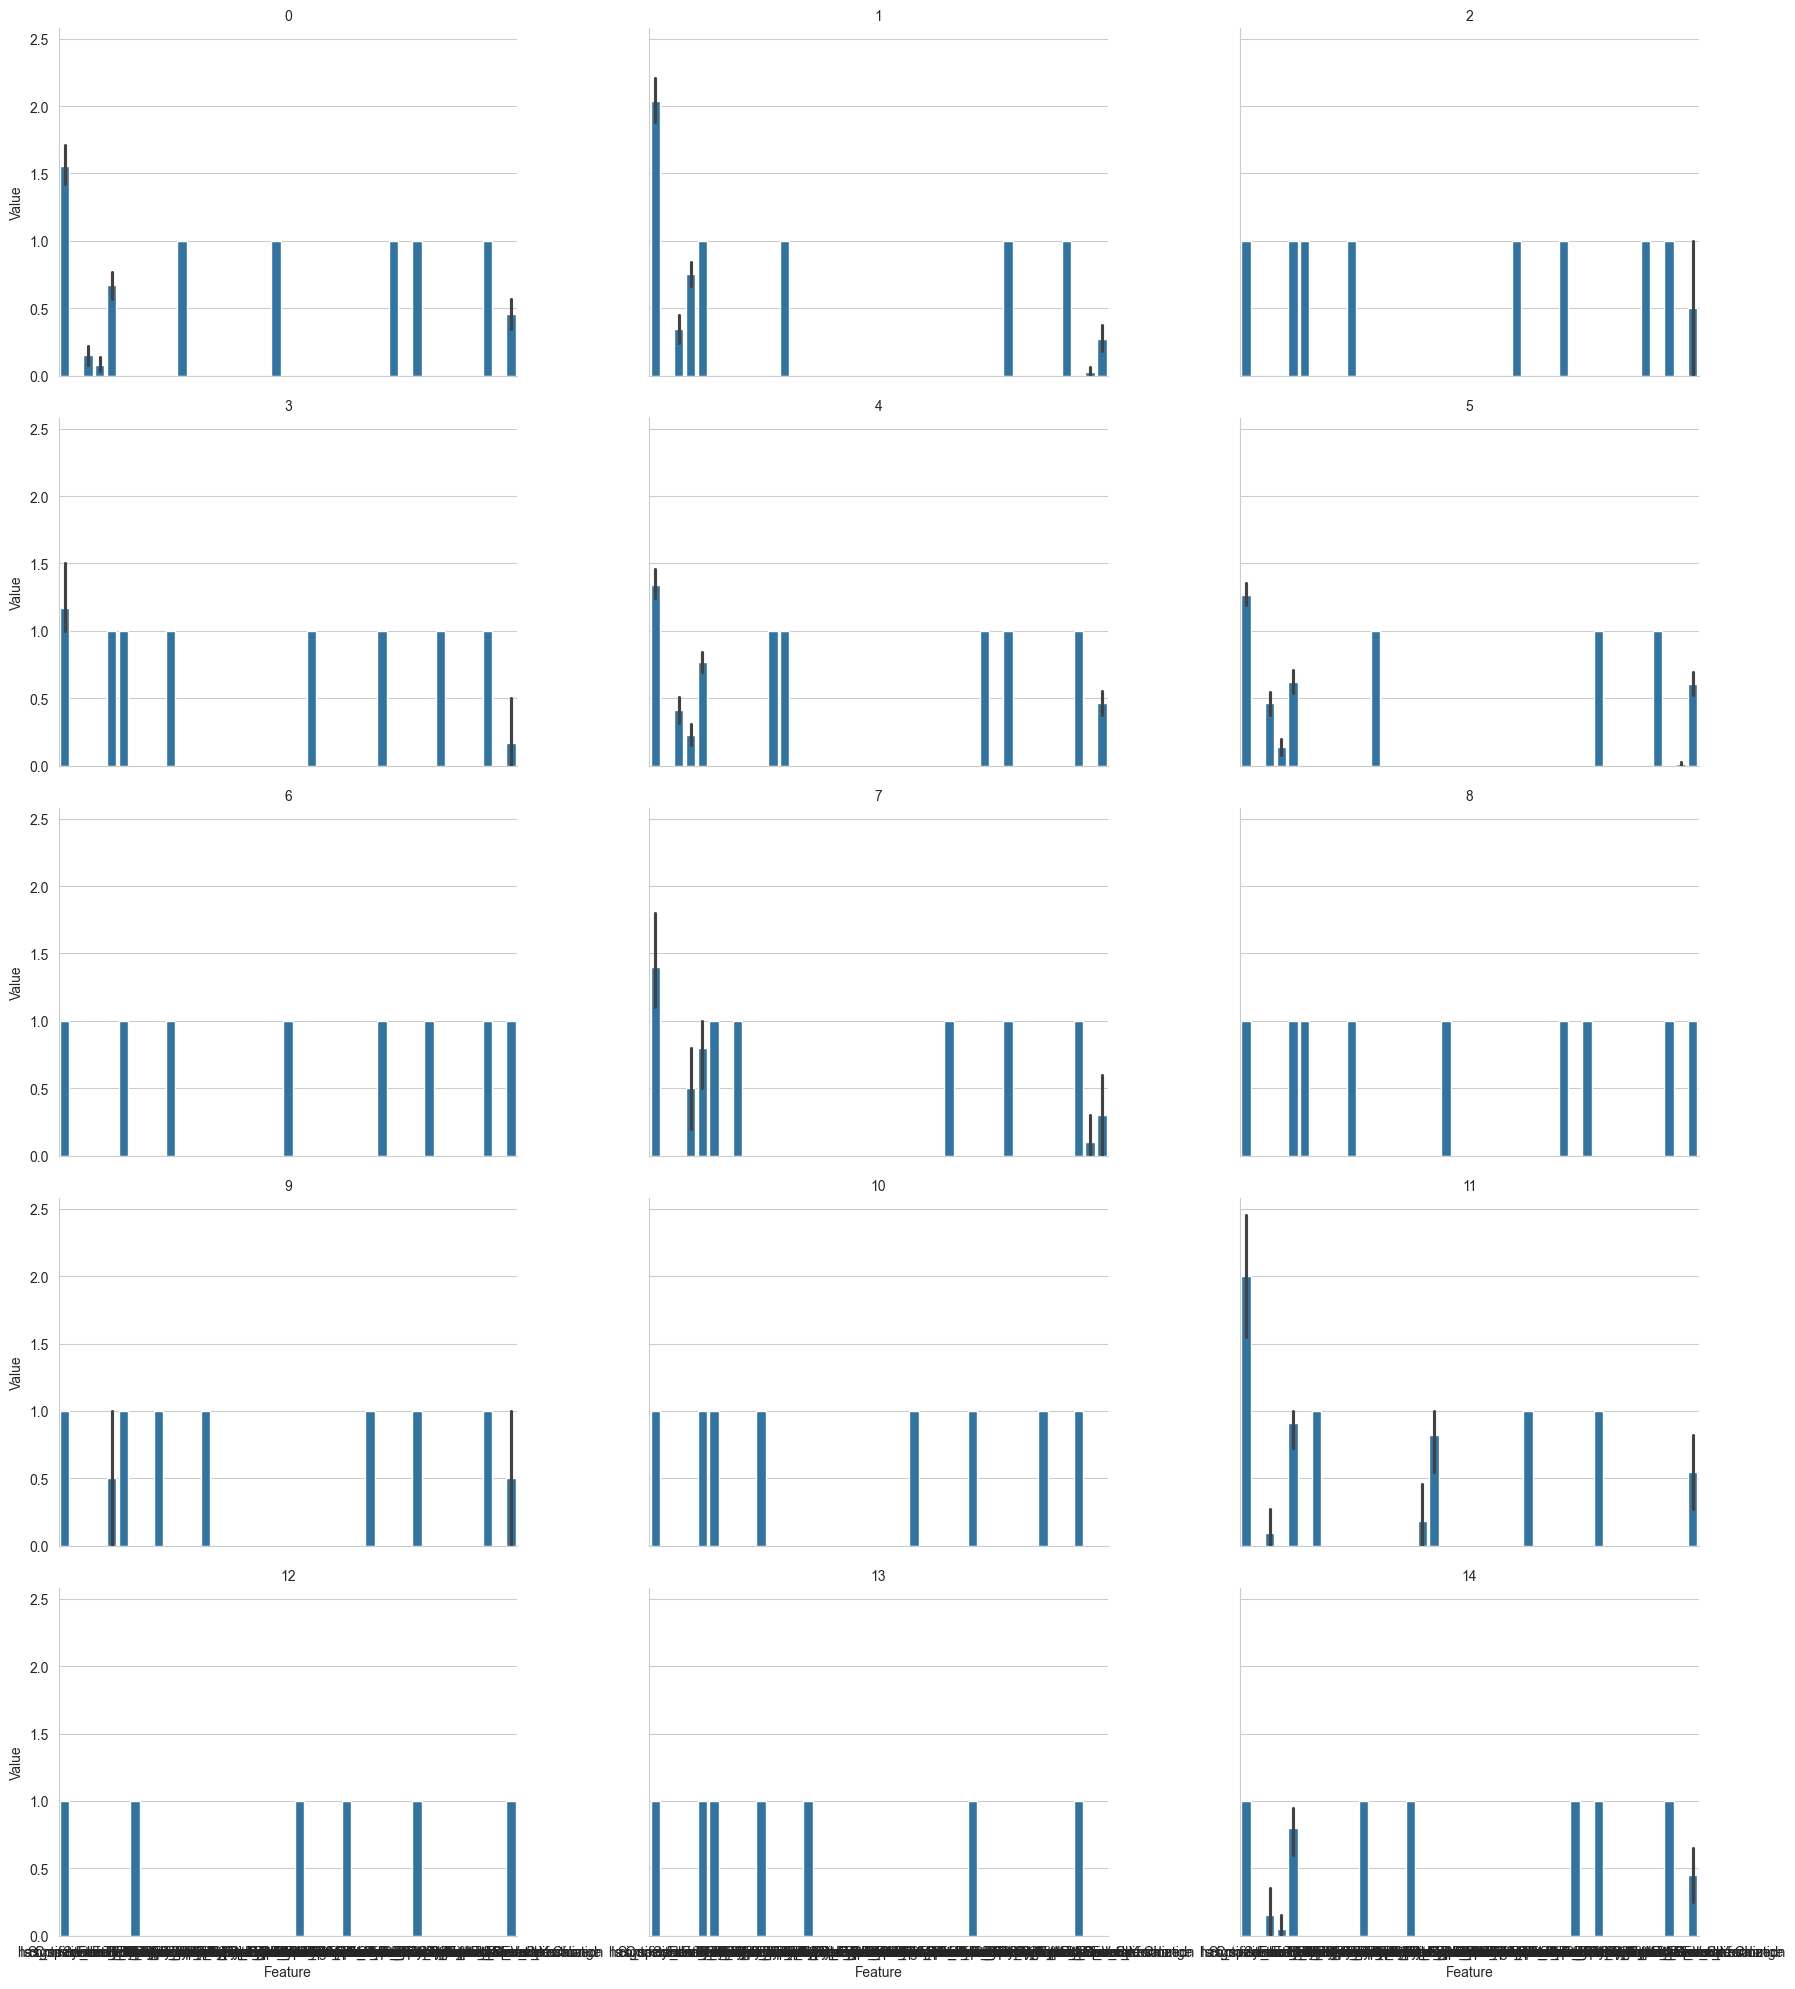

In [444]:
# Flipped - Cluster-focus
melted_X = X.melt(id_vars=["Cluster"], value_vars=cluster_centers.columns, var_name="Feature", value_name="Value")

g = sns.FacetGrid(melted_X, col="Cluster", col_wrap=3, height=4, aspect=1.5)
g.map(sns.barplot, "Feature", "Value")

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Feature", "Value")
plt.show()

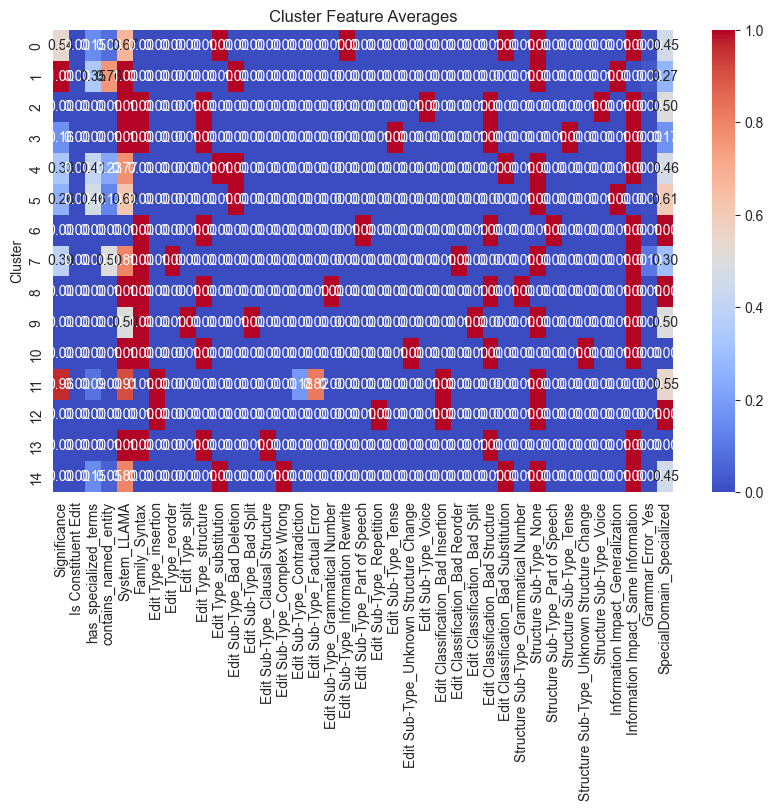

In [445]:
import seaborn as sns

# normalize Significance column to be between 0 and 1
cluster_summary2 = cluster_summary.copy()
cluster_summary2['Significance'] = (cluster_summary2['Significance'] - cluster_summary2['Significance'].min()) / (cluster_summary2['Significance'].max() - cluster_summary2['Significance'].min())

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster Feature Averages")
plt.show()

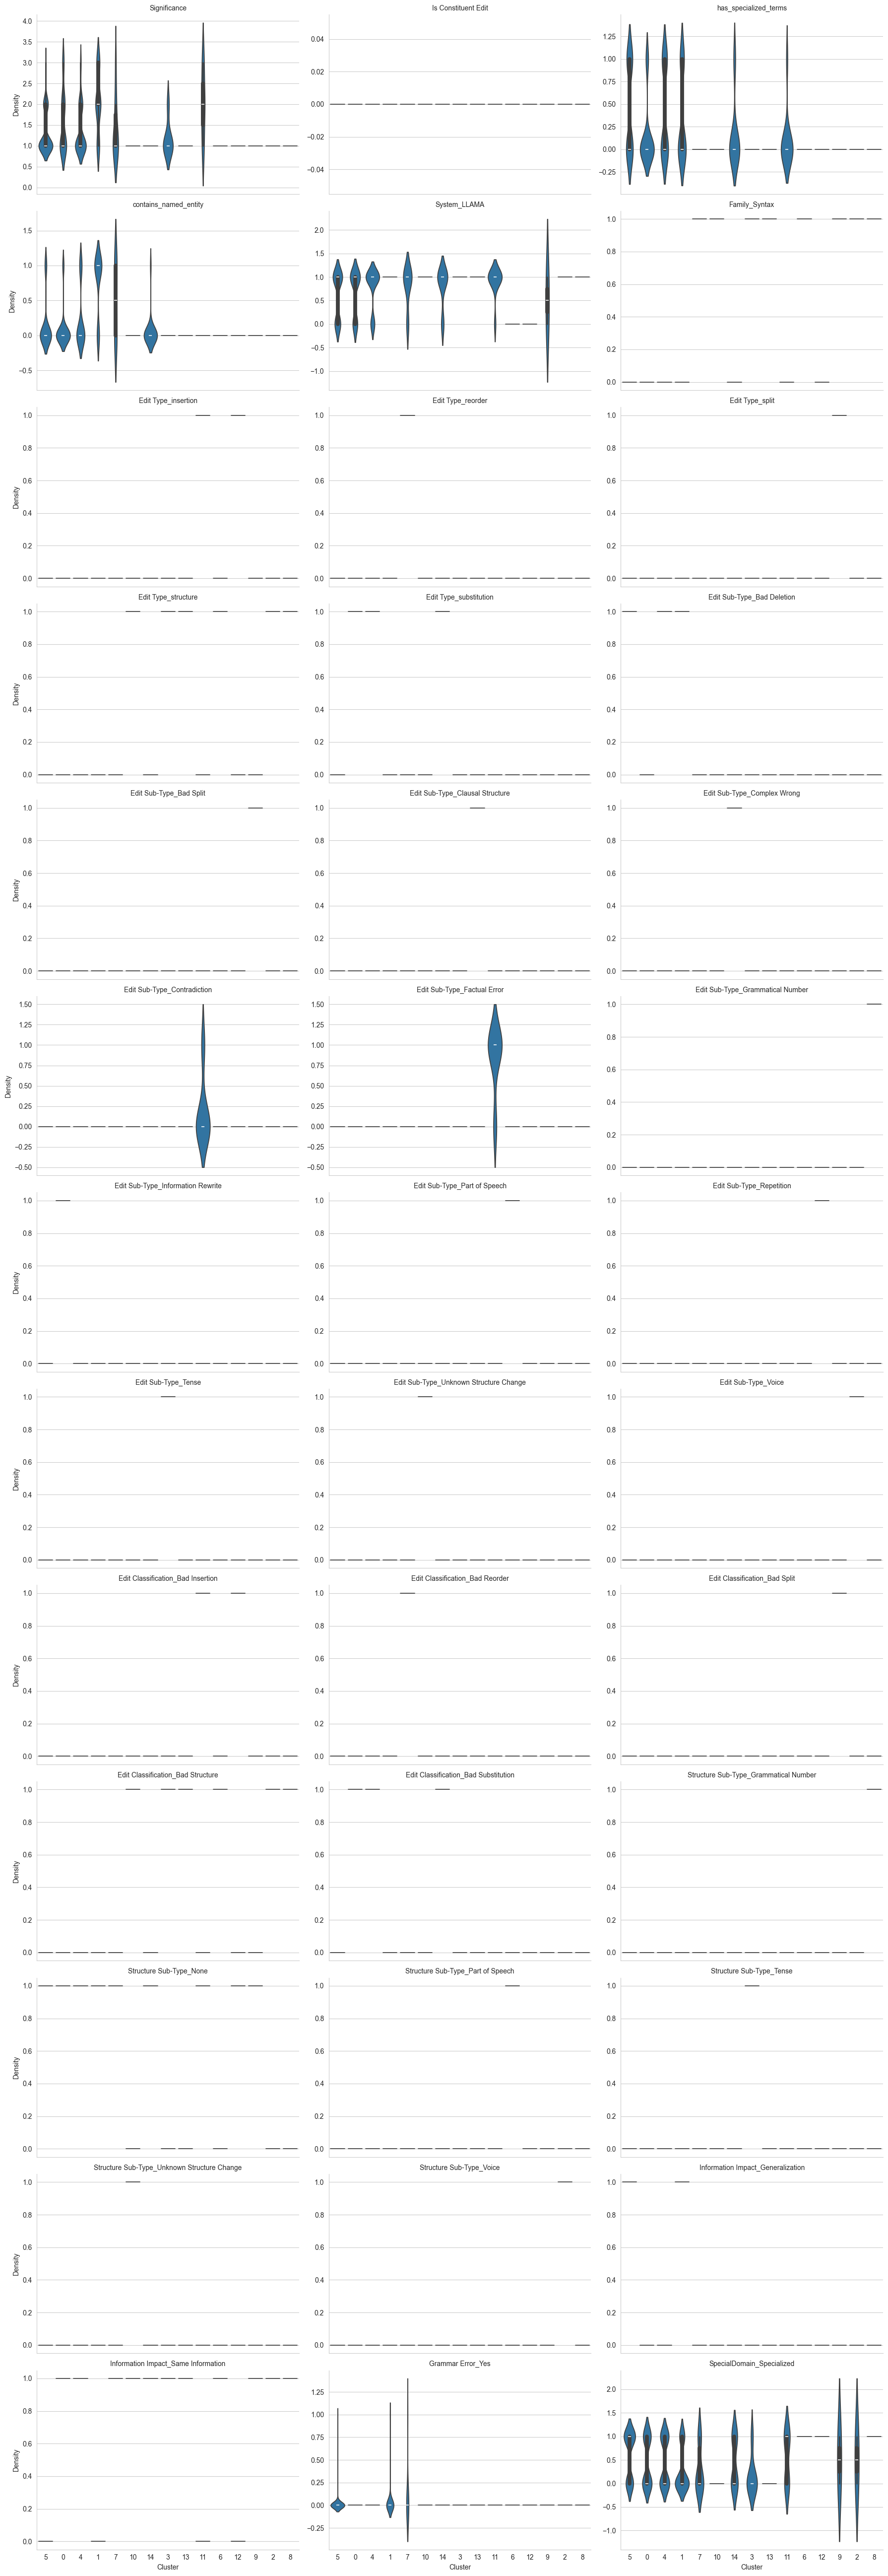

In [446]:
# 3. Violin Plots (Feature Density per Cluster) - Facet Grid
g = sns.FacetGrid(melted_X, col="Feature", col_wrap=3, height=4, aspect=1.5, sharey=False)
g.map(sns.violinplot, "Cluster", "Value", order=melted_X["Cluster"].unique())

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Cluster", "Density")
plt.show()

In [447]:
import pandas as pd
import numpy as np

def characterize_clusters(data, cluster_col, feature_cols, top_n=5):
    """
    Automatically characterize clusters by identifying the top features
    that deviate the most from the overall averages.
    
    Parameters:
    - data: pandas DataFrame containing the data.
    - cluster_col: str, name of the column that contains cluster labels.
    - feature_cols: list of str, names of the columns (features) to consider.
    - top_n: int, number of top features to return per cluster.
    
    Returns:
    - A dictionary where keys are cluster labels and values are DataFrames
      listing the top features and their statistics (mean, overall mean, z-score, etc.).
    """
    
    # Convert cluster labels to string for consistency
    data[cluster_col] = data[cluster_col].astype(str)
    
    # Convert feature columns to numeric (non-numeric values will become NaN)
    for col in feature_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Compute overall mean and standard deviation for each feature
    overall_means = data[feature_cols].mean()
    overall_stds = data[feature_cols].std()
    
    # Group by cluster and compute the mean for each feature in each cluster
    cluster_means = data.groupby(cluster_col)[feature_cols].mean()
    
    # Compute the z-scores for each cluster and feature
    # z = (cluster mean - overall mean) / overall std dev
    z_scores = (cluster_means - overall_means) / overall_stds
    
    # Dictionary to hold top features for each cluster
    cluster_characterization = {}
    
    for cluster in cluster_means.index:
        # Get the z-scores for the current cluster
        z_vals = z_scores.loc[cluster]
        # Rank features by the absolute z-score in descending order
        ranked_features = z_vals.abs().sort_values(ascending=False)
        top_features = ranked_features.head(top_n).index.tolist()
        
        # Create a DataFrame summarizing the stats for these top features
        summary = pd.DataFrame({
            'Cluster Mean': cluster_means.loc[cluster, top_features],
            'Overall Mean': overall_means[top_features],
            #'Std Dev': overall_stds[top_features],
            'Z-Score': z_vals[top_features]
        })
        
        cluster_characterization[cluster] = summary
    
    return cluster_characterization


feature_columns = list(cluster_centers.columns)
# remove "cluster" from the list of features
feature_columns.remove('Cluster')

characterizations = characterize_clusters(X, 'Cluster', feature_columns, top_n=5)

# Print the characterization for each cluster:
for cluster, summary_df in characterizations.items():
    print(f"\nCluster {cluster} top features:")
    print(summary_df)


Cluster 0 top features:
                                      Cluster Mean  Overall Mean  Z-Score
Edit Sub-Type_Information Rewrite             1.00          0.19     2.07
Edit Sub-Type_Bad Deletion                    0.00          0.69    -1.47
Edit Type_substitution                        1.00          0.48     1.03
Edit Classification_Bad Substitution          1.00          0.48     1.03
Information Impact_Same Information           1.00          0.54     0.92

Cluster 1 top features:
                                      Cluster Mean  Overall Mean  Z-Score
contains_named_entity                         0.76          0.25     1.16
Information Impact_Generalization             1.00          0.43     1.14
Information Impact_Same Information           0.00          0.54    -1.08
Edit Type_substitution                        0.00          0.48    -0.97
Edit Classification_Bad Substitution          0.00          0.48    -0.97

Cluster 10 top features:
                                    

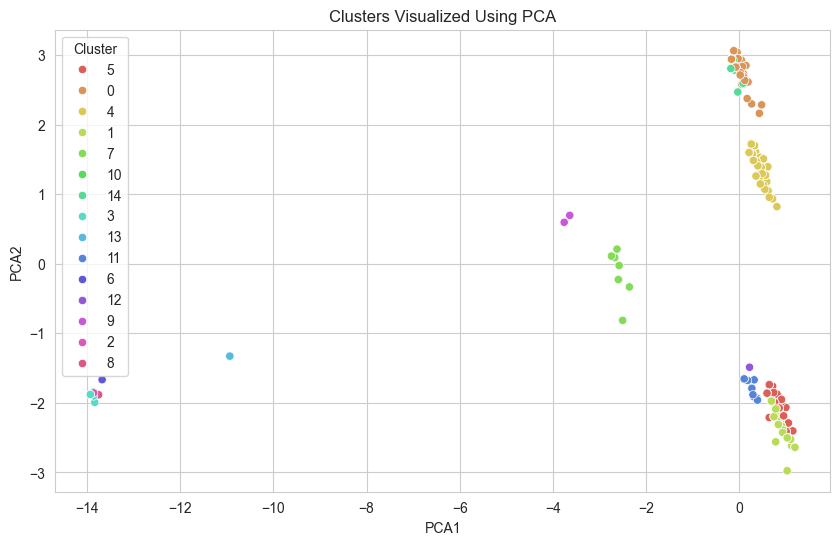

In [448]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['PCA1'], X['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x='PCA1', y='PCA2', hue=X['Cluster'], 
    legend='full', 
    palette=sns.color_palette("hls", final_number)
    )
plt.title("Clusters Visualized Using PCA")
plt.show()

#### Sentence Level

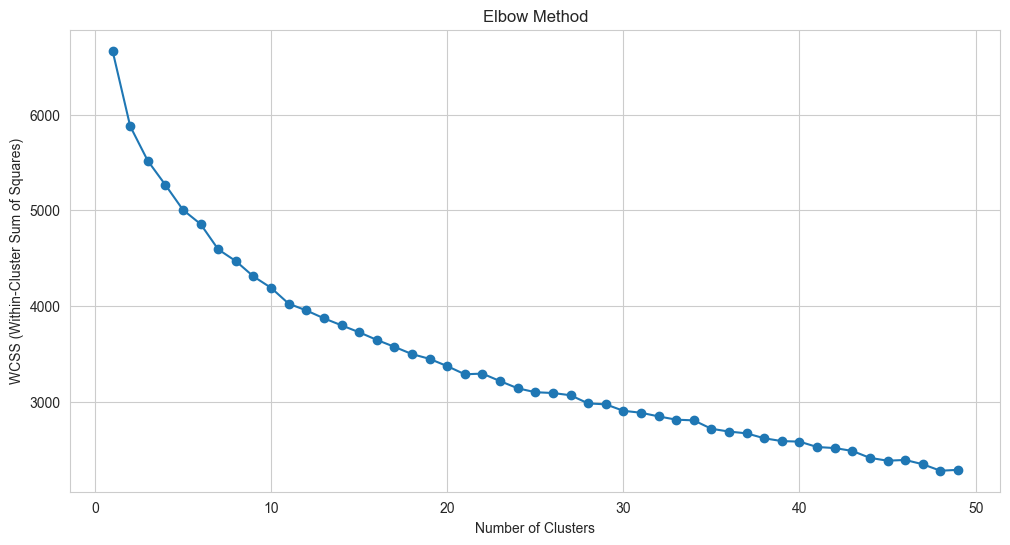

Silhouette Score: 0.07488182583510523


In [449]:
features = [
    'System', 
    #'Dataset', 
    'Total Edits',
    'Substitution_count', 
    'Insertion_count', 
    'Split_count',
    'Structure_count', 
    'Deletion_count', 
    'Reorder_count', 
    'FKGL_Source', 
    #'FKGL_Target', 
    'FKGL_Difference', 
    #'ARI_Source', 'ARI_Target', 
    'ARI_Difference', 
    #'Lexical_Diversity_Source', 'Lexical_Diversity_Target', 
    'Lexical_Diversity_Difference',
    #'Syntactic_Complexity_Source', 'Syntactic_Complexity_Target', 'Syntactic_Complexity_Difference', 
    #'BERTScore_Precision',
    #'BERTScore_Recall', 
    # 'BERTScore_F1', 
    # 'GLEU', 
    #'LENS_SALSA',
    #'No_edit_count',
    'Sentence_has_specialized_terms',
    'Sentence_contains_named_entity', 
    'Deletion (Bad)', 'Insertion (Bad)',
    'Reorder (Bad)', 'Split (Bad)', 
    'Structure (Bad)', 'Substitution (Bad)',
    # 'Deletion (Good)', 'Insertion (Good)', 
    # 'Reorder (Good)', 'Split (Good)',
    # 'Structure (Good)', 'Substitution (Good)', 'Deletion (Neutral)',
    # 'Insertion (Neutral)', 'Reorder (Neutral)', 'Split (Neutral)',
    # 'Structure (Neutral)', 'Substitution (Neutral)', 
    #'Sentence ID NUM', 'Sentence ID MIX', 
    'Language', 'LLM_Flag', 'SpecialDomain',
    'source_len', 'target_len', 
    'low', 'medium', 'high', 
    'TotalErrors'
]

df_sentences_baseline = df_sentences.copy()

# focus on LLMs only (System in ChatGPT; LLAMA)
df_sentences_baseline = df_sentences_baseline[df_sentences_baseline['System'].isin(['ChatGPT', 'LLAMA'])]

# only look at errors (TotalErrors > 0)
df_sentences_baseline = df_sentences_baseline[df_sentences_baseline['TotalErrors'] > 0]

X = df_sentences_baseline[features].copy()

# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Data Cleaning
X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_tries = 50
final_number = 20

wcss = []
for i in range(1, n_tries):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, n_tries), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()

# Clustering Algorithm Selection
kmeans = KMeans(n_clusters=final_number, random_state=42)  # Adjust number of clusters based on evaluation
clusters = kmeans.fit_predict(X_scaled)
#X_scaled['Cluster'] = clusters
X['Cluster'] = clusters

df_sentences_baseline['Cluster'] = clusters # for further analysis with more features

# Evaluate Clusters
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

In [450]:
cols_X = X.columns.tolist()
cols_X.remove('Cluster')

cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cols_X)
# DROP PCA1 and PCA2
#cluster_centers = cluster_centers.drop(columns=['PCA1', 'PCA2'])
cluster_centers['Cluster'] = range(final_number)
cluster_centers

Total Edits  Substitution_count  Insertion_count  Split_count  \
0          4.22                1.89             0.33        -0.00   
1          6.83                1.67             0.33        -0.00   
2          6.40                3.20             0.16         0.32   
3          5.89                3.53             0.16         0.00   
4          9.33                3.28             0.94         0.89   
5         10.20                2.80             0.40        -0.00   
6         15.00                4.00             4.00         1.00   
7          9.00                2.00             1.25         0.50   
8          3.43                1.67             0.10         0.13   
9          8.93                3.29             1.93         0.29   
10         6.40                3.30             0.70         0.20   
11         4.26                1.32             0.21         0.05   
12         7.43                3.14             0.86         1.00   
13         5.44                3.11             0.44        -0.00   
14         9.67                4.83             1.33         0.17   
15         6.54                3.15             0.46        -0.00   
16         3.94                2.69             0.19        -0.00   
17        10.70                4.30             1.00         0.70   
18         5.50                2.83             0.67        -0.00   
19        17.00                6.00             5.00         3.00   

    Structure_count  Deletion_count  Reorder_count  FKGL_Source  \
0              0.33            1.33           0.33        10.67   
1              1.50            3.00           0.33        14.46   
2              0.68            1.80           0.24        16.95   
3              0.34            1.71           0.16        14.98   
4              1.11            2.67           0.44        17.04   
5              0.20            6.20           0.60        39.28   
6              1.00            5.00           0.00        31.87   
7              0.50            3.75           1.00        10.50   
8              0.47            0.83           0.23         8.82   
9              0.57            2.00           0.86        12.48   
10             0.30            1.60           0.30        14.99   
11             1.00            1.26           0.42        10.60   
12             1.14            1.29           0.00        18.20   
13             0.11            1.22           0.56        11.83   
14             0.33            2.83           0.17        23.62   
15             0.23            2.23           0.46        16.62   
16             0.37            0.62           0.06        12.00   
17             0.40            3.50           0.80        19.83   
18             0.50            1.50           0.00         6.76   
19             0.00            2.00           1.00        20.74   

    FKGL_Difference  ARI_Difference  ...  LLM_Flag  source_len  target_len  \
0             -4.98           -4.99  ...      1.00      133.67       91.89   
1             -5.92           -8.12  ...      1.00      190.33      101.17   
2             -7.60           -6.66  ...      1.00      202.60      146.04   
3             -5.32           -5.03  ...      1.00      202.11      119.24   
4            -12.40          -13.49  ...      1.00      226.56      141.22   
5            -24.76           11.58  ...      1.00      483.20      169.20   
6            -23.11            3.10  ...      1.00      424.00      236.00   
7             -4.26           -6.93  ...      1.00      187.00      121.25   
8             -2.08           -1.33  ...      1.00      124.43      103.13   
9             -3.63           -4.56  ...      1.00      167.50      132.86   
10            -6.83           -8.05  ...      1.00      168.70      100.60   
11            -3.52           -3.10  ...      1.00      123.16       86.05   
12            -9.67          -12.17  ...      1.00      244.29      199.14   
13            -3.10           -3.50  ...      1.00    

In [451]:
feature_columns = list(cluster_centers.columns)
# remove "cluster" from the list of features
feature_columns.remove('Cluster')

characterizations = characterize_clusters(X, 'Cluster', feature_columns, top_n=5)

# Print the characterization for each cluster:
for cluster, summary_df in characterizations.items():
    print(f"\nCluster {cluster} top features:")
    print(summary_df)


Cluster 0 top features:
                    Cluster Mean  Overall Mean  Z-Score
Reorder (Bad)               1.33          0.13     3.24
Total Edits                 4.22          6.36    -0.74
Substitution (Bad)          1.67          2.83    -0.65
source_len                133.67        185.77    -0.62
target_len                 91.89        121.03    -0.62

Cluster 1 top features:
                 Cluster Mean  Overall Mean  Z-Score
Structure (Bad)          1.00          0.17     2.01
high                     0.83          0.17     1.57
TotalErrors              3.33          1.84     1.37
Structure_count          1.50          0.55     1.35
low                      2.00          1.14     0.97

Cluster 10 top features:
                                Cluster Mean  Overall Mean  Z-Score
Insertion (Bad)                         1.60          0.16     3.21
Substitution (Bad)                      5.00          2.83     1.22
System_LLAMA                            1.00          0.67     0.7

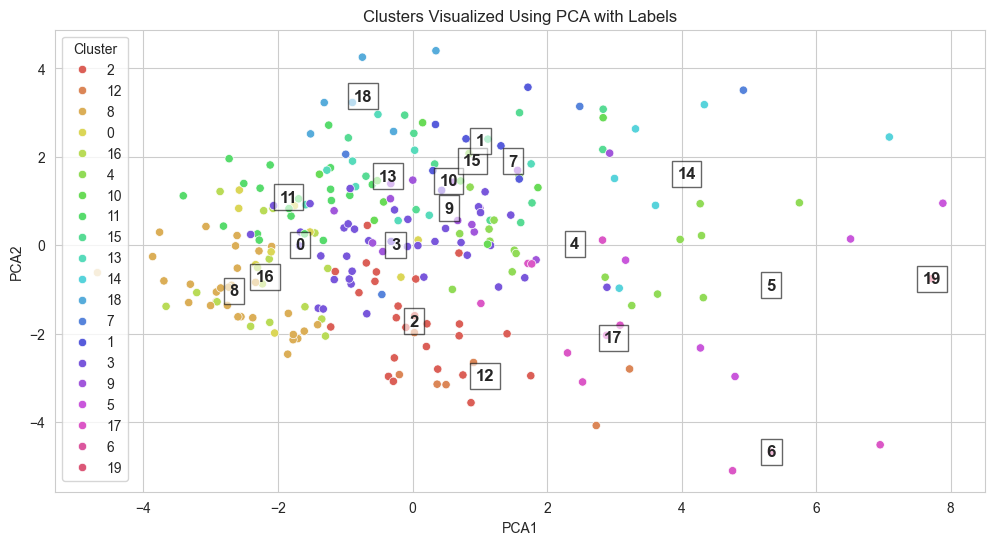

In [452]:
# Scatterplot with clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['PCA1'], X['PCA2'] = X_pca[:, 0], X_pca[:, 1]

sns.scatterplot(
    data=X, 
    x='PCA1', 
    y='PCA2', 
    hue=X['Cluster'], 
    legend='full', 
    palette=sns.color_palette("hls", final_number)
)

# Add cluster labels at the centroid of each cluster
for cluster in X['Cluster'].unique():
    cluster_data = X[X['Cluster'] == cluster]
    centroid_x = cluster_data['PCA1'].mean()
    centroid_y = cluster_data['PCA2'].mean()
    
    # Add label slightly offset to avoid overlap with the point
    plt.text(centroid_x, centroid_y, str(cluster), 
             fontsize=12, weight='bold', 
             ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.title("Clusters Visualized Using PCA with Labels")
plt.show()

#### Edit-Level with sentence-context

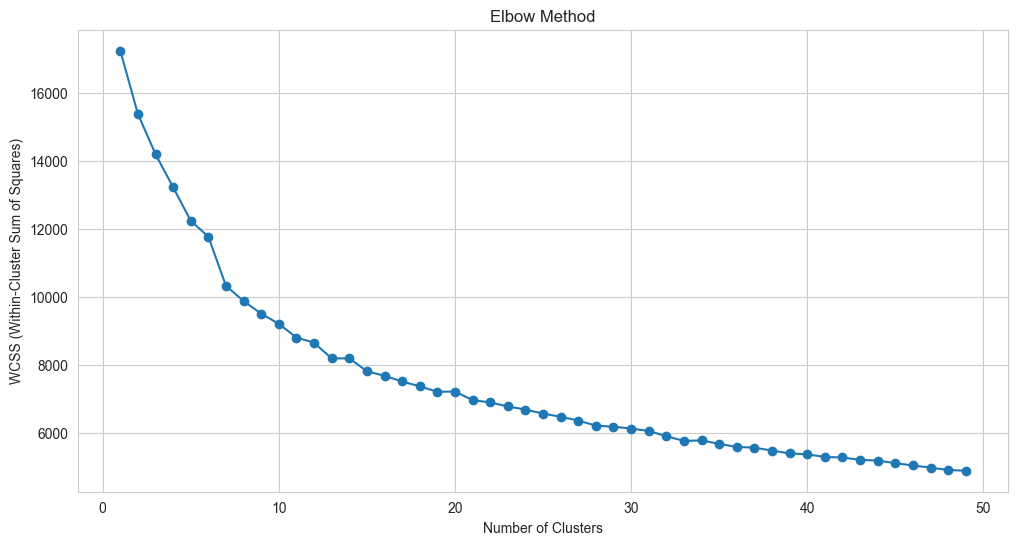

Silhouette Score: 0.1008870131237703


In [453]:
cols_to_add = [
    'Total Edits',
    'Substitution_count', 
    'Insertion_count', 
    'Split_count',
    'Structure_count', 
    'Deletion_count', 
    'Reorder_count', 

   'FKGL_Source', 
    'FKGL_Target', 
    'FKGL_Difference', 
    'ARI_Source', 'ARI_Target', 
    'ARI_Difference', 
    'Lexical_Diversity_Source', 'Lexical_Diversity_Target', 
    'Lexical_Diversity_Difference',
    'Syntactic_Complexity_Source', 'Syntactic_Complexity_Target', 
    'Syntactic_Complexity_Difference', 

    'Sentence_has_specialized_terms',
    'Sentence_contains_named_entity', 
    'source_len', 'target_len', 
    'low', 'medium', 'high', 
    'TotalErrors',
    'Sentence ID MIX'
]

df_edits_enhanced = df_edits.copy()

# merge with cols from df_sentences
df_edits_enhanced = df_edits_enhanced.merge(df_sentences[cols_to_add], on='Sentence ID MIX', how='left')


df_edits_enhanced_baseline = df_edits_enhanced.copy()

# only look at errors
df_edits_enhanced_baseline = df_edits_enhanced_baseline[df_edits_enhanced_baseline['Quality'] == 'Error']

features = df_edits_enhanced_baseline.columns.tolist()

# keep only features
features = ['Edit Type', 'Edit Classification', 'Quality', 
    'Information Impact', 'Grammar Error', 'Significance', 
    #'Constituent Edits', 'Is Constituent Edit', 'Constituent Input Index', 'Constituent Output Index', 
    'has_specialized_terms', 
    'contains_named_entity', 
    #'Sentence ID NUM', 'Sentence ID MIX', 
    'Language', 'LLM_Flag', 
    'SpecialDomain', 'Total Edits', 
    'Substitution_count', 'Insertion_count', 'Split_count', 
    'Structure_count', 'Deletion_count', 'Reorder_count', 
    'FKGL_Source', 'FKGL_Target', 'FKGL_Difference', 
    #'ARI_Source', 'ARI_Target', 
    'ARI_Difference', 
    #'Lexical_Diversity_Source', 'Lexical_Diversity_Target', 
    'Lexical_Diversity_Difference', 
    #'Syntactic_Complexity_Source', 'Syntactic_Complexity_Target', 
    'Syntactic_Complexity_Difference', 
    'Sentence_has_specialized_terms', 'Sentence_contains_named_entity', 
    'source_len', 'target_len', 
    'low', 'medium', 'high', 'TotalErrors'
]

# focus on LLMs only (System in ChatGPT; LLAMA)
df_edits_enhanced_baseline = df_edits_enhanced_baseline[df_edits_enhanced_baseline['System'].isin(['ChatGPT', 'LLAMA'])]

# only look at errors (TotalErrors > 0)
df_edits_enhanced_baseline = df_edits_enhanced_baseline[df_edits_enhanced_baseline['TotalErrors'] > 0]


X = df_edits_enhanced_baseline[features].copy()


# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Data Cleaning
X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


n_tries = 50
final_number = 15

wcss = []
for i in range(1, n_tries):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, n_tries), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()

# Clustering Algorithm Selection
kmeans = KMeans(n_clusters=final_number, random_state=42)  # Adjust number of clusters based on evaluation
clusters = kmeans.fit_predict(X_scaled)
#X_scaled['Cluster'] = clusters
X['Cluster'] = clusters

df_edits_enhanced_baseline['Cluster'] = clusters # for further analysis with more features

# Evaluate Clusters
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

In [454]:
cols_X = X.columns.tolist()
cols_X.remove('Cluster')

print(cols_X)
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cols_X)
# DROP PCA1 and PCA2
#cluster_centers = cluster_centers.drop(columns=['PCA1', 'PCA2'])
cluster_centers['Cluster'] = range(final_number)
cluster_centers

['Significance', 'has_specialized_terms', 'contains_named_entity', 'LLM_Flag', 'Total Edits', 'Substitution_count', 'Insertion_count', 'Split_count', 'Structure_count', 'Deletion_count', 'Reorder_count', 'FKGL_Source', 'FKGL_Target', 'FKGL_Difference', 'ARI_Difference', 'Lexical_Diversity_Difference', 'Syntactic_Complexity_Difference', 'Sentence_has_specialized_terms', 'Sentence_contains_named_entity', 'source_len', 'target_len', 'low', 'medium', 'high', 'TotalErrors', 'Edit Type_insertion', 'Edit Type_reorder', 'Edit Type_split', 'Edit Type_structure', 'Edit Type_substitution', 'Edit Classification_Bad Insertion', 'Edit Classification_Bad Reorder', 'Edit Classification_Bad Split', 'Edit Classification_Bad Structure', 'Edit Classification_Bad Substitution', 'Information Impact_Generalization', 'Information Impact_Same Information', 'Grammar Error_Yes', 'SpecialDomain_Specialized']


Significance  has_specialized_terms  contains_named_entity  LLM_Flag  \
0           1.71                   0.47                   0.16      1.00   
1           1.13                   0.40                   0.11      1.00   
2           1.62                   0.09                   0.30      1.00   
3           1.17                   0.07                   0.19      1.00   
4           1.29                   0.17                   0.39      1.00   
5           1.56                   0.50                   0.19      1.00   
6           1.15                   0.62                   0.38      1.00   
7           1.65                   0.83                   0.40      1.00   
8           1.23                   0.14                   0.14      1.00   
9           2.00                   0.25                   0.50      1.00   
10          1.08                   0.00                   0.00      1.00   
11          1.92                   0.08                   0.00      1.00   
12          1.00                   0.00                   0.00      1.00   
13          1.94                   0.06                   0.44      1.00   
14          1.97                   0.34                   0.38      1.00   

    Total Edits  Substitution_count  Insertion_count  Split_count  \
0          4.24                3.07             0.24         0.02   
1          7.40                4.70             0.38         0.17   
2          4.32                1.70             0.19         0.02   
3          9.31                3.83             0.98         0.71   
4          7.59                2.37             0.54         0.37   
5         10.31                3.19             1.38         0.75   
6         11.15                3.38             0.77         0.08   
7          6.55                2.77             0.40         0.06   
8          5.60                3.05             0.37         0.11   
9          3.50                1.00             0.50         0.00   
10         6.69                2.38             0.46         0.23   
11         9.75                3.67             2.42         0.75   
12        10.00                1.50             2.50         1.00   
13        12.50                3.78             2.67         1.00   
14         8.09                4.31             0.69         0.16   

    Structure_count  Deletion_count  ...  Edit Classification_Bad Insertion  \
0              0.20            0.69  ...                              -0.00   
1              0.49            1.47  ...                               0.00   
2              0.38            1.68  ...                              -0.00   
3              1.14            2.12  ...                              -0.00   
4              0.66            3.22  ...                              -0.00   
5              1.56            3.06  ...                              -0.00   
6              0.23            6.15  ...                              -0.00   
7              0.43            2.62  ...                               0.00   
8              0.60            0.95  ...                               0.00   
9              0.25            1.00  ...                              -0.00   
10             1.54            1.85  ...                              -0.00   
11             0.17            1.83  ...                               1.00   
12             0.50            3.00  ...                              -0.00   
13             0.44            3.44  ...                              -0.00   
14             0.28            2.59  ...                              -0.00   

    Edit Classification_Bad Reorder  Edit Classification_Bad Split  \
0                             -0.00                          -0.00   
1                              0.00                          -0.00   
2                              0.02                          -0.00   
3                              0.10                          -0.00   
4                              0.00                          -0.00 

In [455]:
feature_columns = list(cluster_centers.columns)
# remove "cluster" from the list of features
feature_columns.remove('Cluster')

characterizations = characterize_clusters(X, 'Cluster', feature_columns, top_n=5)

# Print the characterization for each cluster:
for cluster, summary_df in characterizations.items():
    print(f"\nCluster {cluster} top features:")
    print(summary_df)


Cluster 0 top features:
                                      Cluster Mean  Overall Mean  Z-Score
Edit Classification_Bad Substitution          1.00          0.48     1.03
Edit Type_substitution                        1.00          0.48     1.03
Total Edits                                   4.24          7.09    -0.95
Information Impact_Same Information           1.00          0.54     0.92
source_len                                  121.00        195.59    -0.89

Cluster 1 top features:
                                      Cluster Mean  Overall Mean  Z-Score
Edit Classification_Bad Substitution          1.00          0.48     1.03
Edit Type_substitution                        1.00          0.48     1.03
SpecialDomain_Specialized                     0.96          0.46     1.00
Information Impact_Same Information           1.00          0.54     0.92
Substitution_count                            4.70          3.16     0.91

Cluster 10 top features:
                                    

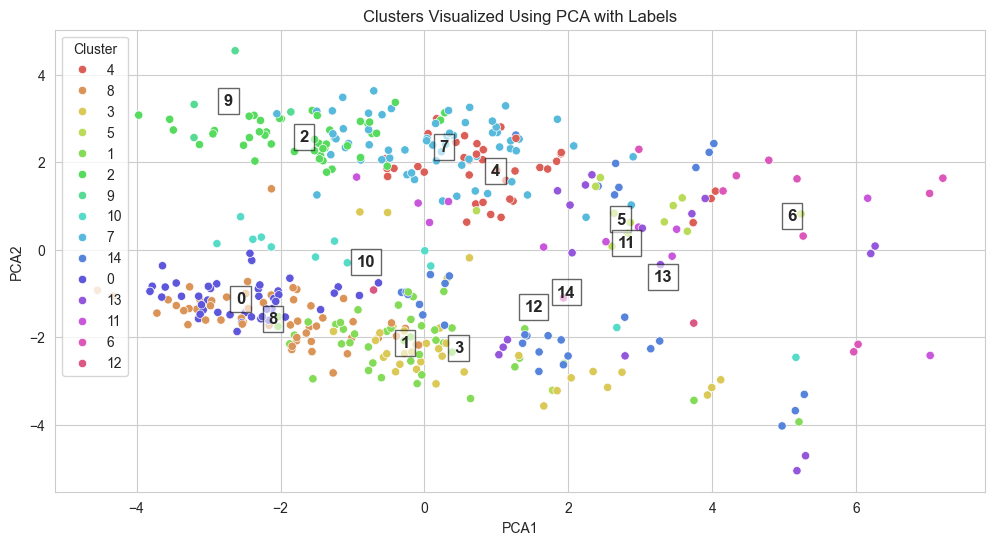

In [456]:
# Scatterplot with clusters


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['PCA1'], X['PCA2'] = X_pca[:, 0], X_pca[:, 1]

sns.scatterplot(
    data=X, 
    x='PCA1', 
    y='PCA2', 
    hue=X['Cluster'], 
    legend='full', 
    palette=sns.color_palette("hls", final_number)
)

# Add cluster labels at the centroid of each cluster
for cluster in X['Cluster'].unique():
    cluster_data = X[X['Cluster'] == cluster]
    centroid_x = cluster_data['PCA1'].mean()
    centroid_y = cluster_data['PCA2'].mean()
    
    # Add label slightly offset to avoid overlap with the point
    plt.text(centroid_x, centroid_y, str(cluster), 
             fontsize=12, weight='bold', 
             ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.title("Clusters Visualized Using PCA with Labels")
plt.show()

### Random Forest Analysis

In [457]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [458]:
# focus on LLMs only (System in ChatGPT; LLAMA)
df_sentences_RF = df_sentences.copy()
df_sentences_RF = df_sentences_RF[df_sentences_RF['System'].isin(['ChatGPT', 'LLAMA'])]

# flag if medium+high errors is >= 1
df_sentences_RF['medium+high_present'] = ((df_sentences_RF['medium'] + df_sentences_RF['high']) >= 1)

y = df_sentences_RF['medium+high_present'].copy()

X_cols = [
   'System', 
   #'Dataset', 
   'Total Edits',
       'Substitution_count', 'Insertion_count', 'Split_count',
       'Structure_count', 'Deletion_count', 'Reorder_count', 
       'FKGL_Source',
       'FKGL_Difference', 
       'ARI_Source',
       'ARI_Difference', 
       'Lexical_Diversity_Source',
        'Lexical_Diversity_Difference',
       'Syntactic_Complexity_Source', 'Syntactic_Complexity_Difference', 
      #  'BERTScore_Precision',
      #  'BERTScore_Recall', 'BERTScore_F1', 
      #  'GLEU', 'LENS_SALSA',
      # 'No_edit_count', 
       'Sentence_has_specialized_terms',
       'Sentence_contains_named_entity', 
      #  'Deletion (Bad)', 'Insertion (Bad)',
      #  'Reorder (Bad)', 'Split (Bad)', 'Structure (Bad)', 'Substitution (Bad)',
      #  'Deletion (Good)', 'Insertion (Good)', 'Reorder (Good)', 'Split (Good)',
      #  'Structure (Good)', 'Substitution (Good)', 'Deletion (Neutral)',
      #  'Insertion (Neutral)', 'Reorder (Neutral)', 'Split (Neutral)',
      #  'Structure (Neutral)', 'Substitution (Neutral)', 
       'Language', 
       #'LLM_Flag', 
       'SpecialDomain',
       'source_len', 
       'target_len', 
]

X = df_sentences_RF[X_cols].copy()

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [459]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [460]:
rf = RandomForestClassifier(n_estimators=100, random_state=42,
    class_weight='balanced'
    )
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6875
              precision    recall  f1-score   support

       False       0.73      0.88      0.80        56
        True       0.46      0.25      0.32        24

    accuracy                           0.69        80
   macro avg       0.60      0.56      0.56        80
weighted avg       0.65      0.69      0.66        80



In [461]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    #'n_estimators': [100, 200, 500, 2000],   # Number of trees
     'n_estimators': [100],   # Number of trees
    #'max_depth': [10, 20, None],  # Maximum depth of trees
    'max_depth': [20],
    #'min_samples_split': [2, 3, 10],  # Minimum samples required to split
    'min_samples_split': [2],  # Minimum samples required to split
    #'min_samples_leaf': [1, 2, 3],   # Minimum samples in a leaf node
    'min_samples_leaf': [3],
    'class_weight': ['balanced', 'balanced_subsample']  # Class weight options
}

# best_rf = {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
        param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=2, 
        scoring='f1_macro'
    )
grid_search.fit(X_train_scaled, y_train)

# Display best parameters
print("Best Hyperparameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced_subsample, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced_subsample, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced_subsample, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced_subsample, max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced_s

Tuned Model Accuracy: 0.7
              precision    recall  f1-score   support

       False       0.81      0.75      0.78        56
        True       0.50      0.58      0.54        24

    accuracy                           0.70        80
   macro avg       0.65      0.67      0.66        80
weighted avg       0.72      0.70      0.71        80



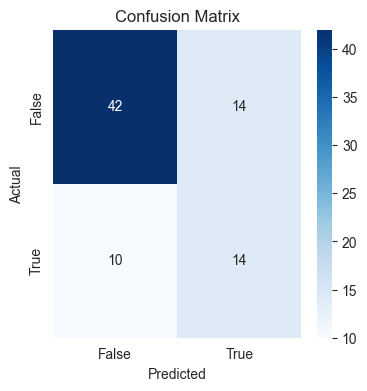

In [462]:
y_pred_best = best_rf.predict(X_test_scaled)

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Feature  Importance
19                     System_LLAMA        0.25
12     Lexical_Diversity_Difference        0.10
18                       target_len        0.07
5                    Deletion_count        0.07
10                   ARI_Difference        0.07
17                       source_len        0.06
7                       FKGL_Source        0.05
8                   FKGL_Difference        0.05
9                        ARI_Source        0.05
0                       Total Edits        0.05
11         Lexical_Diversity_Source        0.04
1                Substitution_count        0.03
13      Syntactic_Complexity_Source        0.02
14  Syntactic_Complexity_Difference        0.02
2                   Insertion_count        0.02
3                       Split_count        0.02
4                   Structure_count        0.01
20        SpecialDomain_Specialized        0.01
6                     Reorder_count        0.01
15   Sentence_has_specialized_terms        0.01
16   Sentence_contains_named_entity        0.00

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/1816952526.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")


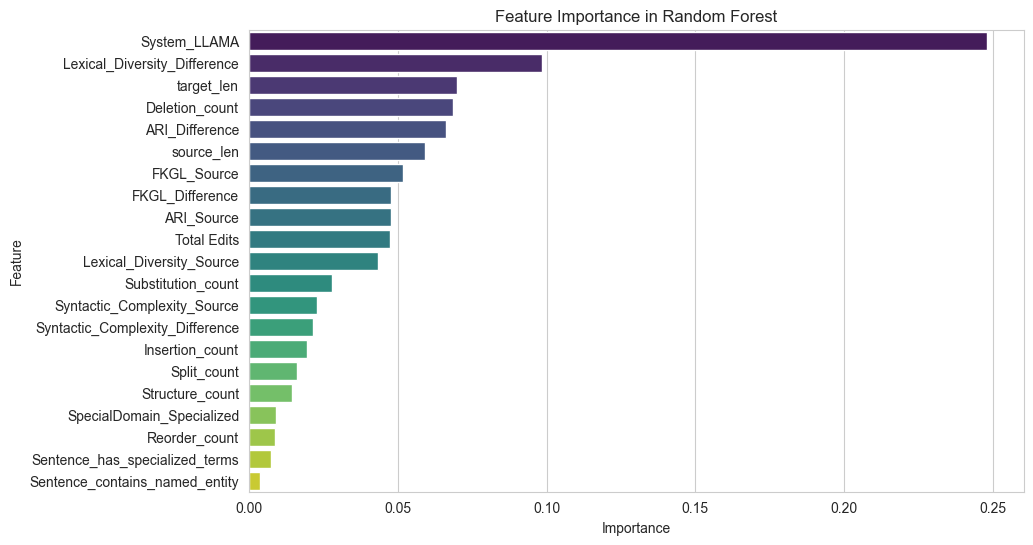

In [463]:
importances = best_rf.feature_importances_
feature_names = X.columns

# Convert to DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display feature importances

display(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")
plt.title("Feature Importance in Random Forest")
plt.show()

#### Cluster Prediction

In [464]:
# take df_edits with clusters from before
data_clRF = df_edits_baseline.copy()

cols_to_drop = [
    'Sentence ID',
    'Source',
    'Target',
    'Dataset',
    'Input Index', 'Output Index',
    'Constituent Input Index',
    'Constituent Output Index', 'Input Text', 'Output Text',
    'Sentence ID NUM',
    'Sentence ID MIX'
]

data_clRF = data_clRF.drop(columns=cols_to_drop)

data_clRF

System      Family     Edit Type        Edit Sub-Type  \
4     ChatGPT  Conceptual      deletion         Bad Deletion   
10    ChatGPT  Conceptual      deletion         Bad Deletion   
12    ChatGPT  Conceptual  substitution  Information Rewrite   
20    ChatGPT  Conceptual  substitution  Information Rewrite   
23    ChatGPT  Conceptual  substitution  Information Rewrite   
...       ...         ...           ...                  ...   
3787    LLAMA  Conceptual  substitution         Bad Deletion   
3788    LLAMA  Conceptual      deletion         Bad Deletion   
3789    LLAMA  Conceptual      deletion         Bad Deletion   
3793    LLAMA  Conceptual      deletion         Bad Deletion   
3795    LLAMA      Syntax     structure                Tense   

     Edit Classification Structure Sub-Type Quality Information Impact  \
4           Bad Deletion                NaN   Error     Generalization   
10          Bad Deletion                NaN   Error     Generalization   
12      Bad Substitution                NaN   Error   Same Information   
20      Bad Substitution                NaN   Error   Same Information   
23      Bad Substitution                NaN   Error   Same Information   
...                  ...                ...     ...                ...   
3787    Bad Substitution                NaN   Error   Same Information   
3788        Bad Deletion                NaN   Error     Generalization   
3789        Bad Deletion                NaN   Error     Generalization   
3793        Bad Deletion                NaN   Error     Generalization   
3795       Bad Structure              Tense   Error   Same Information   

     Grammar Error  Significance  Constituent Edits  Is Constituent Edit  \
4               No             1                  0                False   
10              No             1                  0                False   
12              No             1                  0                False   
20              No             1                  0                False   
23              No             1                  0                False   
...            ...           ...                ...                  ...   
3787            No             1                  0                False   
3788            No             1                  0                False   
3789            No             1                  0                False   
3793            No             2                  0                False   
3795            No             1                  1                False   

      Parent Edit Type  has_specialized_terms  contains_named_entity Language  \
4                  NaN                  False                   True       EN   
10                 NaN                   True                  False       EN   
12                 NaN                  False                  False       EN   
20                 NaN                  False                  False       EN   
23                 NaN                  False                  False       EN   
...                ...                    ...                    ...      ...   
3787               NaN                  False                  False       EN   
3788               NaN                  False                  False       EN   
3789               NaN                  False                  False       EN   
3793               NaN                  False                  False       EN   
3795               NaN                  False                  False       EN   

      LLM_Flag SpecialDomain  Cluster  
4         True       General        5  
10        True       General        5  
12        True       General        0  
20        True       General        0  
23        True       General        0  
...        ...           ...      ...  
3787      True       General        4  
3788      True       General        5  
3789      True       General        5  
3793      True       General        1  
3795      True       Ge

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        17
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        21
           7       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         2

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

(41,)
41


/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/py311ts/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Feature  Importance
14                   Edit Sub-Type_Bad Deletion        0.06
17                  Edit Sub-Type_Complex Wrong        0.05
21            Edit Sub-Type_Information Rewrite        0.04
27            Edit Classification_Bad Insertion        0.04
7                                  System_LLAMA        0.04
16              Edit Sub-Type_Clausal Structure        0.04
20             Edit Sub-Type_Grammatical Number        0.04
25       Edit Sub-Type_Unknown Structure Change        0.03
0                                  Significance        0.03
37            Information Impact_Generalization        0.03
24                          Edit Sub-Type_Tense        0.03
5                         contains_named_entity        0.03
33            Structure Sub-Type_Part of Speech        0.03
12                          Edit Type_structure        0.03
34                     Structure Sub-Type_Tense        0.03
8                                 Family_Syntax        0.03
38          Information Impact_Same Information        0.03
36                     Structure Sub-Type_Voice        0.03
31         Edit Classification_Bad Substitution        0.03
40                    SpecialDomain_Specialized        0.03
29                Edit Classification_Bad Split        0.03
13                       Edit Type_substitution        0.03
1                             Constituent Edits        0.03
23                     Edit Sub-Type_Repetition        0.02
10                            Edit Type_reorder        0.02
30            Edit Classification_Bad Structure        0.02
35  Structure Sub-Type_Unknown Structure Change        0.02
26                          Edit Sub-Type_Voice        0.02
28              Edit Classification_Bad Reorder        0.02
32        Structure Sub-Type_Grammatical Number        0.02
9                           Edit Type_insertion        0.02
19                  Edit Sub-Type_Factual Error        0.02
11                              Edit Type_split        0.02
22                 Edit Sub-Type_Part of Speech        0.01
15                      Edit Sub-Type_Bad Split        0.01
4                         has_specialized_terms        0.01
18                  Edit Sub-Type_Contradiction        0.00
39                            Grammar Error_Yes        0.00
2                           Is Constituent Edit        0.00
6                                      LLM_Flag        0.00
3                              Parent Edit Type        0.00

/var/folders/x5/tn6zjn0s4s7b7224fcw_p4y80000gn/T/ipykernel_25172/1993527558.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")


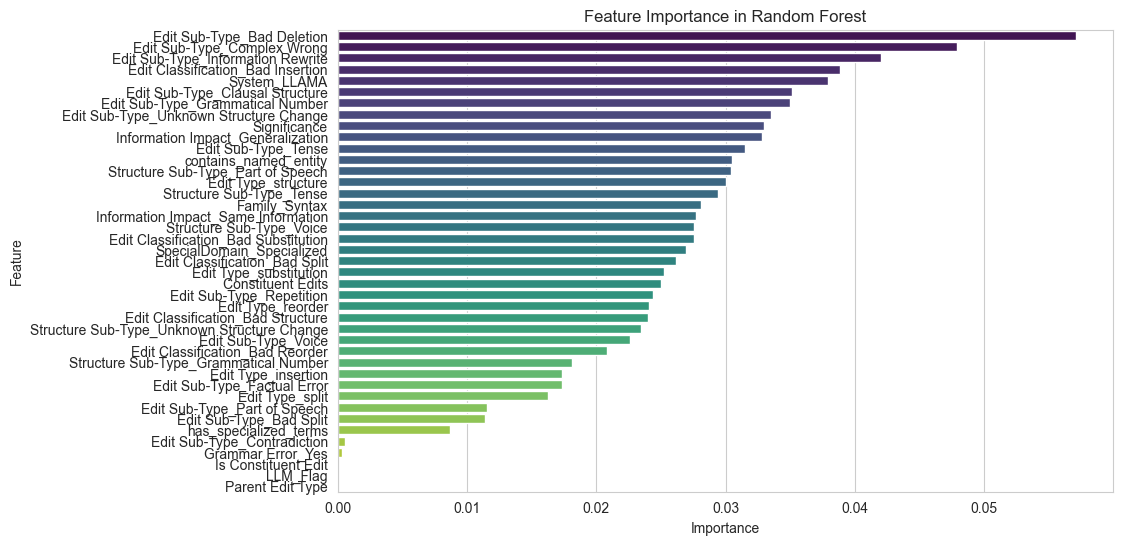

In [465]:
# One-hot encoding
data_clRF2 = pd.get_dummies(data_clRF, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    data_clRF2.drop(columns=['Cluster']), 
    data_clRF2['Cluster'], 
    test_size=0.2, 
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42,
    class_weight='balanced'
    )
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


importances = rf.feature_importances_
feature_names = X_train.columns

print(importances.shape)
print(len(feature_names))

# Convert to DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display feature importances

display(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")
plt.title("Feature Importance in Random Forest")
plt.show()